In [1]:
from pathlib import Path
from traitlets.config.loader import Config
from ctapipe.io import EventSource
from calibpipe.throughput import MuonCalibrator
import yaml
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.calib import CameraCalibrator
from matplotlib.patches import RegularPolygon
import matplotlib.pyplot as plt
file_path = '/Users/vdk/Downloads/lst-sim-config-sim-telarray-lst-magic-prod2-v1.4/mirror_CTA-N-LST1_v2019-03-31.dat'

# Lists to hold the extracted data from the first two columns
first_column = []
second_column = []

# Open the file and read the data
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into a list of elements based on whitespace
        columns = line.split()
        # Check if the line has enough columns
        if len(columns) >= 2 and line[0] != '#':
            # Append the data from the first two columns to their respective lists
            first_column.append(float(columns[0]))
            second_column.append(float(columns[1]))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from ctapipe.containers import (
    MuonEfficiencyContainer,
    MuonParametersContainer,
)
from ctapipe.coordinates import (
    CameraFrame,
    TelescopeFrame,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import (
    MuonIntensityFitter,
    MuonRingFitter
)
from ctapipe.image.muon.features import ring_containment, ring_completeness

__all__ = [
    'analyze_muon_event',
    'create_muon_table',
    'fill_muon_event',
    'fit_muon',
    'muon_filter',
    'pixel_coords_to_telescope',
    'radial_light_distribution',
    'tag_pix_thr',
    'update_parameters',
]


def pixel_coords_to_telescope(geom, equivalent_focal_length):
    """
    Get the x, y coordinates of the pixels in the telescope frame

    Parameters
    ----------
    geom : `CameraGeometry`
        Camera geometry
    equivalent_focal_length: `float`
        Focal length of the telescope

    Returns
    -------
    fov_lon, fov_lat : `floats`
        Coordinates in  the TelescopeFrame
    """

    camera_coord = SkyCoord(geom.pix_x, geom.pix_y,
                            CameraFrame(focal_length=equivalent_focal_length,
                                        rotation=geom.cam_rotation))
    tel_coord = camera_coord.transform_to(TelescopeFrame())

    return tel_coord.fov_lon, tel_coord.fov_lat


def update_parameters(config, n_pixels):
    """
    Create the parameters used to select good muon rings and perform the muon analysis.

    Parameters
    ----------
    config: `dict` or None
        Subset of parameters to be updated
    n_pixels: `int`
        Number of pixels of the camera

    Returns
    -------
    params: `dict`
        Dictionary of parameters used for the muon analysis

    """
    params = {
        'tailcuts': [10, 5],  # Thresholds used for the tail_cut cleaning
        'min_pix': 0.08,  # minimum fraction of the number of pixels in the ring with >0 signal
        'min_pix_fraction_after_cleaning': 0.1,  # minimum fraction of the ring pixels that must be above tailcuts[0]
        'min_ring_radius': 0.8 * u.deg,  # minimum ring radius
        'max_ring_radius': 1.5 * u.deg,  # maximum ring radius
        'max_radial_stdev': 0.1 * u.deg,  # maximum standard deviation of the light distribution along ring radius
        'max_radial_excess_kurtosis': 1.,  # maximum excess kurtosis
        'min_impact_parameter': 0.2,  # in fraction of mirror radius
        'max_impact_parameter': 0.9,  # in fraction of mirror radius
        'ring_integration_width': 0.25,  # +/- integration range along ring radius,
                                         # in fraction of ring radius (was 0.4 until 20200326)
        'outer_ring_width': 0.2,  # in fraction of ring radius, width of ring just outside the
                                  # integrated muon ring, used to check pedestal bias
        'ring_completeness_threshold': 30,  # Threshold in p.e. for pixels used in the ring completeness estimation
    }
    if config is not None:
        for key in config.keys():
            params[key] = config[key]
    params['min_pix'] = int(n_pixels * params['min_pix'])

    return params


def fit_muon(x, y, image, geom, tailcuts):
    """
    Fit the muon ring

    Parameters
    ----------
    x, y : `floats`
        Coordinates in  the TelescopeFrame
    image : `np.ndarray`
        Number of photoelectrons in each pixel
    geom : CameraGeometry
    tailcuts :`list`
        Tail cuts for image cleaning

    Returns
    -------
    muonringparam
    clean_mask: `np.ndarray`
        Mask after cleaning
    dist: `np.ndarray`
        Distance of every pixel to the center of the muon ring
    image_clean: `np.ndarray`
        Image after cleaning
    """

    fitter = MuonRingFitter(fit_method='kundu_chaudhuri')

    clean_mask = tailcuts_clean(
        geom, image,
        picture_thresh=tailcuts[0],
        boundary_thresh=tailcuts[1],
    )

    ring = fitter(x, y, image, clean_mask)

    max_allowed_outliers_distance = 0.4

    # Do an iterative fit removing pixels which are beyond
    # max_allowed_outliers_distance * radius of the ring
    # (along the radial direction)
    # The goal is to improve fit for good rings
    # with very few additional non-ring bright pixels.
    for _ in (0, 0):  # just to iterate the fit twice more
        dist = np.sqrt(
            (x - ring.center_fov_lon) ** 2 + (y - ring.center_fov_lat) ** 2
        )
        ring_dist = np.abs(dist - ring.radius)

        clean_mask *= (ring_dist < ring.radius * max_allowed_outliers_distance)
        ring = fitter(x, y, image, clean_mask)

    image_clean = image * clean_mask
    return ring, clean_mask, dist, image_clean


def analyze_muon_event(subarray, tel_id, event_id, image, good_ring_config, plot_rings, plots_path):
    """
    Analyze an event to fit a muon ring

    Parameters
    ----------
    subarray: `ctapipe.instrument.subarray.SubarrayDescription`
        Telescopes subarray
    tel_id : `int`
        Id of the telescope used
    event_id : `int`
        Id of the analyzed event
    image : `np.ndarray`
        Number of photoelectrons in each pixel
    good_ring_config : `dict` or None
        Set of parameters used to identify good muon rings to update LST-1 defaults
    plot_rings : `bool`
        Plot the muon ring
    plots_path : `string`
        Path to store the figures

    Returns
    -------
    muonintensityoutput : `MuonEfficiencyContainer`
    dist_mask : `ndarray`
        Pixels used in ring intensity likelihood fit
    ring_size : `float`
        Total intensity in ring in photoelectrons
    size_outside_ring : `float`
        Intensity outside the muon ring in photoelectrons
        to check for "shower contamination"
    muonringparam : `MuonRingContainer`
    good_ring : `bool`
        It determines whether the ring can be used for analysis or not
    radial_distribution : `dict`
        Return of function radial_light_distribution
    mean_pixel_charge_around_ring : float
        Charge "just outside" ring, to check the possible signal extractor bias
    muonparameters : `MuonParametersContainer`
    """

    tel_description = subarray.tels[tel_id]

    cam_rad = (
                      tel_description.camera.geometry.guess_radius() / tel_description.optics.equivalent_focal_length
              ) * u.rad
    geom = tel_description.camera.geometry
    equivalent_focal_length = tel_description.optics.equivalent_focal_length
    mirror_area = tel_description.optics.mirror_area

    # some parameters for analysis and cuts for good ring selection:
    params = update_parameters(good_ring_config, geom.n_pixels)

    x, y = pixel_coords_to_telescope(geom, equivalent_focal_length)
    muonringparam, clean_mask, dist, image_clean = fit_muon(x, y, image, geom,
                                                            params['tailcuts'])

    mirror_radius = np.sqrt(mirror_area / np.pi)  # meters
    dist_mask = np.abs(dist - muonringparam.radius
                       ) < muonringparam.radius * params['ring_integration_width']
    pix_ring = image * dist_mask
    pix_outside_ring = image * ~dist_mask

    # mask to select pixels just outside the ring that will be integrated to obtain the ring's intensity:
    dist_mask_2 = np.logical_and(~dist_mask,
                                 np.abs(dist - muonringparam.radius) <
                                 muonringparam.radius *
                                 (params['ring_integration_width'] + params['outer_ring_width']))
    pix_ring_2 = image[dist_mask_2]

    muonparameters = MuonParametersContainer()
    muonparameters.containment = ring_containment(
        muonringparam.radius,
        muonringparam.center_fov_lon, muonringparam.center_fov_lat, cam_rad)

    radial_distribution = radial_light_distribution(
        muonringparam.center_fov_lon,
        muonringparam.center_fov_lat,
        x[clean_mask], y[clean_mask],
        image[clean_mask])

    # Do complicated calculations (minuit-based max likelihood ring fit) only for selected rings:
    candidate_clean_ring = all(
        [radial_distribution['standard_dev'] < params['max_radial_stdev'],
         radial_distribution['excess_kurtosis'] < params['max_radial_excess_kurtosis'],
         (pix_ring > params['tailcuts'][0]).sum() >
         params['min_pix_fraction_after_cleaning'] * params['min_pix'],
         np.count_nonzero(pix_ring) > params['min_pix'],
         muonringparam.radius < params['max_ring_radius'],
         muonringparam.radius > params['min_ring_radius']
         ])

    if candidate_clean_ring:
        intensity_fitter = MuonIntensityFitter(subarray, hole_radius_m=0.308)

        # Use same hard-coded value for pedestal fluctuations as the previous
        # version of ctapipe:
        pedestal_stddev = 1.1 * np.ones(len(image))

        muonintensityoutput = intensity_fitter(
            tel_id,
            muonringparam.center_fov_lon,
            muonringparam.center_fov_lat,
            muonringparam.radius,
            image,
            pedestal_stddev,
            dist_mask,
        )

        dist_ringwidth_mask = np.abs(dist - muonringparam.radius) < \
                              muonintensityoutput.width

        # We do the calculation of the ring completeness (i.e. fraction of whole circle) using the pixels
        # within the "width" fitted using MuonIntensityFitter
        muonparameters.completeness = ring_completeness(
            x[dist_ringwidth_mask], y[dist_ringwidth_mask],
            image[dist_ringwidth_mask],
            muonringparam.radius,
            muonringparam.center_fov_lon,
            muonringparam.center_fov_lat,
            threshold=params['ring_completeness_threshold'],
            bins=30)

        # No longer existing in ctapipe 0.8:
        # pix_ringwidth_im = image[dist_ringwidth_mask]
        # muonintensityoutput.ring_pix_completeness =  \
        #     (pix_ringwidth_im > tailcuts[0]).sum() / len(pix_ringwidth_im)

    else:
        # just to have the default values with units:
        muonintensityoutput = MuonEfficiencyContainer()
        muonintensityoutput.width = u.Quantity(np.nan, u.deg)
        muonintensityoutput.impact = u.Quantity(np.nan, u.m)
        muonintensityoutput.impact_x = u.Quantity(np.nan, u.m)
        muonintensityoutput.impact_y = u.Quantity(np.nan, u.m)

    # muonintensityoutput.mask = dist_mask # no longer there in ctapipe 0.8
    ring_size = np.sum(pix_ring)
    size_outside_ring = np.sum(pix_outside_ring * clean_mask)

    # This is just mean charge per pixel in pixels just around the ring
    # (on the outer side):
    mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)

    if candidate_clean_ring:
        print("Impact parameter={:.3f}, ring_width={:.3f}, ring radius={:.3f}, "
              "ring completeness={:.3f}".format(
            muonintensityoutput.impact,
            muonintensityoutput.width,
            muonringparam.radius,
            muonparameters.completeness, ))
    # Now add the conditions based on the detailed muon ring fit:
    conditions = [
        candidate_clean_ring,
        muonintensityoutput.impact < params['max_impact_parameter'] * mirror_radius,
        muonintensityoutput.impact > params['min_impact_parameter'] * mirror_radius,

        # TODO: To be applied when we have decent optics.
        # muonintensityoutput.width
        # < 0.08,
        # NOTE: inside "candidate_clean_ring" cuts there is already a cut in
        # the std dev of light distribution along ring radius, which is also
        # a measure of the ring width

        # muonintensityoutput.width
        # > 0.04
    ]

    if all(conditions):
        good_ring = True
    else:
        good_ring = False


    if (plot_rings and not plots_path):
        print("You are trying to plot without giving a path!")

    return muonintensityoutput, dist_mask, ring_size, size_outside_ring, \
           muonringparam, good_ring, radial_distribution, \
           mean_pixel_charge_around_ring, muonparameters


def muon_filter(image, thr_low=0, thr_up=1.e10):
    """
    Tag muon with a double threshold on the image photoelectron size
    Default values apply no tagging

    Parameters
    ----------
    image : `np.ndarray`
        Number of photoelectrons in each pixel
    thr_low : `float`
        Lower size threshold in photoelectrons
    thr_up : `float`
        Upper size threshold in photoelectrons

    Returns
    -------
    `bool`
        It determines whether a muon was tagged or not

    """
    return image.sum() > thr_low and image.sum() < thr_up


def tag_pix_thr(image, thr_low=50, thr_up=500, pe_thr=10):
    """
    Tag event with a double threshold on the number of pixels above 10 photoelectrons.
    Default values apply elimination of pedestal and calibration events

    Parameters
    ----------
    image : `np.ndarray`
        Number of photoelectrons in each pixel
    thr_low : `int`
        Lower threshold for number of pixel > 10 pe
    thr_up : `int`
        Upper threshold for number of pixel > 10 pe
    pe_thr : 'float'
        Minimum number of photoelectrons for a pixel to be counted

    Returns
    -------
    `bool`
        It determines whether an event is in the given nr of pixel range

    """

    return ((np.size(image[image > pe_thr]) < thr_up) and
            (np.size(image[image > pe_thr]) > thr_low))


def radial_light_distribution(center_x, center_y, pixel_x, pixel_y, image):
    """
    Calculate the radial distribution of the muon ring

    Parameters
    ----------
    center_x : `float`
        Center of muon ring in the field of view from circle fitting
    center_y : `float`
        Center of muon ring in the field of view from circle fitting
    pixel_x : `ndarray`
        X position of pixels in image
    pixel_y : `ndarray`
        Y position of pixel in image
    image : `ndarray`
        Amplitude of image pixels

    Returns
    -------
    standard_dev, skewness

    """

    if np.sum(image) == 0:
        return {'standard_dev': np.nan * u.deg, 'skewness': np.nan, 'excess_kurtosis': np.nan}

    # Convert everything to degrees:
    x0 = center_x.to_value(u.deg)
    y0 = center_y.to_value(u.deg)
    pix_x = pixel_x.to_value(u.deg)
    pix_y = pixel_y.to_value(u.deg)

    pix_r = np.sqrt((pix_x - x0) ** 2 + (pix_y - y0) ** 2)

    # mean, standard deviation & skewness of light distribution along ring radius.
    # ring_radius calculated elsewhere is approximately equal to "mean", but not
    # exactly, so we recalculate it here:
    mean = np.average(pix_r, weights=image)
    delta_r = pix_r - mean
    standard_dev = np.sqrt(np.average(delta_r ** 2, weights=image))
    skewness = np.average(delta_r ** 3, weights=image) / standard_dev ** 3
    excess_kurtosis = np.average(delta_r ** 4, weights=image) / standard_dev ** 4 - 3.

    return {'standard_dev': standard_dev * u.deg, 'skewness': skewness,
            'excess_kurtosis': excess_kurtosis}


def create_muon_table():
    """
    Create the empty dictionary to include the parameters
    of the fitted muon

    Parameters
    ----------
    None

    Returns
    -------
    `dict`
    """

    return {'event_id': [],
            'event_time': [],
            'mc_energy': [],
            'ring_size': [],
            'size_outside': [],
            'ring_center_x': [],
            'ring_center_y': [],
            'ring_radius': [],
            'ring_width': [],
            'good_ring': [],
            'muon_efficiency': [],
            'ring_containment': [],
            'ring_completeness': [],
            #  missing in ctapipe 0.8:
            # 'ring_pixel_completeness': [],
            'impact_parameter': [],
            'impact_x_array': [],
            'impact_y_array': [],
            'fit_valid' : [],
            'parameters_at_limit' : [],
            'radial_stdev': [],  # Standard deviation of (cleaned) light distribution along ring radius
            'radial_skewness': [],  # Skewness of (cleaned) light distribution along ring radius
            'radial_excess_kurtosis': [],  # Excess kurtosis of (cleaned) light distribution along ring radius
            #  missing in ctapipe 0.8:
            'num_pixels_in_ring': [],  # pixels inside the integration area around the ring
            'mean_pixel_charge_around_ring': [],
            # Average pixel charge in pixels surrounding the outer part of the ring
            'hg_peak_sample': [],  # Peak sample of stacked HG waveforms of bright ring pixels
            'lg_peak_sample': [],  # Peak sample of stacked LG waveforms of bright ring pixels
            }


def fill_muon_event(mc_energy, output_parameters, good_ring, event_id,
                    event_time, muonintensityparam, dist_mask,
                    muonringparam, radial_distribution, size,
                    size_outside_ring, mean_pixel_charge_around_ring,
                    muonparameters, hg_peak_sample=np.nan, lg_peak_sample=np.nan):
    """
    Fill the dictionary with the parameters of a muon event

    Parameters
    ----------
    mc_energy: `float`
        Energy for simulated muons
    output_parameters: `dict`
        Empty dictionary to include the parameters
        of the fitted muon
    good_ring : `bool`
        It determines whether the ring can be used for analysis or not
    event_id : `int`
        Id of the analyzed event
    event_time: `float`
        Time of the event
    muonintensityparam: `MuonParametersContainer`
    dist_mask : `ndarray`
        Pixels used in ring intensity likelihood fit
    muonringparam : `MuonParametersContainer`
    radial_distribution : `dict`
        Return of function radial_light_distribution
    size : `float`
        Total intensity in ring in photoelectrons
    size_outside_ring : `float`
        Intensity outside the muon ting in photoelectrons
        to check for "shower contamination"
    mean_pixel_charge_around_ring : float
        Charge "just outside" ring, to check the possible signal extractor bias
    muonparameters : `MuonParametersContainer`
    hg_peak_sample: `np.ndarray`
        HG sample of the peak
    lg_peak_sample: `np.ndarray`
        LG sample of the peak

    Returns
    -------
    None

    """

    output_parameters['event_id'].append(event_id)
    output_parameters['event_time'].append(event_time)
    output_parameters['mc_energy'].append(mc_energy)

    output_parameters['ring_size'].append(size)
    output_parameters['size_outside'].append(size_outside_ring)
    output_parameters['ring_center_x'].append(muonringparam.center_fov_lon.value)
    output_parameters['ring_center_y'].append(muonringparam.center_fov_lat.value)
    output_parameters['ring_radius'].append(muonringparam.radius.value)
    output_parameters['ring_width'].append(muonintensityparam.width.value)
    output_parameters['good_ring'].append(good_ring)
    output_parameters['muon_efficiency'].append(muonintensityparam.optical_efficiency)
    output_parameters['ring_containment'].append(muonparameters.containment)
    output_parameters['ring_completeness'].append(muonparameters.completeness)
    #  missing in ctapipe 0.8:
    # output_parameters['ring_pixel_completeness'].append(muonintensityparam.ring_pix_completeness)
    output_parameters['impact_parameter'].append(muonintensityparam.impact.value)
    output_parameters['impact_x_array'].append(muonintensityparam.impact_x.value)
    output_parameters['impact_y_array'].append(muonintensityparam.impact_y.value)
    output_parameters['is_valid'].append(muonintensityparam.is_valid)
    output_parameters['parameters_at_limit'].append(muonintensityparam.parameters_at_limit)
    output_parameters['radial_stdev'].append(radial_distribution['standard_dev'].value)
    output_parameters['radial_skewness'].append(radial_distribution['skewness'])
    output_parameters['radial_excess_kurtosis'].append(radial_distribution['excess_kurtosis'])
    output_parameters['num_pixels_in_ring'].append(np.sum(dist_mask))
    output_parameters['mean_pixel_charge_around_ring'].append(mean_pixel_charge_around_ring)
    output_parameters['hg_peak_sample'].append(hg_peak_sample)
    output_parameters['lg_peak_sample'].append(lg_peak_sample)

    return

In [ ]:
# Upload config
params = {
    'tailcuts': [10, 5],  # Thresholds used for the tail_cut cleaning
    'min_pix': 0.08,  # minimum fraction of the number of pixels in the ring with >0 signal
    'min_pix_fraction_after_cleaning': 0.1,  # minimum fraction of the ring pixels that must be above tailcuts[0]
    'min_ring_radius': 0.8 * u.deg,  # minimum ring radius
    'max_ring_radius': 1.5 * u.deg,  # maximum ring radius
    'max_radial_stdev': 0.1 * u.deg,  # maximum standard deviation of the light distribution along ring radius
    'max_radial_excess_kurtosis': 1.,  # maximum excess kurtosis
    'min_impact_parameter': 0.2,  # in fraction of mirror radius
    'max_impact_parameter': 0.9,  # in fraction of mirror radius
    'ring_integration_width': 0.25,  # +/- integration range along ring radius,
                                        # in fraction of ring radius (was 0.4 until 20200326)
    'outer_ring_width': 0.2,  # in fraction of ring radius, width of ring just outside the
                                # integrated muon ring, used to check pedestal bias
    'ring_completeness_threshold': 30,  # Threshold in p.e. for pixels used in the ring completeness estimation
    }
muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.3"],
                                                        ["ring_completeness", "parameters.completeness > 0.3"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})
# Upload eventsource
checker = 0
event_container = {}
event_ids = []
impacts = []
widths = []
for k in range(1,2):
    filename = f'/Users/vdk/Software/ctasoft/support_files/simtel_run501_muon_telescope_transmission_0.8.simtel'
    source = EventSource(filename)
    event_iterator = iter(source)
    for i,event in enumerate(event_iterator):
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)

        calib(event)
        image_processor(event)
        muon_processor(event)
        candidate_clean_ring = all(
        [
         muonringparam.radius < params['max_ring_radius'],
         muonringparam.radius > params['min_ring_radius']
         ])
        if not np.isnan(event.muon.tel[m].efficiency.width):
            #print("I am here")
            # plt.figure(figsize = (9,6))
            # camgeom = source.subarray.tel[1].camera.geometry
            # title = f'event {event.index.event_id} in telescope {m}'
            # disp = CameraDisplay(camgeom,title=title)
            # #disp.image = event.r1.tel[m].waveform.sum(axis = 1)
            # disp.image = event.dl1.tel[m].image
            # disp.cmap = plt.cm.Reds
            # disp.add_colorbar()
            # disp.set_limits_percent(95)
            # plt.show()
            print(f"Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
            event_container[keks+i] = event
            event_ids.append(event.index.event_id)
            impacts.append(event.muon.tel[m].efficiency.impact)
            widths.append(event.muon.tel[m].efficiency.width)

# r0 dl1 Calibrate
# Image processor 
# Muon processor (config with cuts)
# Apply lstchain cuts
# Extract impact parameter points + optical efficiency

In [3]:
impact_x = []
impact_y = []
for k in range(1,2):
    filename = f'/Users/vdk/Software/data/run16201_muon.simtel.gz'
    source = EventSource(filename, )
    event_iterator = iter(source)
    for event_id,event in enumerate(event_iterator):
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
        image_processor = ImageProcessor(source.subarray)
        calib(event)
        image_processor(event)
        (
                muonintensityparam, dist_mask, size, size_outside_ring,
                muonringparam, good_ring, radial_distribution,
                mean_pixel_charge_around_ring, muonparameters
            ) = analyze_muon_event(source.subarray, 1, event_id,
                                   event.dl1.tel[1].image, good_ring_config=None,
                                   plot_rings=False, plots_path='args.plots_path'
                                   )
        fill_muon_event(
                1, output_parameters, good_ring, event_id,
                dragon_time, muonintensityparam, dist_mask,
                muonringparam, radial_distribution, size,
                size_outside_ring, mean_pixel_charge_around_ring,
                muonparameters
            )
        if muonintensityparam.is_valid and (not muonintensityparam.parameters_at_limit):
            impact_x.append(muonintensityparam.impact_x.to_value())
            impact_y.append(muonintensityparam.impact_y.to_value())
        if len(impact_x) > 4000:
            break

        

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=7.242 m, ring_width=0.095 deg, ring radius=1.197 deg, ring completeness=0.800
Impact parameter=6.983 m, ring_width=0.094 deg, ring radius=1.199 deg, ring completeness=0.900
Impact parameter=2.842 m, ring_width=0.090 deg, ring radius=1.193 deg, ring completeness=0.867
Impact parameter=8.274 m, ring_width=0.098 deg, ring radius=1.198 deg, ring completeness=0.667
Impact parameter=0.001 m, ring_width=0.142 deg, ring radius=0.922 deg, ring completeness=0.267
Impact parameter=5.546 m, ring_width=0.098 deg, ring radius=1.191 deg, ring completeness=0.867
Impact parameter=1.761 m, ring_width=0.089 deg, ring radius=1.182 deg, ring completeness=0.833
Impact parameter=10.911 m, ring_width=0.103 deg, ring radius=1.086 deg, ring completeness=0.367
Impact parameter=6.673 m, ring_width=0.077 deg, ring radius=1.162 deg, ring completeness=0.567
Impact parameter=0.376 m, ring_width=0.048 deg, ring radius=1.007 deg, ring completeness=0.267
Impact parameter=8.131 m, ring_width=0.056 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.708 m, ring_width=0.068 deg, ring radius=1.214 deg, ring completeness=0.867
Impact parameter=11.094 m, ring_width=0.170 deg, ring radius=0.803 deg, ring completeness=0.333
Impact parameter=11.065 m, ring_width=0.128 deg, ring radius=0.832 deg, ring completeness=0.333
Impact parameter=3.648 m, ring_width=0.068 deg, ring radius=1.227 deg, ring completeness=0.800
Impact parameter=0.308 m, ring_width=0.056 deg, ring radius=1.236 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.048 deg, ring radius=1.163 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.343 m, ring_width=0.085 deg, ring radius=1.188 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.034 deg, ring radius=1.098 deg, ring completeness=0.233
Impact parameter=0.000 m, ring_width=0.066 deg, ring radius=1.201 deg, ring completeness=0.767
Impact parameter=8.573 m, ring_width=0.053 deg, ring radius=1.221 deg, ring completeness=0.467
Impact parameter=3.578 m, ring_width=0.050 deg, ring radius=1.228 deg, ring completeness=0.600
Impact parameter=6.226 m, ring_width=0.060 deg, ring radius=1.201 deg, ring completeness=0.767
Impact parameter=11.027 m, ring_width=0.130 deg, ring radius=0.930 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.098 deg, ring radius=1.185 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.130 deg, ring radius=0.928 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.213 deg, ring radius=0.924 deg, ring completeness=0.367
Impact parameter=9.509 m, ring_width=0.083 deg, ring radius=1.193 deg, ring completeness=0.533
Impact parameter=10.063 m, ring_width=0.186 deg, ring radius=1.137 deg, ring completeness=0.500
Impact parameter=7.863 m, ring_width=0.097 deg, ring radius=1.220 deg, ring completeness=0.733
Impact parameter=11.086 m, ring_width=0.135 deg, ring radius=0.819 deg, ring completeness=0.367
Impact parameter=11.093 m, ring_width=0.116 deg, ring radius=0.856 deg, ring completeness=0.367
Impact parameter=9.262 m, ring_width=0.076 deg, ring radius=1.195 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.929 m, ring_width=0.070 deg, ring radius=1.219 deg, ring completeness=0.400
Impact parameter=6.409 m, ring_width=0.069 deg, ring radius=1.212 deg, ring completeness=0.500
Impact parameter=7.499 m, ring_width=0.054 deg, ring radius=1.187 deg, ring completeness=0.333
Impact parameter=0.003 m, ring_width=0.082 deg, ring radius=1.047 deg, ring completeness=0.533
Impact parameter=4.835 m, ring_width=0.081 deg, ring radius=1.111 deg, ring completeness=0.567
Impact parameter=3.644 m, ring_width=0.083 deg, ring radius=1.044 deg, ring completeness=0.600
Impact parameter=3.170 m, ring_width=0.082 deg, ring radius=1.088 deg, ring completeness=0.533
Impact parameter=1.758 m, ring_width=0.087 deg, ring radius=1.099 deg, ring completeness=0.633
Impact parameter=8.573 m, ring_width=0.111 deg, ring radius=1.032 deg, ring completeness=0.433
Impact parameter=8.773 m, ring_width=0.076 deg, ring radius=1.079 deg, ring completeness=0.367
Impact parameter=0.844 m, ring_width=0.060 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.871 m, ring_width=0.081 deg, ring radius=1.173 deg, ring completeness=0.333
Impact parameter=6.113 m, ring_width=0.083 deg, ring radius=1.126 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.068 deg, ring radius=1.113 deg, ring completeness=0.333
Impact parameter=8.913 m, ring_width=0.063 deg, ring radius=1.241 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=4.081 m, ring_width=0.067 deg, ring radius=1.098 deg, ring completeness=0.533
Impact parameter=4.493 m, ring_width=0.078 deg, ring radius=1.063 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.568 m, ring_width=0.084 deg, ring radius=1.186 deg, ring completeness=0.567
Impact parameter=11.087 m, ring_width=0.112 deg, ring radius=1.116 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.087 deg, ring radius=1.108 deg, ring completeness=0.333
Impact parameter=6.366 m, ring_width=0.068 deg, ring radius=1.191 deg, ring completeness=0.967
Impact parameter=6.996 m, ring_width=0.072 deg, ring radius=1.186 deg, ring completeness=0.800
Impact parameter=3.006 m, ring_width=0.062 deg, ring radius=1.180 deg, ring completeness=1.000
Impact parameter=10.047 m, ring_width=0.085 deg, ring radius=1.194 deg, ring completeness=0.467
Impact parameter=7.436 m, ring_width=0.067 deg, ring radius=1.191 deg, ring completeness=0.800
Impact parameter=6.020 m, ring_width=0.069 deg, ring radius=1.192 deg, ring completeness=1.000
Impact parameter=6.010 m, ring_width=0.062 deg, ring radius=1.186 deg, ring completeness=0.933


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.186 m, ring_width=0.071 deg, ring radius=1.213 deg, ring completeness=0.600
Impact parameter=10.106 m, ring_width=0.154 deg, ring radius=1.163 deg, ring completeness=0.500
Impact parameter=10.039 m, ring_width=0.111 deg, ring radius=1.202 deg, ring completeness=0.533
Impact parameter=0.656 m, ring_width=0.070 deg, ring radius=1.187 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.560 deg, ring radius=0.916 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.129 deg, ring radius=0.837 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.000 m, ring_width=0.113 deg, ring radius=1.166 deg, ring completeness=0.800
Impact parameter=0.001 m, ring_width=0.075 deg, ring radius=1.169 deg, ring completeness=1.000
Impact parameter=5.602 m, ring_width=0.071 deg, ring radius=1.191 deg, ring completeness=0.867
Impact parameter=11.088 m, ring_width=0.072 deg, ring radius=1.149 deg, ring completeness=0.400
Impact parameter=6.742 m, ring_width=0.055 deg, ring radius=1.243 deg, ring completeness=0.533
Impact parameter=0.308 m, ring_width=0.060 deg, ring radius=1.189 deg, ring completeness=0.700
Impact parameter=4.500 m, ring_width=0.059 deg, ring radius=1.217 deg, ring completeness=0.600
Impact parameter=8.266 m, ring_width=0.073 deg, ring radius=1.202 deg, ring completeness=0.500
Impact parameter=2.444 m, ring_width=0.059 deg, ring radius=1.206 deg, ring completeness=0.667
Impact parameter=0.001 m, ring_width=0.067 deg, ring radius=1.188 deg, ring completeness=0.600
Impact parameter=5.436 m, ring_width=0.058 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.897 m, ring_width=0.055 deg, ring radius=1.146 deg, ring completeness=0.333
Impact parameter=11.088 m, ring_width=0.046 deg, ring radius=1.146 deg, ring completeness=0.300
Impact parameter=0.312 m, ring_width=0.042 deg, ring radius=1.220 deg, ring completeness=0.500
Impact parameter=8.156 m, ring_width=0.050 deg, ring radius=1.235 deg, ring completeness=0.500
Impact parameter=8.963 m, ring_width=0.060 deg, ring radius=1.212 deg, ring completeness=0.467
Impact parameter=0.000 m, ring_width=0.126 deg, ring radius=0.868 deg, ring completeness=0.367
Impact parameter=9.614 m, ring_width=0.082 deg, ring radius=1.166 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.077 deg, ring radius=1.078 deg, ring completeness=0.367
Impact parameter=7.035 m, ring_width=0.050 deg, ring radius=1.233 deg, ring completeness=0.500
Impact parameter=7.530 m, ring_width=0.064 deg, ring radius=1.161 deg, ring completeness=0.467
Impact parameter=9.275 m, ring_width=0.069 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.052 m, ring_width=0.073 deg, ring radius=1.194 deg, ring completeness=0.333
Impact parameter=8.661 m, ring_width=0.043 deg, ring radius=1.237 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.131 deg, ring radius=0.855 deg, ring completeness=0.333
Impact parameter=9.927 m, ring_width=0.065 deg, ring radius=1.193 deg, ring completeness=0.600
Impact parameter=11.094 m, ring_width=0.087 deg, ring radius=1.103 deg, ring completeness=0.367
Impact parameter=9.907 m, ring_width=0.095 deg, ring radius=1.087 deg, ring completeness=0.400
Impact parameter=9.782 m, ring_width=0.091 deg, ring radius=1.192 deg, ring completeness=0.300
Impact parameter=11.028 m, ring_width=0.091 deg, ring radius=0.896 deg, ring completeness=0.333
Impact parameter=3.751 m, ring_width=0.085 deg, ring radius=0.861 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.078 deg, ring radius=0.884 deg, ring completeness=0.533
Impact parameter=1.164 m, ring_width=0.087 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.637 m, ring_width=0.109 deg, ring radius=1.009 deg, ring completeness=0.333
Impact parameter=0.000 m, ring_width=0.046 deg, ring radius=1.194 deg, ring completeness=0.367
Impact parameter=10.468 m, ring_width=0.048 deg, ring radius=1.198 deg, ring completeness=0.267
Impact parameter=1.551 m, ring_width=0.052 deg, ring radius=1.225 deg, ring completeness=0.567
Impact parameter=6.377 m, ring_width=0.049 deg, ring radius=1.249 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=1.168 deg, ring completeness=0.333
Impact parameter=5.132 m, ring_width=0.056 deg, ring radius=1.236 deg, ring completeness=0.533
Impact parameter=9.035 m, ring_width=0.058 deg, ring radius=1.192 deg, ring completeness=0.433
Impact parameter=2.602 m, ring_width=0.049 deg, ring radius=1.220 deg, ring completeness=0.533
Impact parameter=7.833 m, ring_width=0.071 deg, ring radius=1.236 deg, ring completeness=0.433
Impact parameter=6.168 m, ring_width=0.053 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.220 m, ring_width=0.096 deg, ring radius=0.962 deg, ring completeness=0.967
Impact parameter=8.695 m, ring_width=0.108 deg, ring radius=0.968 deg, ring completeness=0.567
Impact parameter=3.848 m, ring_width=0.107 deg, ring radius=0.974 deg, ring completeness=0.967
Impact parameter=7.591 m, ring_width=0.114 deg, ring radius=0.972 deg, ring completeness=0.633
Impact parameter=0.361 m, ring_width=0.064 deg, ring radius=1.077 deg, ring completeness=0.100
Impact parameter=0.003 m, ring_width=0.075 deg, ring radius=1.142 deg, ring completeness=0.400
Impact parameter=8.542 m, ring_width=0.065 deg, ring radius=1.089 deg, ring completeness=0.167
Impact parameter=2.438 m, ring_width=0.072 deg, ring radius=1.092 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.283 deg, ring radius=0.865 deg, ring completeness=0.367
Impact parameter=11.092 m, ring_width=0.080 deg, ring radius=0.818 deg, ring completeness=0.367
Impact parameter=6.496 m, ring_width=0.077 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.617 m, ring_width=0.139 deg, ring radius=0.866 deg, ring completeness=0.833
Impact parameter=5.668 m, ring_width=0.076 deg, ring radius=1.195 deg, ring completeness=0.433
Impact parameter=0.332 m, ring_width=0.055 deg, ring radius=1.168 deg, ring completeness=0.100
Impact parameter=2.538 m, ring_width=0.062 deg, ring radius=1.164 deg, ring completeness=0.433
Impact parameter=4.379 m, ring_width=0.068 deg, ring radius=1.198 deg, ring completeness=0.433
Impact parameter=8.464 m, ring_width=0.066 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=5.050 m, ring_width=0.067 deg, ring radius=1.182 deg, ring completeness=0.400
Impact parameter=2.023 m, ring_width=0.070 deg, ring radius=1.221 deg, ring completeness=0.433
Impact parameter=10.688 m, ring_width=0.067 deg, ring radius=1.149 deg, ring completeness=0.433
Impact parameter=7.513 m, ring_width=0.070 deg, ring radius=1.127 deg, ring completeness=0.300
Impact parameter=10.004 m, ring_width=0.058 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.695 m, ring_width=0.098 deg, ring radius=1.050 deg, ring completeness=0.433
Impact parameter=0.654 m, ring_width=0.077 deg, ring radius=1.094 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=0.982 deg, ring completeness=0.267
Impact parameter=0.791 m, ring_width=0.072 deg, ring radius=1.084 deg, ring completeness=0.233
Impact parameter=4.603 m, ring_width=0.098 deg, ring radius=1.035 deg, ring completeness=0.433
Impact parameter=0.351 m, ring_width=0.070 deg, ring radius=1.165 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.065 deg, ring radius=1.022 deg, ring completeness=0.400
Impact parameter=5.130 m, ring_width=0.082 deg, ring radius=1.084 deg, ring completeness=1.000
Impact parameter=3.021 m, ring_width=0.076 deg, ring radius=1.099 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.357 m, ring_width=0.070 deg, ring radius=1.142 deg, ring completeness=0.733
Impact parameter=0.000 m, ring_width=0.077 deg, ring radius=1.151 deg, ring completeness=0.633
Impact parameter=10.797 m, ring_width=0.064 deg, ring radius=1.088 deg, ring completeness=0.367
Impact parameter=11.070 m, ring_width=0.070 deg, ring radius=0.992 deg, ring completeness=0.333
Impact parameter=7.935 m, ring_width=0.106 deg, ring radius=1.109 deg, ring completeness=0.633
Impact parameter=10.821 m, ring_width=0.081 deg, ring radius=1.101 deg, ring completeness=0.400
Impact parameter=1.989 m, ring_width=0.072 deg, ring radius=1.130 deg, ring completeness=0.767
Impact parameter=8.051 m, ring_width=0.104 deg, ring radius=1.094 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=7.565 m, ring_width=0.048 deg, ring radius=1.072 deg, ring completeness=0.367
Impact parameter=3.964 m, ring_width=0.043 deg, ring radius=1.048 deg, ring completeness=0.400
Impact parameter=4.460 m, ring_width=0.049 deg, ring radius=1.030 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.112 deg, ring radius=1.010 deg, ring completeness=0.333
Impact parameter=9.660 m, ring_width=0.085 deg, ring radius=1.217 deg, ring completeness=0.533
Impact parameter=9.111 m, ring_width=0.106 deg, ring radius=1.209 deg, ring completeness=0.633


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.686 m, ring_width=0.076 deg, ring radius=1.213 deg, ring completeness=0.933
Impact parameter=5.051 m, ring_width=0.069 deg, ring radius=1.228 deg, ring completeness=0.800
Impact parameter=8.578 m, ring_width=0.097 deg, ring radius=1.213 deg, ring completeness=0.667
Impact parameter=10.759 m, ring_width=0.068 deg, ring radius=1.208 deg, ring completeness=0.367
Impact parameter=6.503 m, ring_width=0.079 deg, ring radius=1.222 deg, ring completeness=1.000
Impact parameter=4.649 m, ring_width=0.077 deg, ring radius=1.228 deg, ring completeness=0.967
Impact parameter=8.966 m, ring_width=0.092 deg, ring radius=1.223 deg, ring completeness=0.900
Impact parameter=8.397 m, ring_width=0.080 deg, ring radius=1.231 deg, ring completeness=0.667
Impact parameter=11.086 m, ring_width=0.089 deg, ring radius=1.021 deg, ring completeness=0.333
Impact parameter=6.038 m, ring_width=0.072 deg, ring radius=1.230 deg, ring completeness=0.900
Impact parameter=2.221 m, ring_width=0.082 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.172 m, ring_width=0.088 deg, ring radius=1.029 deg, ring completeness=0.767
Impact parameter=8.353 m, ring_width=0.051 deg, ring radius=1.120 deg, ring completeness=0.167
Impact parameter=2.365 m, ring_width=0.055 deg, ring radius=1.100 deg, ring completeness=0.533
Impact parameter=7.686 m, ring_width=0.070 deg, ring radius=1.090 deg, ring completeness=0.433
Impact parameter=0.324 m, ring_width=0.051 deg, ring radius=1.131 deg, ring completeness=0.567
Impact parameter=6.504 m, ring_width=0.052 deg, ring radius=1.152 deg, ring completeness=0.467
Impact parameter=3.509 m, ring_width=0.055 deg, ring radius=1.144 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.375 m, ring_width=0.078 deg, ring radius=1.143 deg, ring completeness=0.367
Impact parameter=10.686 m, ring_width=0.082 deg, ring radius=1.033 deg, ring completeness=0.300
Impact parameter=9.041 m, ring_width=0.074 deg, ring radius=1.137 deg, ring completeness=0.267
Impact parameter=4.862 m, ring_width=0.068 deg, ring radius=1.170 deg, ring completeness=0.333
Impact parameter=7.343 m, ring_width=0.095 deg, ring radius=1.093 deg, ring completeness=0.367
Impact parameter=4.735 m, ring_width=0.090 deg, ring radius=1.082 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.091 deg, ring radius=1.076 deg, ring completeness=0.400
Impact parameter=5.615 m, ring_width=0.078 deg, ring radius=1.116 deg, ring completeness=0.400
Impact parameter=1.933 m, ring_width=0.076 deg, ring radius=1.111 deg, ring completeness=0.300
Impact parameter=0.411 m, ring_width=0.093 deg, ring radius=1.105 deg, ring completeness=0.367
Impact parameter=5.865 m, ring_width=0.091 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.393 m, ring_width=0.078 deg, ring radius=1.170 deg, ring completeness=0.267
Impact parameter=10.158 m, ring_width=0.072 deg, ring radius=1.124 deg, ring completeness=0.300
Impact parameter=8.145 m, ring_width=0.078 deg, ring radius=1.161 deg, ring completeness=0.333
Impact parameter=4.922 m, ring_width=0.054 deg, ring radius=1.189 deg, ring completeness=0.600
Impact parameter=9.883 m, ring_width=0.054 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=5.871 m, ring_width=0.055 deg, ring radius=1.219 deg, ring completeness=0.567
Impact parameter=10.773 m, ring_width=0.065 deg, ring radius=1.176 deg, ring completeness=0.367
Impact parameter=9.252 m, ring_width=0.061 deg, ring radius=1.218 deg, ring completeness=0.433
Impact parameter=10.399 m, ring_width=0.110 deg, ring radius=0.992 deg, ring completeness=0.300
Impact parameter=3.355 m, ring_width=0.033 deg, ring radius=1.161 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.057 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=0.831 deg, ring completeness=0.300
Impact parameter=8.230 m, ring_width=0.069 deg, ring radius=0.975 deg, ring completeness=0.500
Impact parameter=6.155 m, ring_width=0.127 deg, ring radius=0.938 deg, ring completeness=0.767
Impact parameter=8.466 m, ring_width=0.105 deg, ring radius=0.989 deg, ring completeness=0.600


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=0.825 deg, ring completeness=0.300
Impact parameter=6.159 m, ring_width=0.148 deg, ring radius=0.941 deg, ring completeness=0.800
Impact parameter=2.864 m, ring_width=0.089 deg, ring radius=0.959 deg, ring completeness=1.000
Impact parameter=2.749 m, ring_width=0.081 deg, ring radius=0.969 deg, ring completeness=0.967
Impact parameter=10.457 m, ring_width=0.131 deg, ring radius=0.923 deg, ring completeness=0.433
Impact parameter=2.874 m, ring_width=0.076 deg, ring radius=0.981 deg, ring completeness=0.933
Impact parameter=8.184 m, ring_width=0.056 deg, ring radius=1.258 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.066 deg, ring radius=1.187 deg, ring completeness=0.467
Impact parameter=0.322 m, ring_width=0.070 deg, ring radius=0.943 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.062 deg, ring radius=1.143 deg, ring completeness=0.333
Impact parameter=0.706 m, ring_width=0.052 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.469 m, ring_width=0.076 deg, ring radius=1.163 deg, ring completeness=0.767


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.987 m, ring_width=0.051 deg, ring radius=1.147 deg, ring completeness=0.467
Impact parameter=3.927 m, ring_width=0.054 deg, ring radius=1.188 deg, ring completeness=0.467
Impact parameter=1.787 m, ring_width=0.054 deg, ring radius=1.164 deg, ring completeness=0.467
Impact parameter=3.499 m, ring_width=0.053 deg, ring radius=1.188 deg, ring completeness=0.500
Impact parameter=9.545 m, ring_width=0.045 deg, ring radius=1.145 deg, ring completeness=0.200
Impact parameter=5.450 m, ring_width=0.044 deg, ring radius=1.154 deg, ring completeness=0.467
Impact parameter=3.142 m, ring_width=0.052 deg, ring radius=1.190 deg, ring completeness=0.500
Impact parameter=0.000 m, ring_width=0.050 deg, ring radius=1.184 deg, ring completeness=0.500
Impact parameter=8.567 m, ring_width=0.074 deg, ring radius=1.166 deg, ring completeness=0.367
Impact parameter=3.971 m, ring_width=0.053 deg, ring radius=1.229 deg, ring completeness=0.500
Impact parameter=9.890 m, ring_width=0.062 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.011 m, ring_width=0.081 deg, ring radius=1.102 deg, ring completeness=0.200
Impact parameter=0.002 m, ring_width=0.089 deg, ring radius=1.151 deg, ring completeness=0.400
Impact parameter=6.576 m, ring_width=0.081 deg, ring radius=1.078 deg, ring completeness=0.333
Impact parameter=7.492 m, ring_width=0.100 deg, ring radius=1.115 deg, ring completeness=0.833
Impact parameter=0.422 m, ring_width=0.074 deg, ring radius=1.101 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=0.852 deg, ring completeness=0.300
Impact parameter=7.268 m, ring_width=0.058 deg, ring radius=1.133 deg, ring completeness=0.733
Impact parameter=3.111 m, ring_width=0.068 deg, ring radius=1.127 deg, ring completeness=0.933
Impact parameter=10.923 m, ring_width=0.076 deg, ring radius=1.106 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.199 deg, ring radius=0.879 deg, ring completeness=0.400
Impact parameter=0.373 m, ring_width=0.072 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.063 deg, ring radius=1.142 deg, ring completeness=0.133
Impact parameter=0.001 m, ring_width=0.075 deg, ring radius=1.060 deg, ring completeness=0.233
Impact parameter=10.800 m, ring_width=0.113 deg, ring radius=0.864 deg, ring completeness=0.333
Impact parameter=8.776 m, ring_width=0.090 deg, ring radius=1.014 deg, ring completeness=0.500
Impact parameter=9.562 m, ring_width=0.099 deg, ring radius=1.034 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.049 deg, ring radius=1.068 deg, ring completeness=0.300
Impact parameter=3.928 m, ring_width=0.093 deg, ring radius=1.001 deg, ring completeness=0.533
Impact parameter=9.505 m, ring_width=0.054 deg, ring radius=1.213 deg, ring completeness=0.467
Impact parameter=9.106 m, ring_width=0.115 deg, ring radius=0.935 deg, ring completeness=0.367
Impact parameter=0.313 m, ring_width=0.064 deg, ring radius=1.209 deg, ring completeness=0.633
Impact parameter=6.052 m, ring_width=0.066 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.019 deg, ring completeness=0.367
Impact parameter=0.003 m, ring_width=0.064 deg, ring radius=1.121 deg, ring completeness=0.400
Impact parameter=6.950 m, ring_width=0.072 deg, ring radius=1.091 deg, ring completeness=0.367
Impact parameter=3.860 m, ring_width=0.071 deg, ring radius=1.106 deg, ring completeness=0.267
Impact parameter=5.546 m, ring_width=0.055 deg, ring radius=1.086 deg, ring completeness=0.433
Impact parameter=8.309 m, ring_width=0.075 deg, ring radius=1.093 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.186 m, ring_width=0.109 deg, ring radius=0.959 deg, ring completeness=0.467
Impact parameter=7.495 m, ring_width=0.074 deg, ring radius=0.961 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=10.914 m, ring_width=0.121 deg, ring radius=0.904 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.323 m, ring_width=0.057 deg, ring radius=0.916 deg, ring completeness=0.367
Impact parameter=6.995 m, ring_width=0.077 deg, ring radius=0.964 deg, ring completeness=0.533
Impact parameter=10.031 m, ring_width=0.078 deg, ring radius=0.930 deg, ring completeness=0.400
Impact parameter=8.839 m, ring_width=0.088 deg, ring radius=0.927 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.117 m, ring_width=0.055 deg, ring radius=1.226 deg, ring completeness=0.600
Impact parameter=12.981 m, ring_width=0.071 deg, ring radius=0.888 deg, ring completeness=0.300
Impact parameter=9.596 m, ring_width=0.055 deg, ring radius=1.207 deg, ring completeness=0.467
Impact parameter=1.750 m, ring_width=0.055 deg, ring radius=1.211 deg, ring completeness=0.667
Impact parameter=10.292 m, ring_width=0.056 deg, ring radius=1.215 deg, ring completeness=0.433
Impact parameter=7.487 m, ring_width=0.056 deg, ring radius=1.212 deg, ring completeness=0.567
Impact parameter=1.568 m, ring_width=0.065 deg, ring radius=1.194 deg, ring completeness=0.700
Impact parameter=0.003 m, ring_width=0.090 deg, ring radius=1.092 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.984 m, ring_width=0.095 deg, ring radius=1.049 deg, ring completeness=0.433
Impact parameter=8.655 m, ring_width=0.073 deg, ring radius=1.061 deg, ring completeness=0.167
Impact parameter=9.780 m, ring_width=0.047 deg, ring radius=1.173 deg, ring completeness=0.400
Impact parameter=3.098 m, ring_width=0.045 deg, ring radius=1.161 deg, ring completeness=0.533
Impact parameter=7.832 m, ring_width=0.059 deg, ring radius=1.144 deg, ring completeness=0.467
Impact parameter=6.306 m, ring_width=0.047 deg, ring radius=1.174 deg, ring completeness=0.400
Impact parameter=11.094 m, ring_width=0.042 deg, ring radius=0.831 deg, ring completeness=0.267
Impact parameter=8.277 m, ring_width=0.120 deg, ring radius=1.084 deg, ring completeness=0.567
Impact parameter=7.929 m, ring_width=0.155 deg, ring radius=1.072 deg, ring completeness=0.700
Impact parameter=9.528 m, ring_width=0.127 deg, ring radius=1.070 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.120 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.921 m, ring_width=0.044 deg, ring radius=1.141 deg, ring completeness=0.467
Impact parameter=5.553 m, ring_width=0.060 deg, ring radius=1.104 deg, ring completeness=0.400
Impact parameter=8.347 m, ring_width=0.098 deg, ring radius=0.901 deg, ring completeness=0.100
Impact parameter=12.865 m, ring_width=0.065 deg, ring radius=0.983 deg, ring completeness=0.300
Impact parameter=12.693 m, ring_width=0.081 deg, ring radius=0.809 deg, ring completeness=0.300
Impact parameter=7.037 m, ring_width=0.043 deg, ring radius=1.148 deg, ring completeness=0.467
Impact parameter=3.886 m, ring_width=0.057 deg, ring radius=1.236 deg, ring completeness=0.433
Impact parameter=0.509 m, ring_width=0.049 deg, ring radius=1.182 deg, ring completeness=0.300
Impact parameter=6.699 m, ring_width=0.057 deg, ring radius=1.209 deg, ring completeness=0.367
Impact parameter=3.387 m, ring_width=0.058 deg, ring radius=1.219 deg, ring completeness=0.433
Impact parameter=11.050 m, ring_width=0.080 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.688 m, ring_width=0.079 deg, ring radius=1.233 deg, ring completeness=0.600
Impact parameter=8.958 m, ring_width=0.110 deg, ring radius=1.225 deg, ring completeness=0.733
Impact parameter=11.095 m, ring_width=0.171 deg, ring radius=0.950 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=8.065 m, ring_width=0.092 deg, ring radius=1.229 deg, ring completeness=0.833
Impact parameter=10.143 m, ring_width=0.075 deg, ring radius=1.206 deg, ring completeness=0.467
Impact parameter=11.073 m, ring_width=0.061 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=2.513 m, ring_width=0.076 deg, ring radius=1.226 deg, ring completeness=1.000
Impact parameter=1.626 m, ring_width=0.084 deg, ring radius=1.213 deg, ring completeness=1.000
Impact parameter=9.828 m, ring_width=0.060 deg, ring radius=1.197 deg, ring completeness=0.267
Impact parameter=11.788 m, ring_width=0.066 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.943 m, ring_width=0.095 deg, ring radius=1.037 deg, ring completeness=0.400
Impact parameter=0.003 m, ring_width=0.088 deg, ring radius=1.063 deg, ring completeness=0.400
Impact parameter=3.032 m, ring_width=0.088 deg, ring radius=1.037 deg, ring completeness=0.433
Impact parameter=6.820 m, ring_width=0.089 deg, ring radius=1.034 deg, ring completeness=0.267
Impact parameter=3.737 m, ring_width=0.082 deg, ring radius=1.020 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.236 m, ring_width=0.079 deg, ring radius=1.185 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.076 deg, ring radius=1.107 deg, ring completeness=0.200
Impact parameter=5.667 m, ring_width=0.074 deg, ring radius=1.151 deg, ring completeness=0.400
Impact parameter=8.811 m, ring_width=0.083 deg, ring radius=1.060 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.078 deg, ring radius=1.166 deg, ring completeness=0.367
Impact parameter=7.004 m, ring_width=0.077 deg, ring radius=1.143 deg, ring completeness=0.633
Impact parameter=4.948 m, ring_width=0.081 deg, ring radius=1.136 deg, ring completeness=0.767
Impact parameter=2.065 m, ring_width=0.081 deg, ring radius=1.124 deg, ring completeness=0.800
Impact parameter=9.938 m, ring_width=0.077 deg, ring radius=1.154 deg, ring completeness=0.433
Impact parameter=4.381 m, ring_width=0.081 deg, ring radius=1.136 deg, ring completeness=0.700
Impact parameter=8.431 m, ring_width=0.075 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.407 m, ring_width=0.115 deg, ring radius=0.864 deg, ring completeness=0.933


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.212 m, ring_width=0.045 deg, ring radius=1.116 deg, ring completeness=0.267
Impact parameter=9.061 m, ring_width=0.061 deg, ring radius=1.200 deg, ring completeness=0.533
Impact parameter=8.410 m, ring_width=0.054 deg, ring radius=1.237 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=1.207 deg, ring completeness=0.400
Impact parameter=11.834 m, ring_width=0.043 deg, ring radius=1.181 deg, ring completeness=0.333
Impact parameter=1.251 m, ring_width=0.056 deg, ring radius=1.231 deg, ring completeness=0.567
Impact parameter=5.547 m, ring_width=0.054 deg, ring radius=1.215 deg, ring completeness=0.600
Impact parameter=1.944 m, ring_width=0.055 deg, ring radius=1.212 deg, ring completeness=0.600
Impact parameter=7.382 m, ring_width=0.056 deg, ring radius=1.236 deg, ring completeness=0.533
Impact parameter=11.093 m, ring_width=0.091 deg, ring radius=0.953 deg, ring completeness=0.367
Impact parameter=0.568 m, ring_width=0.104 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=6.945 m, ring_width=0.066 deg, ring radius=1.135 deg, ring completeness=0.600
Impact parameter=0.001 m, ring_width=0.054 deg, ring radius=0.940 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.054 deg, ring radius=1.089 deg, ring completeness=0.467
Impact parameter=8.479 m, ring_width=0.115 deg, ring radius=1.073 deg, ring completeness=0.467
Impact parameter=8.288 m, ring_width=0.097 deg, ring radius=1.063 deg, ring completeness=0.700
Impact parameter=5.010 m, ring_width=0.065 deg, ring radius=1.098 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=0.967 deg, ring completeness=0.300
Impact parameter=8.307 m, ring_width=0.076 deg, ring radius=1.099 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=0.960 deg, ring completeness=0.300
Impact parameter=3.909 m, ring_width=0.059 deg, ring radius=1.232 deg, ring completeness=0.467
Impact parameter=9.000 m, ring_width=0.065 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.190 m, ring_width=0.062 deg, ring radius=1.197 deg, ring completeness=0.267
Impact parameter=6.008 m, ring_width=0.083 deg, ring radius=1.102 deg, ring completeness=0.400
Impact parameter=4.470 m, ring_width=0.075 deg, ring radius=1.151 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.375 m, ring_width=0.079 deg, ring radius=1.125 deg, ring completeness=0.367
Impact parameter=2.462 m, ring_width=0.082 deg, ring radius=1.155 deg, ring completeness=0.367
Impact parameter=7.315 m, ring_width=0.074 deg, ring radius=1.001 deg, ring completeness=0.667
Impact parameter=0.308 m, ring_width=0.071 deg, ring radius=0.996 deg, ring completeness=0.700
Impact parameter=0.001 m, ring_width=0.080 deg, ring radius=0.995 deg, ring completeness=0.400
Impact parameter=4.178 m, ring_width=0.068 deg, ring radius=1.006 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=0.801 deg, ring completeness=0.300
Impact parameter=8.915 m, ring_width=0.078 deg, ring radius=1.012 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=0.879 deg, ring completeness=0.333
Impact parameter=0.348 m, ring_width=0.065 deg, ring radius=1.225 deg, ring completeness=0.467
Impact parameter=3.705 m, ring_width=0.051 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.166 m, ring_width=0.070 deg, ring radius=1.169 deg, ring completeness=0.400
Impact parameter=0.944 m, ring_width=0.051 deg, ring radius=1.164 deg, ring completeness=0.500
Impact parameter=9.037 m, ring_width=0.063 deg, ring radius=1.138 deg, ring completeness=0.367
Impact parameter=7.210 m, ring_width=0.065 deg, ring radius=1.182 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.321 m, ring_width=0.060 deg, ring radius=1.153 deg, ring completeness=0.500
Impact parameter=8.780 m, ring_width=0.070 deg, ring radius=1.073 deg, ring completeness=0.500
Impact parameter=5.005 m, ring_width=0.067 deg, ring radius=1.044 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.630 m, ring_width=0.092 deg, ring radius=1.031 deg, ring completeness=0.500
Impact parameter=7.712 m, ring_width=0.054 deg, ring radius=1.088 deg, ring completeness=0.433
Impact parameter=6.830 m, ring_width=0.075 deg, ring radius=1.067 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.348 m, ring_width=0.056 deg, ring radius=1.188 deg, ring completeness=0.667
Impact parameter=8.901 m, ring_width=0.067 deg, ring radius=1.220 deg, ring completeness=0.433
Impact parameter=9.803 m, ring_width=0.051 deg, ring radius=1.180 deg, ring completeness=0.467
Impact parameter=10.799 m, ring_width=0.068 deg, ring radius=1.104 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.035 deg, ring radius=1.161 deg, ring completeness=0.367
Impact parameter=11.242 m, ring_width=0.039 deg, ring radius=1.195 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.177 deg, ring radius=0.841 deg, ring completeness=0.367
Impact parameter=6.561 m, ring_width=0.060 deg, ring radius=1.163 deg, ring completeness=0.567
Impact parameter=10.987 m, ring_width=0.091 deg, ring radius=0.975 deg, ring completeness=0.333
Impact parameter=6.720 m, ring_width=0.057 deg, ring radius=1.196 deg, ring completeness=0.567
Impact parameter=7.547 m, ring_width=0.056 de

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.089 m, ring_width=0.067 deg, ring radius=1.147 deg, ring completeness=0.367
Impact parameter=6.675 m, ring_width=0.068 deg, ring radius=1.257 deg, ring completeness=0.633
Impact parameter=4.368 m, ring_width=0.059 deg, ring radius=1.216 deg, ring completeness=0.633
Impact parameter=2.060 m, ring_width=0.062 deg, ring radius=1.209 deg, ring completeness=0.667
Impact parameter=3.946 m, ring_width=0.064 deg, ring radius=1.204 deg, ring completeness=0.667
Impact parameter=1.873 m, ring_width=0.058 deg, ring radius=1.200 deg, ring completeness=0.667
Impact parameter=0.370 m, ring_width=0.063 deg, ring radius=1.224 deg, ring completeness=0.633
Impact parameter=7.155 m, ring_width=0.080 deg, ring radius=1.191 deg, ring completeness=0.633
Impact parameter=11.082 m, ring_width=0.044 deg, ring radius=1.046 deg, ring completeness=0.400
Impact parameter=6.774 m, ring_width=0.093 deg, ring radius=1.063 deg, ring completeness=0.900
Impact parameter=6.619 m, ring_width=0.081 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=10.243 m, ring_width=0.061 deg, ring radius=1.224 deg, ring completeness=0.433
Impact parameter=2.977 m, ring_width=0.054 deg, ring radius=1.192 deg, ring completeness=0.200
Impact parameter=5.548 m, ring_width=0.066 deg, ring radius=1.182 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:426: RuntimeWarning: invalid value encountered in scalar divide
  skewness = np.average(delta_r ** 3, weights=image) / standard_dev ** 3
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:427: RuntimeWarning: invalid value encountered in scalar divide
  excess_kurtosis = np.average(delta_r ** 4, weights=image) / standard_dev ** 4 - 3.


Impact parameter=6.160 m, ring_width=0.101 deg, ring radius=1.092 deg, ring completeness=0.633
Impact parameter=0.327 m, ring_width=0.082 deg, ring radius=1.112 deg, ring completeness=0.700
Impact parameter=5.173 m, ring_width=0.089 deg, ring radius=1.131 deg, ring completeness=0.667
Impact parameter=4.145 m, ring_width=0.094 deg, ring radius=1.123 deg, ring completeness=0.700
Impact parameter=0.001 m, ring_width=0.102 deg, ring radius=1.094 deg, ring completeness=0.667
Impact parameter=0.001 m, ring_width=0.089 deg, ring radius=1.099 deg, ring completeness=0.800


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=6.879 m, ring_width=0.107 deg, ring radius=1.144 deg, ring completeness=0.900
Impact parameter=9.096 m, ring_width=0.113 deg, ring radius=1.166 deg, ring completeness=0.633
Impact parameter=7.729 m, ring_width=0.117 deg, ring radius=1.141 deg, ring completeness=0.767
Impact parameter=3.607 m, ring_width=0.079 deg, ring radius=1.150 deg, ring completeness=1.000
Impact parameter=7.591 m, ring_width=0.059 deg, ring radius=1.195 deg, ring completeness=0.633
Impact parameter=0.387 m, ring_width=0.070 deg, ring radius=1.165 deg, ring completeness=0.967
Impact parameter=5.773 m, ring_width=0.063 deg, ring radius=1.226 deg, ring completeness=0.633
Impact parameter=9.581 m, ring_width=0.082 deg, ring radius=1.216 deg, ring completeness=0.467
Impact parameter=10.458 m, ring_width=0.089 deg, ring radius=1.170 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.101 deg, ring radius=1.135 deg, ring completeness=0.367
Impact parameter=8.793 m, ring_width=0.072 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.674 m, ring_width=0.054 deg, ring radius=1.152 deg, ring completeness=0.300
Impact parameter=5.676 m, ring_width=0.064 deg, ring radius=1.217 deg, ring completeness=0.433
Impact parameter=7.744 m, ring_width=0.063 deg, ring radius=1.195 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.050 deg, ring radius=1.174 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=7.707 m, ring_width=0.176 deg, ring radius=0.826 deg, ring completeness=0.500
Impact parameter=0.473 m, ring_width=0.108 deg, ring radius=0.826 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.081 deg, ring radius=0.808 deg, ring completeness=0.267
Impact parameter=0.722 m, ring_width=0.070 deg, ring radius=1.141 deg, ring completeness=0.367
Impact parameter=0.963 m, ring_width=0.072 deg, ring radius=1.122 deg, ring completeness=0.533
Impact parameter=11.072 m, ring_width=0.091 deg, ring radius=0.875 deg, ring completeness=0.300
Impact parameter=10.935 m, ring_width=0.125 deg, ring radius=0.854 deg, ring completeness=0.333
Impact parameter=10.857 m, ring_width=0.048 deg, ring radius=1.238 deg, ring completeness=0.433
Impact parameter=0.000 m, ring_width=0.060 deg, ring radius=1.164 deg, ring completeness=0.367
Impact parameter=8.574 m, ring_width=0.061 deg, ring radius=1.209 deg, ring completeness=0.567
Impact parameter=2.976 m, ring_width=0.055 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.606 m, ring_width=0.058 deg, ring radius=1.200 deg, ring completeness=0.467
Impact parameter=11.072 m, ring_width=0.078 deg, ring radius=1.063 deg, ring completeness=0.333
Impact parameter=0.957 m, ring_width=0.066 deg, ring radius=1.173 deg, ring completeness=0.700
Impact parameter=4.797 m, ring_width=0.065 deg, ring radius=1.202 deg, ring completeness=0.667
Impact parameter=5.397 m, ring_width=0.063 deg, ring radius=1.193 deg, ring completeness=0.667
Impact parameter=1.113 m, ring_width=0.061 deg, ring radius=1.194 deg, ring completeness=0.633
Impact parameter=0.003 m, ring_width=0.064 deg, ring radius=1.186 deg, ring completeness=0.667
Impact parameter=8.447 m, ring_width=0.079 deg, ring radius=1.190 deg, ring completeness=0.467
Impact parameter=10.608 m, ring_width=0.090 deg, ring radius=1.206 deg, ring completeness=0.200
Impact parameter=9.507 m, ring_width=0.096 deg, ring radius=1.171 deg, ring completeness=0.367
Impact parameter=9.617 m, ring_width=0.066 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.099 m, ring_width=0.066 deg, ring radius=1.147 deg, ring completeness=0.400
Impact parameter=3.412 m, ring_width=0.061 deg, ring radius=1.140 deg, ring completeness=0.233
Impact parameter=0.308 m, ring_width=0.061 deg, ring radius=1.159 deg, ring completeness=0.500
Impact parameter=4.836 m, ring_width=0.059 deg, ring radius=1.192 deg, ring completeness=0.467
Impact parameter=3.837 m, ring_width=0.056 deg, ring radius=1.194 deg, ring completeness=0.467
Impact parameter=8.922 m, ring_width=0.075 deg, ring radius=1.087 deg, ring completeness=0.367
Impact parameter=4.742 m, ring_width=0.067 deg, ring radius=1.043 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.049 deg, ring radius=1.143 deg, ring completeness=0.600
Impact parameter=0.308 m, ring_width=0.058 deg, ring radius=1.137 deg, ring completeness=0.533
Impact parameter=8.546 m, ring_width=0.077 deg, ring radius=1.160 deg, ring completeness=0.400
Impact parameter=4.693 m, ring_width=0.067 deg, ring radius=1.176 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.055 deg, ring radius=1.150 deg, ring completeness=0.500
Impact parameter=6.143 m, ring_width=0.072 deg, ring radius=1.192 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.085 deg, ring radius=1.064 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.064 deg, ring radius=0.990 deg, ring completeness=0.733
Impact parameter=3.044 m, ring_width=0.054 deg, ring radius=1.019 deg, ring completeness=0.633
Impact parameter=8.517 m, ring_width=0.121 deg, ring radius=0.943 deg, ring completeness=0.367
Impact parameter=8.812 m, ring_width=0.079 deg, ring radius=0.976 deg, ring completeness=0.467
Impact parameter=8.777 m, ring_width=0.104 deg, ring radius=0.949 deg, ring completeness=0.433
Impact parameter=4.638 m, ring_width=0.071 deg, ring radius=0.989 deg, ring completeness=0.600
Impact parameter=1.069 m, ring_width=0.062 deg, ring radius=0.987 deg, ring completeness=0.700
Impact parameter=8.635 m, ring_width=0.070 deg, ring radius=1.159 deg, ring completeness=0.300
Impact parameter=11.093 m, ring_width=0.072 deg, ring radius=1.152 deg, ring completeness=0.333
Impact parameter=5.245 m, ring_width=0.045 deg, ring radius=1.204 deg, ring completeness=0.133
Impact parameter=0.485 m, ring_width=0.071 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.087 deg, ring radius=0.894 deg, ring completeness=0.333
Impact parameter=10.721 m, ring_width=0.072 deg, ring radius=0.987 deg, ring completeness=0.433
Impact parameter=6.785 m, ring_width=0.117 deg, ring radius=1.047 deg, ring completeness=0.900
Impact parameter=0.002 m, ring_width=0.132 deg, ring radius=1.028 deg, ring completeness=1.000
Impact parameter=7.708 m, ring_width=0.095 deg, ring radius=1.066 deg, ring completeness=0.633
Impact parameter=9.992 m, ring_width=0.091 deg, ring radius=1.026 deg, ring completeness=0.500
Impact parameter=5.129 m, ring_width=0.072 deg, ring radius=1.146 deg, ring completeness=0.367
Impact parameter=3.910 m, ring_width=0.076 deg, ring radius=1.141 deg, ring completeness=0.400
Impact parameter=6.888 m, ring_width=0.080 deg, ring radius=1.114 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.088 m, ring_width=0.132 deg, ring radius=0.918 deg, ring completeness=0.600
Impact parameter=7.837 m, ring_width=0.183 deg, ring radius=0.936 deg, ring completeness=0.667
Impact parameter=8.562 m, ring_width=0.077 deg, ring radius=0.955 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=6.775 m, ring_width=0.095 deg, ring radius=1.119 deg, ring completeness=0.833
Impact parameter=6.269 m, ring_width=0.091 deg, ring radius=1.118 deg, ring completeness=0.900
Impact parameter=5.827 m, ring_width=0.098 deg, ring radius=1.116 deg, ring completeness=0.967
Impact parameter=7.257 m, ring_width=0.086 deg, ring radius=1.124 deg, ring completeness=0.667
Impact parameter=6.892 m, ring_width=0.093 deg, ring radius=1.131 deg, ring completeness=0.867
Impact parameter=5.130 m, ring_width=0.083 deg, ring radius=1.126 deg, ring completeness=0.900
Impact parameter=8.501 m, ring_width=0.118 deg, ring radius=1.111 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.131 deg, ring radius=0.853 deg, ring completeness=0.367
Impact parameter=7.865 m, ring_width=0.089 deg, ring radius=1.129 deg, ring completeness=0.733
Impact parameter=0.310 m, ring_width=0.071 deg, ring radius=1.169 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.071 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.080 m, ring_width=0.143 deg, ring radius=0.855 deg, ring completeness=0.333
Impact parameter=3.540 m, ring_width=0.090 deg, ring radius=1.154 deg, ring completeness=1.000
Impact parameter=10.977 m, ring_width=0.082 deg, ring radius=1.141 deg, ring completeness=0.433
Impact parameter=3.762 m, ring_width=0.084 deg, ring radius=1.152 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.099 deg, ring radius=0.970 deg, ring completeness=0.367
Impact parameter=9.379 m, ring_width=0.114 deg, ring radius=1.144 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.085 deg, ring radius=0.825 deg, ring completeness=0.400
Impact parameter=7.848 m, ring_width=0.077 deg, ring radius=0.886 deg, ring completeness=0.367
Impact parameter=8.551 m, ring_width=0.088 deg, ring radius=0.898 deg, ring completeness=0.300
Impact parameter=10.261 m, ring_width=0.073 deg, ring radius=0.928 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.087 m, ring_width=0.120 deg, ring radius=0.908 deg, ring completeness=0.200
Impact parameter=8.735 m, ring_width=0.084 deg, ring radius=0.921 deg, ring completeness=0.367
Impact parameter=1.893 m, ring_width=0.084 deg, ring radius=1.114 deg, ring completeness=0.633
Impact parameter=5.449 m, ring_width=0.107 deg, ring radius=1.094 deg, ring completeness=0.633
Impact parameter=6.827 m, ring_width=0.084 deg, ring radius=1.161 deg, ring completeness=0.567
Impact parameter=8.377 m, ring_width=0.148 deg, ring radius=1.050 deg, ring completeness=0.367
Impact parameter=8.768 m, ring_width=0.073 deg, ring radius=1.142 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=1.018 deg, ring completeness=0.267
Impact parameter=0.308 m, ring_width=0.063 deg, ring radius=1.160 deg, ring completeness=0.633
Impact parameter=11.086 m, ring_width=0.048 deg, ring radius=0.972 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.873 m, ring_width=0.040 deg, ring radius=1.206 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=1.021 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=0.943 deg, ring completeness=0.333
Impact parameter=8.349 m, ring_width=0.069 deg, ring radius=1.202 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.068 deg, ring radius=0.947 deg, ring completeness=0.300
Impact parameter=5.345 m, ring_width=0.063 deg, ring radius=1.162 deg, ring completeness=0.633
Impact parameter=9.086 m, ring_width=0.065 deg, ring radius=1.146 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=2.554 m, ring_width=0.058 deg, ring radius=1.180 deg, ring completeness=0.567
Impact parameter=8.398 m, ring_width=0.075 deg, ring radius=1.177 deg, ring completeness=0.433
Impact parameter=8.134 m, ring_width=0.071 deg, ring radius=1.153 deg, ring completeness=0.500
Impact parameter=7.668 m, ring_width=0.064 deg, ring radius=1.091 deg, ring completeness=0.100
Impact parameter=10.382 m, ring_width=0.087 deg, ring radius=1.170 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=0.953 deg, ring completeness=0.300
Impact parameter=10.017 m, ring_width=0.090 deg, ring radius=1.111 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.075 m, ring_width=0.082 deg, ring radius=1.163 deg, ring completeness=0.367
Impact parameter=9.706 m, ring_width=0.079 deg, ring radius=1.158 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=1.114 deg, ring completeness=0.367
Impact parameter=11.061 m, ring_width=0.092 deg, ring radius=1.074 deg, ring completeness=0.367
Impact parameter=3.798 m, ring_width=0.073 deg, ring radius=1.149 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.541 m, ring_width=0.122 deg, ring radius=0.879 deg, ring completeness=0.700
Impact parameter=7.620 m, ring_width=0.114 deg, ring radius=0.871 deg, ring completeness=0.467
Impact parameter=6.284 m, ring_width=0.112 deg, ring radius=0.868 deg, ring completeness=0.433
Impact parameter=8.829 m, ring_width=0.060 deg, ring radius=1.242 deg, ring completeness=0.533
Impact parameter=3.016 m, ring_width=0.070 deg, ring radius=1.229 deg, ring completeness=0.967
Impact parameter=11.094 m, ring_width=0.080 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=6.312 m, ring_width=0.081 deg, ring radius=1.226 deg, ring completeness=0.967
Impact parameter=5.045 m, ring_width=0.071 deg, ring radius=1.230 deg, ring completeness=0.967
Impact parameter=5.126 m, ring_width=0.065 deg, ring radius=1.237 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.087 deg, ring radius=1.084 deg, ring completeness=0.333
Impact parameter=9.970 m, ring_width=0.133 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=1.474 deg, ring radius=0.915 deg, ring completeness=0.367
Impact parameter=8.636 m, ring_width=0.056 deg, ring radius=1.201 deg, ring completeness=0.567
Impact parameter=10.994 m, ring_width=0.036 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=10.042 m, ring_width=0.104 deg, ring radius=1.024 deg, ring completeness=0.333
Impact parameter=8.602 m, ring_width=0.075 deg, ring radius=1.196 deg, ring completeness=0.567
Impact parameter=10.582 m, ring_width=0.145 deg, ring radius=1.032 deg, ring completeness=0.367
Impact parameter=9.560 m, ring_width=0.035 deg, ring radius=1.195 deg, ring completeness=0.500
Impact parameter=6.740 m, ring_width=0.080 deg, ring radius=1.150 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.072 deg, ring radius=0.909 deg, ring completeness=0.267


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.719 m, ring_width=0.035 deg, ring radius=1.070 deg, ring completeness=0.300
Impact parameter=5.702 m, ring_width=0.055 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=0.003 m, ring_width=0.067 deg, ring radius=1.124 deg, ring completeness=0.400
Impact parameter=6.418 m, ring_width=0.061 deg, ring radius=0.949 deg, ring completeness=0.533
Impact parameter=5.198 m, ring_width=0.053 deg, ring radius=0.965 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.864 m, ring_width=0.050 deg, ring radius=1.010 deg, ring completeness=0.300
Impact parameter=0.328 m, ring_width=0.053 deg, ring radius=0.964 deg, ring completeness=0.567
Impact parameter=5.454 m, ring_width=0.050 deg, ring radius=0.984 deg, ring completeness=0.333
Impact parameter=7.823 m, ring_width=0.070 deg, ring radius=1.182 deg, ring completeness=0.400
Impact parameter=7.685 m, ring_width=0.082 deg, ring radius=1.054 deg, ring completeness=0.233
Impact parameter=4.116 m, ring_width=0.063 deg, ring radius=1.168 deg, ring completeness=0.367
Impact parameter=6.790 m, ring_width=0.074 deg, ring radius=1.123 deg, ring completeness=0.367
Impact parameter=8.432 m, ring_width=0.069 deg, ring radius=1.201 deg, ring completeness=0.433
Impact parameter=4.791 m, ring_width=0.108 deg, ring radius=0.974 deg, ring completeness=0.933
Impact parameter=6.661 m, ring_width=0.140 deg, ring radius=0.998 deg, ring completeness=0.833
Impact parameter=6.332 m, ring_width=0.079 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.270 m, ring_width=0.045 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.042 deg, ring radius=1.207 deg, ring completeness=0.367
Impact parameter=1.563 m, ring_width=0.047 deg, ring radius=1.165 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.047 deg, ring radius=1.187 deg, ring completeness=0.400
Impact parameter=3.221 m, ring_width=0.048 deg, ring radius=1.147 deg, ring completeness=0.400
Impact parameter=12.751 m, ring_width=0.051 deg, ring radius=1.131 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=5.968 m, ring_width=0.068 deg, ring radius=1.225 deg, ring completeness=0.833
Impact parameter=0.000 m, ring_width=0.080 deg, ring radius=1.228 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.145 deg, ring radius=1.037 deg, ring completeness=0.333
Impact parameter=9.806 m, ring_width=0.137 deg, ring radius=1.191 deg, ring completeness=0.567
Impact parameter=8.673 m, ring_width=0.116 deg, ring radius=1.186 deg, ring completeness=0.667
Impact parameter=7.013 m, ring_width=0.088 deg, ring radius=1.195 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.199 deg, ring radius=0.951 deg, ring completeness=0.367
Impact parameter=9.261 m, ring_width=0.066 deg, ring radius=1.227 deg, ring completeness=0.567
Impact parameter=5.995 m, ring_width=0.070 deg, ring radius=1.232 deg, ring completeness=0.800
Impact parameter=0.004 m, ring_width=0.082 deg, ring radius=1.201 deg, ring completeness=1.000
Impact parameter=1.555 m, ring_width=0.116 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=0.960 deg, ring completeness=0.300
Impact parameter=7.666 m, ring_width=0.062 deg, ring radius=1.233 deg, ring completeness=0.467
Impact parameter=8.459 m, ring_width=0.061 deg, ring radius=1.235 deg, ring completeness=0.500
Impact parameter=4.857 m, ring_width=0.059 deg, ring radius=1.198 deg, ring completeness=0.633
Impact parameter=7.685 m, ring_width=0.060 deg, ring radius=1.234 deg, ring completeness=0.533
Impact parameter=0.001 m, ring_width=0.048 deg, ring radius=1.195 deg, ring completeness=0.633
Impact parameter=8.454 m, ring_width=0.077 deg, ring radius=1.195 deg, ring completeness=0.200
Impact parameter=9.234 m, ring_width=0.079 deg, ring radius=1.172 deg, ring completeness=0.200
Impact parameter=9.631 m, ring_width=0.075 deg, ring radius=1.197 deg, ring completeness=0.367
Impact parameter=10.823 m, ring_width=0.100 deg, ring radius=0.910 deg, ring completeness=0.333
Impact parameter=6.234 m, ring_width=0.073 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.499 m, ring_width=0.072 deg, ring radius=1.087 deg, ring completeness=0.500
Impact parameter=8.188 m, ring_width=0.070 deg, ring radius=1.093 deg, ring completeness=0.500
Impact parameter=0.000 m, ring_width=0.083 deg, ring radius=1.043 deg, ring completeness=0.833
Impact parameter=4.598 m, ring_width=0.081 deg, ring radius=1.081 deg, ring completeness=0.767


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.323 m, ring_width=0.042 deg, ring radius=1.203 deg, ring completeness=0.300
Impact parameter=10.666 m, ring_width=0.064 deg, ring radius=1.152 deg, ring completeness=0.333
Impact parameter=1.485 m, ring_width=0.050 deg, ring radius=1.218 deg, ring completeness=0.533
Impact parameter=7.479 m, ring_width=0.051 deg, ring radius=1.247 deg, ring completeness=0.533
Impact parameter=9.063 m, ring_width=0.061 deg, ring radius=1.195 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.078 deg, ring radius=0.966 deg, ring completeness=0.333
Impact parameter=11.094 m, ring_width=0.064 deg, ring radius=1.038 deg, ring completeness=0.333
Impact parameter=9.487 m, ring_width=0.054 deg, ring radius=1.202 deg, ring completeness=0.333
Impact parameter=6.862 m, ring_width=0.084 deg, ring radius=1.223 deg, ring completeness=0.933
Impact parameter=11.067 m, ring_width=0.083 deg, ring radius=1.157 deg, ring completeness=0.367
Impact parameter=4.664 m, ring_width=0.075 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=6.983 m, ring_width=0.079 deg, ring radius=0.884 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.231 deg, ring radius=1.202 deg, ring completeness=0.233
Impact parameter=9.092 m, ring_width=0.125 deg, ring radius=0.824 deg, ring completeness=0.367
Impact parameter=2.257 m, ring_width=0.070 deg, ring radius=0.894 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.119 deg, ring radius=1.188 deg, ring completeness=0.233
Impact parameter=9.374 m, ring_width=0.084 deg, ring radius=1.237 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.137 deg, ring radius=1.056 deg, ring completeness=0.167
Impact parameter=0.308 m, ring_width=0.064 deg, ring radius=1.214 deg, ring completeness=0.433
Impact parameter=11.008 m, ring_width=0.162 deg, ring radius=1.028 deg, ring completeness=0.367
Impact parameter=9.176 m, ring_width=0.085 deg, ring radius=1.240 deg, ring completeness=0.500
Impact parameter=9.214 m, ring_width=0.096 deg, ring radius=1.214 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.184 deg, ring radius=0.941 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=12.203 m, ring_width=0.073 deg, ring radius=1.117 deg, ring completeness=0.333
Impact parameter=12.629 m, ring_width=0.065 deg, ring radius=1.066 deg, ring completeness=0.300
Impact parameter=0.314 m, ring_width=0.052 deg, ring radius=1.187 deg, ring completeness=0.533
Impact parameter=5.618 m, ring_width=0.058 deg, ring radius=1.227 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.093 deg, ring radius=0.971 deg, ring completeness=0.333
Impact parameter=5.368 m, ring_width=0.060 deg, ring radius=1.230 deg, ring completeness=0.500
Impact parameter=8.425 m, ring_width=0.058 deg, ring radius=1.211 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.042 deg, ring radius=0.946 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.137 deg, ring completeness=0.400
Impact parameter=9.588 m, ring_width=0.050 deg, ring radius=1.202 deg, ring completeness=0.467
Impact parameter=9.861 m, ring_width=0.091 de

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=4.831 m, ring_width=0.105 deg, ring radius=0.950 deg, ring completeness=0.933
Impact parameter=0.003 m, ring_width=0.054 deg, ring radius=1.143 deg, ring completeness=0.533
Impact parameter=6.571 m, ring_width=0.057 deg, ring radius=1.129 deg, ring completeness=0.200
Impact parameter=13.374 m, ring_width=0.044 deg, ring radius=1.053 deg, ring completeness=0.300
Impact parameter=0.010 m, ring_width=0.053 deg, ring radius=1.133 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.063 deg, ring radius=1.019 deg, ring completeness=0.300
Impact parameter=3.246 m, ring_width=0.054 deg, ring radius=1.121 deg, ring completeness=0.467
Impact parameter=0.004 m, ring_width=0.054 deg, ring radius=1.136 deg, ring completeness=0.533
Impact parameter=10.287 m, ring_width=0.044 deg, ring radius=1.165 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.047 deg, ring radius=1.116 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.093 deg, ring radius=1.104 deg, ring completeness=0.367
Impact parameter=0.394 m, ring_width=0.067 deg, ring radius=1.186 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.074 deg, ring radius=1.021 deg, ring completeness=0.300


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=1.389 m, ring_width=0.057 deg, ring radius=1.206 deg, ring completeness=0.700
Impact parameter=5.947 m, ring_width=0.058 deg, ring radius=1.210 deg, ring completeness=0.633
Impact parameter=6.293 m, ring_width=0.063 deg, ring radius=1.175 deg, ring completeness=0.733
Impact parameter=7.750 m, ring_width=0.078 deg, ring radius=1.200 deg, ring completeness=0.567
Impact parameter=11.060 m, ring_width=0.099 deg, ring radius=1.285 deg, ring completeness=0.167
Impact parameter=8.308 m, ring_width=0.061 deg, ring radius=1.216 deg, ring completeness=0.567
Impact parameter=5.328 m, ring_width=0.060 deg, ring radius=1.208 deg, ring completeness=0.667
Impact parameter=8.665 m, ring_width=0.072 deg, ring radius=1.022 deg, ring completeness=0.567
Impact parameter=6.496 m, ring_width=0.066 deg, ring radius=1.027 deg, ring completeness=0.700
Impact parameter=6.338 m, ring_width=0.117 deg, ring radius=0.973 deg, ring completeness=0.933
Impact parameter=3.653 m, ring_width=0.077 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=6.050 m, ring_width=0.054 deg, ring radius=1.197 deg, ring completeness=0.267
Impact parameter=7.219 m, ring_width=0.055 deg, ring radius=1.193 deg, ring completeness=0.333
Impact parameter=6.418 m, ring_width=0.052 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=12.022 m, ring_width=0.062 deg, ring radius=1.073 deg, ring completeness=0.300
Impact parameter=9.801 m, ring_width=0.053 deg, ring radius=1.241 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.367 m, ring_width=0.072 deg, ring radius=1.184 deg, ring completeness=0.400
Impact parameter=0.308 m, ring_width=0.055 deg, ring radius=1.184 deg, ring completeness=0.200
Impact parameter=8.258 m, ring_width=0.096 deg, ring radius=1.039 deg, ring completeness=0.233
Impact parameter=6.281 m, ring_width=0.068 deg, ring radius=1.194 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.994 m, ring_width=0.089 deg, ring radius=1.210 deg, ring completeness=0.500
Impact parameter=11.093 m, ring_width=0.369 deg, ring radius=0.843 deg, ring completeness=0.367
Impact parameter=8.139 m, ring_width=0.053 deg, ring radius=1.255 deg, ring completeness=0.600
Impact parameter=3.717 m, ring_width=0.077 deg, ring radius=1.220 deg, ring completeness=0.900
Impact parameter=8.010 m, ring_width=0.061 deg, ring radius=1.238 deg, ring completeness=0.600
Impact parameter=4.333 m, ring_width=0.076 deg, ring radius=1.222 deg, ring completeness=0.933
Impact parameter=5.232 m, ring_width=0.069 deg, ring radius=1.244 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.302 deg, ring radius=0.863 deg, ring completeness=0.367
Impact parameter=2.088 m, ring_width=0.077 deg, ring radius=1.123 deg, ring completeness=1.000
Impact parameter=0.447 m, ring_width=0.079 deg, ring radius=1.125 deg, ring completeness=0.967
Impact parameter=2.681 m, ring_width=0.080 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.321 m, ring_width=0.059 deg, ring radius=1.193 deg, ring completeness=0.433
Impact parameter=0.370 m, ring_width=0.056 deg, ring radius=1.244 deg, ring completeness=0.533
Impact parameter=8.972 m, ring_width=0.072 deg, ring radius=1.168 deg, ring completeness=0.333
Impact parameter=8.942 m, ring_width=0.054 deg, ring radius=1.201 deg, ring completeness=0.267
Impact parameter=7.651 m, ring_width=0.056 deg, ring radius=1.178 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.130 deg, ring radius=0.862 deg, ring completeness=0.367
Impact parameter=0.328 m, ring_width=0.048 deg, ring radius=1.208 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.053 deg, ring radius=1.204 deg, ring completeness=0.533
Impact parameter=9.788 m, ring_width=0.148 deg, ring radius=0.967 deg, ring completeness=0.267
Impact parameter=6.423 m, ring_width=0.106 deg, ring radius=0.939 deg, ring completeness=0.633
Impact parameter=10.123 m, ring_width=0.089 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.323 m, ring_width=0.109 deg, ring radius=0.933 deg, ring completeness=0.467
Impact parameter=0.319 m, ring_width=0.062 deg, ring radius=1.098 deg, ring completeness=0.333
Impact parameter=0.308 m, ring_width=0.073 deg, ring radius=1.070 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=0.818 deg, ring completeness=0.267
Impact parameter=11.084 m, ring_width=0.072 deg, ring radius=1.021 deg, ring completeness=0.333
Impact parameter=5.229 m, ring_width=0.056 deg, ring radius=1.159 deg, ring completeness=0.533
Impact parameter=7.277 m, ring_width=0.070 deg, ring radius=1.068 deg, ring completeness=0.600
Impact parameter=0.311 m, ring_width=0.069 deg, ring radius=1.187 deg, ring completeness=0.400
Impact parameter=6.314 m, ring_width=0.070 deg, ring radius=1.134 deg, ring completeness=0.167
Impact parameter=1.103 m, ring_width=0.075 deg, ring radius=1.177 deg, ring completeness=0.367
Impact parameter=0.367 m, ring_width=0.066 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.100 deg, ring radius=1.170 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.089 deg, ring radius=0.965 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.134 deg, ring radius=0.913 deg, ring completeness=0.333
Impact parameter=5.138 m, ring_width=0.063 deg, ring radius=1.235 deg, ring completeness=0.967


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.072 deg, ring radius=1.124 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.141 deg, ring radius=1.077 deg, ring completeness=0.367
Impact parameter=7.997 m, ring_width=0.068 deg, ring radius=1.244 deg, ring completeness=0.733
Impact parameter=10.157 m, ring_width=0.093 deg, ring radius=1.227 deg, ring completeness=0.500
Impact parameter=9.227 m, ring_width=0.100 deg, ring radius=1.234 deg, ring completeness=0.633
Impact parameter=9.599 m, ring_width=0.102 deg, ring radius=1.229 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.133 deg, ring radius=1.115 deg, ring completeness=0.233
Impact parameter=7.272 m, ring_width=0.049 deg, ring radius=1.247 deg, ring completeness=0.600
Impact parameter=10.561 m, ring_width=0.117 deg, ring radius=1.188 deg, ring completeness=0.300
Impact parameter=10.411 m, ring_width=0.108 deg, ring radius=1.241 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.139 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.648 m, ring_width=0.068 deg, ring radius=1.201 deg, ring completeness=0.733
Impact parameter=4.867 m, ring_width=0.062 deg, ring radius=1.207 deg, ring completeness=0.767
Impact parameter=7.675 m, ring_width=0.048 deg, ring radius=1.250 deg, ring completeness=0.567
Impact parameter=5.126 m, ring_width=0.064 deg, ring radius=1.218 deg, ring completeness=0.767
Impact parameter=0.308 m, ring_width=0.096 deg, ring radius=1.210 deg, ring completeness=0.433
Impact parameter=8.750 m, ring_width=0.071 deg, ring radius=1.204 deg, ring completeness=0.667
Impact parameter=7.291 m, ring_width=0.067 deg, ring radius=1.208 deg, ring completeness=0.767
Impact parameter=11.085 m, ring_width=0.063 deg, ring radius=1.181 deg, ring completeness=0.367
Impact parameter=6.858 m, ring_width=0.062 deg, ring radius=1.206 deg, ring completeness=0.767


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.891 m, ring_width=0.090 deg, ring radius=1.032 deg, ring completeness=1.000
Impact parameter=4.867 m, ring_width=0.129 deg, ring radius=1.033 deg, ring completeness=0.933
Impact parameter=9.777 m, ring_width=0.107 deg, ring radius=0.831 deg, ring completeness=0.133
Impact parameter=7.940 m, ring_width=0.065 deg, ring radius=1.009 deg, ring completeness=0.400
Impact parameter=7.759 m, ring_width=0.068 deg, ring radius=0.998 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=10.487 m, ring_width=0.063 deg, ring radius=1.212 deg, ring completeness=0.433
Impact parameter=6.961 m, ring_width=0.066 deg, ring radius=1.210 deg, ring completeness=0.767
Impact parameter=0.002 m, ring_width=0.052 deg, ring radius=1.238 deg, ring completeness=0.433
Impact parameter=5.305 m, ring_width=0.055 deg, ring radius=1.254 deg, ring completeness=0.600
Impact parameter=11.006 m, ring_width=0.177 deg, ring radius=0.830 deg, ring completeness=0.333
Impact parameter=5.577 m, ring_width=0.074 deg, ring radius=1.206 deg, ring completeness=0.733
Impact parameter=0.002 m, ring_width=0.058 deg, ring radius=1.237 deg, ring completeness=0.667


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.434 m, ring_width=0.083 deg, ring radius=1.124 deg, ring completeness=0.333
Impact parameter=0.383 m, ring_width=0.086 deg, ring radius=1.110 deg, ring completeness=0.400
Impact parameter=7.631 m, ring_width=0.085 deg, ring radius=1.155 deg, ring completeness=0.300
Impact parameter=5.066 m, ring_width=0.090 deg, ring radius=1.101 deg, ring completeness=0.333
Impact parameter=6.604 m, ring_width=0.056 deg, ring radius=1.202 deg, ring completeness=0.533
Impact parameter=3.145 m, ring_width=0.048 deg, ring radius=1.213 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.101 deg, ring radius=0.855 deg, ring completeness=0.300
Impact parameter=10.920 m, ring_width=0.160 deg, ring radius=0.827 deg, ring completeness=0.367
Impact parameter=0.450 m, ring_width=0.054 deg, ring radius=1.237 deg, ring completeness=0.500
Impact parameter=0.330 m, ring_width=0.045 deg, ring radius=1.189 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.094 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.612 m, ring_width=0.068 deg, ring radius=1.233 deg, ring completeness=0.433
Impact parameter=9.341 m, ring_width=0.065 deg, ring radius=1.212 deg, ring completeness=0.400
Impact parameter=6.758 m, ring_width=0.076 deg, ring radius=1.187 deg, ring completeness=0.400
Impact parameter=13.402 m, ring_width=0.060 deg, ring radius=1.079 deg, ring completeness=0.300
Impact parameter=0.003 m, ring_width=0.063 deg, ring radius=1.142 deg, ring completeness=0.233
Impact parameter=2.326 m, ring_width=0.074 deg, ring radius=1.189 deg, ring completeness=0.433
Impact parameter=0.005 m, ring_width=0.053 deg, ring radius=1.194 deg, ring completeness=0.233
Impact parameter=0.324 m, ring_width=0.050 deg, ring radius=1.186 deg, ring completeness=0.267
Impact parameter=9.178 m, ring_width=0.062 deg, ring radius=1.212 deg, ring completeness=0.400
Impact parameter=0.884 m, ring_width=0.056 deg, ring radius=1.228 deg, ring completeness=0.533
Impact parameter=0.342 m, ring_width=0.075 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.539 m, ring_width=0.061 deg, ring radius=1.103 deg, ring completeness=0.500
Impact parameter=9.307 m, ring_width=0.052 deg, ring radius=1.121 deg, ring completeness=0.400
Impact parameter=11.073 m, ring_width=0.047 deg, ring radius=0.952 deg, ring completeness=0.300
Impact parameter=4.293 m, ring_width=0.070 deg, ring radius=1.070 deg, ring completeness=0.533
Impact parameter=0.004 m, ring_width=0.056 deg, ring radius=1.049 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=0.862 deg, ring completeness=0.267
Impact parameter=3.171 m, ring_width=0.053 deg, ring radius=1.229 deg, ring completeness=0.567
Impact parameter=7.988 m, ring_width=0.054 deg, ring radius=1.236 deg, ring completeness=0.467
Impact parameter=3.491 m, ring_width=0.053 deg, ring radius=1.231 deg, ring completeness=0.567
Impact parameter=8.863 m, ring_width=0.065 deg, ring radius=1.243 deg, ring completeness=0.400
Impact parameter=7.782 m, ring_width=0.052 deg, ring radius=1.202 deg, ring completeness=0.533
Impact parameter=2.993 m, ring_width=0.049 deg, ring radius=1.230 deg, ring completeness=0.567
Impact parameter=8.195 m, ring_width=0.059 deg, ring radius=1.216 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.086 m, ring_width=0.058 deg, ring radius=0.946 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.063 deg, ring radius=1.050 deg, ring completeness=0.600
Impact parameter=8.695 m, ring_width=0.099 deg, ring radius=1.055 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.484 m, ring_width=0.054 deg, ring radius=1.056 deg, ring completeness=0.467
Impact parameter=7.621 m, ring_width=0.067 deg, ring radius=1.201 deg, ring completeness=0.633
Impact parameter=11.065 m, ring_width=0.116 deg, ring radius=0.893 deg, ring completeness=0.367
Impact parameter=7.203 m, ring_width=0.078 deg, ring radius=1.201 deg, ring completeness=0.600
Impact parameter=11.090 m, ring_width=0.069 deg, ring radius=0.940 deg, ring completeness=0.300
Impact parameter=9.253 m, ring_width=0.097 deg, ring radius=1.174 deg, ring completeness=0.400
Impact parameter=8.135 m, ring_width=0.084 deg, ring radius=1.188 deg, ring completeness=0.500
Impact parameter=5.901 m, ring_width=0.065 deg, ring radius=1.199 deg, ring completeness=0.633
Impact parameter=9.681 m, ring_width=0.062 deg, ring radius=1.176 deg, ring completeness=0.367
Impact parameter=6.114 m, ring_width=0.044 deg, ring radius=1.187 deg, ring completeness=0.467
Impact parameter=12.714 m, ring_width=0.052 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.582 m, ring_width=0.054 deg, ring radius=1.168 deg, ring completeness=0.433
Impact parameter=0.917 m, ring_width=0.053 deg, ring radius=1.113 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=3.972 m, ring_width=0.069 deg, ring radius=1.106 deg, ring completeness=0.567
Impact parameter=6.868 m, ring_width=0.071 deg, ring radius=1.114 deg, ring completeness=0.467
Impact parameter=5.379 m, ring_width=0.068 deg, ring radius=1.084 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.067 deg, ring radius=1.088 deg, ring completeness=0.433
Impact parameter=11.935 m, ring_width=0.053 deg, ring radius=1.023 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.064 deg, ring radius=1.057 deg, ring completeness=0.567
Impact parameter=5.200 m, ring_width=0.063 deg, ring radius=1.083 deg, ring completeness=0.133
Impact parameter=9.796 m, ring_width=0.084 deg, ring radius=1.015 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.062 deg, ring radius=1.122 deg, ring completeness=0.333
Impact parameter=8.381 m, ring_width=0.074 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.110 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.072 deg, ring radius=1.222 deg, ring completeness=0.800
Impact parameter=8.312 m, ring_width=0.082 deg, ring radius=1.235 deg, ring completeness=0.500
Impact parameter=11.016 m, ring_width=0.201 deg, ring radius=0.838 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.330 m, ring_width=0.087 deg, ring radius=1.212 deg, ring completeness=0.667
Impact parameter=2.249 m, ring_width=0.071 deg, ring radius=1.222 deg, ring completeness=0.800
Impact parameter=0.402 m, ring_width=0.047 deg, ring radius=1.167 deg, ring completeness=0.333
Impact parameter=4.903 m, ring_width=0.070 deg, ring radius=1.213 deg, ring completeness=0.800
Impact parameter=11.079 m, ring_width=0.052 deg, ring radius=1.155 deg, ring completeness=0.300
Impact parameter=7.771 m, ring_width=0.083 deg, ring radius=1.213 deg, ring completeness=0.667
Impact parameter=4.916 m, ring_width=0.055 deg, ring radius=0.998 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.027 m, ring_width=0.077 deg, ring radius=0.904 deg, ring completeness=0.467
Impact parameter=8.267 m, ring_width=0.046 deg, ring radius=1.037 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.065 deg, ring radius=1.132 deg, ring completeness=0.333
Impact parameter=6.363 m, ring_width=0.063 deg, ring radius=1.200 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=1.057 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.465 m, ring_width=0.066 deg, ring radius=1.180 deg, ring completeness=0.667
Impact parameter=0.418 m, ring_width=0.076 deg, ring radius=1.048 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.069 deg, ring radius=1.062 deg, ring completeness=0.367
Impact parameter=11.094 m, ring_width=0.059 deg, ring radius=1.128 deg, ring completeness=0.300
Impact parameter=8.696 m, ring_width=0.063 deg, ring radius=1.206 deg, ring completeness=0.533
Impact parameter=6.027 m, ring_width=0.087 deg, ring radius=0.985 deg, ring completeness=0.667
Impact parameter=0.001 m, ring_width=0.092 deg, ring radius=1.007 deg, ring completeness=0.767
Impact parameter=7.740 m, ring_width=0.102 deg, ring radius=0.993 deg, ring completeness=0.567
Impact parameter=11.076 m, ring_width=0.059 deg, ring radius=0.874 deg, ring completeness=0.333
Impact parameter=10.753 m, ring_width=0.142 deg, ring radius=1.098 deg, ring completeness=0.333
Impact parameter=7.145 m, ring_width=0.087 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.001 m, ring_width=0.073 deg, ring radius=1.128 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.092 deg, ring radius=0.900 deg, ring completeness=0.333
Impact parameter=3.276 m, ring_width=0.078 deg, ring radius=1.094 deg, ring completeness=0.867
Impact parameter=0.000 m, ring_width=0.070 deg, ring radius=1.137 deg, ring completeness=0.533
Impact parameter=0.001 m, ring_width=0.158 deg, ring radius=1.068 deg, ring completeness=0.333
Impact parameter=10.876 m, ring_width=0.167 deg, ring radius=1.089 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.110 deg, ring radius=0.920 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=0.997 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.167 deg, ring radius=0.802 deg, ring completeness=0.367
Impact parameter=4.212 m, ring_width=0.085 deg, ring radius=1.184 deg, ring completeness=1.000
Impact parameter=10.287 m, ring_width=0.148 de

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.873 m, ring_width=0.074 deg, ring radius=1.112 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.063 deg, ring radius=1.224 deg, ring completeness=0.633
Impact parameter=0.385 m, ring_width=0.064 deg, ring radius=1.203 deg, ring completeness=0.567
Impact parameter=10.945 m, ring_width=0.121 deg, ring radius=0.941 deg, ring completeness=0.333
Impact parameter=8.810 m, ring_width=0.094 deg, ring radius=1.196 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.070 deg, ring radius=1.064 deg, ring completeness=0.333
Impact parameter=5.629 m, ring_width=0.069 deg, ring radius=1.220 deg, ring completeness=0.533
Impact parameter=4.568 m, ring_width=0.093 deg, ring radius=0.962 deg, ring completeness=0.900
Impact parameter=11.063 m, ring_width=0.070 deg, ring radius=0.853 deg, ring completeness=0.367
Impact parameter=9.916 m, ring_width=0.079 deg, ring radius=0.941 deg, ring completeness=0.467
Impact parameter=10.229 m, ring_width=0.078 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.880 m, ring_width=0.072 deg, ring radius=1.081 deg, ring completeness=0.800
Impact parameter=11.095 m, ring_width=0.083 deg, ring radius=0.907 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.036 deg, ring radius=0.995 deg, ring completeness=0.300
Impact parameter=10.918 m, ring_width=0.046 deg, ring radius=1.033 deg, ring completeness=0.400
Impact parameter=6.740 m, ring_width=0.085 deg, ring radius=1.035 deg, ring completeness=0.933
Impact parameter=8.655 m, ring_width=0.058 deg, ring radius=1.087 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.034 deg, ring radius=0.952 deg, ring completeness=0.233


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=6.114 m, ring_width=0.103 deg, ring radius=0.831 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.481 m, ring_width=0.103 deg, ring radius=1.105 deg, ring completeness=0.500
Impact parameter=0.000 m, ring_width=0.079 deg, ring radius=1.111 deg, ring completeness=1.000
Impact parameter=6.857 m, ring_width=0.110 deg, ring radius=1.096 deg, ring completeness=0.867


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.065 deg, ring radius=0.909 deg, ring completeness=0.300
Impact parameter=4.212 m, ring_width=0.084 deg, ring radius=1.124 deg, ring completeness=0.900
Impact parameter=9.491 m, ring_width=0.059 deg, ring radius=1.148 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.039 deg, ring radius=1.076 deg, ring completeness=0.300
Impact parameter=8.890 m, ring_width=0.119 deg, ring radius=1.084 deg, ring completeness=0.567
Impact parameter=5.120 m, ring_width=0.082 deg, ring radius=1.152 deg, ring completeness=0.833
Impact parameter=0.327 m, ring_width=0.049 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=0.314 m, ring_width=0.060 deg, ring radius=1.194 deg, ring completeness=0.300
Impact parameter=11.115 m, ring_width=0.048 deg, ring radius=1.231 deg, ring completeness=0.433
Impact parameter=1.083 m, ring_width=0.053 deg, ring radius=1.216 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.575 m, ring_width=0.093 deg, ring radius=1.187 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.046 deg, ring radius=1.050 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.079 deg, ring radius=0.860 deg, ring completeness=0.300
Impact parameter=4.820 m, ring_width=0.077 deg, ring radius=1.184 deg, ring completeness=0.967
Impact parameter=11.082 m, ring_width=0.081 deg, ring radius=1.136 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=0.986 deg, ring completeness=0.300
Impact parameter=10.810 m, ring_width=0.061 deg, ring radius=1.179 deg, ring completeness=0.400
Impact parameter=11.081 m, ring_width=0.150 deg, ring radius=0.981 deg, ring completeness=0.367
Impact parameter=11.088 m, ring_width=0.091 deg, ring radius=0.863 deg, ring completeness=0.300
Impact parameter=8.527 m, ring_width=0.073 deg, ring radius=1.215 deg, ring completeness=0.667
Impact parameter=6.881 m, ring_width=0.060 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.921 m, ring_width=0.074 deg, ring radius=0.912 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.643 m, ring_width=0.065 deg, ring radius=1.210 deg, ring completeness=0.967
Impact parameter=3.969 m, ring_width=0.062 deg, ring radius=1.199 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.229 deg, ring radius=0.837 deg, ring completeness=0.300
Impact parameter=6.305 m, ring_width=0.065 deg, ring radius=1.220 deg, ring completeness=0.900
Impact parameter=10.564 m, ring_width=0.088 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.116 deg, ring radius=1.004 deg, ring completeness=0.367
Impact parameter=10.013 m, ring_width=0.093 deg, ring radius=1.209 deg, ring completeness=0.533
Impact parameter=6.013 m, ring_width=0.064 deg, ring radius=1.215 deg, ring completeness=0.967
Impact parameter=9.241 m, ring_width=0.093 deg, ring radius=1.209 deg, ring completeness=0.667
Impact parameter=3.106 m, ring_width=0.065 deg, ring radius=1.203 deg, ring completeness=1.000
Impact parameter=0.516 m, ring_width=0.072 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.003 m, ring_width=0.115 deg, ring radius=0.964 deg, ring completeness=0.967
Impact parameter=4.271 m, ring_width=0.072 deg, ring radius=1.037 deg, ring completeness=0.900
Impact parameter=4.843 m, ring_width=0.147 deg, ring radius=0.947 deg, ring completeness=0.900
Impact parameter=4.726 m, ring_width=0.134 deg, ring radius=0.944 deg, ring completeness=0.933
Impact parameter=0.714 m, ring_width=0.078 deg, ring radius=1.024 deg, ring completeness=1.000
Impact parameter=0.470 m, ring_width=8.600 deg, ring radius=1.007 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.045 deg, ring radius=0.956 deg, ring completeness=0.333
Impact parameter=8.666 m, ring_width=0.115 deg, ring radius=1.003 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.073 deg, ring radius=1.012 deg, ring completeness=0.933


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.053 deg, ring radius=0.906 deg, ring completeness=0.267
Impact parameter=7.764 m, ring_width=0.163 deg, ring radius=0.955 deg, ring completeness=0.667
Impact parameter=0.341 m, ring_width=0.069 deg, ring radius=1.096 deg, ring completeness=0.400
Impact parameter=9.848 m, ring_width=0.094 deg, ring radius=1.218 deg, ring completeness=0.567
Impact parameter=7.339 m, ring_width=0.094 deg, ring radius=1.210 deg, ring completeness=0.700
Impact parameter=7.847 m, ring_width=0.062 deg, ring radius=1.236 deg, ring completeness=0.633
Impact parameter=10.588 m, ring_width=0.069 deg, ring radius=1.219 deg, ring completeness=0.433
Impact parameter=9.873 m, ring_width=0.099 deg, ring radius=1.216 deg, ring completeness=0.567
Impact parameter=5.343 m, ring_width=0.063 deg, ring radius=1.227 deg, ring completeness=0.933
Impact parameter=9.407 m, ring_width=0.070 deg, ring radius=1.236 deg, ring completeness=0.600
Impact parameter=9.535 m, ring_width=0.102 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.616 m, ring_width=0.078 deg, ring radius=1.006 deg, ring completeness=0.667
Impact parameter=8.787 m, ring_width=0.110 deg, ring radius=0.981 deg, ring completeness=0.533
Impact parameter=7.264 m, ring_width=0.067 deg, ring radius=1.236 deg, ring completeness=0.233


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.102 deg, ring radius=1.028 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.108 deg, ring radius=0.946 deg, ring completeness=0.233
Impact parameter=8.678 m, ring_width=0.071 deg, ring radius=1.229 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.075 deg, ring radius=1.209 deg, ring completeness=0.900
Impact parameter=8.220 m, ring_width=0.075 deg, ring radius=1.198 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.109 deg, ring radius=1.111 deg, ring completeness=0.367
Impact parameter=10.999 m, ring_width=0.089 deg, ring radius=1.130 deg, ring completeness=0.400
Impact parameter=8.459 m, ring_width=0.082 deg, ring radius=1.208 deg, ring completeness=0.867


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.080 m, ring_width=0.063 deg, ring radius=1.062 deg, ring completeness=0.300
Impact parameter=0.588 m, ring_width=0.064 deg, ring radius=1.126 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.116 m, ring_width=0.048 deg, ring radius=1.190 deg, ring completeness=0.467
Impact parameter=8.311 m, ring_width=0.049 deg, ring radius=1.143 deg, ring completeness=0.500
Impact parameter=8.493 m, ring_width=0.055 deg, ring radius=1.189 deg, ring completeness=0.400
Impact parameter=10.999 m, ring_width=0.080 deg, ring radius=0.915 deg, ring completeness=0.367
Impact parameter=9.868 m, ring_width=0.060 deg, ring radius=1.166 deg, ring completeness=0.300
Impact parameter=8.825 m, ring_width=0.120 deg, ring radius=0.950 deg, ring completeness=0.433
Impact parameter=11.055 m, ring_width=0.079 deg, ring radius=0.889 deg, ring completeness=0.400
Impact parameter=7.734 m, ring_width=0.085 deg, ring radius=0.928 deg, ring completeness=0.467
Impact parameter=0.411 m, ring_width=0.069 deg, ring radius=0.859 deg, ring completeness=0.300
Impact parameter=9.106 m, ring_width=0.073 deg, ring radius=0.972 deg, ring completeness=0.300
Impact parameter=4.498 m, ring_width=0.045 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.617 m, ring_width=0.082 deg, ring radius=1.192 deg, ring completeness=0.700
Impact parameter=7.058 m, ring_width=0.087 deg, ring radius=1.175 deg, ring completeness=0.767
Impact parameter=8.409 m, ring_width=0.081 deg, ring radius=1.218 deg, ring completeness=0.500
Impact parameter=10.216 m, ring_width=0.147 deg, ring radius=1.200 deg, ring completeness=0.167


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.331 m, ring_width=0.115 deg, ring radius=0.918 deg, ring completeness=0.367
Impact parameter=1.294 m, ring_width=0.116 deg, ring radius=0.906 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.002 m, ring_width=0.061 deg, ring radius=1.111 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.064 deg, ring radius=1.144 deg, ring completeness=0.400
Impact parameter=1.288 m, ring_width=0.054 deg, ring radius=1.193 deg, ring completeness=0.467
Impact parameter=3.744 m, ring_width=0.046 deg, ring radius=1.198 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=1.074 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.925 m, ring_width=0.101 deg, ring radius=0.820 deg, ring completeness=0.300
Impact parameter=10.973 m, ring_width=0.099 deg, ring radius=0.815 deg, ring completeness=0.267
Impact parameter=0.383 m, ring_width=0.032 deg, ring radius=1.005 deg, ring completeness=0.067


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.040 m, ring_width=0.058 deg, ring radius=0.920 deg, ring completeness=0.333
Impact parameter=9.228 m, ring_width=0.053 deg, ring radius=1.114 deg, ring completeness=0.433
Impact parameter=10.786 m, ring_width=0.056 deg, ring radius=0.902 deg, ring completeness=0.300
Impact parameter=10.783 m, ring_width=0.057 deg, ring radius=1.004 deg, ring completeness=0.367
Impact parameter=0.336 m, ring_width=0.057 deg, ring radius=1.113 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.000 deg, ring completeness=0.267
Impact parameter=0.308 m, ring_width=0.072 deg, ring radius=1.135 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.435 m, ring_width=0.052 deg, ring radius=1.092 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.836 m, ring_width=0.088 deg, ring radius=1.079 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.247 deg, ring radius=0.921 deg, ring completeness=0.367
Impact parameter=10.166 m, ring_width=0.124 deg, ring radius=1.215 deg, ring completeness=0.500
Impact parameter=11.093 m, ring_width=0.063 deg, ring radius=1.144 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=1.081 deg, ring completeness=0.300
Impact parameter=4.112 m, ring_width=0.074 deg, ring radius=1.230 deg, ring completeness=1.000
Impact parameter=6.295 m, ring_width=0.096 deg, ring radius=1.215 deg, ring completeness=0.967
Impact parameter=0.000 m, ring_width=0.171 deg, ring radius=1.167 deg, ring completeness=0.433
Impact parameter=10.976 m, ring_width=0.069 deg, ring radius=1.212 deg, ring completeness=0.433
Impact parameter=7.180 m, ring_width=0.088 deg, ring radius=1.217 deg, ring completeness=0.967
Impact parameter=8.845 m, ring_width=0.089 deg, ring radius=1.224 deg, ring completeness=0.667


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.501 m, ring_width=0.066 deg, ring radius=1.168 deg, ring completeness=0.367
Impact parameter=5.909 m, ring_width=0.068 deg, ring radius=1.156 deg, ring completeness=0.300
Impact parameter=4.794 m, ring_width=0.071 deg, ring radius=1.103 deg, ring completeness=0.300
Impact parameter=1.526 m, ring_width=0.073 deg, ring radius=1.167 deg, ring completeness=0.367
Impact parameter=7.627 m, ring_width=0.073 deg, ring radius=1.175 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.169 m, ring_width=0.128 deg, ring radius=1.052 deg, ring completeness=0.633
Impact parameter=6.588 m, ring_width=0.103 deg, ring radius=1.052 deg, ring completeness=0.867
Impact parameter=3.913 m, ring_width=0.089 deg, ring radius=1.055 deg, ring completeness=0.933
Impact parameter=11.050 m, ring_width=0.113 deg, ring radius=0.818 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.076 deg, ring radius=1.069 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.094 deg, ring radius=0.807 deg, ring completeness=0.333
Impact parameter=10.647 m, ring_width=0.123 deg, ring radius=0.987 deg, ring completeness=0.467
Impact parameter=0.534 m, ring_width=0.075 deg, ring radius=1.068 deg, ring completeness=0.967
Impact parameter=7.546 m, ring_width=0.092 deg, ring radius=1.029 deg, ring completeness=0.367
Impact parameter=6.623 m, ring_width=0.108 deg, ring radius=1.038 deg, ring completeness=0.267
Impact parameter=8.076 m, ring_width=0.095 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.257 m, ring_width=0.080 deg, ring radius=1.073 deg, ring completeness=0.200
Impact parameter=6.713 m, ring_width=0.122 deg, ring radius=1.013 deg, ring completeness=0.967
Impact parameter=2.799 m, ring_width=0.095 deg, ring radius=1.007 deg, ring completeness=1.000
Impact parameter=7.792 m, ring_width=0.146 deg, ring radius=1.022 deg, ring completeness=0.767
Impact parameter=1.393 m, ring_width=0.084 deg, ring radius=0.994 deg, ring completeness=0.967
Impact parameter=5.626 m, ring_width=0.075 deg, ring radius=1.042 deg, ring completeness=0.800
Impact parameter=5.703 m, ring_width=0.073 deg, ring radius=1.135 deg, ring completeness=0.333
Impact parameter=8.617 m, ring_width=0.081 deg, ring radius=1.143 deg, ring completeness=0.300
Impact parameter=7.447 m, ring_width=0.084 deg, ring radius=1.135 deg, ring completeness=0.367
Impact parameter=6.853 m, ring_width=0.095 deg, ring radius=1.162 deg, ring completeness=0.800
Impact parameter=7.034 m, ring_width=0.083 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.543 m, ring_width=0.065 deg, ring radius=1.208 deg, ring completeness=0.567
Impact parameter=5.855 m, ring_width=0.085 deg, ring radius=1.173 deg, ring completeness=0.867
Impact parameter=0.012 m, ring_width=0.079 deg, ring radius=1.193 deg, ring completeness=0.800
Impact parameter=11.095 m, ring_width=0.123 deg, ring radius=1.029 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=14.523 m, ring_width=0.037 deg, ring radius=0.834 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.033 deg, ring radius=1.140 deg, ring completeness=0.367
Impact parameter=7.281 m, ring_width=0.054 deg, ring radius=1.222 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.038 deg, ring radius=0.962 deg, ring completeness=0.167
Impact parameter=0.487 m, ring_width=0.067 deg, ring radius=1.023 deg, ring completeness=0.467
Impact parameter=5.026 m, ring_width=0.051 deg, ring radius=1.066 deg, ring completeness=0.367
Impact parameter=8.053 m, ring_width=0.052 deg, ring radius=1.128 deg, ring completeness=0.367
Impact parameter=8.673 m, ring_width=0.060 deg, ring radius=1.009 deg, ring completeness=0.433
Impact parameter=13.213 m, ring_width=0.064 deg, ring radius=0.833 deg, ring completeness=0.267
Impact parameter=3.785 m, ring_width=0.056 deg, ring radius=1.138 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.042 de

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.495 m, ring_width=0.062 deg, ring radius=1.221 deg, ring completeness=0.367
Impact parameter=0.907 m, ring_width=0.055 deg, ring radius=1.221 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.088 deg, ring radius=1.184 deg, ring completeness=0.767
Impact parameter=4.076 m, ring_width=0.066 deg, ring radius=1.217 deg, ring completeness=0.700
Impact parameter=9.281 m, ring_width=0.052 deg, ring radius=1.233 deg, ring completeness=0.500
Impact parameter=10.555 m, ring_width=0.062 deg, ring radius=1.205 deg, ring completeness=0.467
Impact parameter=10.773 m, ring_width=0.089 deg, ring radius=1.148 deg, ring completeness=0.433
Impact parameter=5.703 m, ring_width=0.052 deg, ring radius=1.229 deg, ring completeness=0.600
Impact parameter=6.114 m, ring_width=0.089 deg, ring radius=1.183 deg, ring completeness=0.667
Impact parameter=6.624 m, ring_width=0.059 deg, ring radius=1.227 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.042 deg, ring radius=0.953 deg, ring completeness=0.267
Impact parameter=8.935 m, ring_width=0.097 deg, ring radius=1.131 deg, ring completeness=0.467
Impact parameter=6.794 m, ring_width=0.084 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=12.217 m, ring_width=0.049 deg, ring radius=1.195 deg, ring completeness=0.333
Impact parameter=11.444 m, ring_width=0.046 deg, ring radius=1.223 deg, ring completeness=0.367
Impact parameter=9.486 m, ring_width=0.063 deg, ring radius=1.184 deg, ring completeness=0.367
Impact parameter=1.821 m, ring_width=0.042 deg, ring radius=1.216 deg, ring completeness=0.400
Impact parameter=7.799 m, ring_width=0.053 deg, ring radius=1.194 deg, ring completeness=0.367
Impact parameter=10.558 m, ring_width=0.049 deg, ring radius=1.219 deg, ring completeness=0.367
Impact parameter=5.018 m, ring_width=0.048 deg, ring radius=1.203 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.048 deg, ring radius=1.192 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.937 m, ring_width=0.062 deg, ring radius=1.208 deg, ring completeness=0.467
Impact parameter=4.726 m, ring_width=0.056 deg, ring radius=1.232 deg, ring completeness=0.600
Impact parameter=5.526 m, ring_width=0.054 deg, ring radius=1.223 deg, ring completeness=0.600
Impact parameter=10.128 m, ring_width=0.080 deg, ring radius=1.223 deg, ring completeness=0.133
Impact parameter=7.250 m, ring_width=0.096 deg, ring radius=1.055 deg, ring completeness=0.333
Impact parameter=0.295 m, ring_width=0.057 deg, ring radius=1.215 deg, ring completeness=0.633
Impact parameter=10.889 m, ring_width=0.107 deg, ring radius=0.971 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.250 m, ring_width=0.076 deg, ring radius=1.080 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.099 deg, ring radius=0.825 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.103 deg, ring radius=0.877 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.005 m, ring_width=0.067 deg, ring radius=1.036 deg, ring completeness=0.533
Impact parameter=8.197 m, ring_width=0.074 deg, ring radius=1.035 deg, ring completeness=0.633
Impact parameter=7.230 m, ring_width=0.070 deg, ring radius=1.103 deg, ring completeness=0.433
Impact parameter=3.577 m, ring_width=0.059 deg, ring radius=1.211 deg, ring completeness=0.500
Impact parameter=3.599 m, ring_width=0.054 deg, ring radius=1.194 deg, ring completeness=0.500
Impact parameter=10.764 m, ring_width=0.054 deg, ring radius=1.206 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.085 deg, ring radius=1.066 deg, ring completeness=0.367
Impact parameter=11.020 m, ring_width=0.070 deg, ring radius=0.829 deg, ring completeness=0.300
Impact parameter=7.446 m, ring_width=0.051 deg, ring radius=1.231 deg, ring completeness=0.500
Impact parameter=10.773 m, ring_width=0.060 deg, ring radius=1.211 deg, ring completeness=0.467
Impact parameter=5.615 m, ring_width=0.089 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.139 deg, ring radius=0.907 deg, ring completeness=0.333
Impact parameter=0.309 m, ring_width=0.072 deg, ring radius=1.200 deg, ring completeness=1.000
Impact parameter=0.001 m, ring_width=0.112 deg, ring radius=1.108 deg, ring completeness=0.367
Impact parameter=3.029 m, ring_width=0.071 deg, ring radius=1.209 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.012 m, ring_width=0.063 deg, ring radius=1.214 deg, ring completeness=0.400
Impact parameter=10.598 m, ring_width=0.083 deg, ring radius=1.052 deg, ring completeness=0.300
Impact parameter=8.161 m, ring_width=0.076 deg, ring radius=1.106 deg, ring completeness=0.233
Impact parameter=12.741 m, ring_width=0.038 deg, ring radius=0.984 deg, ring completeness=0.267
Impact parameter=7.543 m, ring_width=0.061 deg, ring radius=1.118 deg, ring completeness=0.533
Impact parameter=3.073 m, ring_width=0.067 deg, ring radius=1.076 deg, ring completeness=0.667
Impact parameter=2.029 m, ring_width=0.068 deg, ring radius=1.073 deg, ring completeness=0.667


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=4.456 m, ring_width=0.070 deg, ring radius=1.084 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=2.876 m, ring_width=0.074 deg, ring radius=1.212 deg, ring completeness=1.000
Impact parameter=6.154 m, ring_width=0.089 deg, ring radius=1.213 deg, ring completeness=0.967
Impact parameter=2.569 m, ring_width=0.075 deg, ring radius=1.232 deg, ring completeness=1.000
Impact parameter=11.087 m, ring_width=0.090 deg, ring radius=1.070 deg, ring completeness=0.367
Impact parameter=10.688 m, ring_width=0.074 deg, ring radius=1.212 deg, ring completeness=0.433
Impact parameter=11.094 m, ring_width=0.125 deg, ring radius=1.040 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.140 deg, ring radius=0.944 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.587 m, ring_width=0.097 deg, ring radius=1.112 deg, ring completeness=0.400
Impact parameter=5.245 m, ring_width=0.073 deg, ring radius=1.231 deg, ring completeness=1.000
Impact parameter=5.725 m, ring_width=0.076 deg, ring radius=1.222 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=9.334 m, ring_width=0.064 deg, ring radius=1.101 deg, ring completeness=0.400
Impact parameter=8.078 m, ring_width=0.063 deg, ring radius=1.112 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.072 deg, ring radius=1.034 deg, ring completeness=0.167
Impact parameter=7.096 m, ring_width=0.058 deg, ring radius=1.108 deg, ring completeness=0.367
Impact parameter=9.117 m, ring_width=0.055 deg, ring radius=1.114 deg, ring completeness=0.400
Impact parameter=6.467 m, ring_width=0.101 deg, ring radius=1.156 deg, ring completeness=0.533
Impact parameter=0.014 m, ring_width=0.069 deg, ring radius=1.152 deg, ring completeness=0.633
Impact parameter=9.709 m, ring_width=0.060 deg, ring radius=1.152 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.605 m, ring_width=0.068 deg, ring radius=1.102 deg, ring completeness=0.367
Impact parameter=5.471 m, ring_width=0.067 deg, ring radius=1.179 deg, ring completeness=0.367
Impact parameter=1.145 m, ring_width=0.069 deg, ring radius=1.123 deg, ring completeness=0.400
Impact parameter=6.385 m, ring_width=0.069 deg, ring radius=1.164 deg, ring completeness=0.333
Impact parameter=10.461 m, ring_width=0.079 deg, ring radius=1.083 deg, ring completeness=0.333
Impact parameter=0.343 m, ring_width=0.061 deg, ring radius=1.210 deg, ring completeness=0.367
Impact parameter=8.266 m, ring_width=0.082 deg, ring radius=1.150 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.444 m, ring_width=0.068 deg, ring radius=1.162 deg, ring completeness=0.600
Impact parameter=8.990 m, ring_width=0.096 deg, ring radius=1.078 deg, ring completeness=0.333
Impact parameter=8.579 m, ring_width=0.090 deg, ring radius=1.114 deg, ring completeness=0.600
Impact parameter=11.074 m, ring_width=1.477 deg, ring radius=1.058 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.779 m, ring_width=0.113 deg, ring radius=1.094 deg, ring completeness=0.700
Impact parameter=4.647 m, ring_width=0.077 deg, ring radius=1.099 deg, ring completeness=1.000
Impact parameter=7.170 m, ring_width=0.101 deg, ring radius=1.091 deg, ring completeness=0.933
Impact parameter=7.881 m, ring_width=0.107 deg, ring radius=1.095 deg, ring completeness=0.767
Impact parameter=4.924 m, ring_width=0.062 deg, ring radius=1.126 deg, ring completeness=0.667
Impact parameter=0.381 m, ring_width=0.081 deg, ring radius=1.094 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=1.171 deg, ring radius=0.874 deg, ring completeness=0.400
Impact parameter=9.743 m, ring_width=0.117 deg, ring radius=1.080 deg, ring completeness=0.500


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.620 m, ring_width=0.085 deg, ring radius=1.081 deg, ring completeness=0.800
Impact parameter=9.799 m, ring_width=0.122 deg, ring radius=0.997 deg, ring completeness=0.333
Impact parameter=7.325 m, ring_width=0.065 deg, ring radius=1.118 deg, ring completeness=0.567
Impact parameter=5.393 m, ring_width=0.058 deg, ring radius=1.051 deg, ring completeness=0.433
Impact parameter=2.824 m, ring_width=0.080 deg, ring radius=0.932 deg, ring completeness=0.500
Impact parameter=0.312 m, ring_width=0.072 deg, ring radius=0.958 deg, ring completeness=0.567
Impact parameter=3.879 m, ring_width=0.090 deg, ring radius=0.919 deg, ring completeness=0.600


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.434 m, ring_width=0.073 deg, ring radius=1.242 deg, ring completeness=0.500
Impact parameter=0.308 m, ring_width=0.064 deg, ring radius=1.223 deg, ring completeness=0.733
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.176 deg, ring completeness=0.367
Impact parameter=10.129 m, ring_width=0.054 deg, ring radius=1.248 deg, ring completeness=0.500
Impact parameter=0.418 m, ring_width=0.067 deg, ring radius=1.046 deg, ring completeness=0.300
Impact parameter=9.226 m, ring_width=0.083 deg, ring radius=1.214 deg, ring completeness=0.500
Impact parameter=9.184 m, ring_width=0.081 deg, ring radius=1.214 deg, ring completeness=0.567
Impact parameter=2.115 m, ring_width=0.061 deg, ring radius=1.099 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.047 deg, ring radius=0.882 deg, ring completeness=0.267
Impact parameter=3.683 m, ring_width=0.066 deg, ring radius=1.102 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.033 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.574 m, ring_width=0.055 deg, ring radius=1.138 deg, ring completeness=0.567
Impact parameter=0.002 m, ring_width=0.072 deg, ring radius=1.081 deg, ring completeness=0.633
Impact parameter=5.534 m, ring_width=0.054 deg, ring radius=1.136 deg, ring completeness=0.567
Impact parameter=7.915 m, ring_width=0.078 deg, ring radius=1.178 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=6.555 m, ring_width=0.055 deg, ring radius=1.120 deg, ring completeness=0.333
Impact parameter=0.003 m, ring_width=0.059 deg, ring radius=1.113 deg, ring completeness=0.400
Impact parameter=1.077 m, ring_width=0.061 deg, ring radius=1.128 deg, ring completeness=0.400
Impact parameter=7.320 m, ring_width=0.048 deg, ring radius=1.120 deg, ring completeness=0.133


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.140 deg, ring radius=1.028 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.141 deg, ring radius=0.967 deg, ring completeness=0.367
Impact parameter=9.156 m, ring_width=0.099 deg, ring radius=1.147 deg, ring completeness=0.567
Impact parameter=9.634 m, ring_width=0.093 deg, ring radius=1.151 deg, ring completeness=0.500
Impact parameter=0.308 m, ring_width=0.060 deg, ring radius=1.164 deg, ring completeness=0.633
Impact parameter=9.842 m, ring_width=0.105 deg, ring radius=1.132 deg, ring completeness=0.500
Impact parameter=11.509 m, ring_width=0.123 deg, ring radius=1.064 deg, ring completeness=0.367
Impact parameter=0.380 m, ring_width=0.075 deg, ring radius=1.127 deg, ring completeness=0.333
Impact parameter=2.115 m, ring_width=0.082 deg, ring radius=1.109 deg, ring completeness=0.367
Impact parameter=0.271 m, ring_width=0.079 deg, ring radius=1.146 deg, ring completeness=0.367
Impact parameter=0.312 m, ring_width=0.078 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=8.679 m, ring_width=0.070 deg, ring radius=1.175 deg, ring completeness=0.100
Impact parameter=0.497 m, ring_width=0.066 deg, ring radius=1.180 deg, ring completeness=0.400
Impact parameter=7.910 m, ring_width=0.073 deg, ring radius=1.186 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.484 m, ring_width=0.079 deg, ring radius=1.128 deg, ring completeness=0.333
Impact parameter=3.531 m, ring_width=0.084 deg, ring radius=1.223 deg, ring completeness=0.400
Impact parameter=2.395 m, ring_width=0.066 deg, ring radius=1.176 deg, ring completeness=0.400
Impact parameter=7.737 m, ring_width=0.064 deg, ring radius=0.946 deg, ring completeness=0.067
Impact parameter=0.008 m, ring_width=0.056 deg, ring radius=0.928 deg, ring completeness=0.067
Impact parameter=7.908 m, ring_width=0.066 deg, ring radius=0.939 deg, ring completeness=0.400
Impact parameter=4.999 m, ring_width=0.086 deg, ring radius=0.918 deg, ring completeness=0.533
Impact parameter=10.155 m, ring_width=0.068 deg, ring radius=0.899 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.705 m, ring_width=0.095 deg, ring radius=1.126 deg, ring completeness=1.000
Impact parameter=0.000 m, ring_width=0.088 deg, ring radius=1.142 deg, ring completeness=1.000
Impact parameter=1.982 m, ring_width=0.087 deg, ring radius=1.131 deg, ring completeness=1.000
Impact parameter=1.390 m, ring_width=0.088 deg, ring radius=1.146 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=4.491 m, ring_width=0.082 deg, ring radius=1.112 deg, ring completeness=0.333
Impact parameter=5.440 m, ring_width=0.077 deg, ring radius=1.141 deg, ring completeness=0.367
Impact parameter=6.907 m, ring_width=0.080 deg, ring radius=1.143 deg, ring completeness=0.333
Impact parameter=2.452 m, ring_width=0.076 deg, ring radius=1.126 deg, ring completeness=0.200
Impact parameter=7.052 m, ring_width=0.081 deg, ring radius=1.115 deg, ring completeness=0.333
Impact parameter=11.044 m, ring_width=0.152 deg, ring radius=1.160 deg, ring completeness=0.400
Impact parameter=9.444 m, ring_width=0.074 deg, ring radius=1.224 deg, ring completeness=0.567
Impact parameter=9.502 m, ring_width=0.076 deg, ring radius=1.223 deg, ring completeness=0.567
Impact parameter=6.281 m, ring_width=0.074 deg, ring radius=1.194 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.088 deg, ring radius=1.156 deg, ring completeness=0.400
Impact parameter=11.093 m, ring_width=0.262 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.065 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=789.869 deg, ring radius=0.854 deg, ring completeness=0.367
Impact parameter=8.827 m, ring_width=12.954 deg, ring radius=1.164 deg, ring completeness=0.300
Impact parameter=9.278 m, ring_width=0.097 deg, ring radius=1.219 deg, ring completeness=0.600


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=6.935 m, ring_width=0.086 deg, ring radius=1.149 deg, ring completeness=0.667
Impact parameter=5.036 m, ring_width=0.080 deg, ring radius=1.114 deg, ring completeness=0.700
Impact parameter=11.063 m, ring_width=0.098 deg, ring radius=1.119 deg, ring completeness=0.167
Impact parameter=0.308 m, ring_width=0.091 deg, ring radius=1.147 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.236 m, ring_width=0.081 deg, ring radius=1.137 deg, ring completeness=0.667
Impact parameter=0.553 m, ring_width=0.081 deg, ring radius=1.123 deg, ring completeness=0.733
Impact parameter=6.693 m, ring_width=0.085 deg, ring radius=1.144 deg, ring completeness=0.700
Impact parameter=0.308 m, ring_width=0.080 deg, ring radius=1.122 deg, ring completeness=0.733
Impact parameter=10.651 m, ring_width=0.070 deg, ring radius=1.198 deg, ring completeness=0.400
Impact parameter=8.763 m, ring_width=0.065 deg, ring radius=1.203 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.014 m, ring_width=0.053 deg, ring radius=1.123 deg, ring completeness=0.333
Impact parameter=7.633 m, ring_width=0.083 deg, ring radius=1.183 deg, ring completeness=0.433
Impact parameter=0.489 m, ring_width=0.055 deg, ring radius=1.183 deg, ring completeness=0.367
Impact parameter=4.624 m, ring_width=0.048 deg, ring radius=1.194 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.077 m, ring_width=0.072 deg, ring radius=1.239 deg, ring completeness=0.633
Impact parameter=7.516 m, ring_width=0.086 deg, ring radius=1.219 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.128 deg, ring radius=1.097 deg, ring completeness=0.400
Impact parameter=5.977 m, ring_width=0.068 deg, ring radius=1.230 deg, ring completeness=0.900
Impact parameter=7.075 m, ring_width=0.081 deg, ring radius=1.212 deg, ring completeness=0.900
Impact parameter=0.346 m, ring_width=0.072 deg, ring radius=1.212 deg, ring completeness=1.000
Impact parameter=11.083 m, ring_width=0.114 deg, ring radius=0.988 deg, ring completeness=0.300
Impact parameter=9.537 m, ring_width=0.099 deg, ring radius=1.217 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=0.961 deg, ring completeness=0.267
Impact parameter=4.793 m, ring_width=0.074 deg, ring radius=1.208 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.070 deg, ring radius=1.124 deg, ring completeness=0.467
Impact parameter=0.588 m, ring_width=0.069 deg, ring radius=1.124 deg, ring completeness=0.533
Impact parameter=4.653 m, ring_width=0.076 deg, ring radius=1.172 deg, ring completeness=0.533
Impact parameter=2.750 m, ring_width=0.057 deg, ring radius=1.136 deg, ring completeness=0.533
Impact parameter=9.800 m, ring_width=0.073 deg, ring radius=1.117 deg, ring completeness=0.433
Impact parameter=1.411 m, ring_width=0.071 deg, ring radius=1.142 deg, ring completeness=0.633


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.345 m, ring_width=0.047 deg, ring radius=1.208 deg, ring completeness=0.567
Impact parameter=0.308 m, ring_width=0.062 deg, ring radius=1.163 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=0.947 deg, ring completeness=0.267
Impact parameter=11.082 m, ring_width=0.049 deg, ring radius=1.198 deg, ring completeness=0.333
Impact parameter=9.695 m, ring_width=0.070 deg, ring radius=1.182 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.091 deg, ring radius=1.136 deg, ring completeness=0.133
Impact parameter=13.260 m, ring_width=0.051 deg, ring radius=0.858 deg, ring completeness=0.300
Impact parameter=8.011 m, ring_width=0.053 deg, ring radius=1.225 deg, ring completeness=0.467
Impact parameter=2.107 m, ring_width=0.047 deg, ring radius=1.186 deg, ring completeness=0.567
Impact parameter=7.238 m, ring_width=0.060 deg, ring radius=1.103 deg, ring completeness=0.267
Impact parameter=11.596 m, ring_width=0.074 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.344 m, ring_width=0.063 deg, ring radius=1.158 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.078 deg, ring radius=0.973 deg, ring completeness=0.333
Impact parameter=11.084 m, ring_width=0.198 deg, ring radius=0.916 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=3.516 m, ring_width=0.087 deg, ring radius=1.118 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.207 deg, ring radius=0.970 deg, ring completeness=0.367
Impact parameter=10.916 m, ring_width=0.073 deg, ring radius=1.136 deg, ring completeness=0.433
Impact parameter=0.002 m, ring_width=0.116 deg, ring radius=1.122 deg, ring completeness=0.567
Impact parameter=11.048 m, ring_width=0.080 deg, ring radius=1.113 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.629 m, ring_width=0.102 deg, ring radius=0.909 deg, ring completeness=0.333
Impact parameter=8.556 m, ring_width=0.069 deg, ring radius=1.197 deg, ring completeness=0.400
Impact parameter=10.971 m, ring_width=0.067 deg, ring radius=1.120 deg, ring completeness=0.367
Impact parameter=8.090 m, ring_width=0.067 deg, ring radius=1.133 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=1.093 deg, ring completeness=0.300
Impact parameter=9.191 m, ring_width=0.064 deg, ring radius=1.146 deg, ring completeness=0.333
Impact parameter=5.925 m, ring_width=0.045 deg, ring radius=1.205 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.057 deg, ring radius=1.150 deg, ring completeness=0.433
Impact parameter=0.329 m, ring_width=0.059 deg, ring radius=1.179 deg, ring completeness=0.433
Impact parameter=2.601 m, ring_width=0.050 deg, ring radius=0.975 deg, ring completeness=0.467
Impact parameter=4.643 m, ring_width=0.061 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=1.102 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=1.050 deg, ring completeness=0.300
Impact parameter=4.405 m, ring_width=0.066 deg, ring radius=1.189 deg, ring completeness=0.467
Impact parameter=10.755 m, ring_width=0.070 deg, ring radius=0.964 deg, ring completeness=0.333
Impact parameter=6.213 m, ring_width=0.054 deg, ring radius=1.095 deg, ring completeness=0.533
Impact parameter=9.085 m, ring_width=0.051 deg, ring radius=1.065 deg, ring completeness=0.433
Impact parameter=9.995 m, ring_width=0.053 deg, ring radius=1.043 deg, ring completeness=0.400
Impact parameter=10.126 m, ring_width=0.066 deg, ring radius=0.983 deg, ring completeness=0.400
Impact parameter=7.142 m, ring_width=0.078 deg, ring radius=1.017 deg, ring completeness=0.500
Impact parameter=9.483 m, ring_width=0.119 deg, ring radius=1.002 deg, ring completeness=0.533
Impact parameter=3.038 m, ring_width=0.094 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.068 deg, ring radius=1.163 deg, ring completeness=0.400
Impact parameter=4.735 m, ring_width=0.063 deg, ring radius=1.203 deg, ring completeness=0.967
Impact parameter=12.280 m, ring_width=0.054 deg, ring radius=1.150 deg, ring completeness=0.300
Impact parameter=6.413 m, ring_width=0.074 deg, ring radius=1.209 deg, ring completeness=0.933
Impact parameter=6.988 m, ring_width=0.101 deg, ring radius=1.183 deg, ring completeness=0.900
Impact parameter=7.482 m, ring_width=0.074 deg, ring radius=1.212 deg, ring completeness=0.833


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.094 m, ring_width=0.055 deg, ring radius=1.145 deg, ring completeness=0.300
Impact parameter=8.243 m, ring_width=0.087 deg, ring radius=1.198 deg, ring completeness=0.767
Impact parameter=9.260 m, ring_width=0.064 deg, ring radius=1.220 deg, ring completeness=0.500
Impact parameter=6.150 m, ring_width=0.062 deg, ring radius=1.224 deg, ring completeness=0.967


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.880 m, ring_width=0.069 deg, ring radius=0.971 deg, ring completeness=0.667
Impact parameter=0.781 m, ring_width=0.111 deg, ring radius=0.917 deg, ring completeness=0.967
Impact parameter=7.967 m, ring_width=0.055 deg, ring radius=0.968 deg, ring completeness=0.600
Impact parameter=6.821 m, ring_width=0.148 deg, ring radius=0.921 deg, ring completeness=0.800
Impact parameter=9.365 m, ring_width=0.086 deg, ring radius=1.143 deg, ring completeness=0.200
Impact parameter=2.414 m, ring_width=0.065 deg, ring radius=1.133 deg, ring completeness=0.533
Impact parameter=5.438 m, ring_width=0.096 deg, ring radius=1.165 deg, ring completeness=0.500
Impact parameter=1.154 m, ring_width=0.082 deg, ring radius=1.163 deg, ring completeness=0.500
Impact parameter=7.896 m, ring_width=0.086 deg, ring radius=1.170 deg, ring completeness=0.467
Impact parameter=2.393 m, ring_width=0.090 deg, ring radius=1.126 deg, ring completeness=0.533
Impact parameter=6.975 m, ring_width=0.054 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.811 m, ring_width=0.057 deg, ring radius=1.046 deg, ring completeness=0.500
Impact parameter=5.657 m, ring_width=0.053 deg, ring radius=1.083 deg, ring completeness=0.533
Impact parameter=8.971 m, ring_width=0.066 deg, ring radius=1.087 deg, ring completeness=0.433
Impact parameter=9.684 m, ring_width=0.044 deg, ring radius=1.230 deg, ring completeness=0.467
Impact parameter=6.267 m, ring_width=0.063 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=5.165 m, ring_width=0.061 deg, ring radius=1.209 deg, ring completeness=0.467
Impact parameter=5.344 m, ring_width=0.056 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=8.510 m, ring_width=0.050 deg, ring radius=1.226 deg, ring completeness=0.467
Impact parameter=6.955 m, ring_width=0.054 deg, ring radius=1.215 deg, ring completeness=0.467
Impact parameter=0.467 m, ring_width=0.095 deg, ring radius=1.172 deg, ring completeness=0.900
Impact parameter=3.703 m, ring_width=0.070 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.344 m, ring_width=0.082 deg, ring radius=1.036 deg, ring completeness=1.000
Impact parameter=3.913 m, ring_width=0.073 deg, ring radius=1.066 deg, ring completeness=0.933
Impact parameter=2.147 m, ring_width=0.086 deg, ring radius=1.018 deg, ring completeness=0.933
Impact parameter=5.890 m, ring_width=0.086 deg, ring radius=1.073 deg, ring completeness=0.867
Impact parameter=2.435 m, ring_width=0.078 deg, ring radius=1.059 deg, ring completeness=0.900
Impact parameter=3.985 m, ring_width=0.080 deg, ring radius=1.058 deg, ring completeness=0.867
Impact parameter=1.027 m, ring_width=0.055 deg, ring radius=1.146 deg, ring completeness=0.400
Impact parameter=4.951 m, ring_width=0.071 deg, ring radius=1.147 deg, ring completeness=0.467
Impact parameter=11.839 m, ring_width=0.079 deg, ring radius=1.000 deg, ring completeness=0.333
Impact parameter=10.082 m, ring_width=0.078 deg, ring radius=1.094 deg, ring completeness=0.433
Impact parameter=9.314 m, ring_width=0.076 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.055 deg, ring radius=1.098 deg, ring completeness=0.300
Impact parameter=8.680 m, ring_width=0.050 deg, ring radius=1.243 deg, ring completeness=0.500
Impact parameter=3.627 m, ring_width=0.052 deg, ring radius=1.239 deg, ring completeness=0.533
Impact parameter=8.637 m, ring_width=0.065 deg, ring radius=1.204 deg, ring completeness=0.333
Impact parameter=8.469 m, ring_width=0.060 deg, ring radius=1.240 deg, ring completeness=0.367
Impact parameter=5.548 m, ring_width=0.060 deg, ring radius=1.225 deg, ring completeness=0.400
Impact parameter=6.112 m, ring_width=0.068 deg, ring radius=1.086 deg, ring completeness=0.467
Impact parameter=3.804 m, ring_width=0.063 deg, ring radius=1.091 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=0.846 deg, ring completeness=0.333
Impact parameter=3.960 m, ring_width=0.079 deg, ring radius=1.018 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.082 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.148 deg, ring radius=0.980 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.017 deg, ring completeness=0.300
Impact parameter=2.420 m, ring_width=0.081 deg, ring radius=1.216 deg, ring completeness=0.933


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.128 deg, ring radius=1.152 deg, ring completeness=0.367
Impact parameter=10.476 m, ring_width=0.168 deg, ring radius=0.959 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.077 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=9.612 m, ring_width=0.104 deg, ring radius=1.214 deg, ring completeness=0.600
Impact parameter=11.020 m, ring_width=0.157 deg, ring radius=0.946 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.040 m, ring_width=0.086 deg, ring radius=1.224 deg, ring completeness=0.567
Impact parameter=10.918 m, ring_width=0.080 deg, ring radius=1.198 deg, ring completeness=0.433
Impact parameter=7.558 m, ring_width=0.067 deg, ring radius=1.167 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.088 deg, ring radius=1.095 deg, ring completeness=0.333
Impact parameter=5.937 m, ring_width=0.068 deg, ring radius=1.185 deg, ring completeness=0.467
Impact parameter=2.127 m, ring_width=0.049 deg, ring radius=1.174 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.082 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=5.548 m, ring_width=0.056 deg, ring radius=1.175 deg, ring completeness=0.467
Impact parameter=2.784 m, ring_width=0.084 deg, ring radius=1.155 deg, ring completeness=0.400
Impact parameter=7.261 m, ring_width=0.083 deg, ring radius=1.122 deg, ring completeness=0.300
Impact parameter=6.893 m, ring_width=0.084 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.320 m, ring_width=0.047 deg, ring radius=1.161 deg, ring completeness=0.500
Impact parameter=9.241 m, ring_width=0.074 deg, ring radius=1.118 deg, ring completeness=0.267
Impact parameter=1.780 m, ring_width=0.085 deg, ring radius=1.184 deg, ring completeness=0.367
Impact parameter=6.704 m, ring_width=0.091 deg, ring radius=1.112 deg, ring completeness=0.333
Impact parameter=4.307 m, ring_width=0.077 deg, ring radius=1.136 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.942 m, ring_width=0.184 deg, ring radius=0.948 deg, ring completeness=0.367
Impact parameter=10.056 m, ring_width=0.082 deg, ring radius=1.180 deg, ring completeness=0.400
Impact parameter=5.726 m, ring_width=0.061 deg, ring radius=1.249 deg, ring completeness=0.700
Impact parameter=6.675 m, ring_width=0.073 deg, ring radius=1.205 deg, ring completeness=0.867
Impact parameter=5.107 m, ring_width=0.067 deg, ring radius=1.221 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=1.373 deg, ring completeness=0.200
Impact parameter=5.716 m, ring_width=0.068 deg, ring radius=1.222 deg, ring completeness=0.833
Impact parameter=10.504 m, ring_width=0.111 deg, ring radius=1.142 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super(

Impact parameter=0.001 m, ring_width=0.070 deg, ring radius=0.999 deg, ring completeness=0.600
Impact parameter=4.440 m, ring_width=0.058 deg, ring radius=1.040 deg, ring completeness=0.600
Impact parameter=8.136 m, ring_width=0.074 deg, ring radius=0.996 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=4.672 m, ring_width=0.053 deg, ring radius=1.115 deg, ring completeness=0.467
Impact parameter=6.673 m, ring_width=0.060 deg, ring radius=1.126 deg, ring completeness=0.467
Impact parameter=2.876 m, ring_width=0.061 deg, ring radius=1.126 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.043 deg, ring radius=1.113 deg, ring completeness=0.333
Impact parameter=6.771 m, ring_width=0.088 deg, ring radius=0.806 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.041 deg, ring radius=0.974 deg, ring completeness=0.267
Impact parameter=7.752 m, ring_width=0.068 deg, ring radius=1.136 deg, ring completeness=0.667
Impact parameter=4.183 m, ring_width=0.068 deg, ring radius=1.133 deg, ring completeness=0.933
Impact parameter=8.640 m, ring_width=0.110 deg, ring radius=1.096 deg, ring completeness=0.667
Impact parameter=7.550 m, ring_width=0.152 deg, ring radius=1.068 deg, ring completeness=0.800
Impact parameter=3.284 m, ring_width=0.078 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=5.932 m, ring_width=0.073 deg, ring radius=1.074 deg, ring completeness=0.533
Impact parameter=8.634 m, ring_width=0.097 deg, ring radius=0.979 deg, ring completeness=0.333
Impact parameter=0.000 m, ring_width=0.056 deg, ring radius=1.041 deg, ring completeness=0.533
Impact parameter=9.106 m, ring_width=0.073 deg, ring radius=1.026 deg, ring completeness=0.333
Impact parameter=5.294 m, ring_width=0.070 deg, ring radius=1.059 deg, ring completeness=0.567
Impact parameter=11.082 m, ring_width=0.147 deg, ring radius=0.802 deg, ring completeness=0.367
Impact parameter=10.730 m, ring_width=0.170 deg, ring radius=1.000 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.199 deg, ring radius=0.967 deg, ring completeness=0.367
Impact parameter=8.656 m, ring_width=0.136 deg, ring radius=1.080 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.054 deg, ring radius=1.197 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.159 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=0.721 m, ring_width=0.072 deg, ring radius=1.092 deg, ring completeness=1.000
Impact parameter=1.573 m, ring_width=0.098 deg, ring radius=1.063 deg, ring completeness=0.967
Impact parameter=9.791 m, ring_width=0.064 deg, ring radius=1.093 deg, ring completeness=0.467
Impact parameter=7.792 m, ring_width=0.109 deg, ring radius=1.067 deg, ring completeness=0.833
Impact parameter=0.002 m, ring_width=0.092 deg, ring radius=1.062 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=0.930 deg, ring completeness=0.367
Impact parameter=11.092 m, ring_width=0.070 deg, ring radius=0.886 deg, ring completeness=0.300
Impact parameter=8.791 m, ring_width=0.063 deg, ring radius=1.108 deg, ring completeness=0.600
Impact parameter=0.005 m, ring_width=0.067 deg, ring radius=1.180 deg, ring completeness=0.633
Impact parameter=9.412 m, ring_width=0.067 deg, ring radius=1.139 deg, ring completeness=0.300
Impact parameter=14.128 m, ring_width=0.039 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=10.076 m, ring_width=0.067 deg, ring radius=1.160 deg, ring completeness=0.167
Impact parameter=12.810 m, ring_width=0.056 deg, ring radius=1.111 deg, ring completeness=0.300
Impact parameter=5.535 m, ring_width=0.061 deg, ring radius=1.208 deg, ring completeness=0.433
Impact parameter=8.322 m, ring_width=0.058 deg, ring radius=1.220 deg, ring completeness=0.433
Impact parameter=6.946 m, ring_width=0.062 deg, ring radius=1.203 deg, ring completeness=0.400
Impact parameter=4.862 m, ring_width=0.054 deg, ring radius=1.183 deg, ring completeness=0.433
Impact parameter=10.260 m, ring_width=0.048 deg, ring radius=1.241 deg, ring completeness=0.433
Impact parameter=10.556 m, ring_width=0.107 deg, ring radius=1.001 deg, ring completeness=0.300
Impact parameter=9.416 m, ring_width=0.073 deg, ring radius=1.214 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=1.085 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.365 m, ring_width=0.090 deg, ring radius=0.936 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.422 m, ring_width=0.098 deg, ring radius=0.918 deg, ring completeness=0.767


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.095 deg, ring radius=1.181 deg, ring completeness=0.933
Impact parameter=9.527 m, ring_width=0.089 deg, ring radius=1.204 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.142 deg, ring radius=1.041 deg, ring completeness=0.367
Impact parameter=11.036 m, ring_width=0.089 deg, ring radius=1.165 deg, ring completeness=0.400
Impact parameter=6.981 m, ring_width=0.088 deg, ring radius=1.181 deg, ring completeness=0.867
Impact parameter=8.168 m, ring_width=0.094 deg, ring radius=1.201 deg, ring completeness=0.800
Impact parameter=10.478 m, ring_width=0.106 deg, ring radius=1.186 deg, ring completeness=0.500
Impact parameter=7.368 m, ring_width=0.066 deg, ring radius=1.208 deg, ring completeness=0.733
Impact parameter=11.095 m, ring_width=0.117 deg, ring radius=1.014 deg, ring completeness=0.333
Impact parameter=4.778 m, ring_width=0.071 deg, ring radius=1.186 deg, ring completeness=0.967
Impact parameter=1.393 m, ring_width=0.065 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.769 m, ring_width=0.088 deg, ring radius=1.077 deg, ring completeness=0.567
Impact parameter=1.220 m, ring_width=0.100 deg, ring radius=1.069 deg, ring completeness=1.000
Impact parameter=9.631 m, ring_width=0.104 deg, ring radius=1.039 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.086 deg, ring radius=1.093 deg, ring completeness=0.633
Impact parameter=6.207 m, ring_width=0.100 deg, ring radius=1.067 deg, ring completeness=1.000
Impact parameter=0.000 m, ring_width=0.080 deg, ring radius=1.077 deg, ring completeness=0.833
Impact parameter=8.383 m, ring_width=0.110 deg, ring radius=1.049 deg, ring completeness=0.767
Impact parameter=7.375 m, ring_width=0.063 deg, ring radius=1.202 deg, ring completeness=0.633


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.144 m, ring_width=0.064 deg, ring radius=1.196 deg, ring completeness=0.633
Impact parameter=8.315 m, ring_width=0.088 deg, ring radius=1.207 deg, ring completeness=0.567
Impact parameter=10.168 m, ring_width=0.134 deg, ring radius=1.100 deg, ring completeness=0.367
Impact parameter=1.314 m, ring_width=0.063 deg, ring radius=1.224 deg, ring completeness=0.633
Impact parameter=9.339 m, ring_width=0.094 deg, ring radius=1.202 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.571 m, ring_width=0.054 deg, ring radius=1.113 deg, ring completeness=0.433
Impact parameter=4.710 m, ring_width=0.053 deg, ring radius=1.038 deg, ring completeness=0.333
Impact parameter=8.851 m, ring_width=0.060 deg, ring radius=1.075 deg, ring completeness=0.367
Impact parameter=1.924 m, ring_width=0.058 deg, ring radius=1.048 deg, ring completeness=0.433
Impact parameter=5.819 m, ring_width=0.056 deg, ring radius=1.062 deg, ring completeness=0.400
Impact parameter=0.330 m, ring_width=0.045 deg, ring radius=1.148 deg, ring completeness=0.367
Impact parameter=10.357 m, ring_width=0.065 deg, ring radius=1.141 deg, ring completeness=0.400
Impact parameter=11.093 m, ring_width=0.080 deg, ring radius=1.046 deg, ring completeness=0.333
Impact parameter=12.067 m, ring_width=0.093 deg, ring radius=0.887 deg, ring completeness=0.367
Impact parameter=9.367 m, ring_width=0.071 deg, ring radius=1.127 deg, ring completeness=0.267
Impact parameter=12.342 m, ring_width=0.079 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=3.736 m, ring_width=0.065 deg, ring radius=1.046 deg, ring completeness=0.933
Impact parameter=6.643 m, ring_width=0.086 deg, ring radius=1.023 deg, ring completeness=0.833
Impact parameter=4.855 m, ring_width=0.070 deg, ring radius=1.039 deg, ring completeness=0.867
Impact parameter=7.436 m, ring_width=0.159 deg, ring radius=1.002 deg, ring completeness=0.733
Impact parameter=7.102 m, ring_width=0.069 deg, ring radius=1.050 deg, ring completeness=0.767
Impact parameter=4.647 m, ring_width=0.082 deg, ring radius=1.030 deg, ring completeness=0.900
Impact parameter=9.321 m, ring_width=0.141 deg, ring radius=1.018 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.344 m, ring_width=0.053 deg, ring radius=1.201 deg, ring completeness=0.600
Impact parameter=0.308 m, ring_width=0.053 deg, ring radius=1.204 deg, ring completeness=0.600
Impact parameter=0.364 m, ring_width=0.055 deg, ring radius=1.201 deg, ring completeness=0.600
Impact parameter=3.157 m, ring_width=0.047 deg, ring radius=1.236 deg, ring completeness=0.567
Impact parameter=10.004 m, ring_width=0.044 deg, ring radius=1.231 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.058 deg, ring radius=1.205 deg, ring completeness=0.567
Impact parameter=6.312 m, ring_width=0.061 deg, ring radius=1.198 deg, ring completeness=0.300
Impact parameter=7.340 m, ring_width=0.058 deg, ring radius=1.246 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.941 m, ring_width=0.073 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=8.290 m, ring_width=0.109 deg, ring radius=1.099 deg, ring completeness=0.367
Impact parameter=12.491 m, ring_width=0.070 deg, ring radius=1.022 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.633 m, ring_width=0.071 deg, ring radius=1.090 deg, ring completeness=0.300
Impact parameter=6.516 m, ring_width=0.052 deg, ring radius=1.201 deg, ring completeness=0.400
Impact parameter=3.254 m, ring_width=0.050 deg, ring radius=1.205 deg, ring completeness=0.467
Impact parameter=8.326 m, ring_width=0.066 deg, ring radius=1.170 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.044 deg, ring radius=1.176 deg, ring completeness=0.367
Impact parameter=7.653 m, ring_width=0.056 deg, ring radius=1.214 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.761 m, ring_width=0.113 deg, ring radius=0.843 deg, ring completeness=0.400
Impact parameter=8.221 m, ring_width=0.074 deg, ring radius=0.955 deg, ring completeness=0.167
Impact parameter=9.599 m, ring_width=0.090 deg, ring radius=0.896 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.003 m, ring_width=0.179 deg, ring radius=0.886 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.134 deg, ring radius=0.967 deg, ring completeness=0.333
Impact parameter=0.308 m, ring_width=0.074 deg, ring radius=1.206 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.146 deg, ring radius=0.923 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.001 m, ring_width=0.115 deg, ring radius=1.228 deg, ring completeness=0.467
Impact parameter=11.077 m, ring_width=0.079 deg, ring radius=1.077 deg, ring completeness=0.333
Impact parameter=9.945 m, ring_width=0.056 deg, ring radius=1.249 deg, ring completeness=0.467
Impact parameter=5.596 m, ring_width=0.053 deg, ring radius=1.252 deg, ring completeness=0.700
Impact parameter=6.870 m, ring_width=0.070 deg, ring radius=1.242 deg, ring completeness=0.733
Impact parameter=8.194 m, ring_width=0.044 deg, ring radius=1.180 deg, ring completeness=0.133
Impact parameter=8.850 m, ring_width=0.051 deg, ring radius=1.173 deg, ring completeness=0.233
Impact parameter=11.058 m, ring_width=0.044 deg, ring radius=1.138 deg, ring completeness=0.300
Impact parameter=8.281 m, ring_width=0.046 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=7.722 m, ring_width=0.062 deg, ring radius=1.132 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.116 m, ring_width=0.062 deg, ring radius=1.133 deg, ring completeness=0.500
Impact parameter=10.289 m, ring_width=0.085 deg, ring radius=1.231 deg, ring completeness=0.533
Impact parameter=4.280 m, ring_width=0.064 deg, ring radius=1.241 deg, ring completeness=0.933
Impact parameter=9.541 m, ring_width=0.092 deg, ring radius=1.231 deg, ring completeness=0.500
Impact parameter=4.103 m, ring_width=0.072 deg, ring radius=1.223 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.095 deg, ring radius=1.123 deg, ring completeness=0.333
Impact parameter=8.449 m, ring_width=0.094 deg, ring radius=1.245 deg, ring completeness=0.733
Impact parameter=0.607 m, ring_width=0.074 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=0.981 m, ring_width=0.072 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=3.637 m, ring_width=0.064 deg, ring radius=1.238 deg, ring completeness=0.933


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.497 m, ring_width=0.075 deg, ring radius=0.977 deg, ring completeness=0.900


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.004 m, ring_width=0.059 deg, ring radius=0.926 deg, ring completeness=0.433
Impact parameter=0.322 m, ring_width=0.049 deg, ring radius=0.927 deg, ring completeness=0.400
Impact parameter=9.395 m, ring_width=0.061 deg, ring radius=1.078 deg, ring completeness=0.533
Impact parameter=7.341 m, ring_width=0.062 deg, ring radius=1.084 deg, ring completeness=0.600
Impact parameter=0.409 m, ring_width=0.053 deg, ring radius=1.089 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.063 deg, ring radius=0.909 deg, ring completeness=0.300
Impact parameter=6.250 m, ring_width=0.069 deg, ring radius=0.932 deg, ring completeness=0.300
Impact parameter=4.495 m, ring_width=0.079 deg, ring radius=0.937 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=0.968 deg, ring completeness=0.500
Impact parameter=7.592 m, ring_width=0.092 deg, ring radius=0.932 deg, ring completeness=0.300
Impact parameter=8.687 m, ring_width=0.060 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.966 m, ring_width=0.054 deg, ring radius=1.175 deg, ring completeness=0.167
Impact parameter=5.501 m, ring_width=0.063 deg, ring radius=1.223 deg, ring completeness=0.400
Impact parameter=2.179 m, ring_width=0.075 deg, ring radius=1.186 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.185 m, ring_width=0.065 deg, ring radius=0.802 deg, ring completeness=0.367
Impact parameter=10.783 m, ring_width=0.191 deg, ring radius=0.824 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.827 m, ring_width=0.088 deg, ring radius=1.120 deg, ring completeness=0.533
Impact parameter=10.740 m, ring_width=0.153 deg, ring radius=0.963 deg, ring completeness=0.400
Impact parameter=8.707 m, ring_width=0.081 deg, ring radius=1.090 deg, ring completeness=0.367
Impact parameter=8.476 m, ring_width=0.066 deg, ring radius=1.127 deg, ring completeness=0.633
Impact parameter=3.801 m, ring_width=0.059 deg, ring radius=1.143 deg, ring completeness=0.700
Impact parameter=10.877 m, ring_width=0.059 deg, ring radius=1.113 deg, ring completeness=0.400
Impact parameter=4.777 m, ring_width=0.069 deg, ring radius=1.128 deg, ring completeness=0.633
Impact parameter=0.437 m, ring_width=0.055 deg, ring radius=1.160 deg, ring completeness=0.667


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.506 m, ring_width=0.076 deg, ring radius=1.192 deg, ring completeness=0.167


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=9.140 m, ring_width=0.091 deg, ring radius=1.237 deg, ring completeness=0.600
Impact parameter=11.090 m, ring_width=0.327 deg, ring radius=0.812 deg, ring completeness=0.367
Impact parameter=2.852 m, ring_width=0.075 deg, ring radius=1.212 deg, ring completeness=1.000
Impact parameter=3.981 m, ring_width=0.066 deg, ring radius=1.223 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.088 deg, ring radius=1.186 deg, ring completeness=0.400
Impact parameter=8.695 m, ring_width=0.094 deg, ring radius=1.232 deg, ring completeness=0.633
Impact parameter=6.760 m, ring_width=0.070 deg, ring radius=1.229 deg, ring completeness=0.900
Impact parameter=8.532 m, ring_width=0.069 deg, ring radius=1.236 deg, ring completeness=0.600
Impact parameter=6.311 m, ring_width=0.076 deg, ring radius=1.227 deg, ring completeness=0.967
Impact parameter=10.950 m, ring_width=0.076 deg, ring radius=1.201 deg, ring completeness=0.467
Impact parameter=4.981 m, ring_width=0.067 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.960 m, ring_width=0.075 deg, ring radius=1.188 deg, ring completeness=0.467
Impact parameter=3.123 m, ring_width=0.042 deg, ring radius=1.162 deg, ring completeness=0.500
Impact parameter=7.183 m, ring_width=0.067 deg, ring radius=1.184 deg, ring completeness=0.500
Impact parameter=8.322 m, ring_width=0.068 deg, ring radius=1.179 deg, ring completeness=0.467
Impact parameter=8.788 m, ring_width=0.093 deg, ring radius=1.047 deg, ring completeness=0.133
Impact parameter=2.073 m, ring_width=0.058 deg, ring radius=1.219 deg, ring completeness=0.500
Impact parameter=7.774 m, ring_width=0.058 deg, ring radius=1.215 deg, ring completeness=0.400
Impact parameter=0.463 m, ring_width=0.047 deg, ring radius=1.168 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=6.312 m, ring_width=0.078 deg, ring radius=1.202 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.159 deg, ring radius=1.056 deg, ring completeness=0.367
Impact parameter=1.324 m, ring_width=0.066 deg, ring radius=1.203 deg, ring completeness=1.000
Impact parameter=6.276 m, ring_width=0.065 deg, ring radius=1.220 deg, ring completeness=0.933
Impact parameter=7.729 m, ring_width=0.088 deg, ring radius=1.206 deg, ring completeness=0.867
Impact parameter=4.784 m, ring_width=0.070 deg, ring radius=1.197 deg, ring completeness=1.000
Impact parameter=7.584 m, ring_width=0.068 deg, ring radius=1.228 deg, ring completeness=0.800


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.837 m, ring_width=0.103 deg, ring radius=0.908 deg, ring completeness=0.533
Impact parameter=0.376 m, ring_width=0.107 deg, ring radius=0.883 deg, ring completeness=0.667
Impact parameter=9.752 m, ring_width=0.111 deg, ring radius=0.840 deg, ring completeness=0.467
Impact parameter=6.209 m, ring_width=0.100 deg, ring radius=0.902 deg, ring completeness=0.400
Impact parameter=5.621 m, ring_width=0.064 deg, ring radius=1.186 deg, ring completeness=0.700
Impact parameter=8.158 m, ring_width=0.078 deg, ring radius=1.197 deg, ring completeness=0.600
Impact parameter=6.125 m, ring_width=0.077 deg, ring radius=1.161 deg, ring completeness=0.867
Impact parameter=0.661 m, ring_width=0.078 deg, ring radius=1.184 deg, ring completeness=0.800
Impact parameter=9.168 m, ring_width=0.106 deg, ring radius=1.171 deg, ring completeness=0.500
Impact parameter=0.662 m, ring_width=0.077 deg, ring radius=1.194 deg, ring completeness=0.800
Impact parameter=11.081 m, ring_width=0.169 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.646 m, ring_width=0.097 deg, ring radius=0.905 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=0.826 deg, ring completeness=0.333
Impact parameter=2.716 m, ring_width=0.073 deg, ring radius=0.928 deg, ring completeness=0.800
Impact parameter=10.726 m, ring_width=0.069 deg, ring radius=0.845 deg, ring completeness=0.400
Impact parameter=2.219 m, ring_width=0.064 deg, ring radius=0.921 deg, ring completeness=0.800


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.180 m, ring_width=0.099 deg, ring radius=1.021 deg, ring completeness=1.000
Impact parameter=11.090 m, ring_width=0.214 deg, ring radius=0.953 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=0.944 deg, ring completeness=0.400
Impact parameter=11.053 m, ring_width=0.204 deg, ring radius=0.914 deg, ring completeness=0.400
Impact parameter=5.475 m, ring_width=0.113 deg, ring radius=1.011 deg, ring completeness=0.900
Impact parameter=7.712 m, ring_width=0.130 deg, ring radius=0.834 deg, ring completeness=0.633
Impact parameter=0.001 m, ring_width=0.111 deg, ring radius=0.805 deg, ring completeness=0.933
Impact parameter=2.328 m, ring_width=0.099 deg, ring radius=0.803 deg, ring completeness=0.867


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.286 m, ring_width=0.057 deg, ring radius=1.226 deg, ring completeness=0.433
Impact parameter=7.645 m, ring_width=0.046 deg, ring radius=1.240 deg, ring completeness=0.500
Impact parameter=1.454 m, ring_width=0.051 deg, ring radius=1.218 deg, ring completeness=0.567
Impact parameter=7.590 m, ring_width=0.052 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=5.984 m, ring_width=0.046 deg, ring radius=1.243 deg, ring completeness=0.533
Impact parameter=4.946 m, ring_width=0.018 deg, ring radius=1.232 deg, ring completeness=0.267
Impact parameter=4.369 m, ring_width=0.048 deg, ring radius=1.232 deg, ring completeness=0.533
Impact parameter=7.636 m, ring_width=0.090 deg, ring radius=1.216 deg, ring completeness=0.900
Impact parameter=0.000 m, ring_width=0.080 deg, ring radius=1.216 deg, ring completeness=0.933
Impact parameter=7.189 m, ring_width=0.084 deg, ring radius=1.214 deg, ring completeness=0.867
Impact parameter=6.758 m, ring_width=0.085 deg, ri

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.080 m, ring_width=0.060 deg, ring radius=1.000 deg, ring completeness=0.267
Impact parameter=6.578 m, ring_width=0.084 deg, ring radius=1.212 deg, ring completeness=0.967
Impact parameter=7.101 m, ring_width=0.059 deg, ring radius=1.144 deg, ring completeness=0.667
Impact parameter=0.000 m, ring_width=0.084 deg, ring radius=1.110 deg, ring completeness=0.833
Impact parameter=10.785 m, ring_width=0.074 deg, ring radius=1.115 deg, ring completeness=0.433
Impact parameter=5.442 m, ring_width=0.074 deg, ring radius=1.115 deg, ring completeness=0.800
Impact parameter=8.415 m, ring_width=0.083 deg, ring radius=1.123 deg, ring completeness=0.667
Impact parameter=4.472 m, ring_width=0.066 deg, ring radius=1.146 deg, ring completeness=0.667
Impact parameter=0.308 m, ring_width=0.074 deg, ring radius=1.113 deg, ring completeness=0.800
Impact parameter=9.848 m, ring_width=0.130 deg, ring radius=1.091 deg, ring completeness=0.500
Impact parameter=11.089 m, ring_width=0.137 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.988 m, ring_width=0.075 deg, ring radius=1.192 deg, ring completeness=0.400
Impact parameter=11.799 m, ring_width=0.074 deg, ring radius=1.018 deg, ring completeness=0.267
Impact parameter=7.011 m, ring_width=0.072 deg, ring radius=1.180 deg, ring completeness=0.367
Impact parameter=0.450 m, ring_width=0.072 deg, ring radius=1.194 deg, ring completeness=0.400
Impact parameter=9.417 m, ring_width=0.082 deg, ring radius=1.051 deg, ring completeness=0.267
Impact parameter=9.214 m, ring_width=0.065 deg, ring radius=1.200 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.853 m, ring_width=0.062 deg, ring radius=1.228 deg, ring completeness=0.400
Impact parameter=7.999 m, ring_width=0.063 deg, ring radius=1.240 deg, ring completeness=0.433
Impact parameter=5.987 m, ring_width=0.058 deg, ring radius=1.198 deg, ring completeness=0.467
Impact parameter=0.323 m, ring_width=0.051 deg, ring radius=1.190 deg, ring completeness=0.400
Impact parameter=10.243 m, ring_width=0.098 deg, ring radius=1.180 deg, ring completeness=0.167
Impact parameter=8.995 m, ring_width=0.097 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=7.015 m, ring_width=0.057 deg, ring radius=1.227 deg, ring completeness=0.567
Impact parameter=10.521 m, ring_width=0.079 deg, ring radius=1.211 deg, ring completeness=0.133
Impact parameter=11.090 m, ring_width=0.054 deg, ring radius=1.056 deg, ring completeness=0.300
Impact parameter=7.407 m, ring_width=0.051 deg, ring radius=1.232 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.043 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.081 m, ring_width=0.081 deg, ring radius=1.132 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=9.696 m, ring_width=0.049 deg, ring radius=1.154 deg, ring completeness=0.467
Impact parameter=5.974 m, ring_width=0.049 deg, ring radius=1.145 deg, ring completeness=0.467
Impact parameter=2.130 m, ring_width=0.048 deg, ring radius=1.146 deg, ring completeness=0.500
Impact parameter=8.991 m, ring_width=0.074 deg, ring radius=1.120 deg, ring completeness=0.300
Impact parameter=9.092 m, ring_width=0.056 deg, ring radius=1.100 deg, ring completeness=0.167
Impact parameter=0.355 m, ring_width=0.053 deg, ring radius=1.093 deg, ring completeness=0.467
Impact parameter=0.308 m, ring_width=0.096 deg, ring radius=0.951 deg, ring completeness=0.967
Impact parameter=3.139 m, ring_width=0.113 deg, ring radius=0.965 deg, ring completeness=1.000
Impact parameter=4.171 m, ring_width=0.098 deg, ring radius=0.968 deg, ring completeness=0.967
Impact parameter=0.308 m, ring_width=0.067 deg, ring radius=1.215 deg, ring completeness=0.667
Impact parameter=0.001 m, ring_width=0.081 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=12.097 m, ring_width=0.079 deg, ring radius=1.117 deg, ring completeness=0.333
Impact parameter=0.640 m, ring_width=0.084 deg, ring radius=1.091 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.059 m, ring_width=0.071 deg, ring radius=1.017 deg, ring completeness=0.700
Impact parameter=11.059 m, ring_width=0.091 deg, ring radius=0.880 deg, ring completeness=0.367
Impact parameter=7.175 m, ring_width=0.069 deg, ring radius=1.026 deg, ring completeness=0.700
Impact parameter=3.339 m, ring_width=0.062 deg, ring radius=1.009 deg, ring completeness=1.000
Impact parameter=7.755 m, ring_width=0.077 deg, ring radius=1.033 deg, ring completeness=0.733
Impact parameter=9.206 m, ring_width=0.074 deg, ring radius=1.020 deg, ring completeness=0.500
Impact parameter=9.417 m, ring_width=0.076 deg, ring radius=1.008 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.651 m, ring_width=0.065 deg, ring radius=1.221 deg, ring completeness=0.433
Impact parameter=10.842 m, ring_width=0.091 deg, ring radius=0.975 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.626 m, ring_width=0.052 deg, ring radius=1.253 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.077 deg, ring radius=0.932 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.080 deg, ring radius=1.205 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.320 m, ring_width=0.047 deg, ring radius=1.165 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.041 deg, ring radius=1.187 deg, ring completeness=0.500
Impact parameter=0.320 m, ring_width=0.053 deg, ring radius=1.178 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=0.914 deg, ring completeness=0.300
Impact parameter=5.549 m, ring_width=0.043 deg, ring radius=1.209 deg, ring completeness=0.433
Impact parameter=13.196 m, ring_width=0.058 deg, ring radius=0.890 deg, ring completeness=0.300
Impact parameter=6.810 m, ring_width=0.074 deg, ring radius=1.233 deg, ring completeness=0.667
Impact parameter=8.814 m, ring_width=0.086 deg, ring radius=1.210 deg, ring completeness=0.467
Impact parameter=4.540 m, ring_width=0.056 deg, ring radius=1.221 deg, ring completeness=0.667
Impact parameter=11.027 m, ring_width=0.075 deg, ring radius=1.023 deg, ring completeness=0.367
Impact parameter=9.076 m, ring_width=0.102 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.044 deg, ring radius=1.090 deg, ring completeness=0.300
Impact parameter=2.572 m, ring_width=0.053 deg, ring radius=1.170 deg, ring completeness=0.500
Impact parameter=6.800 m, ring_width=0.051 deg, ring radius=1.173 deg, ring completeness=0.467
Impact parameter=10.103 m, ring_width=0.070 deg, ring radius=1.187 deg, ring completeness=0.167
Impact parameter=4.939 m, ring_width=0.044 deg, ring radius=1.188 deg, ring completeness=0.467


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=0.920 deg, ring completeness=0.233
Impact parameter=6.564 m, ring_width=0.035 deg, ring radius=1.205 deg, ring completeness=0.433
Impact parameter=7.339 m, ring_width=0.049 deg, ring radius=1.171 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.102 deg, ring radius=0.879 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.070 m, ring_width=0.153 deg, ring radius=1.143 deg, ring completeness=0.433
Impact parameter=11.064 m, ring_width=0.126 deg, ring radius=1.074 deg, ring completeness=0.367
Impact parameter=6.078 m, ring_width=0.076 deg, ring radius=1.188 deg, ring completeness=1.000
Impact parameter=7.540 m, ring_width=0.091 deg, ring radius=1.168 deg, ring completeness=0.767


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.329 m, ring_width=0.065 deg, ring radius=0.923 deg, ring completeness=0.500
Impact parameter=7.615 m, ring_width=0.061 deg, ring radius=0.978 deg, ring completeness=0.333
Impact parameter=0.388 m, ring_width=0.057 deg, ring radius=0.933 deg, ring completeness=0.333
Impact parameter=5.336 m, ring_width=0.053 deg, ring radius=0.972 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.805 m, ring_width=0.083 deg, ring radius=0.912 deg, ring completeness=0.500
Impact parameter=8.205 m, ring_width=0.085 deg, ring radius=0.924 deg, ring completeness=0.500
Impact parameter=0.546 m, ring_width=0.061 deg, ring radius=1.191 deg, ring completeness=0.600
Impact parameter=13.286 m, ring_width=0.037 deg, ring radius=1.165 deg, ring completeness=0.267
Impact parameter=0.000 m, ring_width=0.076 deg, ring radius=1.201 deg, ring completeness=0.367
Impact parameter=12.841 m, ring_width=0.035 deg, ring radius=1.155 deg, ring completeness=0.333
Impact parameter=6.752 m, ring_width=0.048 deg, ring radius=1.241 deg, ring completeness=0.567
Impact parameter=1.421 m, ring_width=0.043 deg, ring radius=1.177 deg, ring completeness=0.233
Impact parameter=10.684 m, ring_width=0.087 deg, ring radius=1.010 deg, ring completeness=0.300
Impact parameter=1.067 m, ring_width=0.058 deg, ring radius=1.219 deg, ring completeness=0.433
Impact parameter=10.258 m, ring_width=0.091 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=2.689 m, ring_width=0.095 deg, ring radius=1.140 deg, ring completeness=0.433
Impact parameter=6.792 m, ring_width=0.085 deg, ring radius=1.132 deg, ring completeness=0.400
Impact parameter=0.385 m, ring_width=0.094 deg, ring radius=1.093 deg, ring completeness=0.433
Impact parameter=11.225 m, ring_width=0.079 deg, ring radius=1.146 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.164 m, ring_width=0.057 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=10.959 m, ring_width=0.046 deg, ring radius=1.233 deg, ring completeness=0.400
Impact parameter=8.519 m, ring_width=0.046 deg, ring radius=1.242 deg, ring completeness=0.467
Impact parameter=4.913 m, ring_width=0.059 deg, ring radius=1.223 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=0.956 deg, ring completeness=0.400
Impact parameter=10.387 m, ring_width=0.060 deg, ring radius=0.966 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.095 deg, ring radius=0.957 deg, ring completeness=0.967
Impact parameter=8.153 m, ring_width=0.062 deg, ring radius=0.990 deg, ring completeness=0.500
Impact parameter=6.641 m, ring_width=0.091 deg, ring radius=0.956 deg, ring completeness=0.900
Impact parameter=3.261 m, ring_width=0.089 deg, ring radius=0.961 deg, ring completeness=0.967


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=5.897 m, ring_width=0.045 deg, ring radius=1.103 deg, ring completeness=0.400
Impact parameter=7.822 m, ring_width=0.048 deg, ring radius=1.108 deg, ring completeness=0.333
Impact parameter=7.656 m, ring_width=0.067 deg, ring radius=1.090 deg, ring completeness=0.367
Impact parameter=2.531 m, ring_width=0.053 deg, ring radius=1.063 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=8.478 m, ring_width=0.105 deg, ring radius=1.143 deg, ring completeness=0.533
Impact parameter=0.374 m, ring_width=0.110 deg, ring radius=1.150 deg, ring completeness=0.567
Impact parameter=6.590 m, ring_width=0.068 deg, ring radius=1.188 deg, ring completeness=0.467
Impact parameter=6.458 m, ring_width=0.057 deg, ring radius=1.163 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=1.011 deg, ring completeness=0.300
Impact parameter=6.518 m, ring_width=0.063 deg, ring radius=1.172 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ri

Impact parameter=10.633 m, ring_width=0.122 deg, ring radius=1.029 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.177 deg, ring radius=0.878 deg, ring completeness=0.333
Impact parameter=6.054 m, ring_width=0.070 deg, ring radius=1.212 deg, ring completeness=0.733
Impact parameter=0.352 m, ring_width=0.065 deg, ring radius=1.212 deg, ring completeness=0.700
Impact parameter=10.000 m, ring_width=0.075 deg, ring radius=1.173 deg, ring completeness=0.467
Impact parameter=7.131 m, ring_width=0.049 deg, ring radius=1.236 deg, ring completeness=0.600
Impact parameter=8.992 m, ring_width=0.081 deg, ring radius=1.212 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.834 m, ring_width=0.067 deg, ring radius=1.152 deg, ring completeness=0.467
Impact parameter=11.611 m, ring_width=0.044 deg, ring radius=1.182 deg, ring completeness=0.400
Impact parameter=6.372 m, ring_width=0.084 deg, ring radius=1.145 deg, ring completeness=0.433
Impact parameter=10.098 m, ring_width=0.054 deg, ring radius=0.998 deg, ring completeness=0.100


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.667 m, ring_width=0.044 deg, ring radius=1.203 deg, ring completeness=0.433
Impact parameter=9.774 m, ring_width=0.092 deg, ring radius=1.110 deg, ring completeness=0.200
Impact parameter=6.750 m, ring_width=0.065 deg, ring radius=1.160 deg, ring completeness=0.467
Impact parameter=9.450 m, ring_width=0.114 deg, ring radius=0.983 deg, ring completeness=0.400
Impact parameter=10.852 m, ring_width=0.048 deg, ring radius=1.129 deg, ring completeness=0.433
Impact parameter=5.844 m, ring_width=0.077 deg, ring radius=1.079 deg, ring completeness=0.467
Impact parameter=5.852 m, ring_width=0.072 deg, ring radius=1.107 deg, ring completeness=0.533
Impact parameter=6.908 m, ring_width=0.068 deg, ring radius=1.099 deg, ring completeness=0.533
Impact parameter=1.005 m, ring_width=0.058 deg, ring radius=1.129 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.042 deg, ring completeness=0.333
Impact parameter=8.695 m, ring_width=0.065 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.143 deg, ring radius=0.958 deg, ring completeness=0.400
Impact parameter=9.667 m, ring_width=0.143 deg, ring radius=1.040 deg, ring completeness=0.500
Impact parameter=6.511 m, ring_width=0.090 deg, ring radius=1.074 deg, ring completeness=0.933
Impact parameter=11.091 m, ring_width=0.135 deg, ring radius=0.900 deg, ring completeness=0.400
Impact parameter=4.122 m, ring_width=0.079 deg, ring radius=1.063 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=0.880 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.091 deg, ring radius=0.879 deg, ring completeness=0.333
Impact parameter=9.277 m, ring_width=0.064 deg, ring radius=1.190 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.279 m, ring_width=0.049 deg, ring radius=1.166 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.063 deg, ring radius=1.059 deg, ring completeness=0.333
Impact parameter=6.413 m, ring_width=0.062 deg, ring radius=1.196 deg, ring completeness=0.500
Impact parameter=10.199 m, ring_width=0.050 deg, ring radius=1.215 deg, ring completeness=0.500
Impact parameter=3.895 m, ring_width=0.050 deg, ring radius=1.213 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.272 m, ring_width=0.050 deg, ring radius=1.245 deg, ring completeness=0.500
Impact parameter=0.000 m, ring_width=0.063 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=10.299 m, ring_width=0.099 deg, ring radius=1.086 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.127 deg, ring radius=0.856 deg, ring completeness=0.367
Impact parameter=4.432 m, ring_width=0.056 deg, ring radius=1.239 deg, ring completeness=0.567
Impact parameter=3.948 m, ring_width=0.070 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=5.523 m, ring_width=0.072 deg, ring radius=1.149 deg, ring completeness=0.367
Impact parameter=1.886 m, ring_width=0.071 deg, ring radius=1.203 deg, ring completeness=0.367
Impact parameter=3.132 m, ring_width=0.091 deg, ring radius=1.130 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.416 m, ring_width=0.055 deg, ring radius=1.074 deg, ring completeness=0.633
Impact parameter=6.328 m, ring_width=0.057 deg, ring radius=1.102 deg, ring completeness=0.567
Impact parameter=6.908 m, ring_width=0.044 deg, ring radius=1.115 deg, ring completeness=0.533
Impact parameter=5.485 m, ring_width=0.051 deg, ring radius=1.104 deg, ring completeness=0.567
Impact parameter=8.594 m, ring_width=0.116 deg, ring radius=1.002 deg, ring completeness=0.433
Impact parameter=4.547 m, ring_width=0.068 deg, ring radius=1.064 deg, ring completeness=0.700
Impact parameter=7.257 m, ring_width=0.079 deg, ring radius=1.052 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.172 deg, ring radius=0.875 deg, ring completeness=0.300
Impact parameter=4.670 m, ring_width=0.099 deg, ring radius=1.181 deg, ring completeness=1.000
Impact parameter=9.522 m, ring_width=0.105 deg, ring radius=1.189 deg, ring completeness=0.567
Impact parameter=9.609 m, ring_width=0.071 deg, ring radius=1.216 deg, ring completeness=0.567
Impact parameter=11.073 m, ring_width=0.151 deg, ring radius=1.012 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.131 deg, ring radius=1.021 deg, ring completeness=0.333
Impact parameter=11.094 m, ring_width=0.157 deg, ring radius=0.980 deg, ring completeness=0.367
Impact parameter=3.237 m, ring_width=0.088 deg, ring radius=1.174 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.082 m, ring_width=0.088 deg, ring radius=1.037 deg, ring completeness=0.300
Impact parameter=6.779 m, ring_width=0.100 deg, ring radius=1.204 deg, ring completeness=0.567
Impact parameter=8.841 m, ring_width=0.088 deg, ring radius=1.221 deg, ring completeness=0.567
Impact parameter=5.430 m, ring_width=0.095 deg, ring radius=1.194 deg, ring completeness=0.633
Impact parameter=5.320 m, ring_width=0.092 deg, ring radius=1.229 deg, ring completeness=0.633
Impact parameter=0.540 m, ring_width=0.082 deg, ring radius=1.051 deg, ring completeness=0.267
Impact parameter=6.670 m, ring_width=0.064 deg, ring radius=1.142 deg, ring completeness=0.433
Impact parameter=8.677 m, ring_width=0.075 deg, ring radius=1.111 deg, ring completeness=0.367
Impact parameter=0.007 m, ring_width=0.054 deg, ring radius=1.132 deg, ring completeness=0.200
Impact parameter=1.192 m, ring_width=0.054 deg, ring radius=1.220 deg, ring completeness=0.200
Impact parameter=0.894 m, ring_width=0.062 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.350 m, ring_width=0.071 deg, ring radius=1.079 deg, ring completeness=0.933
Impact parameter=11.093 m, ring_width=0.131 deg, ring radius=0.889 deg, ring completeness=0.433
Impact parameter=9.098 m, ring_width=0.070 deg, ring radius=1.084 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.110 deg, ring radius=0.892 deg, ring completeness=0.367
Impact parameter=9.684 m, ring_width=0.116 deg, ring radius=1.065 deg, ring completeness=0.600
Impact parameter=7.006 m, ring_width=0.076 deg, ring radius=1.205 deg, ring completeness=0.800
Impact parameter=6.234 m, ring_width=0.069 deg, ring radius=1.237 deg, ring completeness=0.767
Impact parameter=8.944 m, ring_width=0.092 deg, ring radius=1.214 deg, ring completeness=0.600
Impact parameter=9.660 m, ring_width=0.101 deg, ring radius=1.226 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.039 deg, ring radius=1.159 deg, ring completeness=0.333
Impact parameter=10.061 m, ring_width=0.064 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.830 m, ring_width=0.082 deg, ring radius=0.859 deg, ring completeness=0.967
Impact parameter=1.102 m, ring_width=0.096 deg, ring radius=0.861 deg, ring completeness=0.900
Impact parameter=5.978 m, ring_width=0.111 deg, ring radius=0.861 deg, ring completeness=0.800


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.970 m, ring_width=0.051 deg, ring radius=1.172 deg, ring completeness=0.433
Impact parameter=0.002 m, ring_width=0.061 deg, ring radius=1.181 deg, ring completeness=0.467
Impact parameter=5.916 m, ring_width=0.056 deg, ring radius=1.171 deg, ring completeness=0.433
Impact parameter=11.335 m, ring_width=0.050 deg, ring radius=1.139 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.059 deg, ring radius=0.956 deg, ring completeness=0.267


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.957 m, ring_width=0.120 deg, ring radius=0.809 deg, ring completeness=0.700
Impact parameter=4.845 m, ring_width=0.044 deg, ring radius=1.050 deg, ring completeness=0.433
Impact parameter=5.548 m, ring_width=0.053 deg, ring radius=1.020 deg, ring completeness=0.567
Impact parameter=8.756 m, ring_width=0.047 deg, ring radius=1.048 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=12.135 m, ring_width=0.084 deg, ring radius=1.041 deg, ring completeness=0.333
Impact parameter=9.143 m, ring_width=0.095 deg, ring radius=1.052 deg, ring completeness=0.400
Impact parameter=0.423 m, ring_width=0.065 deg, ring radius=1.092 deg, ring completeness=0.333
Impact parameter=9.699 m, ring_width=0.097 deg, ring radius=1.059 deg, ring completeness=0.200
Impact parameter=1.455 m, ring_width=0.060 deg, ring radius=1.094 deg, ring completeness=0.333
Impact parameter=6.401 m, ring_width=0.056 deg, ring radius=1.208 deg, ring completeness=0.500
Impact parameter=11.087 m, ring_width=0.081 deg, ring radius=0.919 deg, ring completeness=0.300
Impact parameter=8.008 m, ring_width=0.052 deg, ring radius=1.205 deg, ring completeness=0.500
Impact parameter=2.512 m, ring_width=0.046 deg, ring radius=1.203 deg, ring completeness=0.467
Impact parameter=0.412 m, ring_width=0.044 deg, ring radius=1.161 deg, ring completeness=0.433
Impact parameter=6.738 m, ring_width=0.081 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.053 m, ring_width=0.065 deg, ring radius=1.043 deg, ring completeness=0.400
Impact parameter=7.690 m, ring_width=0.066 deg, ring radius=0.997 deg, ring completeness=0.367
Impact parameter=7.379 m, ring_width=0.072 deg, ring radius=1.027 deg, ring completeness=0.433
Impact parameter=8.068 m, ring_width=0.081 deg, ring radius=0.958 deg, ring completeness=0.333
Impact parameter=0.640 m, ring_width=0.065 deg, ring radius=1.052 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.151 deg, ring radius=0.975 deg, ring completeness=0.400
Impact parameter=9.437 m, ring_width=0.073 deg, ring radius=1.244 deg, ring completeness=0.533
Impact parameter=1.750 m, ring_width=0.076 deg, ring radius=1.223 deg, ring completeness=1.000
Impact parameter=7.556 m, ring_width=0.098 deg, ring radius=1.220 deg, ring completeness=0.833
Impact parameter=0.850 m, ring_width=0.098 deg, ring radius=1.143 deg, ring completeness=0.367
Impact parameter=4.281 m, ring_width=0.067 deg, ring radius=1.238 deg, ring completeness=0.967
Impact parameter=5.674 m, ring_width=0.065 deg, ring radius=1.242 deg, ring completeness=0.900
Impact parameter=9.616 m, ring_width=0.075 deg, ring radius=1.235 deg, ring completeness=0.567
Impact parameter=3.602 m, ring_width=0.079 deg, ring radius=1.221 deg, ring completeness=1.000


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=0.876 deg, ring completeness=0.333
Impact parameter=13.325 m, ring_width=0.044 deg, ring radius=0.856 deg, ring completeness=0.233
Impact parameter=0.369 m, ring_width=0.073 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=4.381 m, ring_width=0.074 deg, ring radius=1.217 deg, ring completeness=0.367
Impact parameter=7.500 m, ring_width=0.055 deg, ring radius=1.175 deg, ring completeness=0.533
Impact parameter=8.986 m, ring_width=0.071 deg, ring radius=1.146 deg, ring completeness=0.367
Impact parameter=7.951 m, ring_width=0.064 deg, ring radius=1.129 deg, ring completeness=0.467
Impact parameter=11.091 m, ring_width=0.057 deg, ring radius=1.078 deg, ring completeness=0.367
Impact parameter=8.526 m, ring_width=0.076 deg, ring radius=1.106 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=1.064 deg, ring completeness=0.267
Impact parameter=6.035 m, ring_width=0.097 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.170 deg, ring radius=1.006 deg, ring completeness=0.400
Impact parameter=8.445 m, ring_width=0.100 deg, ring radius=1.192 deg, ring completeness=0.667
Impact parameter=10.817 m, ring_width=0.057 deg, ring radius=1.195 deg, ring completeness=0.433
Impact parameter=3.834 m, ring_width=0.070 deg, ring radius=1.215 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.100 deg, ring radius=1.144 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.001 m, ring_width=0.073 deg, ring radius=1.208 deg, ring completeness=0.867
Impact parameter=8.841 m, ring_width=0.093 deg, ring radius=1.204 deg, ring completeness=0.567
Impact parameter=8.805 m, ring_width=0.056 deg, ring radius=1.231 deg, ring completeness=0.600
Impact parameter=4.072 m, ring_width=0.074 deg, ring radius=1.205 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.153 deg, ring radius=1.014 deg, ring completeness=0.367
Impact parameter=2.463 m, ring_width=0.062 deg, ring radius=1.074 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.079 deg, ring radius=1.004 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=1.117 deg, ring completeness=0.367
Impact parameter=0.313 m, ring_width=0.059 deg, ring radius=1.160 deg, ring completeness=0.533
Impact parameter=5.856 m, ring_width=0.057 deg, ring radius=1.193 deg, ring completeness=0.500
Impact parameter=9.173 m, ring_width=0.048 deg, ring radius=1.210 deg, ring completeness=0.500
Impact parameter=8.248 m, ring_width=0.047 deg, ring radius=1.209 deg, ring completeness=0.467
Impact parameter=1.788 m, ring_width=0.062 deg, ring radius=1.178 deg, ring completeness=0.467
Impact parameter=9.292 m, ring_width=0.065 deg, ring radius=1.210 deg, ring completeness=0.367
Impact parameter=7.313 m, ring_width=0.054 deg, ring radius=1.201 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=11.087 m, ring_width=0.074 deg, ring radius=1.001 deg, ring completeness=0.300
Impact parameter=8.229 m, ring_width=0.068 deg, ring radius=1.214 deg, ring completeness=0.500
Impact parameter=9.239 m, ring_width=0.051 deg, ring radius=1.196 deg, ring completeness=0.133
Impact parameter=9.313 m, ring_width=0.085 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=7.187 m, ring_width=0.057 deg, ring radius=1.157 deg, ring completeness=0.367
Impact parameter=5.422 m, ring_width=0.068 deg, ring radius=1.138 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.076 deg, ring radius=1.056 deg, ring completeness=0.500
Impact parameter=7.737 m, ring_width=0.055 deg, ring radius=1.137 deg, ring completeness=0.500
Impact parameter=0.006 m, ring_width=0.076 deg, ring radius=1.067 deg, ring completeness=0.267
Impact parameter=13.578 m, ring_width=0.038 deg, ring radius=0.915 deg, ring completeness=0.267
Impact parameter=1.661 m, ring_width=0.073 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=5.050 m, ring_width=0.074 deg, ring radius=1.138 deg, ring completeness=0.367
Impact parameter=8.184 m, ring_width=0.070 deg, ring radius=1.164 deg, ring completeness=0.333
Impact parameter=6.861 m, ring_width=0.073 deg, ring radius=1.179 deg, ring completeness=0.300
Impact parameter=8.342 m, ring_width=0.071 deg, ring radius=1.199 deg, ring completeness=0.233
Impact parameter=7.940 m, ring_width=0.075 deg, ring radius=1.227 deg, ring completeness=0.500
Impact parameter=0.320 m, ring_width=0.071 deg, ring radius=1.180 deg, ring completeness=0.567
Impact parameter=8.966 m, ring_width=0.065 deg, ring radius=1.207 deg, ring completeness=0.333
Impact parameter=2.796 m, ring_width=0.076 deg, ring radius=1.185 deg, ring completeness=0.567
Impact parameter=5.551 m, ring_width=0.094 deg, ring radius=1.168 deg, ring completeness=0.533
Impact parameter=4.328 m, ring_width=0.068 deg, ring radius=1.184 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.182 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.167 m, ring_width=0.057 deg, ring radius=1.027 deg, ring completeness=0.300
Impact parameter=5.696 m, ring_width=0.054 deg, ring radius=1.168 deg, ring completeness=0.267
Impact parameter=8.679 m, ring_width=0.043 deg, ring radius=1.187 deg, ring completeness=0.233
Impact parameter=4.914 m, ring_width=0.067 deg, ring radius=1.202 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=0.814 deg, ring completeness=0.300
Impact parameter=8.293 m, ring_width=0.162 deg, ring radius=1.002 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=0.823 deg, ring completeness=0.300
Impact parameter=6.062 m, ring_width=0.123 deg, ring radius=0.999 deg, ring completeness=0.900


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=12.020 m, ring_width=0.055 deg, ring radius=1.100 deg, ring completeness=0.333
Impact parameter=11.077 m, ring_width=0.073 deg, ring radius=0.933 deg, ring completeness=0.333
Impact parameter=8.571 m, ring_width=0.085 deg, ring radius=1.193 deg, ring completeness=0.400
Impact parameter=5.981 m, ring_width=0.069 deg, ring radius=1.176 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.069 deg, ring radius=0.914 deg, ring completeness=0.267


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.955 m, ring_width=0.146 deg, ring radius=0.981 deg, ring completeness=0.533
Impact parameter=8.176 m, ring_width=0.148 deg, ring radius=0.981 deg, ring completeness=0.600


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.562 m, ring_width=0.079 deg, ring radius=1.042 deg, ring completeness=0.867
Impact parameter=9.122 m, ring_width=0.118 deg, ring radius=1.044 deg, ring completeness=0.533
Impact parameter=9.726 m, ring_width=0.135 deg, ring radius=1.036 deg, ring completeness=0.533
Impact parameter=10.793 m, ring_width=0.093 deg, ring radius=0.991 deg, ring completeness=0.433
Impact parameter=1.670 m, ring_width=0.079 deg, ring radius=1.036 deg, ring completeness=0.967


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=1.764 m, ring_width=0.126 deg, ring radius=0.830 deg, ring completeness=0.667
Impact parameter=3.219 m, ring_width=0.130 deg, ring radius=0.829 deg, ring completeness=0.767


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.786 m, ring_width=0.054 deg, ring radius=1.202 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.119 deg, ring radius=0.884 deg, ring completeness=0.300
Impact parameter=0.308 m, ring_width=0.058 deg, ring radius=1.196 deg, ring completeness=0.633
Impact parameter=6.019 m, ring_width=0.055 deg, ring radius=1.217 deg, ring completeness=0.633
Impact parameter=9.285 m, ring_width=0.093 deg, ring radius=1.142 deg, ring completeness=0.267
Impact parameter=10.361 m, ring_width=0.096 deg, ring radius=1.204 deg, ring completeness=0.167
Impact parameter=0.312 m, ring_width=0.073 deg, ring radius=1.181 deg, ring completeness=0.600
Impact parameter=7.129 m, ring_width=0.063 deg, ring radius=1.216 deg, ring completeness=0.600
Impact parameter=7.457 m, ring_width=0.064 deg, ring radius=1.204 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=7.591 m, ring_width=0.107 deg, ring radius=0.975 deg, ring completeness=0.267
Impact parameter=3.784 m, ring_width=0.068 deg, ring radius=1.164 deg, ring completeness=0.400
Impact parameter=3.961 m, ring_width=0.065 deg, ring radius=1.164 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.151 m, ring_width=0.078 deg, ring radius=1.231 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.176 deg, ring radius=0.834 deg, ring completeness=0.333
Impact parameter=10.054 m, ring_width=0.103 deg, ring radius=1.181 deg, ring completeness=0.267
Impact parameter=9.994 m, ring_width=0.092 deg, ring radius=1.220 deg, ring completeness=0.333
Impact parameter=8.388 m, ring_width=0.083 deg, ring radius=1.237 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.078 deg, ring radius=1.117 deg, ring completeness=0.400
Impact parameter=7.801 m, ring_width=0.069 deg, ring radius=1.238 deg, ring completeness=0.633
Impact parameter=11.090 m, ring_width=0.127 deg, ring radius=0.965 deg, ring completeness=0.367
Impact parameter=7.311 m, ring_width=0.064 deg, ring radius=1.238 deg, ring completeness=0.600
Impact parameter=9.345 m, ring_width=0.083 deg, ring radius=1.213 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.279 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.124 m, ring_width=0.070 deg, ring radius=1.211 deg, ring completeness=0.600
Impact parameter=2.559 m, ring_width=0.052 deg, ring radius=1.209 deg, ring completeness=0.667
Impact parameter=11.093 m, ring_width=0.052 deg, ring radius=1.041 deg, ring completeness=0.300
Impact parameter=4.582 m, ring_width=0.063 deg, ring radius=1.179 deg, ring completeness=0.700
Impact parameter=2.820 m, ring_width=0.075 deg, ring radius=1.171 deg, ring completeness=0.667
Impact parameter=10.856 m, ring_width=0.204 deg, ring radius=0.911 deg, ring completeness=0.400
Impact parameter=5.877 m, ring_width=0.078 deg, ring radius=1.163 deg, ring completeness=0.700
Impact parameter=0.002 m, ring_width=0.046 deg, ring radius=1.207 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=0.965 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.074 deg, ring radius=1.043 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.073 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.310 m, ring_width=0.066 deg, ring radius=1.086 deg, ring completeness=0.333
Impact parameter=8.869 m, ring_width=0.076 deg, ring radius=1.172 deg, ring completeness=0.333
Impact parameter=7.688 m, ring_width=0.062 deg, ring radius=1.204 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.939 m, ring_width=0.046 deg, ring radius=1.223 deg, ring completeness=0.400
Impact parameter=1.534 m, ring_width=0.059 deg, ring radius=1.231 deg, ring completeness=0.467
Impact parameter=6.821 m, ring_width=0.103 deg, ring radius=1.011 deg, ring completeness=0.633
Impact parameter=9.789 m, ring_width=0.154 deg, ring radius=0.917 deg, ring completeness=0.400
Impact parameter=3.142 m, ring_width=0.086 deg, ring radius=0.987 deg, ring completeness=0.867
Impact parameter=0.640 m, ring_width=0.094 deg, ring radius=0.983 deg, ring completeness=0.833


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(

Impact parameter=1.522 m, ring_width=0.055 deg, ring radius=1.143 deg, ring completeness=0.600
Impact parameter=0.000 m, ring_width=0.074 deg, ring radius=1.100 deg, ring completeness=0.100
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=0.969 deg, ring completeness=0.267
Impact parameter=6.678 m, ring_width=0.059 deg, ring radius=1.178 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=0.942 deg, ring completeness=0.367
Impact parameter=7.971 m, ring_width=0.071 deg, ring radius=1.224 deg, ring completeness=0.400
Impact parameter=5.552 m, ring_width=0.074 deg, ring radius=1.190 deg, ring completeness=0.400
Impact parameter=0.377 m, ring_width=0.071 deg, ring radius=1.175 deg, ring completeness=0.400
Impact parameter=7.090 m, ring_width=0.065 deg, ring radius=1.216 deg, ring completeness=0.500
Impact parameter=9.627 m, ring_width=0.065 deg, ring radius=1.237 deg, ring completeness=0.400
Impact parameter=7.983 m, ring_width=0.071 deg, ring radius=1.183 deg, ring completeness=0.333
Impact parameter=9.990 m, ring_width=0.056 deg, ring radius=1.172 deg, ring completeness=0.300
Impact parameter=7.645 m, ring_width=0.067 deg, ring radius=1.204 deg, ring completeness=0.367
Impact parameter=0.317 m, ring_width=0.057 deg, ring radius=1.177 deg, ring completeness=0.433
Impact parameter=9.540 m, ring_width=0.114 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=0.893 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.100 deg, ring radius=1.229 deg, ring completeness=0.667
Impact parameter=6.423 m, ring_width=0.070 deg, ring radius=1.245 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.208 deg, ring radius=0.969 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=1.091 deg, ring completeness=0.333
Impact parameter=5.958 m, ring_width=0.086 deg, ring radius=1.217 deg, ring completeness=1.000
Impact parameter=11.094 m, ring_width=0.181 deg, ring radius=1.168 deg, ring completeness=0.367
Impact parameter=4.644 m, ring_width=0.077 deg, ring radius=1.230 deg, ring completeness=1.000


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.345 m, ring_width=0.077 deg, ring radius=1.215 deg, ring completeness=0.967
Impact parameter=10.608 m, ring_width=0.152 deg, ring radius=1.147 deg, ring completeness=0.400
Impact parameter=7.049 m, ring_width=0.063 deg, ring radius=1.250 deg, ring completeness=0.700


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.075 deg, ring radius=1.037 deg, ring completeness=0.300
Impact parameter=6.625 m, ring_width=0.068 deg, ring radius=1.164 deg, ring completeness=0.533
Impact parameter=9.034 m, ring_width=0.079 deg, ring radius=1.152 deg, ring completeness=0.467
Impact parameter=8.660 m, ring_width=0.080 deg, ring radius=1.103 deg, ring completeness=0.433
Impact parameter=9.250 m, ring_width=0.074 deg, ring radius=1.128 deg, ring completeness=0.500
Impact parameter=6.253 m, ring_width=0.081 deg, ring radius=1.147 deg, ring completeness=0.600
Impact parameter=0.521 m, ring_width=0.075 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=9.955 m, ring_width=0.116 deg, ring radius=1.223 deg, ring completeness=0.500
Impact parameter=0.000 m, ring_width=0.068 deg, ring radius=1.174 deg, ring completeness=0.367
Impact parameter=9.405 m, ring_width=0.076 deg, ring radius=1.221 deg, ring completeness=0.533
Impact parameter=0.000 m, ring_width=0.075 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.257 m, ring_width=0.098 deg, ring radius=1.064 deg, ring completeness=0.300
Impact parameter=6.021 m, ring_width=0.082 deg, ring radius=1.172 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.002 m, ring_width=0.083 deg, ring radius=1.156 deg, ring completeness=0.633
Impact parameter=3.792 m, ring_width=0.085 deg, ring radius=1.121 deg, ring completeness=0.600
Impact parameter=9.060 m, ring_width=0.092 deg, ring radius=1.106 deg, ring completeness=0.400
Impact parameter=9.862 m, ring_width=0.083 deg, ring radius=1.119 deg, ring completeness=0.300
Impact parameter=2.440 m, ring_width=0.064 deg, ring radius=1.163 deg, ring completeness=0.433
Impact parameter=0.000 m, ring_width=0.077 deg, ring radius=1.147 deg, ring completeness=0.333
Impact parameter=0.669 m, ring_width=0.070 deg, ring radius=1.183 deg, ring completeness=0.367
Impact parameter=7.001 m, ring_width=0.078 deg, ring radius=1.200 deg, ring completeness=0.633
Impact parameter=8.751 m, ring_width=0.072 deg, ring radius=1.178 deg, ring completeness=0.867
Impact parameter=3.141 m, ring_width=0.078 deg, ring radius=1.199 deg, ring completeness=0.733
Impact parameter=7.844 m, ring_width=0.056 deg, ri

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.200 m, ring_width=0.074 deg, ring radius=1.181 deg, ring completeness=0.400
Impact parameter=9.002 m, ring_width=0.076 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=0.899 m, ring_width=0.074 deg, ring radius=1.201 deg, ring completeness=0.400
Impact parameter=4.540 m, ring_width=0.077 deg, ring radius=1.195 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.181 m, ring_width=0.072 deg, ring radius=1.167 deg, ring completeness=0.300
Impact parameter=11.699 m, ring_width=0.060 deg, ring radius=1.138 deg, ring completeness=0.300
Impact parameter=8.385 m, ring_width=0.055 deg, ring radius=1.231 deg, ring completeness=0.467
Impact parameter=5.394 m, ring_width=0.050 deg, ring radius=1.196 deg, ring completeness=0.333
Impact parameter=10.248 m, ring_width=0.050 deg, ring radius=1.243 deg, ring completeness=0.467
Impact parameter=0.319 m, ring_width=0.043 deg, ring radius=1.182 deg, ring completeness=0.367
Impact parameter=10.110 m, ring_width=0.114 deg, ring radius=0.915 deg, ring completeness=0.333
Impact parameter=7.429 m, ring_width=0.056 deg, ring radius=1.242 deg, ring completeness=0.467
Impact parameter=8.447 m, ring_width=0.057 deg, ring radius=1.230 deg, ring completeness=0.133
Impact parameter=11.262 m, ring_width=0.050 deg, ring radius=1.202 deg, ring completeness=0.400
Impact parameter=1.901 m, ring_width=0.051 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.507 m, ring_width=0.061 deg, ring radius=1.141 deg, ring completeness=0.367
Impact parameter=0.355 m, ring_width=0.064 deg, ring radius=1.141 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.913 m, ring_width=0.065 deg, ring radius=1.116 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.075 deg, ring radius=1.145 deg, ring completeness=0.367
Impact parameter=0.003 m, ring_width=0.046 deg, ring radius=1.202 deg, ring completeness=0.200
Impact parameter=0.308 m, ring_width=0.076 deg, ring radius=1.120 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.078 deg, ring radius=1.130 deg, ring completeness=0.400
Impact parameter=0.801 m, ring_width=0.089 deg, ring radius=1.119 deg, ring completeness=0.367
Impact parameter=2.787 m, ring_width=0.084 deg, ring radius=1.181 deg, ring completeness=0.367
Impact parameter=3.013 m, ring_width=0.093 deg, ring radius=1.109 deg, ring completeness=0.367
Impact parameter=9.495 m, ring_width=0.086 deg, ring radius=1.144 deg, ring completeness=0.333
Impact parameter=5.089 m, ring_width=0.082 deg, ring radius=1.089 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.957 m, ring_width=0.091 deg, ring radius=1.027 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.110 deg, ring radius=0.807 deg, ring completeness=0.333
Impact parameter=13.187 m, ring_width=0.051 deg, ring radius=1.145 deg, ring completeness=0.333
Impact parameter=7.648 m, ring_width=0.059 deg, ring radius=1.239 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.117 deg, ring radius=1.100 deg, ring completeness=0.467
Impact parameter=8.821 m, ring_width=0.120 deg, ring radius=1.154 deg, ring completeness=0.633
Impact parameter=0.309 m, ring_width=0.106 deg, ring radius=1.145 deg, ring completeness=1.000
Impact parameter=0.404 m, ring_width=0.075 deg, ring radius=1.148 deg, ring completeness=1.000
Impact parameter=7.546 m, ring_width=0.114 deg, ring radius=1.152 deg, ring completeness=0.867
Impact parameter=8.388 m, ring_width=0.125 deg, ring radius=1.154 deg, ring completeness=0.733


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.883 m, ring_width=0.067 deg, ring radius=1.104 deg, ring completeness=0.167
Impact parameter=11.095 m, ring_width=0.081 deg, ring radius=1.052 deg, ring completeness=0.367
Impact parameter=6.680 m, ring_width=0.078 deg, ring radius=1.183 deg, ring completeness=0.367
Impact parameter=11.208 m, ring_width=0.085 deg, ring radius=1.160 deg, ring completeness=0.433
Impact parameter=9.650 m, ring_width=0.081 deg, ring radius=1.202 deg, ring completeness=0.567
Impact parameter=4.766 m, ring_width=0.084 deg, ring radius=1.183 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.091 deg, ring radius=1.175 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.866 m, ring_width=0.079 deg, ring radius=1.196 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.111 deg, ring radius=0.819 deg, ring completeness=0.300
Impact parameter=9.673 m, ring_width=0.087 deg, ring radius=1.210 deg, ring completeness=0.533
Impact parameter=6.571 m, ring_width=0.070 deg, ring radius=1.213 deg, ring completeness=0.933
Impact parameter=10.679 m, ring_width=0.067 deg, ring radius=1.186 deg, ring completeness=0.467
Impact parameter=5.220 m, ring_width=0.066 deg, ring radius=1.220 deg, ring completeness=0.867
Impact parameter=5.311 m, ring_width=0.078 deg, ring radius=1.080 deg, ring completeness=0.233
Impact parameter=7.095 m, ring_width=0.085 deg, ring radius=1.063 deg, ring completeness=0.367
Impact parameter=4.709 m, ring_width=0.082 deg, ring radius=1.087 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.497 m, ring_width=0.082 deg, ring radius=1.058 deg, ring completeness=0.300
Impact parameter=3.920 m, ring_width=0.074 deg, ring radius=1.082 deg, ring completeness=0.333
Impact parameter=1.183 m, ring_width=0.058 deg, ring radius=1.211 deg, ring completeness=0.467
Impact parameter=9.702 m, ring_width=0.054 deg, ring radius=1.231 deg, ring completeness=0.367
Impact parameter=1.846 m, ring_width=0.048 deg, ring radius=1.178 deg, ring completeness=0.300
Impact parameter=0.004 m, ring_width=0.046 deg, ring radius=1.175 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.069 deg, ring radius=0.987 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=5.287 m, ring_width=0.082 deg, ring radius=1.056 deg, ring completeness=0.900
Impact parameter=8.911 m, ring_width=0.076 deg, ring radius=1.077 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.067 deg, ring radius=0.959 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=0.984 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.084 deg, ring radius=1.053 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=1.141 deg, ring completeness=0.333
Impact parameter=11.049 m, ring_width=0.062 deg, ring radius=1.199 deg, ring completeness=0.400
Impact parameter=11.449 m, ring_width=0.056 deg, ring radius=1.205 deg, ring completeness=0.367
Impact parameter=12.441 m, ring_width=0.068 deg, ring radius=1.039 deg, ring completeness=0.300
Impact parameter=5.687 m, ring_width=0.050 deg, ring radius=1.191 deg, ring completeness=0.467
Impact parameter=9.232 m, ring_width=0.078 deg, ring radius=1.009 deg, ring completeness=0.300
Impact parameter=10.990 m, ring_width=0.058 deg, ring radius=1.154 deg, ring completeness=0.300
Impact parameter=9.230 m, ring_width=0.078 deg, ring radius=0.991 deg, ring completeness=0.200
Impact parameter=9.309 m, ring_width=0.124 d

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=2.912 m, ring_width=0.082 deg, ring radius=1.214 deg, ring completeness=1.000
Impact parameter=11.090 m, ring_width=0.064 deg, ring radius=1.144 deg, ring completeness=0.300
Impact parameter=7.993 m, ring_width=0.100 deg, ring radius=1.227 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.181 deg, ring radius=0.926 deg, ring completeness=0.333
Impact parameter=0.004 m, ring_width=0.081 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=11.086 m, ring_width=0.069 deg, ring radius=1.068 deg, ring completeness=0.300
Impact parameter=8.133 m, ring_width=0.088 deg, ring radius=1.237 deg, ring completeness=0.800
Impact parameter=0.308 m, ring_width=0.105 deg, ring radius=1.226 deg, ring completeness=0.900
Impact parameter=1.656 m, ring_width=0.076 deg, ring radius=1.229 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.041 deg, ring radius=1.221 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.101 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.688 m, ring_width=0.071 deg, ring radius=1.142 deg, ring completeness=0.200
Impact parameter=0.322 m, ring_width=0.065 deg, ring radius=1.121 deg, ring completeness=0.367
Impact parameter=12.041 m, ring_width=0.074 deg, ring radius=1.145 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=4.875 m, ring_width=0.076 deg, ring radius=0.998 deg, ring completeness=0.800
Impact parameter=6.288 m, ring_width=0.095 deg, ring radius=0.961 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.086 deg, ring radius=0.838 deg, ring completeness=0.333
Impact parameter=4.687 m, ring_width=0.070 deg, ring radius=1.004 deg, ring completeness=0.800
Impact parameter=6.764 m, ring_width=0.053 deg, ring radius=1.228 deg, ring completeness=0.467
Impact parameter=8.528 m, ring_width=0.067 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=0.025 m, ring_width=0.056 deg, ring radius=1.217 deg, ring completeness=0.633
Impact parameter=0.008 m, ring_width=0.055 deg, ring radius=1.197 deg, ring completeness=0.667
Impact parameter=5.986 m, ring_width=0.047 deg, ring radius=1.246 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.091 deg, ring radius=1.212 deg, ring completeness=0.400
Impact parameter=5.230 m, ring_width=0.050 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.765 m, ring_width=0.075 deg, ring radius=1.125 deg, ring completeness=0.267
Impact parameter=8.066 m, ring_width=0.085 deg, ring radius=1.094 deg, ring completeness=0.267


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=1.125 deg, ring completeness=0.400
Impact parameter=7.943 m, ring_width=0.068 deg, ring radius=1.194 deg, ring completeness=0.467
Impact parameter=9.408 m, ring_width=0.057 deg, ring radius=1.175 deg, ring completeness=0.500
Impact parameter=6.322 m, ring_width=0.057 deg, ring radius=1.139 deg, ring completeness=0.233
Impact parameter=11.057 m, ring_width=0.064 deg, ring radius=1.130 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.087 deg, ring radius=1.113 deg, ring completeness=0.233
Impact parameter=5.292 m, ring_width=0.066 deg, ring radius=1.186 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.817 m, ring_width=0.052 deg, ring radius=1.196 deg, ring completeness=0.567
Impact parameter=8.791 m, ring_width=0.068 deg, ring radius=1.186 deg, ring completeness=0.433
Impact parameter=8.068 m, ring_width=0.057 deg, ring radius=1.179 deg, ring completeness=0.567
Impact parameter=7.731 m, ring_width=0.051 deg, ring radius=1.219 deg, ring completeness=0.533
Impact parameter=0.334 m, ring_width=0.048 deg, ring radius=1.182 deg, ring completeness=0.533
Impact parameter=8.542 m, ring_width=0.125 deg, ring radius=0.853 deg, ring completeness=0.367
Impact parameter=4.109 m, ring_width=0.094 deg, ring radius=0.849 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.473 m, ring_width=0.138 deg, ring radius=0.834 deg, ring completeness=0.233
Impact parameter=9.683 m, ring_width=0.082 deg, ring radius=1.113 deg, ring completeness=0.567
Impact parameter=0.002 m, ring_width=0.058 deg, ring radius=1.119 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.072 deg, ring radius=1.104 deg, ring completeness=1.000
Impact parameter=8.222 m, ring_width=0.085 deg, ring radius=1.116 deg, ring completeness=0.733
Impact parameter=6.589 m, ring_width=0.073 deg, ring radius=1.121 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.068 deg, ring radius=0.990 deg, ring completeness=0.300
Impact parameter=6.911 m, ring_width=0.098 deg, ring radius=1.087 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.212 deg, ring radius=0.967 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.081 deg, ring radius=1.229 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.102 deg, ring radius=0.810 deg, ring completeness=0.300
Impact parameter=5.301 m, ring_width=0.082 deg, ring radius=1.213 deg, ring completeness=1.000
Impact parameter=7.023 m, ring_width=0.087 deg, ring radius=1.221 deg, ring completeness=0.933
Impact parameter=0.661 m, ring_width=0.073 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=6.180 m, ring_width=0.047 deg, ring radius=1.024 deg, ring completeness=0.467
Impact parameter=7.522 m, ring_width=0.050 deg, ring radius=1.000 deg, ring completeness=0.300
Impact parameter=3.923 m, ring_width=0.049 deg, ring radius=1.069 deg, ring completeness=0.533
Impact parameter=9.714 m, ring_width=0.067 deg, ring radius=1.045 deg, ring completeness=0.467
Impact parameter=9.025 m, ring_width=0.041 deg, ring radius=1.019 deg, ring completeness=0.167
Impact parameter=6.151 m, ring_width=0.068 deg, ring radius=0.995 deg, ring completeness=0.433
Impact parameter=9.448 m, ring_width=0.087 deg, ring radius=1.239 deg, ring completeness=0.567
Impact parameter=8.565 m, ring_width=0.071 deg, ring radius=1.238 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=1.127 deg, ring completeness=0.367
Impact parameter=6.835 m, ring_width=0.072 deg, ring radius=1.235 deg, ring completeness=0.900
Impact parameter=8.571 m, ring_width=0.076 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ri

Impact parameter=1.919 m, ring_width=0.058 deg, ring radius=1.216 deg, ring completeness=0.400
Impact parameter=3.271 m, ring_width=0.065 deg, ring radius=1.192 deg, ring completeness=0.400
Impact parameter=5.904 m, ring_width=0.066 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=3.096 m, ring_width=0.059 deg, ring radius=1.155 deg, ring completeness=0.300
Impact parameter=5.955 m, ring_width=0.064 deg, ring radius=1.209 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.076 deg, ring radius=1.158 deg, ring completeness=0.333
Impact parameter=11.087 m, ring_width=0.075 deg, ring radius=0.964 deg, ring completeness=0.267
Impact parameter=2.606 m, ring_width=0.054 deg, ring radius=1.178 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.965 m, ring_width=0.064 deg, ring radius=1.163 deg, ring completeness=0.333
Impact parameter=8.160 m, ring_width=0.059 deg, ring radius=1.215 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.126 m, ring_width=0.069 deg, ring radius=1.216 deg, ring completeness=0.233
Impact parameter=7.367 m, ring_width=0.080 deg, ring radius=1.085 deg, ring completeness=0.300
Impact parameter=9.428 m, ring_width=0.075 deg, ring radius=1.143 deg, ring completeness=0.167
Impact parameter=0.974 m, ring_width=0.060 deg, ring radius=1.150 deg, ring completeness=0.233
Impact parameter=7.213 m, ring_width=0.076 deg, ring radius=1.171 deg, ring completeness=0.367
Impact parameter=7.411 m, ring_width=0.062 deg, ring radius=0.968 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.571 m, ring_width=0.085 deg, ring radius=0.980 deg, ring completeness=0.400
Impact parameter=5.601 m, ring_width=0.069 deg, ring radius=1.195 deg, ring completeness=1.000
Impact parameter=9.726 m, ring_width=0.112 deg, ring radius=1.198 deg, ring completeness=0.600
Impact parameter=8.918 m, ring_width=0.079 deg, ring radius=1.207 deg, ring completeness=0.667
Impact parameter=10.590 m, ring_width=0.060 deg, ring radius=1.179 deg, ring completeness=0.467
Impact parameter=8.158 m, ring_width=0.082 deg, ring radius=1.199 deg, ring completeness=0.800
Impact parameter=10.711 m, ring_width=0.077 deg, ring radius=1.193 deg, ring completeness=0.433
Impact parameter=11.087 m, ring_width=0.097 deg, ring radius=1.059 deg, ring completeness=0.367
Impact parameter=4.737 m, ring_width=0.069 deg, ring radius=1.190 deg, ring completeness=1.000
Impact parameter=5.529 m, ring_width=0.062 deg, ring radius=1.206 deg, ring completeness=0.933
Impact parameter=9.946 m, ring_width=0.097 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.491 m, ring_width=0.069 deg, ring radius=1.063 deg, ring completeness=0.333
Impact parameter=3.720 m, ring_width=0.058 deg, ring radius=1.141 deg, ring completeness=0.400
Impact parameter=4.280 m, ring_width=0.053 deg, ring radius=1.104 deg, ring completeness=0.367
Impact parameter=2.576 m, ring_width=0.062 deg, ring radius=1.114 deg, ring completeness=0.367
Impact parameter=2.385 m, ring_width=0.069 deg, ring radius=1.126 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.519 m, ring_width=0.088 deg, ring radius=0.971 deg, ring completeness=0.333
Impact parameter=11.074 m, ring_width=0.067 deg, ring radius=0.942 deg, ring completeness=0.400
Impact parameter=6.798 m, ring_width=0.084 deg, ring radius=0.961 deg, ring completeness=0.367
Impact parameter=12.699 m, ring_width=0.042 deg, ring radius=0.852 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=0.863 deg, ring completeness=0.267
Impact parameter=7.977 m, ring_width=0.073 deg, ring radius=0.977 deg, ring completeness=0.233
Impact parameter=8.926 m, ring_width=0.081 deg, ring radius=1.014 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.053 deg, ring radius=0.869 deg, ring completeness=0.367
Impact parameter=0.407 m, ring_width=0.072 deg, ring radius=1.095 deg, ring completeness=0.333
Impact parameter=4.635 m, ring_width=0.079 deg, ring radius=1.077 deg, ring completeness=0.400
Impact parameter=5.671 m, ring_width=0.077 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.938 m, ring_width=0.064 deg, ring radius=1.216 deg, ring completeness=0.233
Impact parameter=0.001 m, ring_width=0.060 deg, ring radius=1.088 deg, ring completeness=0.333
Impact parameter=10.820 m, ring_width=0.573 deg, ring radius=1.162 deg, ring completeness=0.467
Impact parameter=1.955 m, ring_width=0.057 deg, ring radius=1.208 deg, ring completeness=0.600
Impact parameter=11.080 m, ring_width=0.057 deg, ring radius=1.136 deg, ring completeness=0.367
Impact parameter=6.042 m, ring_width=0.059 deg, ring radius=1.209 deg, ring completeness=0.467
Impact parameter=9.250 m, ring_width=0.067 deg, ring radius=1.216 deg, ring completeness=0.300
Impact parameter=1.705 m, ring_width=0.067 deg, ring radius=1.174 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=5.873 m, ring_width=0.073 deg, ring radius=1.171 deg, ring completeness=0.367
Impact parameter=7.305 m, ring_width=0.078 deg, ring radius=1.133 deg, ring completeness=0.367
Impact parameter=5.331 m, ring_width=0.083 deg, ring radius=1.129 deg, ring completeness=0.400
Impact parameter=0.364 m, ring_width=0.061 deg, ring radius=1.114 deg, ring completeness=0.200
Impact parameter=5.200 m, ring_width=0.081 deg, ring radius=1.088 deg, ring completeness=0.333
Impact parameter=8.830 m, ring_width=0.078 deg, ring radius=1.145 deg, ring completeness=0.367
Impact parameter=7.480 m, ring_width=0.058 deg, ring radius=0.869 deg, ring completeness=0.567
Impact parameter=9.373 m, ring_width=0.075 deg, ring radius=1.160 deg, ring completeness=0.267
Impact parameter=3.771 m, ring_width=0.071 deg, ring radius=1.130 deg, ring completeness=0.433
Impact parameter=2.638 m, ring_width=0.074 deg, ring radius=1.184 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.051 deg, ring radius=1.160 deg, ring completeness=0.600
Impact parameter=10.982 m, ring_width=0.037 deg, ring radius=1.115 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.030 deg, ring completeness=0.267
Impact parameter=0.342 m, ring_width=0.048 deg, ring radius=1.156 deg, ring completeness=0.400
Impact parameter=0.464 m, ring_width=0.069 deg, ring radius=1.152 deg, ring completeness=0.533
Impact parameter=11.094 m, ring_width=0.065 deg, ring radius=0.866 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=0.887 deg, ring completeness=0.233
Impact parameter=0.002 m, ring_width=0.044 deg, ring radius=1.163 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=1.133 deg, ring completeness=0.333
Impact parameter=0.000 m, ring_width=0.047 deg, ring radius=1.201 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.047 de

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.068 m, ring_width=0.082 deg, ring radius=0.966 deg, ring completeness=0.300
Impact parameter=9.146 m, ring_width=0.088 deg, ring radius=1.093 deg, ring completeness=0.467
Impact parameter=4.328 m, ring_width=0.072 deg, ring radius=1.109 deg, ring completeness=0.633
Impact parameter=7.310 m, ring_width=0.055 deg, ring radius=1.160 deg, ring completeness=0.500
Impact parameter=11.094 m, ring_width=0.117 deg, ring radius=0.816 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.086 deg, ring radius=1.062 deg, ring completeness=0.400
Impact parameter=0.426 m, ring_width=0.068 deg, ring radius=1.228 deg, ring completeness=0.433
Impact parameter=7.269 m, ring_width=0.020 deg, ring radius=1.039 deg, ring completeness=0.233
Impact parameter=0.000 m, ring_width=0.118 deg, ring radius=1.111 deg, ring completeness=0.567
Impact parameter=7.146 m, ring_width=0.084 deg, ring radius=1.206 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.055 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=0.000 m, ring_width=0.059 deg, ring radius=1.159 deg, ring completeness=0.500
Impact parameter=9.425 m, ring_width=0.098 deg, ring radius=1.058 deg, ring completeness=0.167
Impact parameter=0.002 m, ring_width=0.053 deg, ring radius=1.176 deg, ring completeness=0.467
Impact parameter=6.726 m, ring_width=0.053 deg, ring radius=1.197 deg, ring completeness=0.433
Impact parameter=10.616 m, ring_width=0.064 deg, ring radius=1.103 deg, ring completeness=0.333
Impact parameter=3.062 m, ring_width=0.065 deg, ring radius=1.170 deg, ring completeness=0.400
Impact parameter=4.831 m, ring_width=0.046 deg, ring radius=1.197 deg, ring completeness=0.133
Impact parameter=0.689 m, ring_width=0.067 deg, ring radius=1.174 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.311 m, ring_width=0.064 deg, ring radius=1.164 deg, ring completeness=0.400
Impact parameter=2.264 m, ring_width=0.063 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=9.060 m, ring_width=0.086 deg, ring radius=0.861 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.093 deg, ring radius=1.009 deg, ring completeness=0.300
Impact parameter=3.727 m, ring_width=0.094 deg, ring radius=1.068 deg, ring completeness=0.667
Impact parameter=0.308 m, ring_width=0.082 deg, ring radius=1.030 deg, ring completeness=0.700
Impact parameter=9.660 m, ring_width=0.123 deg, ring radius=1.006 deg, ring completeness=0.333
Impact parameter=9.192 m, ring_width=0.098 deg, ring radius=0.902 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.065 m, ring_width=0.063 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=2.136 m, ring_width=0.068 deg, ring radius=1.137 deg, ring completeness=0.400
Impact parameter=5.459 m, ring_width=0.062 deg, ring radius=1.170 deg, ring completeness=0.400
Impact parameter=0.004 m, ring_width=0.061 deg, ring radius=1.117 deg, ring completeness=0.300
Impact parameter=7.096 m, ring_width=0.067 deg, ring radius=1.129 deg, ring completeness=0.400
Impact parameter=0.002 m, ring_width=0.069 deg, ring radius=1.143 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.050 deg, ring radius=1.212 deg, ring completeness=0.633
Impact parameter=0.002 m, ring_width=0.047 deg, ring radius=1.225 deg, ring completeness=0.500
Impact parameter=5.952 m, ring_width=0.052 deg, ring radius=1.204 deg, ring completeness=0.633
Impact parameter=0.001 m, ring_width=0.048 deg, ring radius=1.242 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.045 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=10.366 m, ring_width=0.043 deg, ring radius=1.167 deg, ring completeness=0.467
Impact parameter=11.081 m, ring_width=0.124 deg, ring radius=0.944 deg, ring completeness=0.400
Impact parameter=9.308 m, ring_width=0.105 deg, ring radius=1.140 deg, ring completeness=0.700
Impact parameter=4.174 m, ring_width=0.079 deg, ring radius=1.146 deg, ring completeness=0.967
Impact parameter=6.393 m, ring_width=0.058 deg, ring radius=1.196 deg, ring completeness=0.633


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=2.212 m, ring_width=0.073 deg, ring radius=1.158 deg, ring completeness=0.900
Impact parameter=0.000 m, ring_width=0.085 deg, ring radius=1.120 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.040 deg, ring radius=1.171 deg, ring completeness=0.467
Impact parameter=0.000 m, ring_width=0.070 deg, ring radius=1.169 deg, ring completeness=0.900
Impact parameter=3.816 m, ring_width=0.053 deg, ring radius=1.192 deg, ring completeness=0.733
Impact parameter=11.095 m, ring_width=0.081 deg, ring radius=1.078 deg, ring completeness=0.333
Impact parameter=10.956 m, ring_width=0.035 deg, ring radius=1.177 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.038 deg, ring radius=1.090 deg, ring completeness=0.267
Impact parameter=5.362 m, ring_width=0.065 deg, ring radius=1.195 deg, ring completeness=0.700
Impact parameter=0.000 m, ring_width=0.169 deg, ring radius=1.033 deg, ring completeness=0.367
Impact parameter=13.178 m, ring_width=0.037 deg, ring radius=1.072 deg, ring completeness=0.233
Impact parameter=0.000 m, ring_width=0.066 deg, ring radius=1.175 deg, ring completeness=0.867
Impact parameter=8.055 m, ring_width=0.067 deg, ring radius=1.198 deg, ring completeness=0.600
Impact parameter=7.770 m, ring_width=0.049 deg, ring radius=1.237 deg, ring completeness=0.500
Impact parameter=9.743 m, ring_width=0.072 deg, ring radius=1.182 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.035 deg, ring radius=1.217 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.059 deg, ring radius=1.232 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.268 m, ring_width=0.041 deg, ring radius=1.240 deg, ring completeness=0.500
Impact parameter=8.858 m, ring_width=0.064 deg, ring radius=1.167 deg, ring completeness=0.300
Impact parameter=8.774 m, ring_width=0.058 deg, ring radius=1.215 deg, ring completeness=0.400
Impact parameter=9.091 m, ring_width=0.057 deg, ring radius=1.223 deg, ring completeness=0.400
Impact parameter=9.452 m, ring_width=0.089 deg, ring radius=0.936 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.878 m, ring_width=0.085 deg, ring radius=1.017 deg, ring completeness=0.400
Impact parameter=6.981 m, ring_width=0.075 deg, ring radius=1.027 deg, ring completeness=0.400
Impact parameter=0.420 m, ring_width=0.072 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=3.936 m, ring_width=0.065 deg, ring radius=1.046 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.099 m, ring_width=0.068 deg, ring radius=1.134 deg, ring completeness=0.300
Impact parameter=1.022 m, ring_width=0.049 deg, ring radius=1.214 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.077 deg, ring radius=1.179 deg, ring completeness=0.367
Impact parameter=4.405 m, ring_width=0.041 deg, ring radius=1.178 deg, ring completeness=0.367
Impact parameter=10.292 m, ring_width=0.076 deg, ring radius=1.125 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.069 deg, ring radius=1.094 deg, ring completeness=0.300
Impact parameter=2.844 m, ring_width=0.050 deg, ring radius=1.202 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.056 deg, ring radius=1.213 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.054 deg, ring radius=1.183 deg, ring completeness=0.633
Impact parameter=3.130 m, ring_width=0.056 deg, ring radius=1.213 deg, ring completeness=0.600
Impact parameter=11.045 m, ring_width=0.088 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.607 m, ring_width=0.106 deg, ring radius=1.208 deg, ring completeness=0.500
Impact parameter=7.885 m, ring_width=0.081 deg, ring radius=1.202 deg, ring completeness=0.233
Impact parameter=5.007 m, ring_width=0.071 deg, ring radius=1.186 deg, ring completeness=0.433
Impact parameter=12.327 m, ring_width=0.052 deg, ring radius=1.182 deg, ring completeness=0.300
Impact parameter=4.860 m, ring_width=0.060 deg, ring radius=1.153 deg, ring completeness=0.133
Impact parameter=5.663 m, ring_width=0.061 deg, ring radius=1.195 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.168 deg, ring radius=0.938 deg, ring completeness=0.367
Impact parameter=0.570 m, ring_width=0.066 deg, ring radius=1.212 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.158 deg, ring radius=1.015 deg, ring completeness=0.367
Impact parameter=7.604 m, ring_width=0.066 deg, ring radius=1.236 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=1.098 deg, ring completeness=0.367
Impact parameter=10.322 m, ring_width=0.114 deg, ring radius=1.086 deg, ring completeness=0.333
Impact parameter=5.114 m, ring_width=0.067 deg, ring radius=1.227 deg, ring completeness=1.000
Impact parameter=2.218 m, ring_width=0.067 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=0.308 m, ring_width=0.083 deg, ring radius=1.234 deg, ring completeness=0.567
Impact parameter=9.064 m, ring_width=0.075 deg, ring radius=1.244 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.591 m, ring_width=0.053 deg, ring radius=1.206 deg, ring completeness=0.333
Impact parameter=9.418 m, ring_width=0.059 deg, ring radius=1.202 deg, ring completeness=0.300
Impact parameter=5.548 m, ring_width=0.058 deg, ring radius=1.175 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.895 m, ring_width=0.086 deg, ring radius=1.159 deg, ring completeness=0.400
Impact parameter=0.547 m, ring_width=0.093 deg, ring radius=1.134 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.087 deg, ring radius=1.137 deg, ring completeness=0.367
Impact parameter=6.297 m, ring_width=0.098 deg, ring radius=1.086 deg, ring completeness=0.367
Impact parameter=1.923 m, ring_width=0.070 deg, ring radius=1.200 deg, ring completeness=0.400
Impact parameter=11.016 m, ring_width=0.066 deg, ring radius=1.182 deg, ring completeness=0.367
Impact parameter=0.386 m, ring_width=0.061 deg, ring radius=1.149 deg, ring completeness=0.267
Impact parameter=11.843 m, ring_width=0.065 deg, ring radius=1.117 deg, ring completeness=0.300
Impact parameter=5.696 m, ring_width=0.071 deg, ring radius=1.198 deg, ring completeness=0.400
Impact parameter=5.084 m, ring_width=0.066 deg, ring radius=1.172 deg, ring completeness=0.400
Impact parameter=0.344 m, ring_width=0.046 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.933 m, ring_width=0.078 deg, ring radius=1.076 deg, ring completeness=0.333
Impact parameter=0.323 m, ring_width=0.047 deg, ring radius=1.196 deg, ring completeness=0.100
Impact parameter=0.402 m, ring_width=0.065 deg, ring radius=1.097 deg, ring completeness=0.367
Impact parameter=10.716 m, ring_width=0.069 deg, ring radius=1.080 deg, ring completeness=0.367
Impact parameter=8.696 m, ring_width=0.080 deg, ring radius=1.143 deg, ring completeness=0.167
Impact parameter=4.988 m, ring_width=0.066 deg, ring radius=1.109 deg, ring completeness=0.367
Impact parameter=3.059 m, ring_width=0.069 deg, ring radius=1.117 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.678 m, ring_width=0.076 deg, ring radius=1.092 deg, ring completeness=0.367
Impact parameter=11.367 m, ring_width=0.059 deg, ring radius=1.100 deg, ring completeness=0.367
Impact parameter=5.860 m, ring_width=0.079 deg, ring radius=1.067 deg, ring completeness=0.367
Impact parameter=6.998 m, ring_width=0.066 deg, ring radius=1.190 deg, ring completeness=0.400
Impact parameter=6.892 m, ring_width=0.069 deg, ring radius=1.183 deg, ring completeness=0.467
Impact parameter=12.552 m, ring_width=0.093 deg, ring radius=0.879 deg, ring completeness=0.300
Impact parameter=0.314 m, ring_width=0.063 deg, ring radius=1.117 deg, ring completeness=0.233
Impact parameter=9.668 m, ring_width=0.070 deg, ring radius=1.221 deg, ring completeness=0.433
Impact parameter=10.188 m, ring_width=0.088 deg, ring radius=0.860 deg, ring completeness=0.167
Impact parameter=8.797 m, ring_width=0.085 deg, ring radius=1.198 deg, ring completeness=0.367
Impact parameter=8.426 m, ring_width=0.074 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.324 m, ring_width=0.074 deg, ring radius=1.202 deg, ring completeness=0.633
Impact parameter=11.885 m, ring_width=0.052 deg, ring radius=1.175 deg, ring completeness=0.333
Impact parameter=9.232 m, ring_width=0.052 deg, ring radius=1.248 deg, ring completeness=0.500
Impact parameter=7.767 m, ring_width=0.061 deg, ring radius=1.244 deg, ring completeness=0.500
Impact parameter=11.094 m, ring_width=0.063 deg, ring radius=1.084 deg, ring completeness=0.300
Impact parameter=9.150 m, ring_width=0.086 deg, ring radius=1.190 deg, ring completeness=0.300
Impact parameter=9.627 m, ring_width=0.058 deg, ring radius=1.200 deg, ring completeness=0.400
Impact parameter=5.605 m, ring_width=0.049 deg, ring radius=1.198 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.091 m, ring_width=0.128 deg, ring radius=0.897 deg, ring completeness=0.367
Impact parameter=10.807 m, ring_width=0.051 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=7.952 m, ring_width=0.054 deg, ring radius=1.221 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.233 m, ring_width=0.060 deg, ring radius=1.209 deg, ring completeness=0.367
Impact parameter=4.749 m, ring_width=0.064 deg, ring radius=1.217 deg, ring completeness=0.400
Impact parameter=12.815 m, ring_width=0.064 deg, ring radius=1.042 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.070 deg, ring radius=1.181 deg, ring completeness=0.300
Impact parameter=6.677 m, ring_width=0.062 deg, ring radius=1.226 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=10.074 m, ring_width=0.075 deg, ring radius=1.024 deg, ring completeness=0.533
Impact parameter=7.448 m, ring_width=0.160 deg, ring radius=1.018 deg, ring completeness=0.833
Impact parameter=0.308 m, ring_width=0.075 deg, ring radius=1.066 deg, ring completeness=0.800
Impact parameter=9.773 m, ring_width=0.153 deg, ring radius=1.024 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=0.001 m, ring_width=0.103 deg, ring radius=1.071 deg, ring completeness=0.367
Impact parameter=4.470 m, ring_width=0.098 deg, ring radius=1.066 deg, ring completeness=0.400
Impact parameter=7.106 m, ring_width=0.085 deg, ring radius=0.948 deg, ring completeness=0.533
Impact parameter=5.731 m, ring_width=0.127 deg, ring radius=0.870 deg, ring completeness=0.733
Impact parameter=0.405 m, ring_width=0.088 deg, ring radius=0.978 deg, ring completeness=0.600
Impact parameter=0.003 m, ring_width=0.195 deg, ring radius=0.835 deg, ring completeness=0.867
Impact parameter=10.354 m, ring_width=0.054 deg, ring radius=1.180 deg, ring completeness=0.367
Impact parameter=4.931 m, ring_width=0.074 deg, ring radius=1.052 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.831 m, ring_width=0.101 deg, ring radius=1.099 deg, ring completeness=0.333
Impact parameter=10.389 m, ring_width=0.051 deg, ring radius=1.221 deg, ring completeness=0.367
Impact parameter=1.248 m, ring_width=0.048 deg, ring radius=1.218 deg, ring completeness=0.533
Impact parameter=9.675 m, ring_width=0.071 deg, ring radius=1.136 deg, ring completeness=0.233
Impact parameter=7.274 m, ring_width=0.076 deg, ring radius=1.198 deg, ring completeness=0.433
Impact parameter=8.030 m, ring_width=0.050 deg, ring radius=1.241 deg, ring completeness=0.500
Impact parameter=5.726 m, ring_width=0.051 deg, ring radius=1.205 deg, ring completeness=0.500
Impact parameter=0.686 m, ring_width=0.043 deg, ring radius=1.211 deg, ring completeness=0.567
Impact parameter=8.462 m, ring_width=0.064 deg, ring radius=1.178 deg, ring completeness=0.267
Impact parameter=3.119 m, ring_width=0.065 deg, ring radius=1.225 deg, ring completeness=0.433
Impact parameter=6.308 m, ring_width=0.071 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.579 m, ring_width=0.066 deg, ring radius=1.138 deg, ring completeness=0.233
Impact parameter=0.407 m, ring_width=0.064 deg, ring radius=1.177 deg, ring completeness=0.367
Impact parameter=1.575 m, ring_width=0.075 deg, ring radius=1.148 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.017 m, ring_width=0.075 deg, ring radius=1.192 deg, ring completeness=0.433
Impact parameter=11.554 m, ring_width=0.059 deg, ring radius=1.169 deg, ring completeness=0.400
Impact parameter=6.755 m, ring_width=0.066 deg, ring radius=1.208 deg, ring completeness=0.533
Impact parameter=11.040 m, ring_width=0.052 deg, ring radius=1.199 deg, ring completeness=0.400
Impact parameter=7.027 m, ring_width=0.049 deg, ring radius=1.221 deg, ring completeness=0.533
Impact parameter=0.003 m, ring_width=0.090 deg, ring radius=1.041 deg, ring completeness=0.567
Impact parameter=2.577 m, ring_width=0.076 deg, ring radius=1.056 deg, ring completeness=0.600
Impact parameter=7.536 m, ring_width=0.077 deg, ring radius=1.061 deg, ring completeness=0.400
Impact parameter=8.432 m, ring_width=0.100 deg, ring radius=1.043 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.089 deg, ring radius=1.020 deg, ring completeness=0.600
Impact parameter=11.001 m, ring_width=0.080 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.087 m, ring_width=0.058 deg, ring radius=0.996 deg, ring completeness=0.233
Impact parameter=7.269 m, ring_width=0.053 deg, ring radius=1.229 deg, ring completeness=0.500
Impact parameter=4.076 m, ring_width=0.047 deg, ring radius=1.231 deg, ring completeness=0.467
Impact parameter=0.324 m, ring_width=0.041 deg, ring radius=1.230 deg, ring completeness=0.500
Impact parameter=7.788 m, ring_width=0.048 deg, ring radius=1.257 deg, ring completeness=0.400
Impact parameter=2.778 m, ring_width=0.050 deg, ring radius=1.190 deg, ring completeness=0.500
Impact parameter=7.997 m, ring_width=0.047 deg, ring radius=1.239 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.724 m, ring_width=0.057 deg, ring radius=1.228 deg, ring completeness=0.400
Impact parameter=8.854 m, ring_width=0.067 deg, ring radius=1.179 deg, ring completeness=0.400
Impact parameter=9.708 m, ring_width=0.054 deg, ring radius=1.214 deg, ring completeness=0.133
Impact parameter=2.254 m, ring_width=0.052 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=10.626 m, ring_width=0.047 deg, ring radius=1.190 deg, ring completeness=0.167
Impact parameter=5.716 m, ring_width=0.054 deg, ring radius=1.200 deg, ring completeness=0.500
Impact parameter=3.147 m, ring_width=0.072 deg, ring radius=0.832 deg, ring completeness=0.500
Impact parameter=4.688 m, ring_width=0.077 deg, ring radius=0.852 deg, ring completeness=0.500
Impact parameter=4.578 m, ring_width=0.150 deg, ring radius=0.884 deg, ring completeness=0.933
Impact parameter=3.380 m, ring_width=0.191 deg, ring radius=0.863 deg, ring completeness=0.933
Impact parameter=0.353 m, ring_width=0.160 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=0.831 deg, ring completeness=0.233
Impact parameter=0.752 m, ring_width=0.070 deg, ring radius=1.169 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.063 deg, ring radius=0.878 deg, ring completeness=0.267
Impact parameter=0.000 m, ring_width=0.130 deg, ring radius=1.155 deg, ring completeness=0.767


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.915 m, ring_width=0.095 deg, ring radius=1.027 deg, ring completeness=0.433
Impact parameter=5.580 m, ring_width=0.101 deg, ring radius=1.007 deg, ring completeness=0.433
Impact parameter=3.484 m, ring_width=0.085 deg, ring radius=0.991 deg, ring completeness=0.367
Impact parameter=9.756 m, ring_width=0.094 deg, ring radius=1.018 deg, ring completeness=0.367
Impact parameter=10.116 m, ring_width=0.048 deg, ring radius=1.237 deg, ring completeness=0.467
Impact parameter=12.878 m, ring_width=0.052 deg, ring radius=1.144 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.067 deg, ring radius=1.052 deg, ring completeness=0.333
Impact parameter=6.977 m, ring_width=0.048 deg, ring radius=1.242 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.018 m, ring_width=0.056 deg, ring radius=1.211 deg, ring completeness=0.433
Impact parameter=0.313 m, ring_width=0.047 deg, ring radius=1.207 deg, ring completeness=0.533
Impact parameter=9.975 m, ring_width=0.069 deg, ring radius=1.200 deg, ring completeness=0.133
Impact parameter=0.312 m, ring_width=0.062 deg, ring radius=1.203 deg, ring completeness=0.267
Impact parameter=8.273 m, ring_width=0.050 deg, ring radius=1.251 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.087 deg, ring radius=0.984 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.109 deg, ring radius=0.935 deg, ring completeness=0.367
Impact parameter=5.527 m, ring_width=0.069 deg, ring radius=1.110 deg, ring completeness=0.833
Impact parameter=7.737 m, ring_width=0.082 deg, ring radius=1.119 deg, ring completeness=0.733


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.274 deg, ring radius=0.813 deg, ring completeness=0.400
Impact parameter=8.320 m, ring_width=0.125 deg, ring radius=1.104 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.078 deg, ring radius=0.925 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.082 deg, ring radius=1.097 deg, ring completeness=0.800


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.965 m, ring_width=0.062 deg, ring radius=1.223 deg, ring completeness=0.367
Impact parameter=0.972 m, ring_width=0.070 deg, ring radius=1.193 deg, ring completeness=0.367
Impact parameter=5.179 m, ring_width=0.064 deg, ring radius=1.182 deg, ring completeness=0.267
Impact parameter=7.099 m, ring_width=0.073 deg, ring radius=1.207 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.068 deg, ring radius=1.187 deg, ring completeness=0.333
Impact parameter=5.794 m, ring_width=0.063 deg, ring radius=1.191 deg, ring completeness=0.300
Impact parameter=0.005 m, ring_width=0.066 deg, ring radius=1.173 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=11.083 m, ring_width=22944334.827 deg, ring radius=1.094 deg, ring completeness=0.367
Impact parameter=5.548 m, ring_width=0.052 deg, ring radius=1.098 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.048 deg, ring radius=1.230 deg, ring completeness=0.400
Impact parameter=11.079 m, ring_width=0.079 deg, ring radius=0.982 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.052 deg, ring radius=1.225 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.047 deg, ring radius=1.139 deg, ring completeness=0.300
Impact parameter=9.258 m, ring_width=0.091 deg, ring radius=1.101 deg, ring completeness=0.333
Impact parameter=9.460 m, ring_width=0.053 deg, ring radius=1.200 deg, ring completeness=0.367
Impact parameter=11.094 m, ring_width=0.067 deg, ring radius=0.973 deg, ring completeness=0.300
Impact parameter=7.715 m, ring_width=0.099 deg, ring radius=0.959 deg, ring completeness=0.267
Impact parameter=10.549 m, ring_width=0.

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.092 m, ring_width=0.070 deg, ring radius=1.212 deg, ring completeness=0.133


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.132 deg, ring radius=1.099 deg, ring completeness=0.767
Impact parameter=3.215 m, ring_width=0.076 deg, ring radius=1.134 deg, ring completeness=0.967
Impact parameter=4.719 m, ring_width=0.102 deg, ring radius=1.085 deg, ring completeness=0.967
Impact parameter=5.119 m, ring_width=0.103 deg, ring radius=1.084 deg, ring completeness=0.967
Impact parameter=7.796 m, ring_width=0.059 deg, ring radius=1.154 deg, ring completeness=0.633
Impact parameter=10.585 m, ring_width=0.082 deg, ring radius=1.093 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.515 m, ring_width=0.101 deg, ring radius=0.980 deg, ring completeness=0.467
Impact parameter=6.160 m, ring_width=0.081 deg, ring radius=1.051 deg, ring completeness=0.867
Impact parameter=8.433 m, ring_width=0.095 deg, ring radius=1.031 deg, ring completeness=0.567
Impact parameter=10.997 m, ring_width=0.099 deg, ring radius=0.874 deg, ring completeness=0.400
Impact parameter=8.715 m, ring_width=0.090 deg, ring radius=1.059 deg, ring completeness=0.567
Impact parameter=6.324 m, ring_width=0.159 deg, ring radius=1.029 deg, ring completeness=0.933
Impact parameter=5.393 m, ring_width=0.072 deg, ring radius=1.088 deg, ring completeness=0.933
Impact parameter=0.351 m, ring_width=0.064 deg, ring radius=1.067 deg, ring completeness=0.900
Impact parameter=10.442 m, ring_width=0.149 deg, ring radius=1.039 deg, ring completeness=0.467
Impact parameter=8.903 m, ring_width=0.118 deg, ring radius=1.062 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.684 m, ring_width=0.060 deg, ring radius=1.225 deg, ring completeness=0.767
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=1.129 deg, ring completeness=0.333
Impact parameter=0.630 m, ring_width=0.074 deg, ring radius=1.194 deg, ring completeness=1.000


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.328 m, ring_width=0.061 deg, ring radius=1.225 deg, ring completeness=0.867
Impact parameter=9.798 m, ring_width=0.136 deg, ring radius=1.184 deg, ring completeness=0.500
Impact parameter=2.449 m, ring_width=0.067 deg, ring radius=1.211 deg, ring completeness=1.000
Impact parameter=6.666 m, ring_width=0.095 deg, ring radius=1.180 deg, ring completeness=1.000
Impact parameter=11.051 m, ring_width=0.119 deg, ring radius=1.110 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.076 deg, ring radius=1.128 deg, ring completeness=0.367
Impact parameter=11.057 m, ring_width=0.051 deg, ring radius=1.067 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.333 m, ring_width=0.079 deg, ring radius=1.138 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.113 deg, ring radius=1.095 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.047 deg, ring radius=0.966 deg, ring completeness=0.267
Impact parameter=10.076 m, ring_width=0.120 deg, ring radius=1.114 deg, ring completeness=0.467
Impact parameter=2.777 m, ring_width=0.073 deg, ring radius=1.139 deg, ring completeness=0.900
Impact parameter=9.862 m, ring_width=0.103 deg, ring radius=0.885 deg, ring completeness=0.333
Impact parameter=10.448 m, ring_width=0.073 deg, ring radius=1.142 deg, ring completeness=0.433
Impact parameter=7.725 m, ring_width=0.089 deg, ring radius=1.125 deg, ring completeness=0.800
Impact parameter=7.713 m, ring_width=0.076 deg, ring radius=1.117 deg, ring completeness=0.233
Impact parameter=11.088 m, ring_width=0.143 deg, ring radius=0.977 deg, ring completeness=0.400
Impact parameter=6.958 m, ring_width=0.087 de

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.455 m, ring_width=0.082 deg, ring radius=1.197 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.107 deg, ring radius=0.986 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.163 deg, ring radius=0.900 deg, ring completeness=0.367
Impact parameter=7.598 m, ring_width=0.057 deg, ring radius=1.223 deg, ring completeness=0.767
Impact parameter=8.777 m, ring_width=0.059 deg, ring radius=1.227 deg, ring completeness=0.600
Impact parameter=11.045 m, ring_width=0.113 deg, ring radius=1.136 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.776 m, ring_width=0.069 deg, ring radius=1.145 deg, ring completeness=0.300
Impact parameter=10.501 m, ring_width=0.083 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=10.273 m, ring_width=0.134 deg, ring radius=1.013 deg, ring completeness=0.467
Impact parameter=3.313 m, ring_width=0.104 deg, ring radius=0.995 deg, ring completeness=0.967
Impact parameter=8.701 m, ring_width=0.110 deg, ring radius=1.011 deg, ring completeness=0.533
Impact parameter=4.024 m, ring_width=0.111 deg, ring radius=0.984 deg, ring completeness=0.867
Impact parameter=7.443 m, ring_width=0.106 deg, ring radius=1.015 deg, ring completeness=0.600
Impact parameter=7.717 m, ring_width=0.122 deg, ring radius=0.999 deg, ring completeness=0.633
Impact parameter=3.167 m, ring_width=0.053 deg, ring radius=1.171 deg, ring completeness=0.400
Impact parameter=7.891 m, ring_width=0.064 deg, ring radius=1.224 deg, ring completeness=0.400
Impact parameter=6.462 m, ring_width=0.064 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.760 m, ring_width=0.065 deg, ring radius=1.166 deg, ring completeness=0.367
Impact parameter=7.873 m, ring_width=0.078 deg, ring radius=1.074 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.442 m, ring_width=0.088 deg, ring radius=0.997 deg, ring completeness=0.233
Impact parameter=0.356 m, ring_width=0.095 deg, ring radius=0.893 deg, ring completeness=0.300
Impact parameter=9.106 m, ring_width=0.085 deg, ring radius=1.181 deg, ring completeness=0.467
Impact parameter=2.136 m, ring_width=0.063 deg, ring radius=1.161 deg, ring completeness=0.333
Impact parameter=6.333 m, ring_width=0.066 deg, ring radius=1.230 deg, ring completeness=0.467
Impact parameter=10.633 m, ring_width=0.078 deg, ring radius=1.175 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.062 deg, ring radius=1.182 deg, ring completeness=0.267
Impact parameter=8.195 m, ring_width=0.064 deg, ring radius=1.207 deg, ring completeness=0.367
Impact parameter=10.317 m, ring_width=0.074 deg, ring radius=1.198 deg, ring completeness=0.233
Impact parameter=9.822 m, ring_width=0.060 deg, ring radius=1.202 deg, ring completeness=0.167
Impact parameter=9.334 m, ring_width=0.063 deg, ring radius=1.198 deg, ring completeness=0.400
Impact parameter=7.095 m, ring_width=0.063 deg, ring radius=1.197 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.059 deg, ring radius=1.213 deg, ring completeness=0.600
Impact parameter=8.839 m, ring_width=0.053 deg, ring radius=1.193 deg, ring completeness=0.533
Impact parameter=11.090 m, ring_width=0.066 deg, ring radius=1.036 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.056 deg, ring radius=1.216 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.797 m, ring_width=0.057 deg, ring radius=1.032 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=1.041 deg, ring completeness=0.367
Impact parameter=5.483 m, ring_width=0.046 deg, ring radius=1.081 deg, ring completeness=0.433
Impact parameter=8.954 m, ring_width=0.026 deg, ring radius=1.086 deg, ring completeness=0.233
Impact parameter=9.705 m, ring_width=0.055 deg, ring radius=1.083 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.613 m, ring_width=0.044 deg, ring radius=1.062 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=11.076 m, ring_width=0.072 deg, ring radius=0.964 deg, ring completeness=0.400
Impact parameter=0.329 m, ring_width=0.062 deg, ring radius=0.984 deg, ring completeness=0.967
Impact parameter=5.797 m, ring_width=0.064 deg, ring radius=1.001 deg, ring completeness=0.867
Impact parameter=11.093 m, ring_width=0.093 deg, ring radius=0.953 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.800 m, ring_width=0.071 deg, ring radius=1.176 deg, ring completeness=0.400
Impact parameter=0.340 m, ring_width=0.058 deg, ring radius=1.110 deg, ring completeness=0.100
Impact parameter=5.548 m, ring_width=0.033 deg, ring radius=1.152 deg, ring completeness=0.167
Impact parameter=11.029 m, ring_width=0.063 deg, ring radius=1.131 deg, ring completeness=0.367
Impact parameter=0.823 m, ring_width=0.060 deg, ring radius=1.137 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.060 m, ring_width=0.074 deg, ring radius=0.990 deg, ring completeness=0.367
Impact parameter=6.281 m, ring_width=0.073 deg, ring radius=0.986 deg, ring completeness=0.467
Impact parameter=4.157 m, ring_width=0.064 deg, ring radius=1.030 deg, ring completeness=0.533
Impact parameter=0.004 m, ring_width=0.045 deg, ring radius=1.207 deg, ring completeness=0.067
Impact parameter=9.371 m, ring_width=0.058 deg, ring radius=1.174 deg, ring completeness=0.100
Impact parameter=8.775 m, ring_width=0.068 deg, ring radius=1.182 deg, ring completeness=0.267
Impact parameter=4.251 m, ring_width=0.050 deg, ring radius=1.185 deg, ring completeness=0.367
Impact parameter=5.544 m, ring_width=0.059 deg, ring radius=1.204 deg, ring completeness=0.467
Impact parameter=9.073 m, ring_width=0.058 deg, ring radius=1.173 deg, ring completeness=0.167
Impact parameter=5.242 m, ring_width=0.055 deg, ring radius=1.210 deg, ring completeness=0.433
Impact parameter=7.303 m, ring_width=0.052 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.462 m, ring_width=0.062 deg, ring radius=1.190 deg, ring completeness=0.433
Impact parameter=6.765 m, ring_width=0.061 deg, ring radius=1.162 deg, ring completeness=0.433
Impact parameter=9.072 m, ring_width=0.058 deg, ring radius=1.166 deg, ring completeness=0.400
Impact parameter=7.257 m, ring_width=0.063 deg, ring radius=1.185 deg, ring completeness=0.367
Impact parameter=6.751 m, ring_width=0.056 deg, ring radius=1.188 deg, ring completeness=0.400
Impact parameter=11.076 m, ring_width=0.065 deg, ring radius=0.811 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.063 deg, ring radius=1.016 deg, ring completeness=0.367
Impact parameter=11.094 m, ring_width=0.061 deg, ring radius=0.897 deg, ring completeness=0.333
Impact parameter=5.227 m, ring_width=0.063 deg, ring radius=1.140 deg, ring completeness=0.900
Impact parameter=8.063 m, ring_width=0.095 deg, ring radius=1.112 deg, ring completeness=0.767
Impact parameter=7.979 m, ring_width=0.127 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=5.174 m, ring_width=0.057 deg, ring radius=1.152 deg, ring completeness=0.500
Impact parameter=12.030 m, ring_width=0.052 deg, ring radius=1.094 deg, ring completeness=0.367
Impact parameter=9.498 m, ring_width=0.089 deg, ring radius=1.122 deg, ring completeness=0.500
Impact parameter=13.058 m, ring_width=0.056 deg, ring radius=0.968 deg, ring completeness=0.267
Impact parameter=7.901 m, ring_width=0.065 deg, ring radius=1.136 deg, ring completeness=0.267
Impact parameter=6.583 m, ring_width=0.076 deg, ring radius=1.164 deg, ring completeness=0.367
Impact parameter=5.502 m, ring_width=0.069 deg, ring radius=1.098 deg, ring completeness=0.300
Impact parameter=3.645 m, ring_width=0.069 deg, ring radius=1.106 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.088 deg, ring radius=1.209 deg, ring completeness=0.367
Impact parameter=10.224 m, ring_width=0.063 deg, ring radius=1.212 deg, ring completeness=0.433
Impact parameter=11.085 m, ring_width=0.104 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.090 deg, ring radius=0.895 deg, ring completeness=0.800
Impact parameter=8.580 m, ring_width=0.089 deg, ring radius=0.925 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=2.337 deg, ring radius=0.918 deg, ring completeness=0.133
Impact parameter=3.806 m, ring_width=0.078 deg, ring radius=0.931 deg, ring completeness=0.733
Impact parameter=7.432 m, ring_width=0.083 deg, ring radius=0.955 deg, ring completeness=0.533
Impact parameter=0.003 m, ring_width=0.087 deg, ring radius=0.913 deg, ring completeness=0.867
Impact parameter=0.308 m, ring_width=0.059 deg, ring radius=1.220 deg, ring completeness=0.700
Impact parameter=11.075 m, ring_width=0.089 deg, ring radius=0.939 deg, ring completeness=0.333
Impact parameter=10.368 m, ring_width=0.129 deg, ring radius=1.063 deg, ring completeness=0.333
Impact parameter=8.622 m, ring_width=0.072 deg, ring radius=1.244 deg, ring completeness=0.433
Impact parameter=0.002 m, ring_width=0.070 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.312 m, ring_width=0.092 deg, ring radius=0.981 deg, ring completeness=0.500
Impact parameter=0.358 m, ring_width=0.093 deg, ring radius=1.004 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.509 m, ring_width=0.081 deg, ring radius=1.129 deg, ring completeness=0.333
Impact parameter=9.653 m, ring_width=0.076 deg, ring radius=1.200 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=1.054 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.074 deg, ring radius=1.194 deg, ring completeness=0.800
Impact parameter=10.072 m, ring_width=0.045 deg, ring radius=1.236 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.134 deg, ring radius=0.976 deg, ring completeness=0.333
Impact parameter=5.488 m, ring_width=0.052 deg, ring radius=1.229 deg, ring completeness=0.600


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=0.981 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.164 deg, ring radius=0.923 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.043 deg, ring radius=1.208 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.162 deg, ring radius=0.849 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.109 deg, ring radius=1.044 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.538 m, ring_width=0.066 deg, ring radius=1.129 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=1.127 deg, ring completeness=0.267
Impact parameter=0.415 m, ring_width=0.063 deg, ring radius=1.125 deg, ring completeness=0.333
Impact parameter=0.331 m, ring_width=0.094 deg, ring radius=1.084 deg, ring completeness=0.300


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.119 deg, ring radius=1.098 deg, ring completeness=0.367
Impact parameter=10.360 m, ring_width=0.081 deg, ring radius=1.240 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.116 deg, ring radius=1.060 deg, ring completeness=0.367
Impact parameter=9.900 m, ring_width=0.096 deg, ring radius=1.219 deg, ring completeness=0.500


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.116 deg, ring radius=0.991 deg, ring completeness=0.333
Impact parameter=11.092 m, ring_width=0.071 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.144 deg, ring radius=0.924 deg, ring completeness=0.333
Impact parameter=9.489 m, ring_width=0.059 deg, ring radius=1.245 deg, ring completeness=0.567


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.005 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.114 deg, ring radius=1.050 deg, ring completeness=0.800
Impact parameter=10.023 m, ring_width=0.083 deg, ring radius=1.047 deg, ring completeness=0.533
Impact parameter=11.070 m, ring_width=0.060 deg, ring radius=0.931 deg, ring completeness=0.300
Impact parameter=8.097 m, ring_width=0.137 deg, ring radius=1.030 deg, ring completeness=0.667
Impact parameter=9.231 m, ring_width=0.075 deg, ring radius=1.085 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=0.927 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super(

Impact parameter=10.557 m, ring_width=0.061 deg, ring radius=1.185 deg, ring completeness=0.400
Impact parameter=4.571 m, ring_width=0.055 deg, ring radius=1.221 deg, ring completeness=0.433
Impact parameter=6.936 m, ring_width=0.054 deg, ring radius=1.228 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.349 m, ring_width=0.100 deg, ring radius=0.968 deg, ring completeness=0.500
Impact parameter=0.356 m, ring_width=0.084 deg, ring radius=1.223 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=0.948 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.101 deg, ring radius=1.180 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.076 deg, ring radius=1.234 deg, ring completeness=0.533
Impact parameter=0.000 m, ring_width=0.108 deg, ring radius=1.044 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.132 deg, ring radius=0.997 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.125 deg, ring radius=0.983 deg, ring completeness=0.367
Impact parameter=6.209 m, ring_width=0.071 deg, ring radius=1.226 deg, ring completeness=0.900
Impact parameter=9.827 m, ring_width=0.090 deg, ring radius=1.232 deg, ring completeness=0.567
Impact parameter=10.026 m, ring_width=0.087 deg, ring radius=1.235 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.852 m, ring_width=0.102 deg, ring radius=0.835 deg, ring completeness=0.467
Impact parameter=7.159 m, ring_width=0.075 deg, ring radius=0.925 deg, ring completeness=0.500
Impact parameter=4.793 m, ring_width=0.094 deg, ring radius=0.844 deg, ring completeness=0.667
Impact parameter=5.958 m, ring_width=0.121 deg, ring radius=0.817 deg, ring completeness=0.533
Impact parameter=11.042 m, ring_width=0.107 deg, ring radius=0.988 deg, ring completeness=0.433
Impact parameter=6.183 m, ring_width=0.083 deg, ring radius=1.048 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.091 deg, ring radius=0.877 deg, ring completeness=0.367
Impact parameter=11.092 m, ring_width=0.104 deg, ring radius=0.869 deg, ring completeness=0.400
Impact parameter=10.701 m, ring_width=0.099 deg, ring radius=1.053 deg, ring completeness=0.433
Impact parameter=8.133 m, ring_width=0.108 deg, ring radius=1.063 deg, ring completeness=0.733
Impact parameter=8.812 m, ring_width=0.095 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.885 m, ring_width=0.061 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=9.875 m, ring_width=0.064 deg, ring radius=1.176 deg, ring completeness=0.233
Impact parameter=6.180 m, ring_width=0.062 deg, ring radius=1.169 deg, ring completeness=0.533
Impact parameter=0.774 m, ring_width=0.060 deg, ring radius=1.175 deg, ring completeness=0.500
Impact parameter=0.462 m, ring_width=0.063 deg, ring radius=1.163 deg, ring completeness=0.433
Impact parameter=9.389 m, ring_width=0.075 deg, ring radius=1.217 deg, ring completeness=0.367
Impact parameter=0.539 m, ring_width=0.044 deg, ring radius=1.166 deg, ring completeness=0.133
Impact parameter=4.827 m, ring_width=0.064 deg, ring radius=1.177 deg, ring completeness=0.433
Impact parameter=0.000 m, ring_width=0.066 deg, ring radius=1.138 deg, ring completeness=0.367
Impact parameter=7.947 m, ring_width=0.060 deg, ring radius=1.234 deg, ring completeness=0.433
Impact parameter=8.082 m, ring_width=0.073 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.691 m, ring_width=0.076 deg, ring radius=1.165 deg, ring completeness=0.333
Impact parameter=4.543 m, ring_width=0.078 deg, ring radius=1.190 deg, ring completeness=0.400
Impact parameter=0.544 m, ring_width=0.083 deg, ring radius=1.149 deg, ring completeness=0.367
Impact parameter=0.503 m, ring_width=0.081 deg, ring radius=1.149 deg, ring completeness=0.300
Impact parameter=5.098 m, ring_width=0.074 deg, ring radius=1.184 deg, ring completeness=0.333
Impact parameter=6.050 m, ring_width=0.074 deg, ring radius=1.190 deg, ring completeness=0.333
Impact parameter=9.706 m, ring_width=0.079 deg, ring radius=1.143 deg, ring completeness=0.333
Impact parameter=8.588 m, ring_width=0.072 deg, ring radius=1.181 deg, ring completeness=0.333
Impact parameter=0.779 m, ring_width=0.075 deg, ring radius=1.146 deg, ring completeness=0.400
Impact parameter=8.577 m, ring_width=0.095 deg, ring radius=1.039 deg, ring completeness=0.600
Impact parameter=7.019 m, ring_width=0.112 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.819 m, ring_width=0.134 deg, ring radius=1.033 deg, ring completeness=0.500
Impact parameter=3.163 m, ring_width=0.101 deg, ring radius=1.029 deg, ring completeness=0.900
Impact parameter=6.747 m, ring_width=0.087 deg, ring radius=1.051 deg, ring completeness=0.733
Impact parameter=4.732 m, ring_width=0.097 deg, ring radius=1.047 deg, ring completeness=0.933
Impact parameter=10.990 m, ring_width=0.166 deg, ring radius=0.947 deg, ring completeness=0.433
Impact parameter=5.439 m, ring_width=0.097 deg, ring radius=1.046 deg, ring completeness=0.867
Impact parameter=9.204 m, ring_width=0.106 deg, ring radius=1.053 deg, ring completeness=0.500
Impact parameter=10.979 m, ring_width=0.094 deg, ring radius=1.017 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=9.288 m, ring_width=0.072 deg, ring radius=0.969 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.376 m, ring_width=0.122 deg, ring radius=0.989 deg, ring completeness=0.533
Impact parameter=5.962 m, ring_width=0.110 deg, ring radius=0.972 deg, ring completeness=0.933
Impact parameter=8.203 m, ring_width=0.120 deg, ring radius=0.964 deg, ring completeness=0.633
Impact parameter=10.065 m, ring_width=0.158 deg, ring radius=0.951 deg, ring completeness=0.433
Impact parameter=4.074 m, ring_width=0.092 deg, ring radius=0.975 deg, ring completeness=0.967
Impact parameter=2.680 m, ring_width=0.092 deg, ring radius=0.964 deg, ring completeness=1.000
Impact parameter=10.166 m, ring_width=0.159 deg, ring radius=0.964 deg, ring completeness=0.500
Impact parameter=4.841 m, ring_width=0.057 deg, ring radius=0.961 deg, ring completeness=0.533
Impact parameter=12.339 m, ring_width=0.045 deg, ring radius=0.849 deg, ring completeness=0.300
Impact parameter=10.321 m, ring_width=0.042 deg, ring radius=0.965 deg, ring completeness=0.400
Impact parameter=8.020 m, ring_width=0.071 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.237 m, ring_width=0.066 deg, ring radius=1.105 deg, ring completeness=0.300
Impact parameter=3.811 m, ring_width=0.065 deg, ring radius=1.169 deg, ring completeness=1.000
Impact parameter=7.821 m, ring_width=0.082 deg, ring radius=1.162 deg, ring completeness=0.733


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.521 m, ring_width=0.067 deg, ring radius=1.158 deg, ring completeness=0.933
Impact parameter=10.968 m, ring_width=0.129 deg, ring radius=0.911 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=0.999 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.061 deg, ring radius=1.165 deg, ring completeness=1.000
Impact parameter=8.974 m, ring_width=0.095 deg, ring radius=1.167 deg, ring completeness=0.667
Impact parameter=0.310 m, ring_width=0.056 deg, ring radius=1.173 deg, ring completeness=0.267
Impact parameter=5.020 m, ring_width=0.059 deg, ring radius=1.218 deg, ring completeness=0.467
Impact parameter=11.070 m, ring_width=0.086 deg, ring radius=0.932 deg, ring completeness=0.300
Impact parameter=11.055 m, ring_width=0.076 deg, ring radius=0.941 deg, ring completeness=0.300
Impact parameter=10.056 m, ring_width=0.074 deg, ring radius=1.085 deg, ring completeness=0.100
Impact parameter=11.095 m, ring_width=0.062 d

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.356 m, ring_width=0.072 deg, ring radius=1.199 deg, ring completeness=1.000
Impact parameter=0.359 m, ring_width=0.079 deg, ring radius=1.198 deg, ring completeness=1.000
Impact parameter=4.251 m, ring_width=0.082 deg, ring radius=1.190 deg, ring completeness=1.000
Impact parameter=9.837 m, ring_width=0.137 deg, ring radius=1.182 deg, ring completeness=0.500


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.218 deg, ring radius=0.897 deg, ring completeness=0.367
Impact parameter=1.902 m, ring_width=0.072 deg, ring radius=1.206 deg, ring completeness=1.000
Impact parameter=0.001 m, ring_width=0.069 deg, ring radius=1.207 deg, ring completeness=0.600
Impact parameter=3.727 m, ring_width=0.071 deg, ring radius=1.214 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.242 deg, ring radius=0.822 deg, ring completeness=0.333
Impact parameter=0.601 m, ring_width=0.075 deg, ring radius=1.194 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=5.512 m, ring_width=0.055 deg, ring radius=1.247 deg, ring completeness=0.633
Impact parameter=7.197 m, ring_width=0.053 deg, ring radius=1.251 deg, ring completeness=0.600
Impact parameter=9.766 m, ring_width=0.092 deg, ring radius=1.214 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.137 deg, ring radius=1.020 deg, ring completeness=0.367
Impact parameter=8.945 m, ring_width=0.089 deg, ring radius=1.209 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.119 deg, ring radius=1.209 deg, ring completeness=0.267
Impact parameter=11.070 m, ring_width=0.287 deg, ring radius=1.192 deg, ring completeness=0.333
Impact parameter=5.938 m, ring_width=0.076 deg, ring radius=1.219 deg, ring completeness=0.967
Impact parameter=10.421 m, ring_width=0.096 deg, ring radius=1.182 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=1.123 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.458 m, ring_width=0.102 deg, ring radius=1.079 deg, ring completeness=0.800
Impact parameter=5.916 m, ring_width=0.075 deg, ring radius=1.090 deg, ring completeness=0.800
Impact parameter=5.142 m, ring_width=0.078 deg, ring radius=1.090 deg, ring completeness=0.900
Impact parameter=7.013 m, ring_width=0.087 deg, ring radius=1.075 deg, ring completeness=0.900
Impact parameter=0.513 m, ring_width=0.081 deg, ring radius=1.067 deg, ring completeness=0.967
Impact parameter=10.621 m, ring_width=0.190 deg, ring radius=1.001 deg, ring completeness=0.433
Impact parameter=3.335 m, ring_width=0.080 deg, ring radius=1.079 deg, ring completeness=0.900
Impact parameter=1.185 m, ring_width=0.087 deg, ring radius=1.070 deg, ring completeness=0.933
Impact parameter=8.784 m, ring_width=0.083 deg, ring radius=1.040 deg, ring completeness=0.267
Impact parameter=4.371 m, ring_width=0.091 deg, ring radius=1.070 deg, ring completeness=0.400
Impact parameter=5.967 m, ring_width=0.057 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=12.626 m, ring_width=0.033 deg, ring radius=1.195 deg, ring completeness=0.267
Impact parameter=4.482 m, ring_width=0.049 deg, ring radius=1.244 deg, ring completeness=0.667
Impact parameter=5.186 m, ring_width=0.069 deg, ring radius=1.222 deg, ring completeness=0.700
Impact parameter=9.568 m, ring_width=0.085 deg, ring radius=1.187 deg, ring completeness=0.367
Impact parameter=11.999 m, ring_width=0.051 deg, ring radius=1.184 deg, ring completeness=0.333
Impact parameter=6.624 m, ring_width=0.052 deg, ring radius=1.203 deg, ring completeness=0.400
Impact parameter=1.883 m, ring_width=0.053 deg, ring radius=1.189 deg, ring completeness=0.400
Impact parameter=9.117 m, ring_width=0.057 deg, ring radius=1.240 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=11.095 m, ring_width=0.068 deg, ring radius=1.088 deg, ring completeness=0.333
Impact parameter=0.527 m, ring_width=0.069 deg, ring radius=1.182 deg, ring completeness=0.567
Impact parameter=10.343 m, ring_width=0.114 deg, ring radius=1.022 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.622 m, ring_width=0.074 deg, ring radius=1.170 deg, ring completeness=0.567
Impact parameter=8.338 m, ring_width=0.062 deg, ring radius=1.229 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=0.887 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.060 deg, ring radius=1.227 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=1.220 deg, ring completeness=0.600
Impact parameter=8.023 m, ring_width=0.072 deg, ring radius=0.978 deg, ring completeness=0.433
Impact parameter=6.637 m, ring_width=0.081 deg, ring radius=0.929 deg, ring completeness=0.500
Impact parameter=8.309 m, ring_width=0.065 deg, ring radius=0.934 deg, ring completeness=0.500
Impact parameter=8.006 m, ring_width=0.090 deg, ring radius=0.944 deg, ring completeness=0.433
Impact parameter=7.476 m, ring_width=0.081 deg, ring radius=0.938 deg, ring completeness=0.433
Impact parameter=4.904 m, ring_width=0.079 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.391 m, ring_width=0.071 deg, ring radius=1.054 deg, ring completeness=1.000
Impact parameter=0.001 m, ring_width=0.119 deg, ring radius=1.056 deg, ring completeness=0.467
Impact parameter=6.018 m, ring_width=0.072 deg, ring radius=1.058 deg, ring completeness=0.800
Impact parameter=10.444 m, ring_width=0.087 deg, ring radius=1.035 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.089 deg, ring radius=0.858 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.094 m, ring_width=0.072 deg, ring radius=1.047 deg, ring completeness=0.300
Impact parameter=6.478 m, ring_width=0.060 deg, ring radius=1.235 deg, ring completeness=0.433
Impact parameter=7.162 m, ring_width=0.052 deg, ring radius=1.201 deg, ring completeness=0.433
Impact parameter=13.048 m, ring_width=0.071 deg, ring radius=1.015 deg, ring completeness=0.267
Impact parameter=10.436 m, ring_width=0.085 deg, ring radius=1.033 deg, ring completeness=0.300
Impact parameter=3.827 m, ring_width=0.056 deg, ring radius=1.208 deg, ring completeness=0.500
Impact parameter=3.929 m, ring_width=0.061 deg, ring radius=1.241 deg, ring completeness=0.500
Impact parameter=5.566 m, ring_width=0.116 deg, ring radius=0.896 deg, ring completeness=0.567
Impact parameter=5.211 m, ring_width=0.084 deg, ring radius=0.831 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.369 m, ring_width=0.095 deg, ring radius=1.009 deg, ring completeness=0.233
Impact parameter=6.665 m, ring_width=0.090 deg, ring radius=1.086 deg, ring completeness=0.167
Impact parameter=0.011 m, ring_width=0.051 deg, ring radius=1.154 deg, ring completeness=0.167
Impact parameter=7.915 m, ring_width=0.073 deg, ring radius=1.123 deg, ring completeness=0.167
Impact parameter=0.020 m, ring_width=0.067 deg, ring radius=1.150 deg, ring completeness=0.200
Impact parameter=4.390 m, ring_width=0.070 deg, ring radius=1.217 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=1.159 deg, ring completeness=0.400
Impact parameter=8.281 m, ring_width=0.070 deg, ring radius=1.235 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.090 deg, ring radius=0.940 deg, ring completeness=0.300
Impact parameter=5.892 m, ring_width=0.076 deg, ring radius=1.097 deg, ring completeness=0.367
Impact parameter=12.566 m, ring_width=0.073 deg, ring radius=1.002 deg, ring completeness=0.300
Impact parameter=5.879 m, ring_width=0.071 deg, ring radius=1.113 deg, ring completeness=0.333
Impact parameter=8.465 m, ring_width=0.076 deg, ring radius=1.153 deg, ring completeness=0.367
Impact parameter=1.780 m, ring_width=0.083 deg, ring radius=1.097 deg, ring completeness=0.400
Impact parameter=5.611 m, ring_width=0.087 deg, ring radius=1.065 deg, ring completeness=0.400
Impact parameter=3.983 m, ring_width=0.083 deg, ring radius=1.090 deg, ring completeness=0.400
Impact parameter=6.757 m, ring_width=0.080 deg, ring radius=1.082 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.056 deg, ring radius=1.109 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.061 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.088 m, ring_width=0.078 deg, ring radius=1.071 deg, ring completeness=0.367
Impact parameter=11.069 m, ring_width=0.061 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=7.425 m, ring_width=0.087 deg, ring radius=1.159 deg, ring completeness=0.833
Impact parameter=10.503 m, ring_width=0.153 deg, ring radius=1.143 deg, ring completeness=0.433
Impact parameter=7.233 m, ring_width=0.065 deg, ring radius=1.196 deg, ring completeness=0.733
Impact parameter=9.247 m, ring_width=0.057 deg, ring radius=1.188 deg, ring completeness=0.500
Impact parameter=0.756 m, ring_width=0.067 deg, ring radius=1.157 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.123 deg, ring completeness=0.333
Impact parameter=7.345 m, ring_width=0.062 deg, ring radius=1.059 deg, ring completeness=0.500
Impact parameter=0.498 m, ring_width=0.055 deg, ring radius=1.018 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.166 m, ring_width=0.058 deg, ring radius=1.041 deg, ring completeness=0.367
Impact parameter=8.385 m, ring_width=0.055 deg, ring radius=1.019 deg, ring completeness=0.300
Impact parameter=6.657 m, ring_width=0.079 deg, ring radius=0.976 deg, ring completeness=0.400
Impact parameter=5.177 m, ring_width=0.053 deg, ring radius=1.048 deg, ring completeness=0.467
Impact parameter=6.899 m, ring_width=0.101 deg, ring radius=1.108 deg, ring completeness=0.633
Impact parameter=1.750 m, ring_width=0.104 deg, ring radius=1.111 deg, ring completeness=0.667
Impact parameter=9.034 m, ring_width=0.081 deg, ring radius=1.127 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.095 deg, ring radius=1.138 deg, ring completeness=0.533
Impact parameter=2.944 m, ring_width=0.106 deg, ring radius=1.098 deg, ring completeness=0.667
Impact parameter=10.477 m, ring_width=0.158 deg, ring radius=0.861 deg, ring completeness=0.200
Impact parameter=10.052 m, ring_width=0.070 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.324 m, ring_width=0.070 deg, ring radius=1.167 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=11.969 m, ring_width=0.083 deg, ring radius=0.948 deg, ring completeness=0.333
Impact parameter=4.600 m, ring_width=0.061 deg, ring radius=1.032 deg, ring completeness=0.467
Impact parameter=10.625 m, ring_width=0.084 deg, ring radius=1.029 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.741 m, ring_width=0.068 deg, ring radius=0.973 deg, ring completeness=0.767
Impact parameter=7.483 m, ring_width=0.075 deg, ring radius=1.143 deg, ring completeness=0.300
Impact parameter=4.080 m, ring_width=0.085 deg, ring radius=1.128 deg, ring completeness=0.367
Impact parameter=0.004 m, ring_width=0.074 deg, ring radius=1.103 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=11.068 m, ring_width=0.331 deg, ring radius=0.819 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.099 deg, ring radius=1.033 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=10.978 m, ring_width=0.078 deg, ring radius=1.171 deg, ring completeness=0.400
Impact parameter=4.621 m, ring_width=0.078 deg, ring radius=1.223 deg, ring completeness=1.000
Impact parameter=0.745 m, ring_width=0.074 deg, ring radius=1.217 deg, ring completeness=1.000
Impact parameter=6.207 m, ring_width=0.066 deg, ring radius=1.243 deg, ring completeness=0.900
Impact parameter=0.000 m, ring_width=0.145 deg, ring radius=1.175 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.387 deg, ring radius=0.824 deg, ring completeness=0.367
Impact parameter=9.234 m, ring_width=0.100 deg, ring radius=1.235 deg, ring completeness=0.600
Impact parameter=7.065 m, ring_width=0.070 de

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.137 m, ring_width=0.064 deg, ring radius=1.161 deg, ring completeness=0.433
Impact parameter=7.493 m, ring_width=0.065 deg, ring radius=1.171 deg, ring completeness=0.400
Impact parameter=0.623 m, ring_width=0.054 deg, ring radius=1.128 deg, ring completeness=0.400
Impact parameter=7.222 m, ring_width=0.064 deg, ring radius=1.115 deg, ring completeness=0.200
Impact parameter=9.899 m, ring_width=0.073 deg, ring radius=1.097 deg, ring completeness=0.333
Impact parameter=6.255 m, ring_width=0.062 deg, ring radius=1.087 deg, ring completeness=0.333
Impact parameter=11.020 m, ring_width=0.079 deg, ring radius=1.003 deg, ring completeness=0.300
Impact parameter=6.383 m, ring_width=0.081 deg, ring radius=0.950 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.523 m, ring_width=0.056 deg, ring radius=1.192 deg, ring completeness=0.300
Impact parameter=9.836 m, ring_width=0.054 deg, ring radius=1.260 deg, ring completeness=0.233
Impact parameter=8.018 m, ring_width=0.056 deg, ring radius=1.257 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.092 deg, ring radius=1.022 deg, ring completeness=0.333
Impact parameter=9.263 m, ring_width=0.109 deg, ring radius=0.961 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.857 m, ring_width=0.072 deg, ring radius=1.105 deg, ring completeness=0.333
Impact parameter=9.122 m, ring_width=0.065 deg, ring radius=1.174 deg, ring completeness=0.200
Impact parameter=3.464 m, ring_width=0.073 deg, ring radius=1.141 deg, ring completeness=0.333
Impact parameter=10.822 m, ring_width=0.181 deg, ring radius=0.902 deg, ring completeness=0.433
Impact parameter=9.835 m, ring_width=0.091 deg, ring radius=1.021 deg, ring completeness=0.533
Impact parameter=8.246 m, ring_width=0.108 deg, ring radius=1.057 deg, ring completeness=0.567
Impact parameter=11.021 m, ring_width=0.098 deg, ring radius=0.924 deg, ring completeness=0.333
Impact parameter=8.011 m, ring_width=0.172 deg, ring radius=1.029 deg, ring completeness=0.767
Impact parameter=10.642 m, ring_width=0.090 deg, ring radius=1.025 deg, ring completeness=0.467
Impact parameter=5.573 m, ring_width=0.072 deg, ring radius=1.124 deg, ring completeness=0.433
Impact parameter=6.491 m, ring_width=0.056 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=1.716 m, ring_width=0.062 deg, ring radius=1.046 deg, ring completeness=0.400
Impact parameter=7.666 m, ring_width=0.076 deg, ring radius=1.048 deg, ring completeness=0.367
Impact parameter=5.969 m, ring_width=0.088 deg, ring radius=1.058 deg, ring completeness=0.400
Impact parameter=5.651 m, ring_width=0.060 deg, ring radius=1.120 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.752 m, ring_width=0.055 deg, ring radius=1.192 deg, ring completeness=0.400
Impact parameter=7.957 m, ring_width=0.071 deg, ring radius=1.139 deg, ring completeness=0.333
Impact parameter=2.101 m, ring_width=0.054 deg, ring radius=1.185 deg, ring completeness=0.533
Impact parameter=0.408 m, ring_width=0.060 deg, ring radius=1.184 deg, ring completeness=0.367
Impact parameter=0.326 m, ring_width=0.049 deg, ring radius=1.134 deg, ring completeness=0.300
Impact parameter=13.929 m, ring_width=0.043 deg, ring radius=1.064 deg, ring completeness=0.233
Impact parameter=9.543 m, ring_width=0.067 deg, ring radius=1.201 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.038 deg, ring radius=1.179 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.045 deg, ring radius=1.155 deg, ring completeness=0.367
Impact parameter=8.789 m, ring_width=0.069 deg, ring radius=1.188 deg, ring completeness=0.300
Impact parameter=9.900 m, ring_width=0.061 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.019 m, ring_width=0.061 deg, ring radius=1.225 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.177 deg, ring radius=0.888 deg, ring completeness=0.333
Impact parameter=4.419 m, ring_width=0.064 deg, ring radius=1.224 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.113 deg, ring radius=0.982 deg, ring completeness=0.333
Impact parameter=9.712 m, ring_width=0.091 deg, ring radius=1.212 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.952 m, ring_width=0.085 deg, ring radius=0.966 deg, ring completeness=0.467
Impact parameter=8.138 m, ring_width=0.082 deg, ring radius=1.111 deg, ring completeness=0.633
Impact parameter=11.071 m, ring_width=0.099 deg, ring radius=0.868 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.298 m, ring_width=0.150 deg, ring radius=1.038 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=0.949 deg, ring completeness=0.367
Impact parameter=5.709 m, ring_width=0.083 deg, ring radius=1.103 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=0.872 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.684 m, ring_width=0.098 deg, ring radius=1.056 deg, ring completeness=0.533
Impact parameter=11.086 m, ring_width=0.081 deg, ring radius=0.934 deg, ring completeness=0.367
Impact parameter=8.526 m, ring_width=0.054 deg, ring radius=1.121 deg, ring completeness=0.500
Impact parameter=0.005 m, ring_width=0.047 deg, ring radius=1.133 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.088 deg, ring radius=0.960 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.074 deg, ring radius=1.111 deg, ring completeness=0.400
Impact parameter=7.423 m, ring_width=0.052 deg, ring radius=1.163 deg, ring completeness=0.433
Impact parameter=0.349 m, ring_width=0.049 deg, ring radius=1.169 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.094 deg, ring radius=0.898 deg, ring completeness=0.300
Impact parameter=3.198 m, ring_width=0.051 deg, ring radius=1.232 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.046 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=10.319 m, ring_width=0.125 deg, ring radius=1.060 deg, ring completeness=0.167
Impact parameter=7.596 m, ring_width=0.107 deg, ring radius=1.083 deg, ring completeness=0.533
Impact parameter=6.390 m, ring_width=0.109 deg, ring radius=1.100 deg, ring completeness=0.533
Impact parameter=4.848 m, ring_width=0.082 deg, ring radius=1.111 deg, ring completeness=0.600
Impact parameter=8.861 m, ring_width=0.088 deg, ring radius=1.076 deg, ring completeness=0.367
Impact parameter=7.685 m, ring_width=0.116 deg, ring radius=0.896 deg, ring completeness=0.333
Impact parameter=8.550 m, ring_width=0.069 deg, ring radius=0.944 deg, ring completeness=0.367
Impact parameter=8.186 m, ring_width=0.077 deg, ring radius=0.974 deg, ring completeness=0.433
Impact parameter=0.327 m, ring_width=0.072 deg, ring radius=0.942 deg, ring completeness=0.467
Impact parameter=0.617 m, ring_width=0.078 deg, ring radius=0.930 deg, ring completeness=0.400
Impact parameter=7.682 m, ring_width=0.084 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.222 m, ring_width=0.081 deg, ring radius=1.115 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.201 m, ring_width=0.088 deg, ring radius=1.121 deg, ring completeness=0.433
Impact parameter=6.493 m, ring_width=0.071 deg, ring radius=1.130 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.784 m, ring_width=0.121 deg, ring radius=0.826 deg, ring completeness=0.433
Impact parameter=4.701 m, ring_width=0.084 deg, ring radius=0.963 deg, ring completeness=0.867


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.086 m, ring_width=0.064 deg, ring radius=1.171 deg, ring completeness=0.300
Impact parameter=6.369 m, ring_width=0.058 deg, ring radius=1.153 deg, ring completeness=0.400
Impact parameter=0.002 m, ring_width=0.057 deg, ring radius=1.143 deg, ring completeness=0.467
Impact parameter=3.519 m, ring_width=0.046 deg, ring radius=1.174 deg, ring completeness=0.500
Impact parameter=9.650 m, ring_width=0.045 deg, ring radius=1.186 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.051 m, ring_width=0.065 deg, ring radius=1.144 deg, ring completeness=0.367
Impact parameter=0.346 m, ring_width=0.067 deg, ring radius=1.165 deg, ring completeness=0.167
Impact parameter=1.853 m, ring_width=0.065 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=0.649 m, ring_width=0.065 deg, ring radius=1.220 deg, ring completeness=0.433
Impact parameter=6.224 m, ring_width=0.068 deg, ring radius=1.154 deg, ring completeness=0.333
Impact parameter=12.544 m, ring_width=0.069 deg, ring radius=0.964 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.058 deg, ring radius=1.173 deg, ring completeness=0.233
Impact parameter=0.416 m, ring_width=0.060 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=5.560 m, ring_width=0.069 deg, ring radius=1.135 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.487 m, ring_width=0.064 deg, ring radius=1.162 deg, ring completeness=0.433
Impact parameter=6.478 m, ring_width=0.065 deg, ring radius=1.212 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.350 m, ring_width=0.066 deg, ring radius=1.183 deg, ring completeness=0.333
Impact parameter=5.940 m, ring_width=0.061 deg, ring radius=1.224 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.059 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=0.689 m, ring_width=0.059 deg, ring radius=1.200 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.063 deg, ring radius=1.238 deg, ring completeness=0.400
Impact parameter=6.415 m, ring_width=0.066 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=3.120 m, ring_width=0.057 deg, ring radius=1.198 deg, ring completeness=0.467
Impact parameter=0.325 m, ring_width=0.090 deg, ring radius=1.043 deg, ring completeness=0.233
Impact parameter=11.005 m, ring_width=0.067 deg, ring radius=1.067 deg, ring completeness=0.333
Impact parameter=2.143 m, ring_width=0.046 deg, ring radius=1.109 deg, ring completeness=0.400
Impact parameter=9.417 m, ring_width=0.059 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.964 m, ring_width=0.049 deg, ring radius=1.231 deg, ring completeness=0.500
Impact parameter=6.421 m, ring_width=0.054 deg, ring radius=1.206 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=1.247 deg, ring completeness=0.367
Impact parameter=5.837 m, ring_width=0.071 deg, ring radius=1.213 deg, ring completeness=0.800
Impact parameter=11.091 m, ring_width=0.176 deg, ring radius=0.845 deg, ring completeness=0.333
Impact parameter=1.930 m, ring_width=0.078 deg, ring radius=1.193 deg, ring completeness=0.967
Impact parameter=6.967 m, ring_width=0.094 deg, ring radius=1.188 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.115 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.174 deg, ring radius=0.897 deg, ring completeness=0.367
Impact parameter=11.094 m, ring_width=0.290 deg, ring radius=0.859 deg, ring completeness=0.333
Impact parameter=8.925 m, ring_width=0.102 de

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.092 deg, ring radius=1.114 deg, ring completeness=0.333
Impact parameter=1.172 m, ring_width=0.066 deg, ring radius=1.147 deg, ring completeness=0.267


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.698 m, ring_width=0.071 deg, ring radius=1.169 deg, ring completeness=0.400
Impact parameter=5.776 m, ring_width=0.084 deg, ring radius=1.081 deg, ring completeness=0.333
Impact parameter=9.425 m, ring_width=0.065 deg, ring radius=1.214 deg, ring completeness=0.300
Impact parameter=6.134 m, ring_width=0.104 deg, ring radius=1.012 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=12.936 m, ring_width=0.057 deg, ring radius=1.076 deg, ring completeness=0.300
Impact parameter=0.852 m, ring_width=0.057 deg, ring radius=1.184 deg, ring completeness=0.467
Impact parameter=0.308 m, ring_width=0.051 deg, ring radius=1.173 deg, ring completeness=0.333
Impact parameter=5.806 m, ring_width=0.048 deg, ring radius=1.191 deg, ring completeness=0.433
Impact parameter=4.259 m, ring_width=0.055 deg, ring radius=1.156 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=0.901 deg, ring completeness=0.267
Impact parameter=9.556 m, ring_width=0.058 deg, ring radius=1.235 deg, ring completeness=0.500
Impact parameter=10.002 m, ring_width=0.085 deg, ring radius=1.225 deg, ring completeness=0.300
Impact parameter=3.332 m, ring_width=0.061 deg, ring radius=1.235 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.067 deg, ring radius=1.017 deg, ring completeness=0.300
Impact parameter=7.426 m, ring_width=0.062 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.603 m, ring_width=0.060 deg, ring radius=1.204 deg, ring completeness=0.633
Impact parameter=11.700 m, ring_width=0.049 deg, ring radius=1.168 deg, ring completeness=0.367
Impact parameter=0.575 m, ring_width=0.048 deg, ring radius=1.192 deg, ring completeness=0.600
Impact parameter=11.311 m, ring_width=0.048 deg, ring radius=1.157 deg, ring completeness=0.367
Impact parameter=8.733 m, ring_width=0.047 deg, ring radius=1.192 deg, ring completeness=0.533
Impact parameter=0.324 m, ring_width=0.069 deg, ring radius=1.139 deg, ring completeness=0.533
Impact parameter=1.677 m, ring_width=0.054 deg, ring radius=1.179 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.270 m, ring_width=0.067 deg, ring radius=1.079 deg, ring completeness=0.367
Impact parameter=11.694 m, ring_width=0.057 deg, ring radius=1.087 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=0.958 deg, ring completeness=0.433
Impact parameter=4.078 m, ring_width=0.082 deg, ring radius=1.106 deg, ring completeness=0.700
Impact parameter=0.000 m, ring_width=0.092 deg, ring radius=1.057 deg, ring completeness=0.800
Impact parameter=9.927 m, ring_width=0.102 deg, ring radius=1.088 deg, ring completeness=0.400
Impact parameter=2.569 m, ring_width=0.091 deg, ring radius=1.081 deg, ring completeness=0.800
Impact parameter=0.512 m, ring_width=0.078 deg, ring radius=1.079 deg, ring completeness=0.833
Impact parameter=8.572 m, ring_width=0.083 deg, ring radius=1.101 deg, ring completeness=0.533
Impact parameter=0.308 m, ring_width=0.099 deg, ring radius=1.058 deg, ring completeness=0.900
Impact parameter=4.013 m, ring_width=0.074 deg, ring radius=1.111 deg, ring completeness=0.733
Impact parameter=8.275 m, ring_width=0.060 deg, ring radius=1.039 deg, ring completeness=0.367
Impact parameter=4.950 m, ring_width=0.073 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.598 m, ring_width=0.093 deg, ring radius=1.199 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.768 m, ring_width=0.074 deg, ring radius=1.180 deg, ring completeness=0.400
Impact parameter=10.998 m, ring_width=0.066 deg, ring radius=1.091 deg, ring completeness=0.367
Impact parameter=11.047 m, ring_width=0.067 deg, ring radius=1.105 deg, ring completeness=0.400
Impact parameter=4.294 m, ring_width=0.069 deg, ring radius=1.148 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.105 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=7.509 m, ring_width=0.079 deg, ring radius=1.233 deg, ring completeness=0.833
Impact parameter=8.986 m, ring_width=0.079 deg, ring radius=1.245 deg, ring completeness=0.700
Impact parameter=0.000 m, ring_width=0.076 deg, ring radius=1.218 deg, ring completeness=0.467
Impact parameter=5.262 m, ring_width=0.068 deg, ring radius=1.225 deg, ring completeness=1.000
Impact parameter=2.939 m, ring_width=0.063 deg, ring radius=1.225 deg, ring completeness=1.000
Impact parameter=10.152 m, ring_width=0.075 deg, ring radius=1.241 deg, ring completeness=0.567
Impact parameter=10.760 m, ring_width=0.127 deg, ring radius=1.008 deg, ring completeness=0.333
Impact parameter=4.717 m, ring_width=0.068 deg, ring radius=1.223 deg, ring completeness=1.000
Impact parameter=9.402 m, ring_width=0.088 deg, ring radius=1.236 deg, ring completeness=0.600
Impact parameter=10.853 m, ring_width=0.072 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.590 m, ring_width=0.099 deg, ring radius=0.873 deg, ring completeness=0.533
Impact parameter=9.115 m, ring_width=0.121 deg, ring radius=0.853 deg, ring completeness=0.500
Impact parameter=7.677 m, ring_width=0.060 deg, ring radius=1.064 deg, ring completeness=0.233
Impact parameter=1.741 m, ring_width=0.057 deg, ring radius=1.091 deg, ring completeness=0.433
Impact parameter=7.962 m, ring_width=0.053 deg, ring radius=1.084 deg, ring completeness=0.267
Impact parameter=7.463 m, ring_width=0.058 deg, ring radius=1.072 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.087 deg, ring radius=0.831 deg, ring completeness=0.333
Impact parameter=8.163 m, ring_width=0.069 deg, ring radius=1.126 deg, ring completeness=0.467
Impact parameter=0.002 m, ring_width=0.078 deg, ring radius=0.935 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.697 m, ring_width=0.089 deg, ring radius=0.973 deg, ring completeness=0.433
Impact parameter=4.515 m, ring_width=0.095 deg, ring radius=0.955 deg, ring completeness=0.600
Impact parameter=0.005 m, ring_width=0.190 deg, ring radius=1.028 deg, ring completeness=0.900
Impact parameter=11.095 m, ring_width=0.038 deg, ring radius=1.015 deg, ring completeness=0.367
Impact parameter=6.443 m, ring_width=0.042 deg, ring radius=1.214 deg, ring completeness=0.500
Impact parameter=0.322 m, ring_width=0.047 deg, ring radius=1.178 deg, ring completeness=0.433
Impact parameter=10.898 m, ring_width=0.044 deg, ring radius=1.230 deg, ring completeness=0.400
Impact parameter=1.455 m, ring_width=0.046 deg, ring radius=1.229 deg, ring completeness=0.467
Impact parameter=7.316 m, ring_width=0.047 deg, ring radius=1.212 deg, ring completeness=0.500
Impact parameter=9.022 m, ring_width=0.062 deg, ring radius=1.156 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.137 m, ring_width=0.070 deg, ring radius=1.115 deg, ring completeness=0.333
Impact parameter=6.037 m, ring_width=0.062 deg, ring radius=1.182 deg, ring completeness=0.367
Impact parameter=5.609 m, ring_width=0.064 deg, ring radius=1.178 deg, ring completeness=0.400
Impact parameter=2.935 m, ring_width=0.067 deg, ring radius=1.222 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.075 deg, ring radius=1.123 deg, ring completeness=0.367
Impact parameter=5.004 m, ring_width=0.070 deg, ring radius=1.161 deg, ring completeness=0.400
Impact parameter=5.007 m, ring_width=0.071 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=8.588 m, ring_width=0.071 deg, ring radius=1.147 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=8.682 m, ring_width=0.088 deg, ring radius=1.017 deg, ring completeness=0.500
Impact parameter=7.860 m, ring_width=0.111 deg, ring radius=0.957 deg, ring completeness=0.700
Impact parameter=8.320 m, ring_width=0.114 deg, ring radius=0.956 deg, ring completeness=0.500
Impact parameter=5.622 m, ring_width=0.105 deg, ring radius=0.965 deg, ring completeness=0.700
Impact parameter=0.000 m, ring_width=0.087 deg, ring radius=0.984 deg, ring completeness=0.533
Impact parameter=7.560 m, ring_width=0.065 deg, ring radius=1.084 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.094 deg, ring radius=0.851 deg, ring completeness=0.333
Impact parameter=9.964 m, ring_width=0.100 deg, ring radius=1.064 deg, ring completeness=0.567


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=0.986 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.008 deg, ring completeness=0.400
Impact parameter=9.121 m, ring_width=0.092 deg, ring radius=1.047 deg, ring completeness=0.633
Impact parameter=0.002 m, ring_width=0.078 deg, ring radius=1.037 deg, ring completeness=0.900


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.332 m, ring_width=0.085 deg, ring radius=1.070 deg, ring completeness=0.400
Impact parameter=8.545 m, ring_width=0.077 deg, ring radius=1.093 deg, ring completeness=0.367
Impact parameter=0.695 m, ring_width=0.070 deg, ring radius=1.167 deg, ring completeness=0.433
Impact parameter=6.159 m, ring_width=0.069 deg, ring radius=1.184 deg, ring completeness=0.367
Impact parameter=1.843 m, ring_width=0.063 deg, ring radius=1.170 deg, ring completeness=0.367
Impact parameter=8.458 m, ring_width=0.064 deg, ring radius=1.186 deg, ring completeness=0.400
Impact parameter=4.140 m, ring_width=0.078 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=9.891 m, ring_width=0.071 deg, ring radius=1.069 deg, ring completeness=0.333
Impact parameter=9.708 m, ring_width=0.098 deg, ring radius=1.144 deg, ring completeness=0.533
Impact parameter=9.282 m, ring_width=0.079 deg, ring radius=1.171 deg, ring completeness=0.600
Impact parameter=9.497 m, ring_width=0.086 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.241 m, ring_width=0.073 deg, ring radius=1.104 deg, ring completeness=0.467
Impact parameter=8.786 m, ring_width=0.069 deg, ring radius=1.078 deg, ring completeness=0.233
Impact parameter=8.983 m, ring_width=0.046 deg, ring radius=1.251 deg, ring completeness=0.567
Impact parameter=0.347 m, ring_width=0.045 deg, ring radius=1.206 deg, ring completeness=0.333
Impact parameter=6.194 m, ring_width=0.061 deg, ring radius=1.246 deg, ring completeness=0.600
Impact parameter=7.967 m, ring_width=0.045 deg, ring radius=1.250 deg, ring completeness=0.533
Impact parameter=7.984 m, ring_width=0.045 deg, ring radius=1.247 deg, ring completeness=0.567
Impact parameter=4.232 m, ring_width=0.058 deg, ring radius=1.215 deg, ring completeness=0.633
Impact parameter=8.904 m, ring_width=0.087 deg, ring radius=1.205 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=5.201 m, ring_width=0.057 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.602 m, ring_width=0.052 deg, ring radius=1.069 deg, ring completeness=0.300
Impact parameter=11.317 m, ring_width=0.048 deg, ring radius=1.212 deg, ring completeness=0.400
Impact parameter=9.032 m, ring_width=0.067 deg, ring radius=1.180 deg, ring completeness=0.200
Impact parameter=0.001 m, ring_width=0.076 deg, ring radius=1.191 deg, ring completeness=0.400
Impact parameter=9.979 m, ring_width=0.056 deg, ring radius=1.210 deg, ring completeness=0.167
Impact parameter=0.002 m, ring_width=0.059 deg, ring radius=1.125 deg, ring completeness=0.333
Impact parameter=10.845 m, ring_width=0.048 deg, ring radius=1.191 deg, ring completeness=0.400
Impact parameter=5.555 m, ring_width=0.067 deg, ring radius=1.192 deg, ring completeness=0.167
Impact parameter=0.315 m, ring_width=0.074 deg, ring radius=1.182 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.133 deg, ring radius=1.014 deg, ring completeness=0.367
Impact parameter=0.458 m, ring_width=0.074 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=9.644 m, ring_width=0.058 deg, ring radius=1.242 deg, ring completeness=0.367
Impact parameter=6.604 m, ring_width=0.047 deg, ring radius=1.211 deg, ring completeness=0.067
Impact parameter=1.730 m, ring_width=0.043 deg, ring radius=1.189 deg, ring completeness=0.500
Impact parameter=4.665 m, ring_width=0.016 deg, ring radius=1.178 deg, ring completeness=0.100


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.135 m, ring_width=0.054 deg, ring radius=1.232 deg, ring completeness=0.500
Impact parameter=0.594 m, ring_width=0.047 deg, ring radius=1.211 deg, ring completeness=0.500
Impact parameter=12.424 m, ring_width=0.048 deg, ring radius=1.155 deg, ring completeness=0.333
Impact parameter=9.797 m, ring_width=0.064 deg, ring radius=1.197 deg, ring completeness=0.400
Impact parameter=5.233 m, ring_width=0.051 deg, ring radius=1.192 deg, ring completeness=0.567
Impact parameter=0.483 m, ring_width=0.053 deg, ring radius=1.215 deg, ring completeness=0.567
Impact parameter=7.095 m, ring_width=0.060 deg, ring radius=1.229 deg, ring completeness=0.600
Impact parameter=9.057 m, ring_width=0.057 deg, ring radius=1.197 deg, ring completeness=0.467
Impact parameter=9.320 m, ring_width=0.086 deg, ring radius=1.159 deg, ring completeness=0.300
Impact parameter=5.005 m, ring_width=0.054 deg, ring radius=1.212 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.071 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.965 m, ring_width=0.060 deg, ring radius=1.221 deg, ring completeness=0.567
Impact parameter=8.548 m, ring_width=0.071 deg, ring radius=1.152 deg, ring completeness=0.267
Impact parameter=0.000 m, ring_width=0.125 deg, ring radius=1.027 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.120 deg, ring radius=1.018 deg, ring completeness=0.300
Impact parameter=9.695 m, ring_width=0.161 deg, ring radius=0.823 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.874 m, ring_width=0.081 deg, ring radius=1.044 deg, ring completeness=0.367
Impact parameter=6.512 m, ring_width=0.077 deg, ring radius=1.170 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.085 deg, ring radius=1.083 deg, ring completeness=0.133
Impact parameter=1.598 m, ring_width=0.073 deg, ring radius=1.120 deg, ring completeness=0.267
Impact parameter=4.215 m, ring_width=0.080 deg, ring radius=1.188 deg, ring completeness=0.367
Impact parameter=2.331 m, ring_width=0.078 deg, ring radius=1.110 deg, ring completeness=0.367
Impact parameter=2.194 m, ring_width=0.081 deg, ring radius=1.077 deg, ring completeness=0.400
Impact parameter=6.121 m, ring_width=0.075 deg, ring radius=1.160 deg, ring completeness=0.367
Impact parameter=2.564 m, ring_width=0.078 deg, ring radius=1.117 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.344 m, ring_width=0.034 deg, ring radius=1.179 deg, ring completeness=0.333
Impact parameter=5.529 m, ring_width=0.049 deg, ring radius=1.211 deg, ring completeness=0.700
Impact parameter=11.034 m, ring_width=0.201 deg, ring radius=0.899 deg, ring completeness=0.433
Impact parameter=2.852 m, ring_width=0.062 deg, ring radius=1.195 deg, ring completeness=0.767
Impact parameter=3.701 m, ring_width=0.054 deg, ring radius=1.204 deg, ring completeness=0.700
Impact parameter=6.424 m, ring_width=0.068 deg, ring radius=1.181 deg, ring completeness=0.733
Impact parameter=0.308 m, ring_width=0.140 deg, ring radius=1.172 deg, ring completeness=0.433
Impact parameter=8.419 m, ring_width=0.072 deg, ring radius=1.177 deg, ring completeness=0.533
Impact parameter=0.000 m, ring_width=0.124 deg, ring radius=1.149 deg, ring completeness=0.533
Impact parameter=2.815 m, ring_width=0.068 deg, ring radius=0.915 deg, ring completeness=0.800
Impact parameter=6.335 m, ring_width=0.076 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=4.559 m, ring_width=0.058 deg, ring radius=1.008 deg, ring completeness=0.600
Impact parameter=9.324 m, ring_width=0.066 deg, ring radius=1.041 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.083 deg, ring radius=0.867 deg, ring completeness=0.400
Impact parameter=5.373 m, ring_width=0.064 deg, ring radius=1.165 deg, ring completeness=0.600
Impact parameter=9.886 m, ring_width=0.063 deg, ring radius=1.192 deg, ring completeness=0.367
Impact parameter=6.728 m, ring_width=0.055 deg, ring radius=1.212 deg, ring completeness=0.567
Impact parameter=8.982 m, ring_width=0.054 deg, ring radius=1.228 deg, ring completeness=0.533
Impact parameter=9.554 m, ring_width=0.061 deg, ring radius=1.193 deg, ring completeness=0.367
Impact parameter=7.012 m, ring_width=0.058 deg, ring radius=1.242 deg, ring completeness=0.533
Impact parameter=6.046 m, ring_width=0.054 deg, ring radius=1.206 deg, ring completeness=0.533
Impact parameter=0.007 m, ring_width=0.078 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.569 m, ring_width=0.085 deg, ring radius=0.904 deg, ring completeness=0.267
Impact parameter=10.162 m, ring_width=0.078 deg, ring radius=1.055 deg, ring completeness=0.300
Impact parameter=9.956 m, ring_width=0.091 deg, ring radius=0.900 deg, ring completeness=0.167
Impact parameter=0.317 m, ring_width=0.061 deg, ring radius=1.171 deg, ring completeness=0.433
Impact parameter=7.511 m, ring_width=0.076 deg, ring radius=1.131 deg, ring completeness=0.367
Impact parameter=8.813 m, ring_width=0.067 deg, ring radius=1.207 deg, ring completeness=0.100


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.976 m, ring_width=0.107 deg, ring radius=1.126 deg, ring completeness=0.433
Impact parameter=9.090 m, ring_width=0.087 deg, ring radius=1.223 deg, ring completeness=0.333
Impact parameter=7.564 m, ring_width=0.071 deg, ring radius=1.224 deg, ring completeness=0.600
Impact parameter=8.264 m, ring_width=0.065 deg, ring radius=1.211 deg, ring completeness=0.700
Impact parameter=10.752 m, ring_width=0.070 deg, ring radius=1.208 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.257 m, ring_width=0.067 deg, ring radius=1.217 deg, ring completeness=0.700
Impact parameter=0.511 m, ring_width=0.060 deg, ring radius=1.224 deg, ring completeness=0.667
Impact parameter=8.008 m, ring_width=0.070 deg, ring radius=1.208 deg, ring completeness=0.667
Impact parameter=4.673 m, ring_width=0.055 deg, ring radius=1.148 deg, ring completeness=0.333
Impact parameter=7.445 m, ring_width=0.062 deg, ring radius=1.105 deg, ring completeness=0.133


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=8.491 m, ring_width=0.057 deg, ring radius=1.127 deg, ring completeness=0.500
Impact parameter=5.252 m, ring_width=0.058 deg, ring radius=1.093 deg, ring completeness=0.433
Impact parameter=6.423 m, ring_width=0.051 deg, ring radius=1.124 deg, ring completeness=0.300
Impact parameter=0.364 m, ring_width=0.070 deg, ring radius=0.922 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=0.914 deg, ring completeness=0.333
Impact parameter=3.031 m, ring_width=0.046 deg, ring radius=1.128 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.305 m, ring_width=0.052 deg, ring radius=1.194 deg, ring completeness=0.633
Impact parameter=11.042 m, ring_width=0.077 deg, ring radius=1.074 deg, ring completeness=0.367
Impact parameter=11.087 m, ring_width=0.041 deg, ring radius=1.075 deg, ring completeness=0.300
Impact parameter=11.027 m, ring_width=0.144 deg, ring radius=0.913 deg, ring completeness=0.367
Impact parameter=6.916 m, ring_width=0.059 deg, ring radius=1.196 deg, ring completeness=0.567


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.420 m, ring_width=0.109 deg, ring radius=1.187 deg, ring completeness=0.333
Impact parameter=6.620 m, ring_width=0.072 deg, ring radius=1.155 deg, ring completeness=0.767
Impact parameter=3.124 m, ring_width=0.057 deg, ring radius=1.188 deg, ring completeness=0.667
Impact parameter=8.704 m, ring_width=0.081 deg, ring radius=1.162 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.952 m, ring_width=0.076 deg, ring radius=1.023 deg, ring completeness=0.233


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.927 m, ring_width=0.069 deg, ring radius=1.160 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.277 m, ring_width=0.056 deg, ring radius=1.169 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.084 deg, ring radius=0.902 deg, ring completeness=0.300
Impact parameter=7.238 m, ring_width=0.059 deg, ring radius=1.207 deg, ring completeness=0.500
Impact parameter=0.325 m, ring_width=0.061 deg, ring radius=1.151 deg, ring completeness=0.333
Impact parameter=0.318 m, ring_width=0.046 deg, ring radius=1.159 deg, ring completeness=0.500
Impact parameter=10.559 m, ring_width=0.074 deg, ring radius=1.158 deg, ring completeness=0.333
Impact parameter=10.362 m, ring_width=0.048 deg, ring radius=1.228 deg, ring completeness=0.500
Impact parameter=0.370 m, ring_width=0.054 deg, ring radius=1.227 deg, ring completeness=0.467
Impact parameter=8.001 m, ring_width=0.052 deg, ring radius=1.216 deg, ring completeness=0.233
Impact parameter=0.000 m, ring_width=0.083 deg, ring radius=1.136 deg, ring completeness=0.333
Impact parameter=3.208 m, ring_width=0.053 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.723 m, ring_width=0.076 deg, ring radius=1.087 deg, ring completeness=0.333
Impact parameter=5.356 m, ring_width=0.079 deg, ring radius=1.157 deg, ring completeness=0.467
Impact parameter=0.355 m, ring_width=0.082 deg, ring radius=1.104 deg, ring completeness=0.133
Impact parameter=9.265 m, ring_width=0.072 deg, ring radius=1.153 deg, ring completeness=0.433
Impact parameter=6.577 m, ring_width=0.063 deg, ring radius=1.254 deg, ring completeness=0.300
Impact parameter=5.434 m, ring_width=0.066 deg, ring radius=1.217 deg, ring completeness=0.433
Impact parameter=4.844 m, ring_width=0.081 deg, ring radius=1.143 deg, ring completeness=0.433
Impact parameter=9.085 m, ring_width=0.103 deg, ring radius=1.010 deg, ring completeness=0.500
Impact parameter=7.321 m, ring_width=0.109 deg, ring radius=1.002 deg, ring completeness=0.767
Impact parameter=9.846 m, ring_width=0.158 deg, ring radius=0.907 deg, ring completeness=0.467
Impact parameter=10.978 m, ring_width=0.114 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.105 m, ring_width=0.063 deg, ring radius=0.964 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=0.849 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.058 deg, ring radius=0.823 deg, ring completeness=0.267
Impact parameter=5.634 m, ring_width=0.081 deg, ring radius=0.948 deg, ring completeness=0.533
Impact parameter=9.730 m, ring_width=0.142 deg, ring radius=0.918 deg, ring completeness=0.300
Impact parameter=3.946 m, ring_width=0.064 deg, ring radius=0.968 deg, ring completeness=0.600
Impact parameter=9.468 m, ring_width=0.094 deg, ring radius=0.896 deg, ring completeness=0.167


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.436 m, ring_width=0.056 deg, ring radius=1.057 deg, ring completeness=0.333
Impact parameter=1.048 m, ring_width=0.042 deg, ring radius=1.143 deg, ring completeness=0.533
Impact parameter=4.856 m, ring_width=0.041 deg, ring radius=1.107 deg, ring completeness=0.533
Impact parameter=5.423 m, ring_width=0.044 deg, ring radius=1.104 deg, ring completeness=0.567
Impact parameter=8.604 m, ring_width=0.042 deg, ring radius=1.146 deg, ring completeness=0.467
Impact parameter=5.326 m, ring_width=0.050 deg, ring radius=1.131 deg, ring completeness=0.533
Impact parameter=0.326 m, ring_width=0.049 deg, ring radius=1.102 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.048 deg, ring radius=1.118 deg, ring completeness=0.400
Impact parameter=0.420 m, ring_width=0.057 deg, ring radius=1.100 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.339 m, ring_width=0.123 deg, ring radius=1.150 deg, ring completeness=0.600
Impact parameter=5.374 m, ring_width=0.068 deg, ring radius=1.205 deg, ring completeness=0.833
Impact parameter=6.560 m, ring_width=0.073 deg, ring radius=1.194 deg, ring completeness=0.800
Impact parameter=9.131 m, ring_width=0.055 deg, ring radius=1.204 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=1.080 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.081 deg, ring radius=1.105 deg, ring completeness=0.400
Impact parameter=5.428 m, ring_width=0.102 deg, ring radius=1.142 deg, ring completeness=0.967
Impact parameter=8.497 m, ring_width=0.088 deg, ring radius=1.198 deg, ring completeness=0.533
Impact parameter=7.373 m, ring_width=0.119 deg, ring radius=1.136 deg, ring completeness=0.867
Impact parameter=0.001 m, ring_width=0.099 deg, ring radius=1.101 deg, ring completeness=0.367
Impact parameter=5.408 m, ring_width=0.068 deg, ring radius=1.238 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.080 deg, ring radius=1.186 deg, ring completeness=0.367
Impact parameter=6.083 m, ring_width=0.069 deg, ring radius=1.237 deg, ring completeness=0.767
Impact parameter=2.747 m, ring_width=0.080 deg, ring radius=1.205 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=0.892 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.091 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=9.557 m, ring_width=0.107 deg, ring radius=1.053 deg, ring completeness=0.467
Impact parameter=8.555 m, ring_width=0.090 deg, ring radius=1.105 deg, ring completeness=0.633
Impact parameter=5.450 m, ring_width=0.090 deg, ring radius=1.111 deg, ring completeness=0.833
Impact parameter=6.374 m, ring_width=0.080 deg, ring radius=1.138 deg, ring completeness=0.733
Impact parameter=10.760 m, ring_width=0.096 deg, ring radius=1.042 deg, ring completeness=0.433
Impact parameter=6.319 m, ring_width=0.078 deg, ring radius=1.145 deg, ring completeness=0.633
Impact parameter=11.018 m, ring_width=0.067 deg, ring radius=1.111 deg, ring completeness=0.433
Impact parameter=6.743 m, ring_width=0.116 deg, ring radius=1.098 deg, ring completeness=0.967
Impact parameter=6.304 m, ring_width=0.095 deg, ring radius=1.122 deg, ring completeness=0.767
Impact parameter=11.081 m, ring_width=0.156 deg, ring radius=0.966 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.138 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.540 m, ring_width=0.050 deg, ring radius=0.968 deg, ring completeness=0.333
Impact parameter=8.937 m, ring_width=0.083 deg, ring radius=0.971 deg, ring completeness=0.267
Impact parameter=5.742 m, ring_width=0.070 deg, ring radius=1.027 deg, ring completeness=0.467
Impact parameter=4.653 m, ring_width=0.051 deg, ring radius=1.028 deg, ring completeness=0.200
Impact parameter=10.643 m, ring_width=0.061 deg, ring radius=1.026 deg, ring completeness=0.400
Impact parameter=8.919 m, ring_width=0.071 deg, ring radius=1.229 deg, ring completeness=0.333
Impact parameter=7.702 m, ring_width=0.058 deg, ring radius=1.203 deg, ring completeness=0.433
Impact parameter=5.547 m, ring_width=0.055 deg, ring radius=1.206 deg, ring completeness=0.500
Impact parameter=3.507 m, ring_width=0.049 deg, ring radius=1.213 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=1.201 deg, ring completeness=0.367
Impact parameter=6.693 m, ring_width=0.052 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.337 m, ring_width=0.073 deg, ring radius=1.111 deg, ring completeness=0.300
Impact parameter=0.366 m, ring_width=0.063 deg, ring radius=1.133 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.082 deg, ring radius=1.187 deg, ring completeness=0.267
Impact parameter=2.464 m, ring_width=0.070 deg, ring radius=1.162 deg, ring completeness=0.400
Impact parameter=8.452 m, ring_width=0.071 deg, ring radius=1.018 deg, ring completeness=0.433
Impact parameter=6.842 m, ring_width=0.057 deg, ring radius=1.026 deg, ring completeness=0.333
Impact parameter=6.636 m, ring_width=0.065 deg, ring radius=0.994 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.547 m, ring_width=0.053 deg, ring radius=1.189 deg, ring completeness=0.533
Impact parameter=6.396 m, ring_width=0.042 deg, ring radius=1.142 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.053 deg, ring radius=1.189 deg, ring completeness=0.567
Impact parameter=4.691 m, ring_width=0.047 deg, ring radius=1.202 deg, ring completeness=0.533
Impact parameter=8.551 m, ring_width=0.045 deg, ring radius=1.146 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.477 m, ring_width=0.064 deg, ring radius=1.166 deg, ring completeness=0.267
Impact parameter=8.515 m, ring_width=0.062 deg, ring radius=1.155 deg, ring completeness=0.267
Impact parameter=7.881 m, ring_width=0.078 deg, ring radius=1.077 deg, ring completeness=0.300
Impact parameter=9.112 m, ring_width=0.067 deg, ring radius=1.179 deg, ring completeness=0.367
Impact parameter=8.407 m, ring_width=0.062 deg, ring radius=1.219 deg, ring completeness=0.367
Impact parameter=0.001 m, ring_width=0.113 deg, ring radius=0.816 deg, ring completeness=0.200
Impact parameter=6.460 m, ring_width=0.049 deg, ring radius=1.243 deg, ring completeness=0.533
Impact parameter=7.655 m, ring_width=0.096 deg, ring radius=0.975 deg, ring completeness=0.300
Impact parameter=2.349 m, ring_width=0.090 deg, ring radius=0.991 deg, ring completeness=0.500
Impact parameter=4.229 m, ring_width=0.076 deg, ring radius=1.000 deg, ring completeness=0.433
Impact parameter=7.672 m, ring_width=0.068 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=1.541 m, ring_width=0.073 deg, ring radius=1.199 deg, ring completeness=0.367
Impact parameter=0.388 m, ring_width=0.071 deg, ring radius=1.192 deg, ring completeness=0.367
Impact parameter=0.433 m, ring_width=0.074 deg, ring radius=1.177 deg, ring completeness=0.367
Impact parameter=8.147 m, ring_width=0.079 deg, ring radius=1.155 deg, ring completeness=0.267
Impact parameter=8.334 m, ring_width=0.092 deg, ring radius=1.121 deg, ring completeness=0.267
Impact parameter=4.923 m, ring_width=0.068 deg, ring radius=1.027 deg, ring completeness=0.633
Impact parameter=6.618 m, ring_width=0.062 deg, ring radius=1.019 deg, ring completeness=0.467
Impact parameter=1.570 m, ring_width=0.055 deg, ring radius=0.998 deg, ring completeness=0.667
Impact parameter=1.340 m, ring_width=0.058 deg, ring radius=0.987 deg, ring completeness=0.667
Impact parameter=5.392 m, ring_width=0.069 deg, ring radius=0.998 deg, ring completeness=0.600
Impact parameter=8.222 m, ring_width=0.102 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.901 m, ring_width=0.087 deg, ring radius=0.944 deg, ring completeness=0.533
Impact parameter=1.646 m, ring_width=0.090 deg, ring radius=0.937 deg, ring completeness=0.533
Impact parameter=8.820 m, ring_width=0.094 deg, ring radius=0.939 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.559 m, ring_width=0.092 deg, ring radius=0.920 deg, ring completeness=0.400
Impact parameter=0.002 m, ring_width=0.072 deg, ring radius=0.946 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.084 deg, ring radius=0.896 deg, ring completeness=0.300
Impact parameter=0.308 m, ring_width=0.081 deg, ring radius=1.137 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=1.154 deg, ring completeness=0.533
Impact parameter=9.613 m, ring_width=0.107 deg, ring radius=1.022 deg, ring completeness=0.133
Impact parameter=9.347 m, ring_width=0.089 deg, ring radius=1.119 deg, ring completeness=0.367
Impact parameter=2.849 m, ring_width=0.052 deg, ring radius=1.151 deg, ring completeness=0.533
Impact parameter=0.005 m, ring_width=0.059 deg, ring radius=1.147 deg, ring completeness=0.567
Impact parameter=7.183 m, ring_width=0.084 deg, ring radius=1.126 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.348 m, ring_width=0.061 deg, ring radius=1.124 deg, ring completeness=0.600
Impact parameter=4.221 m, ring_width=0.064 deg, ring radius=1.108 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.074 deg, ring radius=1.093 deg, ring completeness=0.367
Impact parameter=11.044 m, ring_width=0.070 deg, ring radius=1.161 deg, ring completeness=0.400
Impact parameter=0.004 m, ring_width=0.052 deg, ring radius=1.126 deg, ring completeness=0.033
Impact parameter=0.002 m, ring_width=0.070 deg, ring radius=1.135 deg, ring completeness=0.467
Impact parameter=0.002 m, ring_width=0.086 deg, ring radius=1.122 deg, ring completeness=0.500
Impact parameter=5.403 m, ring_width=0.128 deg, ring radius=0.992 deg, ring completeness=0.767
Impact parameter=11.095 m, ring_width=0.102 deg, ring radius=0.934 deg, ring completeness=0.400
Impact parameter=2.079 m, ring_width=0.118 deg, ring radius=1.004 deg, ring completeness=0.933
Impact parameter=9.696 m, ring_width=0.108 deg, ring radius=1.021 deg, ring completeness=0.467
Impact parameter=1.830 m, ring_width=0.093 deg, ring radius=0.978 deg, ring completeness=0.967
Impact parameter=2.416 m, ring_width=0.143 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.261 m, ring_width=0.076 deg, ring radius=1.186 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.147 deg, ring radius=1.057 deg, ring completeness=0.400
Impact parameter=11.058 m, ring_width=0.062 deg, ring radius=1.158 deg, ring completeness=0.400
Impact parameter=9.629 m, ring_width=0.094 deg, ring radius=1.206 deg, ring completeness=0.600
Impact parameter=7.433 m, ring_width=0.070 deg, ring radius=1.215 deg, ring completeness=0.900
Impact parameter=0.000 m, ring_width=0.109 deg, ring radius=1.196 deg, ring completeness=0.767
Impact parameter=8.907 m, ring_width=0.093 deg, ring radius=1.206 deg, ring completeness=0.700


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.179 deg, ring radius=0.814 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.131 deg, ring radius=0.993 deg, ring completeness=0.367
Impact parameter=11.060 m, ring_width=0.248 deg, ring radius=0.897 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.167 deg, ring radius=1.144 deg, ring completeness=0.433
Impact parameter=6.750 m, ring_width=0.067 deg, ring radius=1.200 deg, ring completeness=0.733
Impact parameter=10.791 m, ring_width=0.060 deg, ring radius=1.174 deg, ring completeness=0.433
Impact parameter=5.393 m, ring_width=0.067 deg, ring radius=1.192 deg, ring completeness=1.000
Impact parameter=4.881 m, ring_width=0.071 deg, ring radius=1.194 deg, ring completeness=0.900


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.251 deg, ring radius=0.868 deg, ring completeness=0.367
Impact parameter=3.338 m, ring_width=0.079 deg, ring radius=1.167 deg, ring completeness=1.000
Impact parameter=7.954 m, ring_width=0.094 deg, ring radius=0.977 deg, ring completeness=0.467
Impact parameter=5.611 m, ring_width=0.109 deg, ring radius=0.948 deg, ring completeness=0.667
Impact parameter=9.033 m, ring_width=0.127 deg, ring radius=0.985 deg, ring completeness=0.433
Impact parameter=7.023 m, ring_width=0.081 deg, ring radius=1.029 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.137 deg, ring radius=0.911 deg, ring completeness=0.633
Impact parameter=6.034 m, ring_width=0.083 deg, ring radius=1.009 deg, ring completeness=0.633
Impact parameter=11.074 m, ring_width=0.082 deg, ring radius=0.926 deg, ring completeness=0.367
Impact parameter=4.584 m, ring_width=0.080 deg, ring radius=1.002 deg, ring completeness=0.367
Impact parameter=0.877 m, ring_width=0.085 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.062 deg, ring radius=1.171 deg, ring completeness=0.367
Impact parameter=0.385 m, ring_width=0.060 deg, ring radius=1.207 deg, ring completeness=0.467
Impact parameter=6.680 m, ring_width=0.050 deg, ring radius=1.178 deg, ring completeness=0.400
Impact parameter=9.866 m, ring_width=0.123 deg, ring radius=0.902 deg, ring completeness=0.367
Impact parameter=7.359 m, ring_width=0.061 deg, ring radius=1.223 deg, ring completeness=0.467
Impact parameter=6.792 m, ring_width=0.063 deg, ring radius=1.195 deg, ring completeness=0.467
Impact parameter=3.493 m, ring_width=0.057 deg, ring radius=1.193 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.002 m, ring_width=0.058 deg, ring radius=1.155 deg, ring completeness=0.400
Impact parameter=4.768 m, ring_width=0.044 deg, ring radius=1.129 deg, ring completeness=0.133
Impact parameter=4.751 m, ring_width=0.062 deg, ring radius=1.082 deg, ring completeness=0.400
Impact parameter=6.415 m, ring_width=0.050 deg, ring radius=1.182 deg, ring completeness=0.333
Impact parameter=7.949 m, ring_width=0.051 deg, ring radius=1.203 deg, ring completeness=0.567
Impact parameter=8.316 m, ring_width=0.059 deg, ring radius=1.213 deg, ring completeness=0.400
Impact parameter=8.038 m, ring_width=0.047 deg, ring radius=1.237 deg, ring completeness=0.533
Impact parameter=7.981 m, ring_width=0.056 deg, ring radius=1.225 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.050 deg, ring radius=1.173 deg, ring completeness=0.333
Impact parameter=10.195 m, ring_width=0.068 deg, ring radius=1.158 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.054 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=4.620 m, ring_width=0.057 deg, ring radius=1.224 deg, ring completeness=0.633
Impact parameter=5.633 m, ring_width=0.083 deg, ring radius=1.180 deg, ring completeness=0.800
Impact parameter=6.971 m, ring_width=0.072 deg, ring radius=1.205 deg, ring completeness=0.600
Impact parameter=7.119 m, ring_width=0.074 deg, ring radius=1.182 deg, ring completeness=0.767
Impact parameter=0.002 m, ring_width=0.083 deg, ring radius=1.180 deg, ring completeness=0.833
Impact parameter=10.213 m, ring_width=0.105 deg, ring radius=1.201 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=6.746 m, ring_width=0.079 deg, ring radius=1.186 deg, ring completeness=0.933
Impact parameter=11.058 m, ring_width=0.081 deg, ring radius=1.151 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.080 deg, ring radius=1.098 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.125 deg, ring radius=0.935 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.058 deg, ring radius=1.217 deg, ring completeness=0.467
Impact parameter=0.002 m, ring_width=0.063 deg, ring radius=1.230 deg, ring completeness=0.667
Impact parameter=9.363 m, ring_width=0.087 deg, ring radius=1.192 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.077 deg, ring radius=1.081 deg, ring completeness=0.367
Impact parameter=3.254 m, ring_width=0.068 deg, ring radius=1.206 deg, ring completeness=0.833


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.318 m, ring_width=0.109 deg, ring radius=0.908 deg, ring completeness=0.700
Impact parameter=9.178 m, ring_width=0.103 deg, ring radius=0.910 deg, ring completeness=0.400
Impact parameter=0.308 m, ring_width=0.080 deg, ring radius=0.905 deg, ring completeness=0.700
Impact parameter=5.068 m, ring_width=0.089 deg, ring radius=0.911 deg, ring completeness=0.800
Impact parameter=2.978 m, ring_width=0.103 deg, ring radius=0.898 deg, ring completeness=0.900
Impact parameter=5.717 m, ring_width=0.086 deg, ring radius=0.906 deg, ring completeness=0.767
Impact parameter=5.323 m, ring_width=0.082 deg, ring radius=0.929 deg, ring completeness=0.733
Impact parameter=5.704 m, ring_width=0.067 deg, ring radius=1.159 deg, ring completeness=0.900
Impact parameter=8.301 m, ring_width=0.102 deg, ring radius=1.129 deg, ring completeness=0.700
Impact parameter=9.935 m, ring_width=0.094 deg, ring radius=0.999 deg, ring completeness=0.367
Impact parameter=0.344 m, ring_width=0.075 deg, ri

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=1.075 deg, ring completeness=0.367
Impact parameter=9.329 m, ring_width=0.099 deg, ring radius=1.150 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.099 deg, ring radius=1.058 deg, ring completeness=0.367
Impact parameter=8.919 m, ring_width=0.063 deg, ring radius=1.155 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.699 m, ring_width=0.073 deg, ring radius=1.174 deg, ring completeness=0.767
Impact parameter=1.490 m, ring_width=0.059 deg, ring radius=1.191 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.068 deg, ring radius=0.998 deg, ring completeness=0.300


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.001 m, ring_width=0.071 deg, ring radius=1.136 deg, ring completeness=0.433
Impact parameter=8.916 m, ring_width=0.111 deg, ring radius=1.157 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.064 deg, ring radius=1.173 deg, ring completeness=0.567
Impact parameter=11.061 m, ring_width=0.055 deg, ring radius=1.139 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=0.924 deg, ring completeness=0.267


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.071 deg, ring radius=0.991 deg, ring completeness=0.300
Impact parameter=9.430 m, ring_width=0.042 deg, ring radius=1.203 deg, ring completeness=0.500
Impact parameter=6.306 m, ring_width=0.080 deg, ring radius=1.024 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.214 m, ring_width=0.057 deg, ring radius=1.200 deg, ring completeness=0.400
Impact parameter=4.932 m, ring_width=0.064 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=4.900 m, ring_width=0.062 deg, ring radius=1.228 deg, ring completeness=0.400
Impact parameter=5.823 m, ring_width=0.065 deg, ring radius=1.220 deg, ring completeness=0.400
Impact parameter=6.859 m, ring_width=0.065 deg, ring radius=1.196 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.072 deg, ring radius=1.042 deg, ring completeness=0.300
Impact parameter=0.463 m, ring_width=0.091 deg, ring radius=0.933 deg, ring completeness=0.967
Impact parameter=8.541 m, ring_width=0.049 deg, ring radius=1.107 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.136 m, ring_width=0.056 deg, ring radius=1.150 deg, ring completeness=0.500
Impact parameter=3.571 m, ring_width=0.053 deg, ring radius=1.104 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.622 m, ring_width=0.074 deg, ring radius=1.144 deg, ring completeness=0.233
Impact parameter=6.882 m, ring_width=0.056 deg, ring radius=1.218 deg, ring completeness=0.467
Impact parameter=11.066 m, ring_width=0.064 deg, ring radius=1.126 deg, ring completeness=0.333
Impact parameter=8.603 m, ring_width=0.062 deg, ring radius=1.173 deg, ring completeness=0.433
Impact parameter=6.442 m, ring_width=0.046 deg, ring radius=1.220 deg, ring completeness=0.533
Impact parameter=5.215 m, ring_width=0.050 deg, ring radius=1.217 deg, ring completeness=0.500
Impact parameter=11.087 m, ring_width=0.069 deg, ring radius=1.176 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.170 deg, ring radius=0.899 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.076 deg, ring radius=1.037 deg, ring completeness=0.300
Impact parameter=1.312 m, ring_width=0.085 deg, ring radius=1.214 deg, ring completeness=1.000
Impact parameter=8.028 m, ring_width=0.092 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.791 m, ring_width=0.101 deg, ring radius=1.205 deg, ring completeness=0.433
Impact parameter=9.148 m, ring_width=0.054 deg, ring radius=1.243 deg, ring completeness=0.600
Impact parameter=11.094 m, ring_width=0.164 deg, ring radius=1.166 deg, ring completeness=0.400
Impact parameter=5.395 m, ring_width=0.052 deg, ring radius=1.149 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.332 m, ring_width=0.057 deg, ring radius=1.141 deg, ring completeness=0.367
Impact parameter=10.515 m, ring_width=0.148 deg, ring radius=0.815 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.116 deg, ring completeness=0.400
Impact parameter=0.005 m, ring_width=0.055 deg, ring radius=1.153 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.350 m, ring_width=0.063 deg, ring radius=1.155 deg, ring completeness=0.167
Impact parameter=4.727 m, ring_width=0.071 deg, ring radius=1.172 deg, ring completeness=0.567
Impact parameter=0.004 m, ring_width=0.055 deg, ring radius=1.146 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=0.899 deg, ring completeness=0.300
Impact parameter=12.487 m, ring_width=0.067 deg, ring radius=1.139 deg, ring completeness=0.333
Impact parameter=0.308 m, ring_width=0.063 deg, ring radius=1.224 deg, ring completeness=0.400
Impact parameter=0.308 m, ring_width=0.064 deg, ring radius=1.210 deg, ring completeness=0.367
Impact parameter=10.928 m, ring_width=0.068 deg, ring radius=1.167 deg, ring completeness=0.333
Impact parameter=8.512 m, ring_width=0.073 deg, ring radius=1.040 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.100 m, ring_width=0.078 deg, ring radius=1.121 deg, ring completeness=0.300
Impact parameter=9.382 m, ring_width=0.065 deg, ring radius=1.199 deg, ring completeness=0.367
Impact parameter=0.371 m, ring_width=0.079 deg, ring radius=1.113 deg, ring completeness=0.367
Impact parameter=7.002 m, ring_width=0.072 deg, ring radius=1.128 deg, ring completeness=0.267
Impact parameter=4.299 m, ring_width=0.075 deg, ring radius=1.164 deg, ring completeness=0.367
Impact parameter=7.474 m, ring_width=0.076 deg, ring radius=1.135 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.231 m, ring_width=0.100 deg, ring radius=1.095 deg, ring completeness=0.567
Impact parameter=5.830 m, ring_width=0.096 deg, ring radius=1.070 deg, ring completeness=0.967
Impact parameter=6.377 m, ring_width=0.090 deg, ring radius=1.091 deg, ring completeness=0.800
Impact parameter=9.180 m, ring_width=0.143 deg, ring radius=1.079 deg, ring completeness=0.600
Impact parameter=3.448 m, ring_width=0.084 deg, ring radius=1.091 deg, ring completeness=1.000
Impact parameter=0.000 m, ring_width=0.091 deg, ring radius=1.088 deg, ring completeness=0.600
Impact parameter=4.169 m, ring_width=0.087 deg, ring radius=1.082 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.090 deg, ring radius=0.956 deg, ring completeness=0.367
Impact parameter=7.194 m, ring_width=0.084 deg, ring radius=0.893 deg, ring completeness=0.667
Impact parameter=4.935 m, ring_width=0.066 deg, ring radius=0.893 deg, ring completeness=0.867
Impact parameter=7.729 m, ring_width=0.076 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.256 m, ring_width=0.067 deg, ring radius=1.152 deg, ring completeness=0.267
Impact parameter=5.355 m, ring_width=0.075 deg, ring radius=1.159 deg, ring completeness=0.367
Impact parameter=5.597 m, ring_width=0.074 deg, ring radius=1.111 deg, ring completeness=0.367
Impact parameter=9.810 m, ring_width=0.076 deg, ring radius=1.146 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.078 deg, ring radius=0.973 deg, ring completeness=0.300
Impact parameter=6.184 m, ring_width=0.063 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=4.269 m, ring_width=0.069 deg, ring radius=1.205 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.070 deg, ring radius=1.202 deg, ring completeness=0.367
Impact parameter=6.307 m, ring_width=0.072 deg, ring radius=1.174 deg, ring completeness=0.467
Impact parameter=8.554 m, ring_width=0.068 deg, ring radius=1.209 deg, ring completeness=0.433
Impact parameter=4.136 m, ring_width=0.059 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.432 m, ring_width=0.071 deg, ring radius=1.189 deg, ring completeness=1.000
Impact parameter=0.577 m, ring_width=0.070 deg, ring radius=1.189 deg, ring completeness=1.000
Impact parameter=3.120 m, ring_width=0.070 deg, ring radius=1.191 deg, ring completeness=1.000
Impact parameter=6.337 m, ring_width=0.083 deg, ring radius=1.195 deg, ring completeness=0.900
Impact parameter=11.092 m, ring_width=0.101 deg, ring radius=0.907 deg, ring completeness=0.333
Impact parameter=3.111 m, ring_width=0.069 deg, ring radius=1.192 deg, ring completeness=1.000
Impact parameter=8.212 m, ring_width=0.080 deg, ring radius=1.220 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.080 deg, ring radius=1.070 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.167 m, ring_width=0.100 deg, ring radius=1.207 deg, ring completeness=0.533
Impact parameter=3.924 m, ring_width=0.066 deg, ring radius=1.200 deg, ring completeness=1.000
Impact parameter=8.227 m, ring_width=0.068 deg, ring radius=1.202 deg, ring completeness=0.467
Impact parameter=1.665 m, ring_width=0.066 deg, ring radius=1.218 deg, ring completeness=0.467
Impact parameter=6.245 m, ring_width=0.056 deg, ring radius=1.189 deg, ring completeness=0.167
Impact parameter=3.514 m, ring_width=0.058 deg, ring radius=1.167 deg, ring completeness=0.500
Impact parameter=0.002 m, ring_width=0.091 deg, ring radius=0.843 deg, ring completeness=0.800
Impact parameter=8.601 m, ring_width=0.129 deg, ring radius=0.812 deg, ring completeness=0.367
Impact parameter=2.580 m, ring_width=0.089 deg, ring radius=0.880 deg, ring completeness=0.633
Impact parameter=10.927 m, ring_width=0.188 deg, ring radius=0.839 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.072 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=0.002 m, ring_width=0.060 deg, ring radius=1.077 deg, ring completeness=0.567
Impact parameter=0.001 m, ring_width=0.053 deg, ring radius=1.094 deg, ring completeness=0.633
Impact parameter=2.338 m, ring_width=0.057 deg, ring radius=1.089 deg, ring completeness=0.967
Impact parameter=0.000 m, ring_width=0.053 deg, ring radius=0.969 deg, ring completeness=0.367
Impact parameter=4.404 m, ring_width=0.065 deg, ring radius=1.072 deg, ring completeness=0.967
Impact parameter=9.082 m, ring_width=0.054 deg, ring radius=1.094 deg, ring completeness=0.567
Impact parameter=11.094 m, ring_width=0.078 deg, ring radius=0.867 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=0.924 deg, ring completeness=0.333
Impact parameter=3.165 m, ring_width=0.071 deg, ring radius=1.056 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=2.748 m, ring_width=0.051 deg, ring radius=1.239 deg, ring completeness=0.433
Impact parameter=5.916 m, ring_width=0.054 deg, ring radius=1.196 deg, ring completeness=0.367
Impact parameter=10.855 m, ring_width=0.056 deg, ring radius=1.193 deg, ring completeness=0.367
Impact parameter=0.333 m, ring_width=0.042 deg, ring radius=1.194 deg, ring completeness=0.133
Impact parameter=1.213 m, ring_width=0.053 deg, ring radius=1.186 deg, ring completeness=0.433
Impact parameter=3.458 m, ring_width=0.059 deg, ring radius=1.207 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.894 m, ring_width=0.065 deg, ring radius=0.880 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.057 deg, ring radius=1.115 deg, ring completeness=0.433
Impact parameter=8.745 m, ring_width=0.083 deg, ring radius=1.054 deg, ring completeness=0.333
Impact parameter=6.957 m, ring_width=0.060 deg, ring radius=1.139 deg, ring completeness=0.333
Impact parameter=3.214 m, ring_width=0.056 deg, ring radius=1.131 deg, ring completeness=0.467
Impact parameter=13.282 m, ring_width=0.051 deg, ring radius=1.111 deg, ring completeness=0.267
Impact parameter=5.849 m, ring_width=0.054 deg, ring radius=1.235 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=1.205 deg, ring completeness=0.200
Impact parameter=11.073 m, ring_width=0.083 deg, ring radius=0.956 deg, ring completeness=0.300
Impact parameter=0.920 m, ring_width=0.044 deg, ring radius=1.223 deg, ring completeness=0.533


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.031 m, ring_width=0.064 deg, ring radius=0.904 deg, ring completeness=0.900
Impact parameter=2.342 m, ring_width=0.077 deg, ring radius=0.902 deg, ring completeness=0.967
Impact parameter=7.369 m, ring_width=0.077 deg, ring radius=0.931 deg, ring completeness=0.633
Impact parameter=5.872 m, ring_width=0.083 deg, ring radius=0.922 deg, ring completeness=0.867


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.584 m, ring_width=0.091 deg, ring radius=1.036 deg, ring completeness=0.967
Impact parameter=5.167 m, ring_width=0.078 deg, ring radius=1.064 deg, ring completeness=0.667
Impact parameter=1.950 m, ring_width=0.085 deg, ring radius=1.049 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.183 deg, ring radius=0.930 deg, ring completeness=0.367
Impact parameter=10.882 m, ring_width=0.139 deg, ring radius=0.967 deg, ring completeness=0.433
Impact parameter=9.502 m, ring_width=0.064 deg, ring radius=1.053 deg, ring completeness=0.500
Impact parameter=7.157 m, ring_width=0.084 deg, ring radius=1.052 deg, ring completeness=0.767
Impact parameter=5.505 m, ring_width=0.104 deg, ring radius=1.038 deg, ring completeness=0.967
Impact parameter=5.550 m, ring_width=0.077 deg, ring radius=1.062 deg, ring completeness=0.800


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.963 m, ring_width=0.085 deg, ring radius=0.874 deg, ring completeness=0.433
Impact parameter=5.947 m, ring_width=0.092 deg, ring radius=1.179 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=0.996 deg, ring completeness=0.300
Impact parameter=10.908 m, ring_width=0.150 deg, ring radius=1.184 deg, ring completeness=0.400
Impact parameter=10.095 m, ring_width=0.081 deg, ring radius=1.182 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.150 deg, ring radius=1.138 deg, ring completeness=0.400
Impact parameter=6.369 m, ring_width=0.090 deg, ring radius=1.178 deg, ring completeness=0.900
Impact parameter=10.659 m, ring_width=0.130 deg, ring radius=1.192 deg, ring completeness=0.400
Impact parameter=0.396 m, ring_width=0.076 deg, ring radius=1.170 deg, ring completeness=0.467
Impact parameter=12.477 m, ring_width=0.063 deg, ring radius=1.054 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.918 m, ring_width=0.066 deg, ring radius=1.190 deg, ring completeness=0.433
Impact parameter=9.600 m, ring_width=0.065 deg, ring radius=1.184 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.080 deg, ring radius=1.203 deg, ring completeness=1.000
Impact parameter=8.737 m, ring_width=0.102 deg, ring radius=1.199 deg, ring completeness=0.800
Impact parameter=11.095 m, ring_width=0.160 deg, ring radius=1.009 deg, ring completeness=0.333
Impact parameter=8.597 m, ring_width=0.099 deg, ring radius=1.211 deg, ring completeness=0.800


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.937 m, ring_width=0.097 deg, ring radius=1.204 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=1.015 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.126 deg, ring radius=1.165 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.160 deg, ring radius=1.065 deg, ring completeness=0.333
Impact parameter=11.086 m, ring_width=0.073 deg, ring radius=0.949 deg, ring completeness=0.333
Impact parameter=10.314 m, ring_width=0.080 deg, ring radius=1.067 deg, ring completeness=0.367
Impact parameter=0.394 m, ring_width=0.053 deg, ring radius=1.210 deg, ring completeness=0.533
Impact parameter=9.349 m, ring_width=0.063 deg, ring radius=1.190 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=1.198 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.785 m, ring_width=0.054 deg, ring radius=1.156 deg, ring completeness=0.133
Impact parameter=8.183 m, ring_width=0.095 deg, ring radius=1.095 deg, ring completeness=0.367
Impact parameter=6.585 m, ring_width=0.100 deg, ring radius=1.056 deg, ring completeness=0.233
Impact parameter=9.621 m, ring_width=0.057 deg, ring radius=1.146 deg, ring completeness=0.200
Impact parameter=0.002 m, ring_width=0.075 deg, ring radius=1.130 deg, ring completeness=0.467
Impact parameter=2.555 m, ring_width=0.048 deg, ring radius=1.143 deg, ring completeness=0.533
Impact parameter=9.598 m, ring_width=0.048 deg, ring radius=1.185 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.133 deg, ring radius=1.092 deg, ring completeness=0.300
Impact parameter=7.305 m, ring_width=0.118 deg, ring radius=1.045 deg, ring completeness=0.767
Impact parameter=11.034 m, ring_width=0.100 deg, ring radius=0.881 deg, ring completeness=0.333
Impact parameter=6.289 m, ring_width=0.090 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=1.776 m, ring_width=0.078 deg, ring radius=1.103 deg, ring completeness=0.733
Impact parameter=0.000 m, ring_width=0.078 deg, ring radius=1.132 deg, ring completeness=0.400
Impact parameter=6.227 m, ring_width=0.090 deg, ring radius=1.142 deg, ring completeness=0.633
Impact parameter=8.883 m, ring_width=0.075 deg, ring radius=1.164 deg, ring completeness=0.400
Impact parameter=5.523 m, ring_width=0.085 deg, ring radius=1.141 deg, ring completeness=0.667


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.115 m, ring_width=0.114 deg, ring radius=1.128 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.063 deg, ring radius=0.832 deg, ring completeness=0.233
Impact parameter=11.095 m, ring_width=0.135 deg, ring radius=0.876 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=0.913 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.830 m, ring_width=0.058 deg, ring radius=1.204 deg, ring completeness=0.433
Impact parameter=5.225 m, ring_width=0.051 deg, ring radius=1.162 deg, ring completeness=0.367
Impact parameter=8.337 m, ring_width=0.063 deg, ring radius=1.159 deg, ring completeness=0.400
Impact parameter=7.844 m, ring_width=0.054 deg, ring radius=1.168 deg, ring completeness=0.433
Impact parameter=8.402 m, ring_width=0.086 deg, ring radius=1.154 deg, ring completeness=0.267
Impact parameter=5.189 m, ring_width=0.143 deg, ring radius=1.006 deg, ring completeness=0.967
Impact parameter=3.649 m, ring_width=0.097 deg, ring radius=1.042 deg, ring completeness=1.000
Impact parameter=2.443 m, ring_width=0.094 deg, ring radius=1.037 deg, ring completeness=1.000
Impact parameter=7.778 m, ring_width=0.068 deg, ring radius=1.065 deg, ring completeness=0.533
Impact parameter=5.147 m, ring_width=0.085 deg, ring radius=1.073 deg, ring completeness=0.800
Impact parameter=6.673 m, ring_width=0.152 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.139 m, ring_width=0.093 deg, ring radius=1.094 deg, ring completeness=0.400
Impact parameter=4.945 m, ring_width=0.094 deg, ring radius=1.101 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.898 m, ring_width=0.052 deg, ring radius=1.215 deg, ring completeness=0.400
Impact parameter=9.481 m, ring_width=0.053 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=7.526 m, ring_width=0.056 deg, ring radius=1.173 deg, ring completeness=0.367
Impact parameter=0.319 m, ring_width=0.060 deg, ring radius=1.147 deg, ring completeness=0.500
Impact parameter=8.449 m, ring_width=0.071 deg, ring radius=1.154 deg, ring completeness=0.333
Impact parameter=0.308 m, ring_width=0.066 deg, ring radius=1.150 deg, ring completeness=0.567
Impact parameter=8.711 m, ring_width=0.114 deg, ring radius=1.076 deg, ring completeness=0.367
Impact parameter=0.006 m, ring_width=0.059 deg, ring radius=1.144 deg, ring completeness=0.600
Impact parameter=2.631 m, ring_width=0.063 deg, ring radius=1.163 deg, ring completeness=0.567
Impact parameter=6.188 m, ring_width=0.234 deg, ring radius=0.835 deg, ring completeness=0.767
Impact parameter=9.824 m, ring_width=0.092 deg, ri

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.145 deg, ring radius=0.851 deg, ring completeness=0.333
Impact parameter=6.232 m, ring_width=0.063 deg, ring radius=1.239 deg, ring completeness=0.633
Impact parameter=0.308 m, ring_width=0.083 deg, ring radius=1.205 deg, ring completeness=0.667
Impact parameter=7.615 m, ring_width=0.060 deg, ring radius=1.236 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.083 deg, ring radius=1.073 deg, ring completeness=0.367
Impact parameter=4.995 m, ring_width=0.070 deg, ring radius=1.225 deg, ring completeness=0.767
Impact parameter=3.213 m, ring_width=0.072 deg, ring radius=1.228 deg, ring completeness=0.700
Impact parameter=6.640 m, ring_width=0.065 deg, ring radius=1.231 deg, ring completeness=0.667


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.429 m, ring_width=0.107 deg, ring radius=0.835 deg, ring completeness=0.767
Impact parameter=1.757 m, ring_width=0.098 deg, ring radius=0.851 deg, ring completeness=0.833
Impact parameter=9.920 m, ring_width=0.116 deg, ring radius=0.822 deg, ring completeness=0.400
Impact parameter=5.814 m, ring_width=0.119 deg, ring radius=0.879 deg, ring completeness=0.633
Impact parameter=0.001 m, ring_width=0.103 deg, ring radius=0.888 deg, ring completeness=0.533
Impact parameter=3.176 m, ring_width=0.052 deg, ring radius=1.158 deg, ring completeness=0.067
Impact parameter=10.943 m, ring_width=0.070 deg, ring radius=1.011 deg, ring completeness=0.300
Impact parameter=6.746 m, ring_width=0.062 deg, ring radius=1.182 deg, ring completeness=0.333
Impact parameter=3.942 m, ring_width=0.094 deg, ring radius=0.950 deg, ring completeness=0.933


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.902 m, ring_width=0.088 deg, ring radius=0.927 deg, ring completeness=1.000
Impact parameter=11.066 m, ring_width=0.098 deg, ring radius=0.868 deg, ring completeness=0.400
Impact parameter=6.497 m, ring_width=0.119 deg, ring radius=0.917 deg, ring completeness=0.867
Impact parameter=5.188 m, ring_width=0.095 deg, ring radius=0.949 deg, ring completeness=0.867
Impact parameter=4.029 m, ring_width=0.083 deg, ring radius=0.965 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=0.867 deg, ring completeness=0.333
Impact parameter=9.789 m, ring_width=0.068 deg, ring radius=0.955 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.663 m, ring_width=0.075 deg, ring radius=1.128 deg, ring completeness=0.333
Impact parameter=8.833 m, ring_width=0.071 deg, ring radius=1.147 deg, ring completeness=0.333
Impact parameter=3.642 m, ring_width=0.084 deg, ring radius=1.131 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.081 deg, ring radius=0.940 deg, ring completeness=0.333
Impact parameter=1.579 m, ring_width=0.050 deg, ring radius=1.201 deg, ring completeness=0.533
Impact parameter=8.742 m, ring_width=0.046 deg, ring radius=1.173 deg, ring completeness=0.200
Impact parameter=9.884 m, ring_width=0.063 deg, ring radius=1.166 deg, ring completeness=0.333
Impact parameter=10.491 m, ring_width=0.052 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=10.628 m, ring_width=0.147 deg, ring radius=1.132 deg, ring completeness=0.467
Impact parameter=2.070 m, ring_width=0.074 deg, ring radius=1.152 deg, ring completeness=1.000
Impact parameter=11.014 m, ring_width=0.099 deg, ring radius=1.104 deg, ring completeness=0.400
Impact parameter=4.064 m, ring_width=0.073 deg, ring radius=1.154 deg, ring completeness=0.967


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.094 m, ring_width=0.107 deg, ring radius=1.367 deg, ring completeness=0.200
Impact parameter=11.095 m, ring_width=0.092 deg, ring radius=1.284 deg, ring completeness=0.200
Impact parameter=10.420 m, ring_width=0.091 deg, ring radius=1.229 deg, ring completeness=0.367
Impact parameter=9.653 m, ring_width=0.055 deg, ring radius=1.229 deg, ring completeness=0.467
Impact parameter=5.990 m, ring_width=0.050 deg, ring radius=1.251 deg, ring completeness=0.567


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.614 m, ring_width=0.097 deg, ring radius=1.188 deg, ring completeness=0.467
Impact parameter=9.272 m, ring_width=0.050 deg, ring radius=1.256 deg, ring completeness=0.533
Impact parameter=0.007 m, ring_width=0.078 deg, ring radius=1.204 deg, ring completeness=0.833
Impact parameter=9.244 m, ring_width=0.085 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=9.361 m, ring_width=0.084 deg, ring radius=1.211 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.008 m, ring_width=0.143 deg, ring radius=1.040 deg, ring completeness=0.400
Impact parameter=1.288 m, ring_width=0.082 deg, ring radius=1.119 deg, ring completeness=0.933
Impact parameter=5.987 m, ring_width=0.096 deg, ring radius=1.123 deg, ring completeness=0.967
Impact parameter=0.001 m, ring_width=0.096 deg, ring radius=1.112 deg, ring completeness=0.767
Impact parameter=9.311 m, ring_width=0.096 deg, ring radius=1.118 deg, ring completeness=0.500
Impact parameter=7.628 m, ring_width=0.091 deg, ring radius=1.146 deg, ring completeness=0.733
Impact parameter=8.100 m, ring_width=0.091 deg, ring radius=1.134 deg, ring completeness=0.633
Impact parameter=6.693 m, ring_width=0.090 deg, ring radius=1.109 deg, ring completeness=0.867


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=1.877 m, ring_width=0.049 deg, ring radius=1.196 deg, ring completeness=0.400
Impact parameter=0.394 m, ring_width=0.042 deg, ring radius=1.165 deg, ring completeness=0.367
Impact parameter=0.327 m, ring_width=0.078 deg, ring radius=1.062 deg, ring completeness=0.333
Impact parameter=8.960 m, ring_width=0.062 deg, ring radius=1.209 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.091 m, ring_width=0.239 deg, ring radius=0.863 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=1.030 deg, ring completeness=0.333
Impact parameter=10.928 m, ring_width=0.779 deg, ring radius=0.834 deg, ring completeness=0.367
Impact parameter=2.952 m, ring_width=0.070 deg, ring radius=1.220 deg, ring completeness=1.000
Impact parameter=0.001 m, ring_width=0.090 deg, ring radius=1.180 deg, ring completeness=0.400
Impact parameter=5.947 m, ring_width=0.070 deg, ring radius=1.229 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.078 deg, ring radius=1.124 deg, ring completeness=0.333
Impact parameter=9.081 m, ring_width=0.063 deg, ring radius=1.249 deg, ring completeness=0.633


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.308 m, ring_width=0.070 deg, ring radius=1.219 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.213 deg, ring radius=1.001 deg, ring completeness=0.367
Impact parameter=13.435 m, ring_width=0.061 deg, ring radius=0.938 deg, ring completeness=0.267
Impact parameter=6.023 m, ring_width=0.060 deg, ring radius=1.176 deg, ring completeness=0.367
Impact parameter=9.362 m, ring_width=0.055 deg, ring radius=1.212 deg, ring completeness=0.400
Impact parameter=9.763 m, ring_width=0.065 deg, ring radius=1.035 deg, ring completeness=0.267
Impact parameter=1.566 m, ring_width=0.043 deg, ring radius=1.151 deg, ring completeness=0.100
Impact parameter=3.843 m, ring_width=0.058 deg, ring radius=1.168 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.072 m, ring_width=0.071 deg, ring radius=1.094 deg, ring completeness=0.367
Impact parameter=7.822 m, ring_width=0.069 deg, ring radius=1.134 deg, ring completeness=0.400
Impact parameter=7.514 m, ring_width=0.082 deg, ring radius=1.124 deg, ring completeness=0.267
Impact parameter=0.449 m, ring_width=0.082 deg, ring radius=1.088 deg, ring completeness=0.233
Impact parameter=7.078 m, ring_width=0.101 deg, ring radius=1.004 deg, ring completeness=0.400
Impact parameter=1.001 m, ring_width=0.085 deg, ring radius=1.111 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.166 deg, ring radius=0.811 deg, ring completeness=0.300
Impact parameter=0.308 m, ring_width=0.091 deg, ring radius=1.107 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.142 deg, ring radius=0.971 deg, ring completeness=0.367
Impact parameter=0.447 m, ring_width=0.089 deg, ring radius=1.123 deg, ring completeness=1.000
Impact parameter=11.092 m, ring_width=0.144 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.640 m, ring_width=0.061 deg, ring radius=1.153 deg, ring completeness=0.700
Impact parameter=3.658 m, ring_width=0.056 deg, ring radius=1.179 deg, ring completeness=0.600
Impact parameter=9.970 m, ring_width=0.074 deg, ring radius=1.142 deg, ring completeness=0.367
Impact parameter=0.328 m, ring_width=0.065 deg, ring radius=1.155 deg, ring completeness=0.700
Impact parameter=0.532 m, ring_width=0.066 deg, ring radius=1.146 deg, ring completeness=0.733
Impact parameter=0.001 m, ring_width=0.075 deg, ring radius=1.135 deg, ring completeness=0.767
Impact parameter=7.958 m, ring_width=0.064 deg, ring radius=1.170 deg, ring completeness=0.667
Impact parameter=6.016 m, ring_width=0.091 deg, ring radius=1.131 deg, ring completeness=1.000
Impact parameter=0.001 m, ring_width=0.076 deg, ring radius=1.137 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=0.963 deg, ring completeness=0.333
Impact parameter=6.755 m, ring_width=0.082 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.361 m, ring_width=0.049 deg, ring radius=1.162 deg, ring completeness=0.500
Impact parameter=9.349 m, ring_width=0.051 deg, ring radius=1.230 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=4.368 m, ring_width=0.075 deg, ring radius=1.214 deg, ring completeness=0.933
Impact parameter=5.437 m, ring_width=0.071 deg, ring radius=1.221 deg, ring completeness=0.833
Impact parameter=11.095 m, ring_width=0.149 deg, ring radius=1.119 deg, ring completeness=0.367
Impact parameter=2.032 m, ring_width=0.081 deg, ring radius=1.204 deg, ring completeness=1.000
Impact parameter=3.001 m, ring_width=0.080 deg, ring radius=1.208 deg, ring completeness=1.000
Impact parameter=0.000 m, ring_width=0.085 deg, ring radius=1.195 deg, ring completeness=1.000
Impact parameter=5.430 m, ring_width=0.076 deg, ring radius=1.209 deg, ring completeness=0.967
Impact parameter=2.353 m, ring_width=0.081 deg, ring radius=1.208 deg, ring completeness=1.000
Impact parameter=7.185 m, ring_width=0.072 deg, ring radius=1.201 deg, ring completeness=0.533
Impact parameter=5.387 m, ring_width=0.050 deg, ring radius=1.231 deg, ring completeness=0.667
Impact parameter=4.517 m, ring_width=0.063 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.881 m, ring_width=0.070 deg, ring radius=1.156 deg, ring completeness=0.300
Impact parameter=0.375 m, ring_width=0.052 deg, ring radius=1.083 deg, ring completeness=0.533
Impact parameter=9.037 m, ring_width=0.053 deg, ring radius=1.113 deg, ring completeness=0.367
Impact parameter=3.837 m, ring_width=0.064 deg, ring radius=1.023 deg, ring completeness=0.633
Impact parameter=8.602 m, ring_width=0.052 deg, ring radius=1.042 deg, ring completeness=0.367
Impact parameter=5.548 m, ring_width=0.045 deg, ring radius=1.202 deg, ring completeness=0.400
Impact parameter=11.635 m, ring_width=0.055 deg, ring radius=1.089 deg, ring completeness=0.367
Impact parameter=10.820 m, ring_width=0.093 deg, ring radius=0.931 deg, ring completeness=0.333
Impact parameter=0.005 m, ring_width=0.060 deg, ring radius=1.124 deg, ring completeness=0.367
Impact parameter=0.332 m, ring_width=0.080 deg, ring radius=1.038 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.090 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.443 m, ring_width=0.083 deg, ring radius=1.151 deg, ring completeness=0.367
Impact parameter=8.387 m, ring_width=0.063 deg, ring radius=1.239 deg, ring completeness=0.233
Impact parameter=8.848 m, ring_width=0.076 deg, ring radius=1.056 deg, ring completeness=0.167


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.489 m, ring_width=0.055 deg, ring radius=1.209 deg, ring completeness=0.100
Impact parameter=2.997 m, ring_width=0.048 deg, ring radius=1.215 deg, ring completeness=0.533
Impact parameter=9.155 m, ring_width=0.050 deg, ring radius=1.209 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=0.813 deg, ring completeness=0.333
Impact parameter=3.159 m, ring_width=0.050 deg, ring radius=1.231 deg, ring completeness=0.533
Impact parameter=10.881 m, ring_width=0.064 deg, ring radius=1.004 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.084 deg, ring radius=1.040 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=11.095 m, ring_width=0.049 deg, ring radius=1.063 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=0.831 deg, ring completeness=0.233
Impact parameter=4.075 m, ring_width=0.070 deg, ring radius=1.099 deg, ring completeness=0.967
Impact parameter=4.088 m, ring_width=0.077 deg, ring radius=1.057 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.149 deg, ring radius=0.922 deg, ring completeness=0.367
Impact parameter=6.028 m, ring_width=0.102 deg, ring radius=1.046 deg, ring completeness=0.967
Impact parameter=4.978 m, ring_width=0.093 deg, ring radius=1.063 deg, ring completeness=1.000
Impact parameter=7.399 m, ring_width=0.130 deg, ring radius=1.037 deg, ring completeness=0.867
Impact parameter=9.969 m, ring_width=0.047 deg, ring radius=1.083 deg, ring completeness=0.433
Impact parameter=9.718 m, ring_width=0.061 deg, ring radius=1.240 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.054 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=11.065 m, ring_width=0.134 deg, ring radius=0.882 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=7.840 m, ring_width=0.070 deg, ring radius=1.196 deg, ring completeness=0.267
Impact parameter=0.313 m, ring_width=0.049 deg, ring radius=1.164 deg, ring completeness=0.600


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.308 m, ring_width=0.052 deg, ring radius=1.147 deg, ring completeness=0.633
Impact parameter=4.053 m, ring_width=0.041 deg, ring radius=1.190 deg, ring completeness=0.600
Impact parameter=9.594 m, ring_width=0.052 deg, ring radius=1.137 deg, ring completeness=0.433
Impact parameter=5.450 m, ring_width=0.054 deg, ring radius=1.142 deg, ring completeness=0.600
Impact parameter=3.415 m, ring_width=0.044 deg, ring radius=1.180 deg, ring completeness=0.600
Impact parameter=7.296 m, ring_width=0.060 deg, ring radius=1.137 deg, ring completeness=0.567
Impact parameter=5.516 m, ring_width=0.140 deg, ring radius=1.020 deg, ring completeness=0.933
Impact parameter=6.284 m, ring_width=0.119 deg, ring radius=1.012 deg, ring completeness=0.533
Impact parameter=3.981 m, ring_width=0.084 deg, ring radius=0.936 deg, ring completeness=0.800
Impact parameter=8.108 m, ring_width=0.091 deg, ring radius=0.944 deg, ring completeness=0.600
Impact parameter=5.887 m, ring_width=0.093 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.187 m, ring_width=0.078 deg, ring radius=1.136 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) 

Impact parameter=11.095 m, ring_width=0.148 deg, ring radius=0.899 deg, ring completeness=0.333
Impact parameter=0.000 m, ring_width=0.084 deg, ring radius=1.202 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.094 deg, ring radius=0.967 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.085 deg, ring radius=1.029 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.104 deg, ring radius=1.056 deg, ring completeness=0.367
Impact parameter=7.573 m, ring_width=0.077 deg, ring radius=1.210 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.117 deg, ring radius=1.142 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=4.210 m, ring_width=0.087 deg, ring radius=1.200 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.197 deg, ring radius=1.017 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.142 deg, ring radius=1.164 deg, ring completeness=0.433
Impact parameter=7.412 m, ring_width=0.087 deg, ring radius=1.075 deg, ring completeness=0.167
Impact parameter=6.126 m, ring_width=0.063 deg, ring radius=1.066 deg, ring completeness=0.433
Impact parameter=8.725 m, ring_width=0.076 deg, ring radius=1.037 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.020 m, ring_width=0.046 deg, ring radius=1.252 deg, ring completeness=0.567
Impact parameter=4.841 m, ring_width=0.053 deg, ring radius=1.249 deg, ring completeness=0.600
Impact parameter=9.597 m, ring_width=0.068 deg, ring radius=1.210 deg, ring completeness=0.433
Impact parameter=12.716 m, ring_width=0.046 deg, ring radius=1.157 deg, ring completeness=0.300
Impact parameter=12.458 m, ring_width=0.042 deg, ring radius=1.161 deg, ring completeness=0.333
Impact parameter=6.702 m, ring_width=0.062 deg, ring radius=1.232 deg, ring completeness=0.633
Impact parameter=8.124 m, ring_width=0.057 deg, ring radius=1.203 deg, ring completeness=0.600
Impact parameter=8.005 m, ring_width=0.042 deg, ring radius=1.252 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.701 m, ring_width=0.066 deg, ring radius=1.210 deg, ring completeness=0.400
Impact parameter=11.036 m, ring_width=0.159 deg, ring radius=0.842 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=1.146 deg, ring completeness=0.300
Impact parameter=8.007 m, ring_width=0.061 deg, ring radius=1.208 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.092 deg, ring completeness=0.367
Impact parameter=6.516 m, ring_width=0.051 deg, ring radius=1.245 deg, ring completeness=0.533
Impact parameter=4.091 m, ring_width=0.049 deg, ring radius=1.245 deg, ring completeness=0.600


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.459 m, ring_width=0.051 deg, ring radius=1.237 deg, ring completeness=0.600
Impact parameter=0.377 m, ring_width=0.058 deg, ring radius=1.194 deg, ring completeness=0.700
Impact parameter=2.204 m, ring_width=0.053 deg, ring radius=1.184 deg, ring completeness=0.567


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.598 m, ring_width=0.043 deg, ring radius=1.162 deg, ring completeness=0.333
Impact parameter=11.094 m, ring_width=0.057 deg, ring radius=1.106 deg, ring completeness=0.333
Impact parameter=4.120 m, ring_width=0.072 deg, ring radius=1.047 deg, ring completeness=0.400
Impact parameter=8.095 m, ring_width=0.070 deg, ring radius=1.073 deg, ring completeness=0.400
Impact parameter=10.516 m, ring_width=0.065 deg, ring radius=1.075 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.914 m, ring_width=0.071 deg, ring radius=1.210 deg, ring completeness=0.433
Impact parameter=0.333 m, ring_width=0.062 deg, ring radius=1.184 deg, ring completeness=0.400
Impact parameter=0.377 m, ring_width=0.065 deg, ring radius=1.213 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.060 deg, ring radius=1.197 deg, ring completeness=0.333
Impact parameter=7.899 m, ring_width=0.090 deg, ring radius=0.893 deg, ring completeness=0.633
Impact parameter=0.928 m, ring_width=0.080 deg, ring radius=0.877 deg, ring completeness=1.000
Impact parameter=3.146 m, ring_width=0.080 deg, ring radius=0.892 deg, ring completeness=0.967


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=10.171 m, ring_width=0.099 deg, ring radius=1.234 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.217 deg, ring radius=0.881 deg, ring completeness=0.367
Impact parameter=5.212 m, ring_width=0.066 deg, ring radius=1.226 deg, ring completeness=0.967
Impact parameter=6.783 m, ring_width=0.077 deg, ring radius=1.231 deg, ring completeness=0.933
Impact parameter=8.488 m, ring_width=0.078 deg, ring radius=1.241 deg, ring completeness=0.733
Impact parameter=0.000 m, ring_width=0.098 deg, ring radius=1.231 deg, ring completeness=0.667
Impact parameter=5.855 m, ring_width=0.069 deg, ring radius=1.227 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.139 deg, ring radius=0.951 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.092 deg, ring radius=1.227 deg, ring completeness=0.733
Impact parameter=4.597 m, ring_width=0.065 deg, ring radius=1.227 deg, ring completeness=0.967
Impact parameter=7.462 m, ring_width=0.068 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.840 m, ring_width=0.050 deg, ring radius=1.146 deg, ring completeness=0.200
Impact parameter=12.510 m, ring_width=0.075 deg, ring radius=0.918 deg, ring completeness=0.300
Impact parameter=9.600 m, ring_width=0.062 deg, ring radius=1.225 deg, ring completeness=0.433
Impact parameter=9.240 m, ring_width=0.051 deg, ring radius=1.196 deg, ring completeness=0.167
Impact parameter=8.592 m, ring_width=0.040 deg, ring radius=1.178 deg, ring completeness=0.033
Impact parameter=6.793 m, ring_width=0.056 deg, ring radius=1.217 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.005 m, ring_width=0.059 deg, ring radius=1.206 deg, ring completeness=0.500
Impact parameter=6.268 m, ring_width=0.054 deg, ring radius=1.219 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.067 deg, ring radius=1.162 deg, ring completeness=0.533
Impact parameter=7.827 m, ring_width=0.089 deg, ring radius=1.165 deg, ring completeness=0.433
Impact parameter=0.314 m, ring_width=0.055 deg, ring radius=1.166 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.122 m, ring_width=0.076 deg, ring radius=1.177 deg, ring completeness=0.400
Impact parameter=8.427 m, ring_width=0.071 deg, ring radius=1.173 deg, ring completeness=0.333
Impact parameter=6.675 m, ring_width=0.074 deg, ring radius=1.165 deg, ring completeness=0.367
Impact parameter=7.937 m, ring_width=0.061 deg, ring radius=1.125 deg, ring completeness=0.200
Impact parameter=0.002 m, ring_width=0.067 deg, ring radius=1.205 deg, ring completeness=0.467
Impact parameter=0.423 m, ring_width=0.050 deg, ring radius=1.115 deg, ring completeness=0.267
Impact parameter=3.443 m, ring_width=0.073 deg, ring radius=1.140 deg, ring completeness=0.467
Impact parameter=6.345 m, ring_width=0.045 deg, ring radius=1.068 deg, ring completeness=0.367
Impact parameter=6.665 m, ring_width=0.051 deg, ring radius=1.077 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.049 deg, ring radius=1.174 deg, ring completeness=0.267
Impact parameter=5.191 m, ring_width=0.060 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.869 m, ring_width=0.130 deg, ring radius=0.881 deg, ring completeness=0.967
Impact parameter=8.898 m, ring_width=0.059 deg, ring radius=1.182 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.526 m, ring_width=0.063 deg, ring radius=1.177 deg, ring completeness=0.433
Impact parameter=9.170 m, ring_width=0.074 deg, ring radius=1.107 deg, ring completeness=0.333
Impact parameter=9.519 m, ring_width=0.059 deg, ring radius=1.195 deg, ring completeness=0.300
Impact parameter=8.742 m, ring_width=0.057 deg, ring radius=1.228 deg, ring completeness=0.367
Impact parameter=2.660 m, ring_width=0.048 deg, ring radius=1.230 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.030 m, ring_width=0.042 deg, ring radius=1.239 deg, ring completeness=0.500
Impact parameter=6.363 m, ring_width=0.045 deg, ring radius=1.202 deg, ring completeness=0.467
Impact parameter=12.912 m, ring_width=0.033 deg, ring radius=1.033 deg, ring completeness=0.233
Impact parameter=2.478 m, ring_width=0.054 deg, ring radius=1.166 deg, ring completeness=0.633
Impact parameter=4.132 m, ring_width=0.066 deg, ring radius=1.181 deg, ring completeness=0.633
Impact parameter=2.869 m, ring_width=0.059 deg, ring radius=1.174 deg, ring completeness=0.633
Impact parameter=11.027 m, ring_width=0.071 deg, ring radius=1.058 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.782 m, ring_width=0.058 deg, ring radius=1.237 deg, ring completeness=0.467
Impact parameter=3.131 m, ring_width=0.056 deg, ring radius=1.208 deg, ring completeness=0.400
Impact parameter=6.095 m, ring_width=0.062 deg, ring radius=1.201 deg, ring completeness=0.333
Impact parameter=5.886 m, ring_width=0.063 deg, ring radius=1.222 deg, ring completeness=0.500
Impact parameter=6.957 m, ring_width=0.061 deg, ring radius=1.232 deg, ring completeness=0.500
Impact parameter=9.173 m, ring_width=0.056 deg, ring radius=1.233 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.453 m, ring_width=0.059 deg, ring radius=1.203 deg, ring completeness=0.400
Impact parameter=8.757 m, ring_width=0.074 deg, ring radius=1.128 deg, ring completeness=0.333
Impact parameter=4.038 m, ring_width=0.059 deg, ring radius=1.217 deg, ring completeness=0.433
Impact parameter=4.276 m, ring_width=0.053 deg, ring radius=1.206 deg, ring completeness=0.433
Impact parameter=5.275 m, ring_width=0.052 deg, ring radius=1.249 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.134 m, ring_width=0.061 deg, ring radius=0.805 deg, ring completeness=0.367
Impact parameter=6.635 m, ring_width=0.079 deg, ring radius=0.821 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=0.982 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.273 m, ring_width=0.094 deg, ring radius=1.071 deg, ring completeness=0.533
Impact parameter=11.095 m, ring_width=0.103 deg, ring radius=0.901 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=0.837 deg, ring completeness=0.333
Impact parameter=8.397 m, ring_width=0.089 deg, ring radius=1.094 deg, ring completeness=0.533
Impact parameter=4.105 m, ring_width=0.077 deg, ring radius=1.097 deg, ring completeness=0.533
Impact parameter=7.445 m, ring_width=0.095 deg, ring radius=1.073 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.088 deg, ring radius=0.843 deg, ring completeness=0.300
Impact parameter=2.881 m, ring_width=0.086 deg, ring radius=1.026 deg, ring completeness=1.000
Impact parameter=2.114 m, ring_width=0.074 deg, ring radius=1.064 deg, ring completeness=0.967
Impact parameter=0.332 m, ring_width=0.087 deg, ring radius=1.049 deg, ring completeness=1.000
Impact parameter=5.388 m, ring_width=0.082 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.003 m, ring_width=0.066 deg, ring radius=1.129 deg, ring completeness=0.367
Impact parameter=4.206 m, ring_width=0.064 deg, ring radius=1.239 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=1.150 deg, ring completeness=0.367
Impact parameter=6.749 m, ring_width=0.092 deg, ring radius=1.205 deg, ring completeness=0.967
Impact parameter=5.522 m, ring_width=0.072 deg, ring radius=1.229 deg, ring completeness=0.933
Impact parameter=6.047 m, ring_width=0.089 deg, ring radius=1.205 deg, ring completeness=1.000
Impact parameter=9.074 m, ring_width=0.057 deg, ring radius=1.241 deg, ring completeness=0.600


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.043 m, ring_width=0.102 deg, ring radius=0.883 deg, ring completeness=0.333
Impact parameter=2.976 m, ring_width=0.051 deg, ring radius=1.177 deg, ring completeness=0.533
Impact parameter=0.002 m, ring_width=0.087 deg, ring radius=1.138 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.068 deg, ring radius=1.149 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=0.852 deg, ring completeness=0.267


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.465 m, ring_width=0.057 deg, ring radius=1.131 deg, ring completeness=0.433
Impact parameter=12.193 m, ring_width=0.050 deg, ring radius=1.093 deg, ring completeness=0.300
Impact parameter=6.530 m, ring_width=0.050 deg, ring radius=1.165 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.056 deg, ring radius=1.138 deg, ring completeness=0.567
Impact parameter=0.315 m, ring_width=0.072 deg, ring radius=0.907 deg, ring completeness=0.267
Impact parameter=7.055 m, ring_width=0.068 deg, ring radius=0.975 deg, ring completeness=0.333
Impact parameter=9.324 m, ring_width=0.073 deg, ring radius=0.899 deg, ring completeness=0.167
Impact parameter=11.046 m, ring_width=0.071 deg, ring radius=0.960 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.089 deg, ring radius=1.128 deg, ring completeness=0.933
Impact parameter=0.004 m, ring_width=0.079 deg, ring radius=1.134 deg, ring completeness=1.000


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.100 deg, ring radius=0.903 deg, ring completeness=0.333
Impact parameter=11.091 m, ring_width=0.114 deg, ring radius=0.951 deg, ring completeness=0.333
Impact parameter=4.460 m, ring_width=0.089 deg, ring radius=0.903 deg, ring completeness=0.967
Impact parameter=5.168 m, ring_width=0.099 deg, ring radius=0.902 deg, ring completeness=1.000
Impact parameter=7.717 m, ring_width=0.131 deg, ring radius=0.901 deg, ring completeness=0.733
Impact parameter=6.898 m, ring_width=0.111 deg, ring radius=0.898 deg, ring completeness=0.900
Impact parameter=7.735 m, ring_width=0.140 deg, ring radius=0.906 deg, ring completeness=0.733
Impact parameter=9.316 m, ring_width=0.219 deg, ring radius=0.889 deg, ring completeness=0.433
Impact parameter=6.572 m, ring_width=0.090 deg, ring radius=0.928 deg, ring completeness=0.833
Impact parameter=7.336 m, ring_width=0.088 deg, ring radius=0.921 deg, ring completeness=0.633
Impact parameter=7.245 m, ring_width=0.084 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(

Impact parameter=11.094 m, ring_width=0.104 deg, ring radius=1.028 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.104 deg, ring radius=1.239 deg, ring completeness=0.233
Impact parameter=11.089 m, ring_width=0.039 deg, ring radius=1.139 deg, ring completeness=0.267
Impact parameter=0.001 m, ring_width=0.032 deg, ring radius=1.186 deg, ring completeness=0.333
Impact parameter=8.670 m, ring_width=0.067 deg, ring radius=1.190 deg, ring completeness=0.867
Impact parameter=0.000 m, ring_width=0.044 deg, ring radius=1.129 deg, ring completeness=0.300
Impact parameter=10.769 m, ring_width=0.071 deg, ring radius=1.190 deg, ring completeness=0.433
Impact parameter=9.986 m, ring_width=0.093 deg, ring radius=1.211 deg, ring completeness=0.500
Impact parameter=3.306 m, ring_width=0.055 deg, ring radius=1.239 deg, ring completeness=0.700
Impact parameter=7.254 m, ring_width=0.065 deg, ring radius=1.195 deg, ring completeness=0.867
Impact parameter=9.558 m, ring_width=0.057 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.629 m, ring_width=0.078 deg, ring radius=1.032 deg, ring completeness=0.700
Impact parameter=11.095 m, ring_width=0.176 deg, ring radius=0.825 deg, ring completeness=0.433
Impact parameter=9.243 m, ring_width=0.057 deg, ring radius=1.060 deg, ring completeness=0.467
Impact parameter=9.080 m, ring_width=0.058 deg, ring radius=1.022 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.038 deg, ring radius=0.966 deg, ring completeness=0.300
Impact parameter=8.759 m, ring_width=0.104 deg, ring radius=0.994 deg, ring completeness=0.467
Impact parameter=7.840 m, ring_width=0.099 deg, ring radius=0.993 deg, ring completeness=0.500
Impact parameter=8.675 m, ring_width=0.070 deg, ring radius=1.186 deg, ring completeness=0.333
Impact parameter=5.548 m, ring_width=0.059 deg, ring radius=1.242 deg, ring completeness=0.433
Impact parameter=0.539 m, ring_width=0.047 deg, ring radius=1.209 deg, ring completeness=0.433
Impact parameter=8.679 m, ring_width=0.062 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=9.738 m, ring_width=0.065 deg, ring radius=1.094 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.090 deg, ring radius=0.936 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.131 deg, ring radius=0.840 deg, ring completeness=0.233
Impact parameter=0.005 m, ring_width=0.078 deg, ring radius=1.076 deg, ring completeness=0.767
Impact parameter=5.256 m, ring_width=0.074 deg, ring radius=1.127 deg, ring completeness=0.700
Impact parameter=4.555 m, ring_width=0.081 deg, ring radius=1.062 deg, ring completeness=0.800
Impact parameter=11.030 m, ring_width=0.073 deg, ring radius=0.923 deg, ring completeness=0.300
Impact parameter=8.519 m, ring_width=0.111 deg, ring radius=1.060 deg, ring completeness=0.767
Impact parameter=10.490 m, ring_width=0.066 deg, ring radius=1.050 deg, ring completeness=0.467
Impact parameter=9.345 m, ring_width=0.063 deg, ring radius=1.189 deg, ring completeness=0.433
Impact parameter=8.245 m, ring_width=0.052 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=1.007 deg, ring completeness=0.333
Impact parameter=7.253 m, ring_width=0.057 deg, ring radius=1.080 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.047 deg, ring radius=1.151 deg, ring completeness=0.433
Impact parameter=6.097 m, ring_width=0.059 deg, ring radius=1.116 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.057 m, ring_width=0.094 deg, ring radius=0.966 deg, ring completeness=0.967
Impact parameter=0.661 m, ring_width=0.105 deg, ring radius=0.970 deg, ring completeness=1.000
Impact parameter=3.225 m, ring_width=0.087 deg, ring radius=0.991 deg, ring completeness=0.900
Impact parameter=7.301 m, ring_width=0.098 deg, ring radius=0.985 deg, ring completeness=0.767
Impact parameter=5.449 m, ring_width=0.087 deg, ring radius=0.978 deg, ring completeness=0.800
Impact parameter=2.363 m, ring_width=0.085 deg, ring radius=0.976 deg, ring completeness=0.867
Impact parameter=4.163 m, ring_width=0.095 deg, ring radius=0.972 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.320 m, ring_width=0.074 deg, ring radius=1.050 deg, ring completeness=0.433
Impact parameter=7.267 m, ring_width=0.060 deg, ring radius=1.157 deg, ring completeness=0.433
Impact parameter=7.750 m, ring_width=0.060 deg, ring radius=1.144 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=7.163 m, ring_width=0.060 deg, ring radius=1.136 deg, ring completeness=0.267
Impact parameter=5.049 m, ring_width=0.052 deg, ring radius=1.167 deg, ring completeness=0.400
Impact parameter=1.802 m, ring_width=0.052 deg, ring radius=1.157 deg, ring completeness=0.467
Impact parameter=6.564 m, ring_width=0.047 deg, ring radius=1.195 deg, ring completeness=0.433
Impact parameter=7.602 m, ring_width=0.051 deg, ring radius=1.183 deg, ring completeness=0.433
Impact parameter=9.614 m, ring_width=0.046 deg, ring radius=1.193 deg, ring completeness=0.433
Impact parameter=0.375 m, ring_width=0.046 deg, ring radius=1.113 deg, ring completeness=0.367
Impact parameter=9.527 m, ring_width=0.047 deg, ring radius=1.202 deg, ring completeness=0.433
Impact parameter=0.821 m, ring_width=0.056 deg, ring radius=1.128 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.073 deg, ring radius=1.205 deg, ring completeness=1.000
Impact parameter=11.093 m, ring_width=0.418 deg, ring radius=0.925 deg, ring completeness=0.333
Impact parameter=3.043 m, ring_width=0.075 deg, ring radius=1.201 deg, ring completeness=1.000
Impact parameter=9.500 m, ring_width=0.111 deg, ring radius=1.219 deg, ring completeness=0.600
Impact parameter=2.922 m, ring_width=0.071 deg, ring radius=1.206 deg, ring completeness=0.967
Impact parameter=3.163 m, ring_width=0.077 deg, ring radius=1.206 deg, ring completeness=1.000
Impact parameter=6.581 m, ring_width=0.081 deg, ring radius=1.213 deg, ring completeness=0.967
Impact parameter=11.094 m, ring_width=0.096 deg, ring radius=1.133 deg, ring completeness=0.367
Impact parameter=11.090 m, ring_width=0.075 deg, ring radius=1.129 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.849 m, ring_width=0.120 deg, ring radius=0.988 deg, ring completeness=0.333
Impact parameter=3.499 m, ring_width=0.093 deg, ring radius=1.075 deg, ring completeness=0.400
Impact parameter=0.525 m, ring_width=0.080 deg, ring radius=1.029 deg, ring completeness=0.200


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.541 m, ring_width=7.917 deg, ring radius=0.841 deg, ring completeness=0.367
Impact parameter=5.176 m, ring_width=0.081 deg, ring radius=1.213 deg, ring completeness=1.000
Impact parameter=3.644 m, ring_width=0.063 deg, ring radius=1.255 deg, ring completeness=0.767
Impact parameter=11.054 m, ring_width=0.206 deg, ring radius=0.971 deg, ring completeness=0.367
Impact parameter=11.087 m, ring_width=0.050 deg, ring radius=1.171 deg, ring completeness=0.367
Impact parameter=11.037 m, ring_width=0.169 deg, ring radius=1.038 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.134 deg, ring radius=1.025 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.055 deg, ring radius=1.204 deg, ring completeness=0.367
Impact parameter=2.213 m, ring_width=0.066 deg, ring radius=1.238 deg, ring completeness=0.867
Impact parameter=7.965 m, ring_width=0.063 deg, ring radius=1.256 deg, ring completeness=0.700
Impact parameter=12.864 m, ring_width=0.035 d

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.162 m, ring_width=0.057 deg, ring radius=1.184 deg, ring completeness=0.567
Impact parameter=8.441 m, ring_width=0.070 deg, ring radius=1.200 deg, ring completeness=0.467
Impact parameter=8.650 m, ring_width=0.069 deg, ring radius=1.210 deg, ring completeness=0.400
Impact parameter=6.162 m, ring_width=0.053 deg, ring radius=1.218 deg, ring completeness=0.567
Impact parameter=0.322 m, ring_width=0.092 deg, ring radius=1.182 deg, ring completeness=0.467
Impact parameter=4.961 m, ring_width=0.052 deg, ring radius=1.199 deg, ring completeness=0.633
Impact parameter=5.825 m, ring_width=0.076 deg, ring radius=1.173 deg, ring completeness=0.367
Impact parameter=3.769 m, ring_width=0.066 deg, ring radius=1.166 deg, ring completeness=0.400
Impact parameter=1.101 m, ring_width=0.069 deg, ring radius=1.134 deg, ring completeness=0.400
Impact parameter=7.050 m, ring_width=0.055 deg, ring radius=1.218 deg, ring completeness=0.433
Impact parameter=8.314 m, ring_width=0.057 deg, ri

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.976 m, ring_width=0.130 deg, ring radius=0.934 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.125 deg, ring radius=1.036 deg, ring completeness=0.300
Impact parameter=9.898 m, ring_width=0.095 deg, ring radius=1.113 deg, ring completeness=0.567
Impact parameter=4.345 m, ring_width=0.088 deg, ring radius=1.106 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.125 deg, ring radius=1.122 deg, ring completeness=0.300
Impact parameter=11.085 m, ring_width=0.125 deg, ring radius=0.851 deg, ring completeness=0.367
Impact parameter=0.007 m, ring_width=0.071 deg, ring radius=1.149 deg, ring completeness=0.567


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.072 deg, ring radius=1.012 deg, ring completeness=0.333
Impact parameter=7.532 m, ring_width=0.068 deg, ring radius=1.135 deg, ring completeness=0.500
Impact parameter=9.000 m, ring_width=0.070 deg, ring radius=1.134 deg, ring completeness=0.500
Impact parameter=7.416 m, ring_width=0.074 deg, ring radius=1.147 deg, ring completeness=0.567
Impact parameter=9.471 m, ring_width=0.072 deg, ring radius=1.106 deg, ring completeness=0.333
Impact parameter=5.491 m, ring_width=0.068 deg, ring radius=1.089 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.072 deg, ring radius=0.933 deg, ring completeness=0.300
Impact parameter=6.352 m, ring_width=0.057 deg, ring radius=1.131 deg, ring completeness=0.500
Impact parameter=6.492 m, ring_width=0.068 deg, ring radius=1.103 deg, ring completeness=0.367
Impact parameter=9.995 m, ring_width=0.076 deg, ring radius=1.083 deg, ring completeness=0.367
Impact parameter=5.987 m, ring_width=0.075 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.674 m, ring_width=0.137 deg, ring radius=0.907 deg, ring completeness=0.367
Impact parameter=3.672 m, ring_width=0.131 deg, ring radius=0.903 deg, ring completeness=0.667
Impact parameter=4.000 m, ring_width=0.132 deg, ring radius=0.906 deg, ring completeness=0.667
Impact parameter=0.002 m, ring_width=0.045 deg, ring radius=1.193 deg, ring completeness=0.500
Impact parameter=5.466 m, ring_width=0.051 deg, ring radius=1.206 deg, ring completeness=0.433
Impact parameter=13.224 m, ring_width=0.045 deg, ring radius=1.229 deg, ring completeness=0.267
Impact parameter=8.339 m, ring_width=0.055 deg, ring radius=1.233 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.129 m, ring_width=0.046 deg, ring radius=1.252 deg, ring completeness=0.500
Impact parameter=10.103 m, ring_width=0.064 deg, ring radius=1.174 deg, ring completeness=0.333
Impact parameter=8.275 m, ring_width=0.088 deg, ring radius=0.807 deg, ring completeness=0.367
Impact parameter=4.273 m, ring_width=0.067 deg, ring radius=1.036 deg, ring completeness=0.500
Impact parameter=0.308 m, ring_width=0.063 deg, ring radius=1.030 deg, ring completeness=0.533
Impact parameter=5.634 m, ring_width=0.063 deg, ring radius=1.027 deg, ring completeness=0.533
Impact parameter=2.388 m, ring_width=0.071 deg, ring radius=1.022 deg, ring completeness=0.600


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.833 m, ring_width=0.071 deg, ring radius=1.075 deg, ring completeness=0.467
Impact parameter=7.185 m, ring_width=0.086 deg, ring radius=1.027 deg, ring completeness=0.733
Impact parameter=10.094 m, ring_width=0.085 deg, ring radius=0.987 deg, ring completeness=0.467
Impact parameter=7.484 m, ring_width=0.078 deg, ring radius=1.045 deg, ring completeness=0.633
Impact parameter=8.723 m, ring_width=0.065 deg, ring radius=1.048 deg, ring completeness=0.467
Impact parameter=9.778 m, ring_width=0.127 deg, ring radius=1.162 deg, ring completeness=0.300
Impact parameter=8.919 m, ring_width=0.077 deg, ring radius=1.219 deg, ring completeness=0.567
Impact parameter=6.126 m, ring_width=0.057 deg, ring radius=1.208 deg, ring completeness=0.700
Impact parameter=9.129 m, ring_width=0.103 deg, ring radius=1.196 deg, ring completeness=0.467
Impact parameter=9.570 m, ring_width=0.101 deg, ring radius=1.193 deg, ring completeness=0.567
Impact parameter=5.323 m, ring_width=0.066 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.122 deg, ring radius=0.817 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.084 deg, ring radius=0.945 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.099 deg, ring radius=0.834 deg, ring completeness=0.367
Impact parameter=6.783 m, ring_width=0.068 deg, ring radius=1.145 deg, ring completeness=0.800


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.000 m, ring_width=0.069 deg, ring radius=1.129 deg, ring completeness=0.933


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=10.375 m, ring_width=0.099 deg, ring radius=1.200 deg, ring completeness=0.433
Impact parameter=4.104 m, ring_width=0.081 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.103 deg, ring radius=1.040 deg, ring completeness=0.333
Impact parameter=11.035 m, ring_width=0.152 deg, ring radius=0.972 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.128 deg, ring radius=1.107 deg, ring completeness=0.367
Impact parameter=9.136 m, ring_width=0.078 deg, ring radius=1.242 deg, ring completeness=0.600
Impact parameter=10.354 m, ring_width=0.109 deg, ring radius=1.209 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=1.144 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.181 m, ring_width=0.053 deg, ring radius=1.140 deg, ring completeness=0.300
Impact parameter=3.399 m, ring_width=0.053 deg, ring radius=1.201 deg, ring completeness=0.500
Impact parameter=9.341 m, ring_width=0.070 deg, ring radius=1.173 deg, ring completeness=0.367
Impact parameter=0.332 m, ring_width=0.049 deg, ring radius=1.185 deg, ring completeness=0.333
Impact parameter=11.030 m, ring_width=0.092 deg, ring radius=0.889 deg, ring completeness=0.333
Impact parameter=4.662 m, ring_width=0.054 deg, ring radius=1.233 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=1.623 m, ring_width=0.059 deg, ring radius=1.112 deg, ring completeness=0.433
Impact parameter=8.529 m, ring_width=0.062 deg, ring radius=1.073 deg, ring completeness=0.333
Impact parameter=3.530 m, ring_width=0.058 deg, ring radius=1.079 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.707 m, ring_width=0.075 deg, ring radius=1.055 deg, ring completeness=0.433
Impact parameter=0.947 m, ring_width=0.052 deg, ring radius=1.234 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=1.034 deg, ring completeness=0.300
Impact parameter=5.295 m, ring_width=0.050 deg, ring radius=1.248 deg, ring completeness=0.567


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.329 m, ring_width=0.071 deg, ring radius=1.245 deg, ring completeness=0.400
Impact parameter=2.470 m, ring_width=0.054 deg, ring radius=1.228 deg, ring completeness=0.600
Impact parameter=5.371 m, ring_width=0.064 deg, ring radius=1.219 deg, ring completeness=0.633
Impact parameter=9.344 m, ring_width=0.102 deg, ring radius=1.112 deg, ring completeness=0.333
Impact parameter=11.021 m, ring_width=0.079 deg, ring radius=1.118 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.128 m, ring_width=0.065 deg, ring radius=1.146 deg, ring completeness=0.500
Impact parameter=0.349 m, ring_width=0.062 deg, ring radius=1.057 deg, ring completeness=0.333
Impact parameter=2.836 m, ring_width=0.073 deg, ring radius=1.096 deg, ring completeness=0.500
Impact parameter=5.925 m, ring_width=0.066 deg, ring radius=1.123 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.285 m, ring_width=0.063 deg, ring radius=1.029 deg, ring completeness=0.367
Impact parameter=8.505 m, ring_width=0.092 deg, ring radius=0.931 deg, ring completeness=0.400
Impact parameter=5.958 m, ring_width=0.075 deg, ring radius=0.993 deg, ring completeness=0.400
Impact parameter=10.420 m, ring_width=0.079 deg, ring radius=0.981 deg, ring completeness=0.367
Impact parameter=10.614 m, ring_width=0.070 deg, ring radius=1.046 deg, ring completeness=0.433
Impact parameter=6.281 m, ring_width=0.107 deg, ring radius=0.998 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.040 deg, ring radius=0.903 deg, ring completeness=0.267
Impact parameter=6.558 m, ring_width=0.102 deg, ring radius=0.998 deg, ring completeness=0.900
Impact parameter=5.824 m, ring_width=0.092 deg, ring radius=1.012 deg, ring completeness=0.933
Impact parameter=6.808 m, ring_width=0.070 deg, ring radius=1.067 deg, ring completeness=0.700


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.178 m, ring_width=0.129 deg, ring radius=0.838 deg, ring completeness=0.800
Impact parameter=5.754 m, ring_width=0.102 deg, ring radius=0.881 deg, ring completeness=0.833
Impact parameter=0.004 m, ring_width=0.107 deg, ring radius=0.864 deg, ring completeness=0.733
Impact parameter=8.932 m, ring_width=0.082 deg, ring radius=0.895 deg, ring completeness=0.467
Impact parameter=10.563 m, ring_width=0.084 deg, ring radius=0.847 deg, ring completeness=0.400
Impact parameter=0.376 m, ring_width=0.100 deg, ring radius=0.848 deg, ring completeness=0.800
Impact parameter=9.280 m, ring_width=0.111 deg, ring radius=0.851 deg, ring completeness=0.467
Impact parameter=0.481 m, ring_width=0.058 deg, ring radius=1.178 deg, ring completeness=0.467
Impact parameter=4.488 m, ring_width=0.065 deg, ring radius=1.178 deg, ring completeness=0.500
Impact parameter=10.370 m, ring_width=0.074 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=0.332 m, ring_width=0.078 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.023 m, ring_width=0.098 deg, ring radius=0.983 deg, ring completeness=0.700
Impact parameter=5.647 m, ring_width=0.069 deg, ring radius=0.989 deg, ring completeness=0.467
Impact parameter=6.018 m, ring_width=0.111 deg, ring radius=0.972 deg, ring completeness=0.833
Impact parameter=6.711 m, ring_width=0.062 deg, ring radius=1.010 deg, ring completeness=0.767


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=7.040 m, ring_width=0.065 deg, ring radius=0.933 deg, ring completeness=0.267
Impact parameter=3.304 m, ring_width=0.077 deg, ring radius=0.925 deg, ring completeness=0.433
Impact parameter=12.095 m, ring_width=0.051 deg, ring radius=1.149 deg, ring completeness=0.367
Impact parameter=6.713 m, ring_width=0.051 deg, ring radius=1.190 deg, ring completeness=0.433
Impact parameter=7.980 m, ring_width=0.041 deg, ring radius=1.261 deg, ring completeness=0.400
Impact parameter=10.794 m, ring_width=0.047 deg, ring radius=1.015 deg, ring completeness=0.267
Impact parameter=10.992 m, ring_width=0.059 deg, ring radius=1.107 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=0.927 deg, ring completeness=0.267
Impact parameter=6.787 m, ring_width=0.072 deg, ring radius=1.062 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.061 m, ring_width=0.056 deg, ring radius=1.136 deg, ring completeness=0.400
Impact parameter=5.296 m, ring_width=0.084 deg, ring radius=1.149 deg, ring completeness=0.367
Impact parameter=9.095 m, ring_width=0.071 deg, ring radius=1.190 deg, ring completeness=0.300
Impact parameter=0.003 m, ring_width=0.081 deg, ring radius=1.129 deg, ring completeness=0.367
Impact parameter=0.723 m, ring_width=0.062 deg, ring radius=1.228 deg, ring completeness=0.233
Impact parameter=0.364 m, ring_width=0.051 deg, ring radius=1.167 deg, ring completeness=0.333
Impact parameter=1.459 m, ring_width=0.056 deg, ring radius=1.236 deg, ring completeness=0.567
Impact parameter=3.474 m, ring_width=0.054 deg, ring radius=1.213 deg, ring completeness=0.600
Impact parameter=8.549 m, ring_width=0.071 deg, ring radius=1.204 deg, ring completeness=0.367
Impact parameter=0.338 m, ring_width=0.052 deg, ring radius=1.228 deg, ring completeness=0.567
Impact parameter=11.080 m, ring_width=0.070 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=4.801 m, ring_width=0.049 deg, ring radius=1.188 deg, ring completeness=0.400
Impact parameter=0.508 m, ring_width=0.040 deg, ring radius=1.188 deg, ring completeness=0.367
Impact parameter=10.317 m, ring_width=0.048 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=0.385 m, ring_width=0.044 deg, ring radius=1.182 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.896 m, ring_width=0.071 deg, ring radius=1.206 deg, ring completeness=0.767
Impact parameter=0.308 m, ring_width=0.062 deg, ring radius=1.223 deg, ring completeness=0.700
Impact parameter=5.657 m, ring_width=0.068 deg, ring radius=1.205 deg, ring completeness=0.833
Impact parameter=9.856 m, ring_width=0.084 deg, ring radius=1.205 deg, ring completeness=0.500
Impact parameter=9.715 m, ring_width=0.075 deg, ring radius=1.195 deg, ring completeness=0.600
Impact parameter=9.697 m, ring_width=0.078 deg, ring radius=1.197 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.053 deg, ring radius=1.069 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.147 deg, ring radius=1.000 deg, ring completeness=0.167
Impact parameter=10.600 m, ring_width=0.071 deg, ring radius=1.178 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.683 m, ring_width=0.064 deg, ring radius=1.041 deg, ring completeness=0.167
Impact parameter=11.095 m, ring_width=0.068 deg, ring radius=0.831 deg, ring completeness=0.333
Impact parameter=6.912 m, ring_width=0.118 deg, ring radius=0.942 deg, ring completeness=0.467
Impact parameter=10.317 m, ring_width=0.067 deg, ring radius=0.977 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.065 deg, ring radius=0.902 deg, ring completeness=0.400
Impact parameter=9.294 m, ring_width=0.058 deg, ring radius=1.023 deg, ring completeness=0.200


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.348 m, ring_width=0.122 deg, ring radius=1.054 deg, ring completeness=0.700
Impact parameter=8.491 m, ring_width=0.180 deg, ring radius=0.990 deg, ring completeness=0.300
Impact parameter=0.005 m, ring_width=0.133 deg, ring radius=0.966 deg, ring completeness=0.767
Impact parameter=0.308 m, ring_width=0.139 deg, ring radius=0.978 deg, ring completeness=0.700


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.160 deg, ring radius=0.949 deg, ring completeness=0.233
Impact parameter=8.207 m, ring_width=0.053 deg, ring radius=1.167 deg, ring completeness=0.467
Impact parameter=0.000 m, ring_width=0.126 deg, ring radius=1.131 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.093 deg, ring radius=0.930 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.317 m, ring_width=0.065 deg, ring radius=1.072 deg, ring completeness=0.400
Impact parameter=5.548 m, ring_width=0.052 deg, ring radius=1.070 deg, ring completeness=0.433
Impact parameter=6.803 m, ring_width=0.060 deg, ring radius=1.133 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.325 m, ring_width=0.059 deg, ring radius=1.101 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.175 m, ring_width=0.094 deg, ring radius=1.016 deg, ring completeness=0.267
Impact parameter=5.007 m, ring_width=0.079 deg, ring radius=1.102 deg, ring completeness=0.400
Impact parameter=6.543 m, ring_width=0.084 deg, ring radius=1.119 deg, ring completeness=0.400
Impact parameter=5.476 m, ring_width=0.098 deg, ring radius=0.844 deg, ring completeness=0.700
Impact parameter=3.479 m, ring_width=0.094 deg, ring radius=0.842 deg, ring completeness=0.833
Impact parameter=7.594 m, ring_width=0.093 deg, ring radius=0.865 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.107 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=4.786 m, ring_width=0.075 deg, ring radius=1.201 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.032 deg, ring radius=1.194 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=1.257 deg, ring completeness=0.333
Impact parameter=7.737 m, ring_width=0.091 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.230 deg, ring radius=0.933 deg, ring completeness=0.400
Impact parameter=10.633 m, ring_width=0.043 deg, ring radius=1.230 deg, ring completeness=0.433
Impact parameter=10.333 m, ring_width=0.046 deg, ring radius=1.202 deg, ring completeness=0.467
Impact parameter=6.498 m, ring_width=0.047 deg, ring radius=1.191 deg, ring completeness=0.467
Impact parameter=7.639 m, ring_width=0.054 deg, ring radius=1.160 deg, ring completeness=0.500
Impact parameter=0.442 m, ring_width=0.055 deg, ring radius=1.166 deg, ring completeness=0.600
Impact parameter=6.569 m, ring_width=0.049 deg, ring radius=1.163 deg, ring completeness=0.500
Impact parameter=8.877 m, ring_width=0.054 deg, ring radius=1.188 deg, ring completeness=0.300
Impact parameter=9.537 m, ring_width=0.088 deg, ring radius=0.981 deg, ring completeness=0.233
Impact parameter=4.635 m, ring_width=0.051 deg, ring radius=1.201 deg, ring completeness=0.467
Impact parameter=9.550 m, ring_width=0.045 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.061 deg, ring radius=1.043 deg, ring completeness=0.267
Impact parameter=7.265 m, ring_width=0.051 deg, ring radius=1.231 deg, ring completeness=0.467
Impact parameter=0.325 m, ring_width=0.048 deg, ring radius=1.199 deg, ring completeness=0.567
Impact parameter=12.141 m, ring_width=0.049 deg, ring radius=1.192 deg, ring completeness=0.367
Impact parameter=8.377 m, ring_width=0.122 deg, ring radius=1.037 deg, ring completeness=0.667
Impact parameter=8.397 m, ring_width=0.122 deg, ring radius=1.043 deg, ring completeness=0.733
Impact parameter=11.082 m, ring_width=0.439 deg, ring radius=0.813 deg, ring completeness=0.400
Impact parameter=3.506 m, ring_width=0.079 deg, ring radius=1.135 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.226 deg, ring radius=0.937 deg, ring completeness=0.400
Impact parameter=7.836 m, ring_width=0.110 deg, ring radius=1.137 deg, ring completeness=0.867
Impact parameter=2.955 m, ring_width=0.075 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.132 m, ring_width=0.076 deg, ring radius=1.157 deg, ring completeness=0.700
Impact parameter=6.897 m, ring_width=0.076 deg, ring radius=1.103 deg, ring completeness=0.633
Impact parameter=0.918 m, ring_width=0.076 deg, ring radius=1.074 deg, ring completeness=0.733
Impact parameter=6.644 m, ring_width=0.070 deg, ring radius=1.082 deg, ring completeness=0.800
Impact parameter=0.004 m, ring_width=0.086 deg, ring radius=1.063 deg, ring completeness=0.800
Impact parameter=0.003 m, ring_width=0.108 deg, ring radius=1.052 deg, ring completeness=0.633
Impact parameter=2.635 m, ring_width=0.080 deg, ring radius=1.063 deg, ring completeness=0.567
Impact parameter=7.417 m, ring_width=0.086 deg, ring radius=1.104 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.104 deg, ring radius=0.858 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=1.106 deg, ring completeness=0.367
Impact parameter=8.269 m, ring_width=0.094 deg, ring radius=1.149 deg, ring completeness=0.667
Impact parameter=2.119 m, ring_width=0.076 deg, ring radius=1.159 deg, ring completeness=0.833
Impact parameter=6.722 m, ring_width=0.074 deg, ring radius=1.194 deg, ring completeness=0.633
Impact parameter=7.351 m, ring_width=0.066 deg, ring radius=1.188 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.084 deg, ring radius=0.859 deg, ring completeness=0.300
Impact parameter=0.000 m, ring_width=0.065 deg, ring radius=1.130 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.071 deg, ring radius=1.175 deg, ring completeness=0.700
Impact parameter=7.259 m, ring_width=0.080 deg, ring radius=1.170 deg, ring completeness=0.800
Impact parameter=11.095 m, ring_width=0.112 deg, ring radius=0.991 deg, ring completeness=0.167
Impact parameter=10.210 m, ring_width=0.078 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.149 m, ring_width=0.075 deg, ring radius=1.192 deg, ring completeness=0.333
Impact parameter=10.717 m, ring_width=0.067 deg, ring radius=1.140 deg, ring completeness=0.400
Impact parameter=5.623 m, ring_width=0.051 deg, ring radius=1.217 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.064 deg, ring radius=1.117 deg, ring completeness=0.333
Impact parameter=9.747 m, ring_width=0.079 deg, ring radius=1.189 deg, ring completeness=0.267
Impact parameter=7.912 m, ring_width=0.068 deg, ring radius=1.197 deg, ring completeness=0.633
Impact parameter=9.349 m, ring_width=0.067 deg, ring radius=1.213 deg, ring completeness=0.467
Impact parameter=4.173 m, ring_width=0.052 deg, ring radius=1.220 deg, ring completeness=0.600
Impact parameter=9.126 m, ring_width=0.095 deg, ring radius=1.231 deg, ring completeness=0.600
Impact parameter=7.543 m, ring_width=0.070 deg, ring radius=1.236 deg, ring completeness=0.733
Impact parameter=4.246 m, ring_width=0.076 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.274 deg, ring radius=1.000 deg, ring completeness=0.333
Impact parameter=7.691 m, ring_width=0.096 deg, ring radius=1.002 deg, ring completeness=0.367
Impact parameter=8.700 m, ring_width=0.141 deg, ring radius=0.941 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.067 deg, ring radius=1.006 deg, ring completeness=0.667
Impact parameter=0.308 m, ring_width=0.074 deg, ring radius=1.010 deg, ring completeness=0.667
Impact parameter=7.267 m, ring_width=0.107 deg, ring radius=0.980 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=0.889 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.064 deg, ring radius=1.058 deg, ring completeness=0.667
Impact parameter=8.062 m, ring_width=0.118 deg, ring radius=0.986 deg, ring completeness=0.533
Impact parameter=7.394 m, ring_width=0.107 deg, ring radius=0.980 deg, ring completeness=0.533
Impact parameter=0.308 m, ring_width=0.066 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.072 deg, ring radius=1.093 deg, ring completeness=0.633
Impact parameter=10.962 m, ring_width=0.091 deg, ring radius=0.957 deg, ring completeness=0.367
Impact parameter=10.742 m, ring_width=0.074 deg, ring radius=1.075 deg, ring completeness=0.433
Impact parameter=8.917 m, ring_width=0.077 deg, ring radius=1.063 deg, ring completeness=0.400
Impact parameter=0.319 m, ring_width=0.042 deg, ring radius=1.196 deg, ring completeness=0.267
Impact parameter=0.320 m, ring_width=0.046 deg, ring radius=1.197 deg, ring completeness=0.200
Impact parameter=0.376 m, ring_width=0.079 deg, ring radius=1.180 deg, ring completeness=0.267
Impact parameter=9.180 m, ring_width=0.069 deg, ring radius=1.193 deg, ring completeness=0.267
Impact parameter=8.596 m, ring_width=0.085 deg, ring radius=1.042 deg, ring completeness=0.233
Impact parameter=7.636 m, ring_width=0.061 deg, ring radius=1.212 deg, ring completeness=0.200
Impact parameter=4.800 m, ring_width=0.062 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.678 m, ring_width=0.091 deg, ring radius=0.967 deg, ring completeness=0.533
Impact parameter=6.162 m, ring_width=0.147 deg, ring radius=0.935 deg, ring completeness=0.867
Impact parameter=6.997 m, ring_width=0.111 deg, ring radius=0.966 deg, ring completeness=0.833
Impact parameter=6.139 m, ring_width=0.058 deg, ring radius=1.094 deg, ring completeness=0.467
Impact parameter=3.985 m, ring_width=0.051 deg, ring radius=1.116 deg, ring completeness=0.533
Impact parameter=11.988 m, ring_width=0.056 deg, ring radius=1.066 deg, ring completeness=0.333
Impact parameter=2.738 m, ring_width=0.053 deg, ring radius=1.080 deg, ring completeness=0.267
Impact parameter=7.788 m, ring_width=0.054 deg, ring radius=1.110 deg, ring completeness=0.500
Impact parameter=6.800 m, ring_width=0.052 deg, ring radius=1.121 deg, ring completeness=0.533


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=11.987 m, ring_width=0.052 deg, ring radius=1.139 deg, ring completeness=0.367
Impact parameter=8.042 m, ring_width=0.065 deg, ring radius=1.166 deg, ring completeness=0.400
Impact parameter=9.079 m, ring_width=0.062 deg, ring radius=1.229 deg, ring completeness=0.333
Impact parameter=0.312 m, ring_width=0.054 deg, ring radius=1.171 deg, ring completeness=0.300
Impact parameter=9.065 m, ring_width=0.061 deg, ring radius=1.180 deg, ring completeness=0.233


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=1.116 deg, ring completeness=0.333
Impact parameter=3.943 m, ring_width=0.063 deg, ring radius=1.195 deg, ring completeness=0.533
Impact parameter=8.369 m, ring_width=0.060 deg, ring radius=1.171 deg, ring completeness=0.467
Impact parameter=8.581 m, ring_width=0.066 deg, ring radius=1.199 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.057 deg, ring radius=1.155 deg, ring completeness=0.467
Impact parameter=9.198 m, ring_width=0.057 deg, ring radius=1.105 deg, ring completeness=0.467
Impact parameter=8.187 m, ring_width=0.048 deg, ring radius=1.098 deg, ring completeness=0.433
Impact parameter=11.063 m, ring_width=0.051 deg, ring radius=0.942 deg, ring completeness=0.333
Impact parameter=9.201 m, ring_width=0.058 deg, ring radius=1.113 deg, ring completeness=0.500
Impact parameter=5.008 m, ring_width=0.051 deg, ring radius=1.135 deg, ring completeness=0.500
Impact parameter=0.001 m, ring_width=0.047 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=1.547 m, ring_width=0.095 deg, ring radius=1.057 deg, ring completeness=0.400
Impact parameter=4.637 m, ring_width=0.092 deg, ring radius=1.057 deg, ring completeness=0.400
Impact parameter=4.536 m, ring_width=0.070 deg, ring radius=1.082 deg, ring completeness=0.233
Impact parameter=0.308 m, ring_width=0.094 deg, ring radius=1.065 deg, ring completeness=0.367
Impact parameter=4.750 m, ring_width=0.071 deg, ring radius=0.986 deg, ring completeness=0.800
Impact parameter=10.537 m, ring_width=0.104 deg, ring radius=0.975 deg, ring completeness=0.467
Impact parameter=0.308 m, ring_width=0.070 deg, ring radius=0.956 deg, ring completeness=0.833
Impact parameter=9.548 m, ring_width=0.086 deg, ring radius=0.973 deg, ring completeness=0.500
Impact parameter=7.185 m, ring_width=0.065 deg, ring radius=1.239 deg, ring completeness=0.867
Impact parameter=11.084 m, ring_width=0.153 deg, ring radius=0.923 deg, ring completeness=0.367
Impact parameter=5.117 m, ring_width=0.077 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.067 deg, ring radius=1.052 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=1.136 deg, ring completeness=0.367
Impact parameter=8.112 m, ring_width=0.157 deg, ring radius=1.027 deg, ring completeness=0.633
Impact parameter=9.876 m, ring_width=0.168 deg, ring radius=0.967 deg, ring completeness=0.533
Impact parameter=11.011 m, ring_width=0.182 deg, ring radius=0.823 deg, ring completeness=0.467
Impact parameter=10.635 m, ring_width=0.176 deg, ring radius=0.921 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.460 m, ring_width=0.056 deg, ring radius=1.202 deg, ring completeness=0.400
Impact parameter=13.597 m, ring_width=0.054 deg, ring radius=1.145 deg, ring completeness=0.300
Impact parameter=13.420 m, ring_width=0.052 deg, ring radius=1.118 deg, ring completeness=0.300
Impact parameter=6.570 m, ring_width=0.051 deg, ring radius=1.232 deg, ring completeness=0.433
Impact parameter=9.063 m, ring_width=0.056 deg, ring radius=1.222 deg, ring completeness=0.433
Impact parameter=8.991 m, ring_width=0.107 deg, ring radius=1.119 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=0.899 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.102 deg, ring radius=1.019 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.044 deg, ring radius=1.030 deg, ring completeness=0.267
Impact parameter=3.261 m, ring_width=0.074 deg, ring radius=1.116 deg, ring completeness=0.967
Impact parameter=11.093 m, ring_width=0.050 deg, ring radius=1.088 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.308 m, ring_width=0.069 deg, ring radius=1.118 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.315 m, ring_width=0.060 deg, ring radius=0.980 deg, ring completeness=0.433
Impact parameter=5.836 m, ring_width=0.057 deg, ring radius=0.973 deg, ring completeness=0.500
Impact parameter=9.060 m, ring_width=0.068 deg, ring radius=0.964 deg, ring completeness=0.233
Impact parameter=5.380 m, ring_width=0.091 deg, ring radius=0.988 deg, ring completeness=0.567
Impact parameter=8.755 m, ring_width=0.167 deg, ring radius=0.908 deg, ring completeness=0.167
Impact parameter=8.898 m, ring_width=0.068 deg, ring radius=0.984 deg, ring completeness=0.467
Impact parameter=11.091 m, ring_width=0.421 deg, ring radius=0.879 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.098 deg, ring radius=1.123 deg, ring completeness=0.600
Impact parameter=6.591 m, ring_width=0.067 deg, ring radius=1.166 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.126 deg, ring radius=1.049 deg, ring completeness=0.367
Impact parameter=6.112 m, ring_width=0.070 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.878 m, ring_width=0.039 deg, ring radius=1.190 deg, ring completeness=0.300
Impact parameter=8.123 m, ring_width=0.057 deg, ring radius=1.257 deg, ring completeness=0.633
Impact parameter=6.136 m, ring_width=0.074 deg, ring radius=1.236 deg, ring completeness=0.767
Impact parameter=0.001 m, ring_width=0.083 deg, ring radius=1.205 deg, ring completeness=0.867
Impact parameter=5.728 m, ring_width=0.071 deg, ring radius=1.239 deg, ring completeness=0.767
Impact parameter=9.976 m, ring_width=0.104 deg, ring radius=1.226 deg, ring completeness=0.433
Impact parameter=8.865 m, ring_width=0.097 deg, ring radius=1.224 deg, ring completeness=0.467
Impact parameter=4.962 m, ring_width=0.067 deg, ring radius=1.226 deg, ring completeness=0.833
Impact parameter=8.202 m, ring_width=0.053 deg, ring radius=1.250 deg, ring completeness=0.533


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.142 deg, ring completeness=0.300
Impact parameter=5.312 m, ring_width=0.097 deg, ring radius=1.106 deg, ring completeness=0.367
Impact parameter=0.389 m, ring_width=0.094 deg, ring radius=1.063 deg, ring completeness=0.333
Impact parameter=0.007 m, ring_width=0.089 deg, ring radius=1.096 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=8.668 m, ring_width=0.049 deg, ring radius=1.105 deg, ring completeness=0.267
Impact parameter=5.822 m, ring_width=0.050 deg, ring radius=1.100 deg, ring completeness=0.367
Impact parameter=5.489 m, ring_width=0.057 deg, ring radius=1.079 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.935 m, ring_width=0.073 deg, ring radius=1.141 deg, ring completeness=0.367
Impact parameter=0.003 m, ring_width=0.094 deg, ring radius=1.088 deg, ring completeness=0.367
Impact parameter=5.344 m, ring_width=0.085 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.364 deg, ring radius=0.853 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=1.314 deg, ring radius=0.820 deg, ring completeness=0.367
Impact parameter=9.799 m, ring_width=0.076 deg, ring radius=1.237 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.153 deg, ring radius=0.996 deg, ring completeness=0.367
Impact parameter=6.210 m, ring_width=0.085 deg, ring radius=1.224 deg, ring completeness=0.967


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.319 m, ring_width=0.131 deg, ring radius=1.227 deg, ring completeness=0.500
Impact parameter=7.588 m, ring_width=0.100 deg, ring radius=1.226 deg, ring completeness=0.800
Impact parameter=7.144 m, ring_width=0.073 deg, ring radius=1.241 deg, ring completeness=0.867
Impact parameter=11.092 m, ring_width=0.272 deg, ring radius=0.833 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.140 m, ring_width=0.073 deg, ring radius=1.171 deg, ring completeness=0.433
Impact parameter=6.483 m, ring_width=0.062 deg, ring radius=1.167 deg, ring completeness=0.367
Impact parameter=7.284 m, ring_width=0.082 deg, ring radius=1.040 deg, ring completeness=0.333
Impact parameter=9.288 m, ring_width=0.090 deg, ring radius=0.892 deg, ring completeness=0.233
Impact parameter=7.946 m, ring_width=0.114 deg, ring radius=0.868 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.718 m, ring_width=0.086 deg, ring radius=0.899 deg, ring completeness=0.200
Impact parameter=6.834 m, ring_width=0.085 deg, ring radius=0.910 deg, ring completeness=0.400
Impact parameter=5.425 m, ring_width=0.094 deg, ring radius=0.920 deg, ring completeness=0.600
Impact parameter=7.917 m, ring_width=0.055 deg, ring radius=1.182 deg, ring completeness=0.433
Impact parameter=0.343 m, ring_width=0.059 deg, ring radius=1.185 deg, ring completeness=0.300
Impact parameter=8.509 m, ring_width=0.056 deg, ring radius=1.222 deg, ring completeness=0.433
Impact parameter=2.943 m, ring_width=0.053 deg, ring radius=1.222 deg, ring completeness=0.400
Impact parameter=0.002 m, ring_width=0.053 deg, ring radius=1.164 deg, ring completeness=0.167
Impact parameter=5.395 m, ring_width=0.053 deg, ring radius=1.190 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.158 m, ring_width=0.058 deg, ring radius=1.227 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.164 deg, ring radius=1.034 deg, ring completeness=0.400
Impact parameter=10.816 m, ring_width=0.105 deg, ring radius=1.181 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.055 deg, ring radius=1.163 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.974 m, ring_width=0.059 deg, ring radius=1.100 deg, ring completeness=0.333
Impact parameter=7.926 m, ring_width=0.080 deg, ring radius=1.226 deg, ring completeness=0.733
Impact parameter=11.088 m, ring_width=0.070 deg, ring radius=0.954 deg, ring completeness=0.267
Impact parameter=8.997 m, ring_width=0.057 deg, ring radius=1.230 deg, ring completeness=0.667
Impact parameter=7.374 m, ring_width=0.099 deg, ring radius=1.211 deg, ring completeness=0.900
Impact parameter=8.255 m, ring_width=0.100 deg, ring radius=1.211 deg, ring completeness=0.800
Impact parameter=0.308 m, ring_width=0.106 deg, ring radius=1.170 deg, ring completeness=0.433
Impact parameter=8.535 m, ring_width=0.110 deg, ring radius=1.056 deg, ring completeness=0.400
Impact parameter=7.924 m, ring_width=0.094 deg, ring radius=1.110 deg, ring completeness=0.500
Impact parameter=11.047 m, ring_width=0.090 deg, ring radius=0.945 deg, ring completeness=0.400
Impact parameter=9.538 m, ring_width=0.083 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.095 m, ring_width=0.104 deg, ring radius=1.016 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.071 deg, ring radius=1.129 deg, ring completeness=0.367
Impact parameter=10.175 m, ring_width=0.118 deg, ring radius=1.167 deg, ring completeness=0.533
Impact parameter=0.698 m, ring_width=0.088 deg, ring radius=1.167 deg, ring completeness=0.933
Impact parameter=0.308 m, ring_width=0.083 deg, ring radius=1.173 deg, ring completeness=0.733
Impact parameter=5.667 m, ring_width=0.073 deg, ring radius=1.186 deg, ring completeness=0.933
Impact parameter=6.791 m, ring_width=0.078 deg, ring radius=1.172 deg, ring completeness=0.900


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.539 m, ring_width=0.072 deg, ring radius=1.003 deg, ring completeness=0.333
Impact parameter=4.108 m, ring_width=0.077 deg, ring radius=1.061 deg, ring completeness=0.433
Impact parameter=0.314 m, ring_width=0.055 deg, ring radius=1.030 deg, ring completeness=0.367
Impact parameter=12.749 m, ring_width=0.044 deg, ring radius=1.156 deg, ring completeness=0.333
Impact parameter=0.001 m, ring_width=0.071 deg, ring radius=1.139 deg, ring completeness=0.400
Impact parameter=9.585 m, ring_width=0.063 deg, ring radius=1.175 deg, ring completeness=0.400
Impact parameter=0.741 m, ring_width=0.048 deg, ring radius=1.196 deg, ring completeness=0.567
Impact parameter=1.897 m, ring_width=0.048 deg, ring radius=1.195 deg, ring completeness=0.533
Impact parameter=5.963 m, ring_width=0.046 deg, ring radius=1.232 deg, ring completeness=0.533
Impact parameter=12.342 m, ring_width=0.057 deg, ring radius=1.127 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=11.095 m, ring_width=0.070 deg, ring radius=1.088 deg, ring completeness=0.300
Impact parameter=11.095 m, ring_width=0.071 deg, ring radius=1.033 deg, ring completeness=0.300
Impact parameter=10.973 m, ring_width=0.055 deg, ring radius=1.220 deg, ring completeness=0.433
Impact parameter=10.695 m, ring_width=0.100 deg, ring radius=1.076 deg, ring completeness=0.400
Impact parameter=10.123 m, ring_width=0.066 deg, ring radius=1.201 deg, ring completeness=0.433


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.179 m, ring_width=0.064 deg, ring radius=1.236 deg, ring completeness=0.600
Impact parameter=8.631 m, ring_width=0.065 deg, ring radius=1.199 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.226 m, ring_width=0.074 deg, ring radius=1.148 deg, ring completeness=0.333
Impact parameter=9.251 m, ring_width=0.078 deg, ring radius=1.195 deg, ring completeness=0.333
Impact parameter=5.501 m, ring_width=0.080 deg, ring radius=1.122 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.364 m, ring_width=0.071 deg, ring radius=1.229 deg, ring completeness=0.433
Impact parameter=0.733 m, ring_width=0.067 deg, ring radius=1.232 deg, ring completeness=0.433
Impact parameter=7.544 m, ring_width=0.065 deg, ring radius=1.161 deg, ring completeness=0.267
Impact parameter=7.150 m, ring_width=0.067 deg, ring radius=1.197 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.503 m, ring_width=0.136 deg, ring radius=0.999 deg, ring completeness=0.633
Impact parameter=2.042 m, ring_width=0.086 deg, ring radius=1.016 deg, ring completeness=1.000
Impact parameter=7.680 m, ring_width=0.092 deg, ring radius=1.056 deg, ring completeness=0.733
Impact parameter=4.331 m, ring_width=0.107 deg, ring radius=1.014 deg, ring completeness=1.000
Impact parameter=6.424 m, ring_width=0.105 deg, ring radius=0.972 deg, ring completeness=0.600
Impact parameter=5.332 m, ring_width=0.087 deg, ring radius=0.986 deg, ring completeness=0.600
Impact parameter=8.158 m, ring_width=0.088 deg, ring radius=1.007 deg, ring completeness=0.567
Impact parameter=11.070 m, ring_width=0.120 deg, ring radius=1.097 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.118 deg, ring radius=1.218 deg, ring completeness=0.567
Impact parameter=11.092 m, ring_width=0.066 deg, ring radius=1.179 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.454 m, ring_width=0.083 deg, ring radius=1.222 deg, ring completeness=0.933
Impact parameter=11.047 m, ring_width=0.087 deg, ring radius=1.104 deg, ring completeness=0.367
Impact parameter=3.419 m, ring_width=0.071 deg, ring radius=1.232 deg, ring completeness=0.967
Impact parameter=7.465 m, ring_width=0.061 deg, ring radius=1.247 deg, ring completeness=0.700
Impact parameter=2.682 m, ring_width=0.151 deg, ring radius=1.223 deg, ring completeness=0.767
Impact parameter=8.242 m, ring_width=0.078 deg, ring radius=1.237 deg, ring completeness=0.733
Impact parameter=10.655 m, ring_width=0.074 deg, ring radius=1.122 deg, ring completeness=0.333
Impact parameter=8.798 m, ring_width=0.074 deg, ring radius=1.128 deg, ring completeness=0.333
Impact parameter=3.477 m, ring_width=0.075 deg, ring radius=1.121 deg, ring completeness=0.367
Impact parameter=4.243 m, ring_width=0.073 deg, ring radius=1.135 deg, ring completeness=0.367
Impact parameter=6.762 m, ring_width=0.068 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.701 m, ring_width=0.054 deg, ring radius=1.216 deg, ring completeness=0.500
Impact parameter=0.312 m, ring_width=0.048 deg, ring radius=1.197 deg, ring completeness=0.567
Impact parameter=4.093 m, ring_width=0.050 deg, ring radius=1.224 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.050 deg, ring radius=1.185 deg, ring completeness=0.433
Impact parameter=9.093 m, ring_width=0.061 deg, ring radius=1.174 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.080 m, ring_width=0.081 deg, ring radius=0.918 deg, ring completeness=0.400
Impact parameter=5.382 m, ring_width=0.084 deg, ring radius=1.024 deg, ring completeness=0.667
Impact parameter=2.634 m, ring_width=0.121 deg, ring radius=0.957 deg, ring completeness=1.000
Impact parameter=0.004 m, ring_width=0.098 deg, ring radius=0.995 deg, ring completeness=0.967
Impact parameter=4.605 m, ring_width=0.086 deg, ring radius=1.014 deg, ring completeness=0.767
Impact parameter=11.095 m, ring_width=0.116 deg, ring radius=0.832 deg, ring completeness=0.400
Impact parameter=11.058 m, ring_width=0.214 deg, ring radius=0.826 deg, ring completeness=0.467
Impact parameter=5.320 m, ring_width=0.087 deg, ring radius=1.019 deg, ring completeness=0.800
Impact parameter=6.704 m, ring_width=0.076 deg, ring radius=1.191 deg, ring completeness=0.400
Impact parameter=2.601 m, ring_width=0.081 deg, ring radius=1.144 deg, ring completeness=0.400
Impact parameter=4.425 m, ring_width=0.075 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.594 m, ring_width=0.078 deg, ring radius=1.186 deg, ring completeness=0.400
Impact parameter=2.841 m, ring_width=0.122 deg, ring radius=0.822 deg, ring completeness=0.667
Impact parameter=6.847 m, ring_width=0.105 deg, ring radius=0.817 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=0.388 m, ring_width=0.074 deg, ring radius=1.218 deg, ring completeness=0.433
Impact parameter=5.909 m, ring_width=0.073 deg, ring radius=1.239 deg, ring completeness=0.267


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.641 m, ring_width=0.082 deg, ring radius=0.881 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=7.262 m, ring_width=0.064 deg, ring radius=1.182 deg, ring completeness=0.400
Impact parameter=9.233 m, ring_width=0.081 deg, ring radius=1.061 deg, ring completeness=0.367
Impact parameter=6.991 m, ring_width=0.060 deg, ring radius=1.103 deg, ring completeness=0.233
Impact parameter=0.004 m, ring_width=0.073 deg, ring radius=0.868 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=5.926 m, ring_width=0.085 deg, ring radius=1.118 deg, ring completeness=0.967
Impact parameter=5.008 m, ring_width=0.063 deg, ring radius=1.167 deg, ring completeness=0.767
Impact parameter=10.692 m, ring_width=0.083 deg, ring radius=1.146 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.168 deg, ring radius=0.905 deg, ring completeness=0.267
Impact parameter=4.575 m, ring_width=0.076 deg, ring radius=1.127 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=1.128 deg, ring completeness=0.367
Impact parameter=7.102 m, ring_width=0.324 deg, ring radius=0.825 deg, ring completeness=0.667
Impact parameter=12.346 m, ring_width=0.076 deg, ring radius=1.077 deg, ring completeness=0.333
Impact parameter=0.521 m, ring_width=0.084 deg, ring radius=1.190 deg, ring completeness=0.367
Impact parameter=0.568 m, ring_width=0.078 deg, ring radius=1.116 deg, ring completeness=1.000
Impact parameter=7.231 m, ring_width=0.113 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.069 deg, ring radius=1.058 deg, ring completeness=0.333
Impact parameter=2.606 m, ring_width=0.056 deg, ring radius=1.212 deg, ring completeness=0.500
Impact parameter=10.218 m, ring_width=0.060 deg, ring radius=1.214 deg, ring completeness=0.467
Impact parameter=3.329 m, ring_width=0.057 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=12.627 m, ring_width=0.059 deg, ring radius=1.136 deg, ring completeness=0.300
Impact parameter=4.767 m, ring_width=0.048 deg, ring radius=1.198 deg, ring completeness=0.467
Impact parameter=10.662 m, ring_width=0.060 deg, ring radius=1.218 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=9.471 m, ring_width=0.071 deg, ring radius=1.064 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=11.819 m, ring_width=0.071 deg, ring radius=1.145 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.054 m, ring_width=0.101 deg, ring radius=0.833 deg, ring completeness=0.300
Impact parameter=3.233 m, ring_width=0.051 deg, ring radius=1.203 deg, ring completeness=0.500
Impact parameter=5.473 m, ring_width=0.049 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=9.160 m, ring_width=0.051 deg, ring radius=1.261 deg, ring completeness=0.433
Impact parameter=0.320 m, ring_width=0.048 deg, ring radius=1.196 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.803 m, ring_width=0.091 deg, ring radius=1.053 deg, ring completeness=0.467
Impact parameter=3.045 m, ring_width=0.086 deg, ring radius=1.147 deg, ring completeness=0.400
Impact parameter=3.008 m, ring_width=0.092 deg, ring radius=1.049 deg, ring completeness=0.467
Impact parameter=7.106 m, ring_width=0.072 deg, ring radius=1.131 deg, ring completeness=0.400
Impact parameter=8.880 m, ring_width=0.067 deg, ring radius=1.107 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.006 m, ring_width=0.078 deg, ring radius=0.866 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.088 deg, ring radius=0.867 deg, ring completeness=0.600
Impact parameter=7.790 m, ring_width=0.105 deg, ring radius=0.834 deg, ring completeness=0.467
Impact parameter=11.583 m, ring_width=0.073 deg, ring radius=1.004 deg, ring completeness=0.300
Impact parameter=0.960 m, ring_width=0.064 deg, ring radius=1.215 deg, ring completeness=0.367
Impact parameter=7.845 m, ring_width=0.067 deg, ring radius=1.197 deg, ring completeness=0.367
Impact parameter=4.798 m, ring_width=0.070 deg, ring radius=1.202 deg, ring completeness=0.367
Impact parameter=7.637 m, ring_width=0.078 deg, ring radius=1.182 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.578 m, ring_width=0.063 deg, ring radius=1.100 deg, ring completeness=0.167
Impact parameter=0.004 m, ring_width=0.104 deg, ring radius=1.121 deg, ring completeness=0.533
Impact parameter=9.997 m, ring_width=0.075 deg, ring radius=1.235 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.307 m, ring_width=0.065 deg, ring radius=1.231 deg, ring completeness=0.700
Impact parameter=2.071 m, ring_width=0.068 deg, ring radius=1.213 deg, ring completeness=0.933
Impact parameter=0.001 m, ring_width=0.068 deg, ring radius=1.043 deg, ring completeness=0.300
Impact parameter=4.822 m, ring_width=0.070 deg, ring radius=1.210 deg, ring completeness=0.967
Impact parameter=0.668 m, ring_width=0.071 deg, ring radius=1.212 deg, ring completeness=1.000
Impact parameter=4.098 m, ring_width=0.039 deg, ring radius=1.224 deg, ring completeness=0.733
Impact parameter=11.056 m, ring_width=0.141 deg, ring radius=0.877 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=7.444 m, ring_width=0.060 deg, ring radius=1.171 deg, ring completeness=0.267
Impact parameter=11.095 m, ring_width=0.097 deg, ring radius=0.973 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.269 m, ring_width=0.108 deg, ring radius=0.896 deg, ring completeness=0.400
Impact parameter=0.331 m, ring_width=0.118 deg, ring radius=0.902 deg, ring completeness=0.233


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.065 m, ring_width=0.105 deg, ring radius=1.263 deg, ring completeness=0.167
Impact parameter=11.079 m, ring_width=0.193 deg, ring radius=0.853 deg, ring completeness=0.267
Impact parameter=0.380 m, ring_width=0.049 deg, ring radius=1.165 deg, ring completeness=0.367
Impact parameter=10.948 m, ring_width=0.058 deg, ring radius=1.203 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.804 m, ring_width=0.050 deg, ring radius=1.253 deg, ring completeness=0.633
Impact parameter=3.145 m, ring_width=0.057 deg, ring radius=1.235 deg, ring completeness=0.733
Impact parameter=11.052 m, ring_width=0.202 deg, ring radius=0.818 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.053 deg, ring radius=1.246 deg, ring completeness=0.533
Impact parameter=0.001 m, ring_width=0.070 deg, ring radius=1.215 deg, ring completeness=0.767


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.952 m, ring_width=0.101 deg, ring radius=0.807 deg, ring completeness=0.567
Impact parameter=7.846 m, ring_width=0.076 deg, ring radius=0.863 deg, ring completeness=0.367
Impact parameter=4.513 m, ring_width=0.078 deg, ring radius=1.021 deg, ring completeness=0.467
Impact parameter=7.395 m, ring_width=0.080 deg, ring radius=1.026 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.078 deg, ring radius=0.959 deg, ring completeness=0.300
Impact parameter=0.328 m, ring_width=0.078 deg, ring radius=0.949 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=13.208 m, ring_width=0.081 deg, ring radius=0.954 deg, ring completeness=0.300
Impact parameter=11.092 m, ring_width=0.184 deg, ring radius=0.999 deg, ring completeness=0.333
Impact parameter=10.374 m, ring_width=0.042 deg, ring radius=1.199 deg, ring completeness=0.467


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=1.008 deg, ring completeness=0.300
Impact parameter=9.713 m, ring_width=0.100 deg, ring radius=1.189 deg, ring completeness=0.533
Impact parameter=6.710 m, ring_width=0.099 deg, ring radius=1.174 deg, ring completeness=0.933
Impact parameter=6.413 m, ring_width=0.093 deg, ring radius=1.172 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.053 deg, ring radius=1.075 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=0.000 m, ring_width=0.057 deg, ring radius=1.087 deg, ring completeness=0.333
Impact parameter=5.664 m, ring_width=0.049 deg, ring radius=1.215 deg, ring completeness=0.467
Impact parameter=5.851 m, ring_width=0.048 deg, ring radius=1.220 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.065 deg, ring radius=0.968 deg, ring completeness=0.300
Impact parameter=0.002 m, ring_width=0.058 deg, ring radius=1.193 deg, ring completeness=0.400
Impact parameter=4.715 m, ring_width=0.050 deg, ring radius=1.198 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.071 deg, ring radius=0.901 deg, ring completeness=0.267
Impact parameter=0.317 m, ring_width=0.053 deg, ring radius=1.056 deg, ring completeness=0.367
Impact parameter=7.800 m, ring_width=0.057 deg, ring radius=1.128 deg, ring completeness=0.400
Impact parameter=10.206 m, ring_width=0.064 deg, ring radius=1.073 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.058 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.790 m, ring_width=0.074 deg, ring radius=1.097 deg, ring completeness=0.300


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=0.330 m, ring_width=0.047 deg, ring radius=1.228 deg, ring completeness=0.533
Impact parameter=5.878 m, ring_width=0.044 deg, ring radius=1.227 deg, ring completeness=0.500
Impact parameter=10.732 m, ring_width=0.055 deg, ring radius=1.055 deg, ring completeness=0.267
Impact parameter=7.130 m, ring_width=0.049 deg, ring radius=1.239 deg, ring completeness=0.467
Impact parameter=0.001 m, ring_width=0.065 deg, ring radius=0.945 deg, ring completeness=0.433
Impact parameter=5.693 m, ring_width=0.063 deg, ring radius=0.991 deg, ring completeness=0.467
Impact parameter=7.081 m, ring_width=0.067 deg, ring radius=1.244 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=1.275 deg, ring completeness=0.200
Impact parameter=0.000 m, ring_width=0.110 deg, ring radius=1.245 deg, ring completeness=0.267
Impact parameter=8.034 m, ring_width=0.078 deg, ring radius=1.227 deg, ring completeness=0.833
Impact parameter=7.247 m, ring_width=0.065 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=7.603 m, ring_width=0.085 deg, ring radius=1.114 deg, ring completeness=0.733
Impact parameter=5.370 m, ring_width=0.073 deg, ring radius=1.117 deg, ring completeness=0.767
Impact parameter=10.073 m, ring_width=0.079 deg, ring radius=1.105 deg, ring completeness=0.500
Impact parameter=6.295 m, ring_width=0.071 deg, ring radius=1.132 deg, ring completeness=0.800
Impact parameter=0.008 m, ring_width=0.081 deg, ring radius=1.097 deg, ring completeness=1.000
Impact parameter=5.068 m, ring_width=0.079 deg, ring radius=1.115 deg, ring completeness=0.933
Impact parameter=0.308 m, ring_width=0.078 deg, ring radius=1.115 deg, ring completeness=0.500
Impact parameter=4.842 m, ring_width=0.070 deg, ring radius=1.115 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=6.438 m, ring_width=0.080 deg, ring radius=1.117 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.716 m, ring_width=0.043 deg, ring radius=1.201 deg, ring completeness=0.200
Impact parameter=6.319 m, ring_width=0.048 deg, ring radius=1.204 deg, ring completeness=0.367
Impact parameter=6.053 m, ring_width=0.047 deg, ring radius=1.172 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.369 m, ring_width=0.119 deg, ring radius=0.838 deg, ring completeness=0.600
Impact parameter=3.198 m, ring_width=0.083 deg, ring radius=0.945 deg, ring completeness=0.500


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.004 m, ring_width=0.059 deg, ring radius=1.054 deg, ring completeness=0.433
Impact parameter=9.005 m, ring_width=0.097 deg, ring radius=0.983 deg, ring completeness=0.267
Impact parameter=9.289 m, ring_width=0.058 deg, ring radius=1.048 deg, ring completeness=0.333
Impact parameter=9.823 m, ring_width=0.124 deg, ring radius=0.911 deg, ring completeness=0.400
Impact parameter=11.073 m, ring_width=0.077 deg, ring radius=0.894 deg, ring completeness=0.333
Impact parameter=2.733 m, ring_width=0.101 deg, ring radius=1.026 deg, ring completeness=0.467
Impact parameter=11.500 m, ring_width=0.085 deg, ring radius=1.068 deg, ring completeness=0.400
Impact parameter=0.831 m, ring_width=0.061 deg, ring radius=1.045 deg, ring completeness=0.167
Impact parameter=9.004 m, ring_width=0.146 deg, ring radius=1.086 deg, ring completeness=0.567
Impact parameter=3.404 m, ring_width=0.101 deg, ring radius=1.061 deg, ring completeness=0.900
Impact parameter=4.297 m, ring_width=0.094 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=3.084 m, ring_width=0.140 deg, ring radius=0.802 deg, ring completeness=0.700
Impact parameter=7.236 m, ring_width=0.113 deg, ring radius=0.927 deg, ring completeness=0.500
Impact parameter=0.184 m, ring_width=0.123 deg, ring radius=0.859 deg, ring completeness=0.900
Impact parameter=8.596 m, ring_width=0.185 deg, ring radius=0.823 deg, ring completeness=0.533
Impact parameter=8.157 m, ring_width=0.094 deg, ring radius=0.884 deg, ring completeness=0.367
Impact parameter=4.228 m, ring_width=0.098 deg, ring radius=1.056 deg, ring completeness=0.533
Impact parameter=1.427 m, ring_width=0.071 deg, ring radius=1.038 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.001 m, ring_width=0.071 deg, ring radius=1.023 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.310 m, ring_width=0.071 deg, ring radius=1.101 deg, ring completeness=0.667
Impact parameter=7.501 m, ring_width=0.062 deg, ring radius=1.098 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.119 deg, ring radius=1.033 deg, ring completeness=0.833
Impact parameter=7.946 m, ring_width=0.078 deg, ring radius=1.083 deg, ring completeness=0.533
Impact parameter=0.003 m, ring_width=0.138 deg, ring radius=0.984 deg, ring completeness=0.467
Impact parameter=6.112 m, ring_width=0.069 deg, ring radius=1.105 deg, ring completeness=0.700


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=7.672 m, ring_width=0.067 deg, ring radius=1.078 deg, ring completeness=0.533
Impact parameter=7.419 m, ring_width=0.077 deg, ring radius=1.042 deg, ring completeness=0.667
Impact parameter=4.400 m, ring_width=0.100 deg, ring radius=0.993 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.037 deg, ring radius=0.877 deg, ring completeness=0.200


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=4.123 m, ring_width=0.078 deg, ring radius=1.150 deg, ring completeness=0.367
Impact parameter=9.352 m, ring_width=0.079 deg, ring radius=1.118 deg, ring completeness=0.300
Impact parameter=2.500 m, ring_width=0.078 deg, ring radius=1.100 deg, ring completeness=0.333
Impact parameter=7.845 m, ring_width=0.079 deg, ring radius=1.134 deg, ring completeness=0.267
Impact parameter=8.229 m, ring_width=0.082 deg, ring radius=1.078 deg, ring completeness=0.200
Impact parameter=7.632 m, ring_width=0.062 deg, ring radius=1.100 deg, ring completeness=0.400
Impact parameter=0.311 m, ring_width=0.075 deg, ring radius=1.030 deg, ring completeness=0.400
Impact parameter=7.650 m, ring_width=0.075 deg, ring radius=1.053 deg, ring completeness=0.500
Impact parameter=10.141 m, ring_width=0.070 deg, ring radius=1.119 deg, ring completeness=0.433
Impact parameter=10.581 m, ring_width=0.078 deg, ring radius=1.053 deg, ring completeness=0.433
Impact parameter=6.950 m, ring_width=0.075 deg, 

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.696 m, ring_width=0.102 deg, ring radius=1.017 deg, ring completeness=0.633
Impact parameter=6.363 m, ring_width=0.084 deg, ring radius=1.040 deg, ring completeness=0.567
Impact parameter=4.226 m, ring_width=0.087 deg, ring radius=1.010 deg, ring completeness=0.467
Impact parameter=6.086 m, ring_width=0.093 deg, ring radius=1.039 deg, ring completeness=0.567
Impact parameter=6.443 m, ring_width=0.045 deg, ring radius=1.200 deg, ring completeness=0.467


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.252 m, ring_width=0.038 deg, ring radius=1.186 deg, ring completeness=0.400
Impact parameter=6.565 m, ring_width=0.057 deg, ring radius=1.170 deg, ring completeness=0.467
Impact parameter=0.406 m, ring_width=0.042 deg, ring radius=1.194 deg, ring completeness=0.467
Impact parameter=6.740 m, ring_width=0.045 deg, ring radius=1.152 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.599 m, ring_width=0.058 deg, ring radius=1.102 deg, ring completeness=0.267
Impact parameter=11.991 m, ring_width=0.072 deg, ring radius=1.024 deg, ring completeness=0.300
Impact parameter=0.001 m, ring_width=0.069 deg, ring radius=1.152 deg, ring completeness=0.367
Impact parameter=0.406 m, ring_width=0.060 deg, ring radius=1.103 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=9.541 m, ring_width=0.096 deg, ring radius=1.229 deg, ring completeness=0.567
Impact parameter=2.814 m, ring_width=0.066 deg, ring radius=1.226 deg, ring completeness=1.000
Impact parameter=3.421 m, ring_width=0.067 deg, ring radius=1.221 deg, ring completeness=1.000
Impact parameter=9.481 m, ring_width=0.078 deg, ring radius=1.230 deg, ring completeness=0.567
Impact parameter=9.399 m, ring_width=0.096 deg, ring radius=1.230 deg, ring completeness=0.600
Impact parameter=8.697 m, ring_width=0.075 deg, ring radius=1.245 deg, ring completeness=0.633
Impact parameter=7.310 m, ring_width=0.067 deg, ring radius=1.233 deg, ring completeness=0.800
Impact parameter=11.095 m, ring_width=0.199 deg, ring radius=0.883 deg, ring completeness=0.367
Impact parameter=10.067 m, ring_width=0.077 deg, ring radius=1.228 deg, ring completeness=0.533
Impact parameter=10.466 m, ring_width=0.110 deg, ring radius=1.218 deg, ring completeness=0.500
Impact parameter=8.567 m, ring_width=0.056 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.129 m, ring_width=0.058 deg, ring radius=1.100 deg, ring completeness=0.467
Impact parameter=8.392 m, ring_width=0.060 deg, ring radius=1.103 deg, ring completeness=0.300
Impact parameter=11.042 m, ring_width=0.065 deg, ring radius=1.111 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=5.548 m, ring_width=0.057 deg, ring radius=1.146 deg, ring completeness=0.300
Impact parameter=7.231 m, ring_width=182.372 deg, ring radius=1.082 deg, ring completeness=0.433
Impact parameter=4.030 m, ring_width=0.056 deg, ring radius=1.118 deg, ring completeness=0.433
Impact parameter=0.668 m, ring_width=0.048 deg, ring radius=1.112 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.834 m, ring_width=0.068 deg, ring radius=1.101 deg, ring completeness=0.433
Impact parameter=8.803 m, ring_width=0.055 deg, ring radius=1.145 deg, ring completeness=0.400
Impact parameter=3.215 m, ring_width=0.061 deg, ring radius=1.102 deg, ring completeness=0.267
Impact parameter=8.019 m, ring_width=0.065 deg, ring radius=1.088 deg, ring completeness=0.200
Impact parameter=11.139 m, ring_width=0.058 deg, ring radius=1.100 deg, ring completeness=0.400
Impact parameter=3.214 m, ring_width=0.087 deg, ring radius=1.075 deg, ring completeness=0.500
Impact parameter=8.003 m, ring_width=0.107 deg, ring radius=0.912 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=10.958 m, ring_width=0.052 deg, ring radius=1.108 deg, ring completeness=0.300
Impact parameter=6.876 m, ring_width=0.049 deg, ring radius=1.218 deg, ring completeness=0.467
Impact parameter=13.372 m, ring_width=0.051 deg, ring radius=1.076 deg, ring completeness=0.233
Impact parameter=7.184 m, ring_width=0.054 deg, ring radius=1.186 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.062 deg, ring radius=0.939 deg, ring completeness=0.267
Impact parameter=0.006 m, ring_width=0.052 deg, ring radius=1.202 deg, ring completeness=0.500


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=8.605 m, ring_width=0.067 deg, ring radius=1.035 deg, ring completeness=0.167
Impact parameter=11.143 m, ring_width=0.058 deg, ring radius=1.057 deg, ring completeness=0.400
Impact parameter=12.570 m, ring_width=0.079 deg, ring radius=0.838 deg, ring completeness=0.267
Impact parameter=9.431 m, ring_width=0.047 deg, ring radius=1.102 deg, ring completeness=0.467
Impact parameter=9.569 m, ring_width=0.053 deg, ring radius=1.119 deg, ring completeness=0.400
Impact parameter=6.963 m, ring_width=0.062 deg, ring radius=1.119 deg, ring completeness=0.433
Impact parameter=6.840 m, ring_width=0.059 deg, ring radius=1.089 deg, ring completeness=0.367
Impact parameter=13.487 m, ring_width=0.069 deg, ring radius=0.806 deg, ring completeness=0.267


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.148 deg, ring radius=1.031 deg, ring completeness=0.367
Impact parameter=8.248 m, ring_width=0.106 deg, ring radius=0.854 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.105 deg, ring radius=1.098 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=1.163 deg, ring completeness=0.400
Impact parameter=11.051 m, ring_width=0.090 deg, ring radius=1.049 deg, ring completeness=0.333
Impact parameter=10.166 m, ring_width=0.088 deg, ring radius=1.206 deg, ring completeness=0.467
Impact parameter=5.980 m, ring_width=0.080 deg, ring radius=1.196 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.156 deg, ring radius=1.072 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=5.579 m, ring_width=0.074 deg, ring radius=1.208 deg, ring completeness=0.967
Impact parameter=11.094 m, ring_width=0.106 deg, ring radius=0.882 deg, ring completeness=0.333
Impact parameter=0.312 m, ring_width=0.051 deg, ring radius=1.215 deg, ring completeness=0.533
Impact parameter=8.114 m, ring_width=0.056 deg, ring radius=1.190 deg, ring completeness=0.367
Impact parameter=7.081 m, ring_width=0.057 deg, ring radius=1.197 deg, ring completeness=0.367
Impact parameter=8.040 m, ring_width=0.084 deg, ring radius=1.038 deg, ring completeness=0.733


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.000 m, ring_width=0.100 deg, ring radius=1.119 deg, ring completeness=0.133
Impact parameter=11.095 m, ring_width=0.052 deg, ring radius=0.944 deg, ring completeness=0.267
Impact parameter=4.491 m, ring_width=0.057 deg, ring radius=1.146 deg, ring completeness=0.533
Impact parameter=3.937 m, ring_width=0.105 deg, ring radius=0.994 deg, ring completeness=0.367
Impact parameter=11.093 m, ring_width=0.082 deg, ring radius=0.878 deg, ring completeness=0.300
Impact parameter=3.393 m, ring_width=0.048 deg, ring radius=1.183 deg, ring completeness=0.367
Impact parameter=10.173 m, ring_width=0.058 deg, ring radius=1.164 deg, ring completeness=0.367
Impact parameter=8.918 m, ring_width=0.069 deg, ring radius=1.204 deg, ring completeness=0.167
Impact parameter=1.374 m, ring_width=0.051 deg, ring radius=1.217 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.105 deg, ring radius=0.808 deg, ring completeness=0.333
Impact parameter=0.324 m, ring_width=0.045 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.240 m, ring_width=0.086 deg, ring radius=1.002 deg, ring completeness=0.367
Impact parameter=0.345 m, ring_width=0.057 deg, ring radius=0.981 deg, ring completeness=0.100
Impact parameter=9.019 m, ring_width=0.102 deg, ring radius=0.923 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.323 m, ring_width=0.055 deg, ring radius=0.863 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.103 deg, ring radius=1.144 deg, ring completeness=0.400
Impact parameter=4.932 m, ring_width=0.070 deg, ring radius=1.213 deg, ring completeness=0.967
Impact parameter=11.095 m, ring_width=0.096 deg, ring radius=1.123 deg, ring completeness=0.433
Impact parameter=11.076 m, ring_width=0.096 deg, ring radius=1.186 deg, ring completeness=0.433
Impact parameter=4.681 m, ring_width=0.069 deg, ring radius=1.219 deg, ring completeness=0.967
Impact parameter=11.094 m, ring_width=0.088 deg, ring radius=1.169 deg, ring completeness=0.367
Impact parameter=11.078 m, ring_width=0.277 deg, ring radius=0.827 deg, ring completeness=0.400
Impact parameter=8.646 m, ring_width=0.078 deg, ring radius=1.226 deg, ring completeness=0.733
Impact parameter=9.388 m, ring_width=0.086 deg, ring radius=1.224 deg, ring completeness=0.633


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.640 m, ring_width=0.077 deg, ring radius=1.128 deg, ring completeness=0.267
Impact parameter=0.563 m, ring_width=0.066 deg, ring radius=1.192 deg, ring completeness=0.367
Impact parameter=4.873 m, ring_width=0.078 deg, ring radius=1.184 deg, ring completeness=0.400
Impact parameter=10.541 m, ring_width=0.069 deg, ring radius=1.209 deg, ring completeness=0.400
Impact parameter=7.612 m, ring_width=0.071 deg, ring radius=1.205 deg, ring completeness=0.400
Impact parameter=3.188 m, ring_width=0.065 deg, ring radius=1.126 deg, ring completeness=0.333
Impact parameter=8.308 m, ring_width=0.071 deg, ring radius=1.146 deg, ring completeness=0.300
Impact parameter=0.308 m, ring_width=0.065 deg, ring radius=1.125 deg, ring completeness=0.667
Impact parameter=4.279 m, ring_width=0.063 deg, ring radius=1.145 deg, ring completeness=0.667
Impact parameter=6.650 m, ring_width=0.059 deg, ring radius=1.169 deg, ring completeness=0.533
Impact parameter=8.770 m, ring_width=0.066 deg, r

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.634 m, ring_width=0.074 deg, ring radius=1.011 deg, ring completeness=0.300
Impact parameter=10.580 m, ring_width=0.067 deg, ring radius=1.129 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.080 deg, ring radius=0.947 deg, ring completeness=0.267
Impact parameter=0.475 m, ring_width=0.069 deg, ring radius=1.168 deg, ring completeness=0.400
Impact parameter=0.001 m, ring_width=0.074 deg, ring radius=1.144 deg, ring completeness=0.267
Impact parameter=0.002 m, ring_width=0.071 deg, ring radius=1.144 deg, ring completeness=0.333
Impact parameter=5.269 m, ring_width=0.068 deg, ring radius=1.078 deg, ring completeness=0.500
Impact parameter=11.089 m, ring_width=0.075 deg, ring radius=0.950 deg, ring completeness=0.367
Impact parameter=8.818 m, ring_width=0.050 deg, ring radius=1.082 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.071 deg, ring radius=1.114 deg, ring completeness=0.200
Impact parameter=7.718 m, ring_width=0.051 deg

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.318 m, ring_width=0.097 deg, ring radius=0.843 deg, ring completeness=1.000
Impact parameter=6.569 m, ring_width=0.072 deg, ring radius=0.900 deg, ring completeness=0.667
Impact parameter=8.525 m, ring_width=0.085 deg, ring radius=0.864 deg, ring completeness=0.533
Impact parameter=9.219 m, ring_width=0.068 deg, ring radius=0.899 deg, ring completeness=0.467
Impact parameter=6.526 m, ring_width=0.052 deg, ring radius=1.210 deg, ring completeness=0.700
Impact parameter=6.057 m, ring_width=0.058 deg, ring radius=1.204 deg, ring completeness=0.667
Impact parameter=0.308 m, ring_width=0.073 deg, ring radius=1.183 deg, ring completeness=0.867
Impact parameter=2.437 m, ring_width=0.061 deg, ring radius=1.200 deg, ring completeness=0.833
Impact parameter=5.497 m, ring_width=0.063 deg, ring radius=1.211 deg, ring completeness=0.733
Impact parameter=3.336 m, ring_width=0.059 deg, ring radius=1.201 deg, ring completeness=0.800
Impact parameter=8.730 m, ring_width=0.055 deg, ri

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.085 m, ring_width=0.143 deg, ring radius=1.104 deg, ring completeness=0.400
Impact parameter=4.157 m, ring_width=0.096 deg, ring radius=1.157 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.154 deg, ring radius=0.999 deg, ring completeness=0.367
Impact parameter=7.000 m, ring_width=0.083 deg, ring radius=1.180 deg, ring completeness=0.800
Impact parameter=10.006 m, ring_width=0.113 deg, ring radius=1.169 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=0.960 deg, ring completeness=0.300
Impact parameter=8.628 m, ring_width=0.080 deg, ring radius=1.185 deg, ring completeness=0.600
Impact parameter=7.827 m, ring_width=0.108 deg, ring radius=1.163 deg, ring completeness=0.900


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.289 m, ring_width=0.124 deg, ring radius=1.161 deg, ring completeness=0.667
Impact parameter=0.787 m, ring_width=0.077 deg, ring radius=1.160 deg, ring completeness=0.433
Impact parameter=0.011 m, ring_width=0.065 deg, ring radius=1.123 deg, ring completeness=0.267
Impact parameter=11.540 m, ring_width=0.062 deg, ring radius=1.141 deg, ring completeness=0.400
Impact parameter=6.913 m, ring_width=0.067 deg, ring radius=1.143 deg, ring completeness=0.233
Impact parameter=4.093 m, ring_width=0.052 deg, ring radius=1.058 deg, ring completeness=0.400
Impact parameter=4.577 m, ring_width=0.068 deg, ring radius=1.082 deg, ring completeness=0.533
Impact parameter=7.058 m, ring_width=0.060 deg, ring radius=1.122 deg, ring completeness=0.433
Impact parameter=5.534 m, ring_width=0.059 deg, ring radius=1.098 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=6.508 m, ring_width=0.078 deg, ring radius=1.210 deg, ring completeness=0.900
Impact parameter=6.049 m, ring_width=0.063 deg, ring radius=1.242 deg, ring completeness=0.700
Impact parameter=1.098 m, ring_width=0.100 deg, ring radius=1.221 deg, ring completeness=0.500
Impact parameter=10.861 m, ring_width=0.054 deg, ring radius=1.239 deg, ring completeness=0.500
Impact parameter=10.776 m, ring_width=0.103 deg, ring radius=1.162 deg, ring completeness=0.367
Impact parameter=2.343 m, ring_width=0.078 deg, ring radius=1.213 deg, ring completeness=0.867
Impact parameter=10.833 m, ring_width=0.104 deg, ring radius=1.153 deg, ring completeness=0.367
Impact parameter=0.308 m, ring_width=0.071 deg, ring radius=1.220 deg, ring completeness=0.867
Impact parameter=0.000 m, ring_width=0.087 deg, ring radius=0.991 deg, ring completeness=0.333


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.420 m, ring_width=0.075 deg, ring radius=0.951 deg, ring completeness=0.233
Impact parameter=4.050 m, ring_width=0.078 deg, ring radius=0.955 deg, ring completeness=0.400
Impact parameter=6.009 m, ring_width=0.072 deg, ring radius=0.958 deg, ring completeness=0.233
Impact parameter=0.346 m, ring_width=0.060 deg, ring radius=0.959 deg, ring completeness=0.200


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.684 m, ring_width=0.063 deg, ring radius=1.220 deg, ring completeness=1.000
Impact parameter=8.383 m, ring_width=0.082 deg, ring radius=1.225 deg, ring completeness=0.800
Impact parameter=0.000 m, ring_width=0.086 deg, ring radius=1.192 deg, ring completeness=0.400
Impact parameter=0.308 m, ring_width=0.100 deg, ring radius=0.961 deg, ring completeness=0.333
Impact parameter=2.293 m, ring_width=0.068 deg, ring radius=1.216 deg, ring completeness=1.000
Impact parameter=11.033 m, ring_width=0.146 deg, ring radius=1.031 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.099 deg, ring radius=1.143 deg, ring completeness=0.400
Impact parameter=9.275 m, ring_width=0.081 deg, ring radius=1.239 deg, ring completeness=0.600
Impact parameter=8.640 m, ring_width=0.076 deg, ring radius=1.236 deg, ring completeness=0.667
Impact parameter=10.773 m, ring_width=0.084 deg, ring radius=1.214 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=9.264 m, ring_width=0.064 deg, ring radius=1.089 deg, ring completeness=0.567
Impact parameter=0.308 m, ring_width=0.129 deg, ring radius=1.044 deg, ring completeness=0.567
Impact parameter=7.192 m, ring_width=0.087 deg, ring radius=1.061 deg, ring completeness=0.800
Impact parameter=10.835 m, ring_width=0.067 deg, ring radius=1.083 deg, ring completeness=0.433
Impact parameter=0.000 m, ring_width=0.124 deg, ring radius=1.044 deg, ring completeness=0.533
Impact parameter=9.378 m, ring_width=0.077 deg, ring radius=1.100 deg, ring completeness=0.600
Impact parameter=7.444 m, ring_width=0.076 deg, ring radius=1.081 deg, ring completeness=0.767
Impact parameter=0.883 m, ring_width=0.066 deg, ring radius=1.058 deg, ring completeness=1.000
Impact parameter=11.072 m, ring_width=0.072 deg, ring radius=0.995 deg, ring completeness=0.333
Impact parameter=10.517 m, ring_width=0.075 deg, ring radius=1.024 deg, ring completeness=0.233
Impact parameter=8.075 m, ring_width=0.063 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.094 m, ring_width=0.072 deg, ring radius=1.062 deg, ring completeness=0.400
Impact parameter=7.136 m, ring_width=0.066 deg, ring radius=1.085 deg, ring completeness=0.433


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=0.701 m, ring_width=0.063 deg, ring radius=1.138 deg, ring completeness=0.333
Impact parameter=10.616 m, ring_width=0.070 deg, ring radius=1.210 deg, ring completeness=0.400
Impact parameter=2.688 m, ring_width=0.072 deg, ring radius=1.159 deg, ring completeness=0.433
Impact parameter=9.868 m, ring_width=0.079 deg, ring radius=1.166 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=9.174 m, ring_width=0.072 deg, ring radius=0.912 deg, ring completeness=0.500
Impact parameter=4.220 m, ring_width=0.084 deg, ring radius=0.917 deg, ring completeness=0.467
Impact parameter=6.059 m, ring_width=0.083 deg, ring radius=0.898 deg, ring completeness=0.433
Impact parameter=8.057 m, ring_width=0.075 deg, ring radius=0.907 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.110 deg, ring radius=1.118 deg, ring completeness=0.400
Impact parameter=10.532 m, ring_width=0.152 deg, ring radius=1.213 deg, ring completeness=0.433
Impact parameter=7.206 m, ring_width=0.069 deg, ring radius=1.246 deg, ring completeness=0.800
Impact parameter=10.987 m, ring_width=0.448 deg, ring radius=1.105 deg, ring completeness=0.400
Impact parameter=11.087 m, ring_width=0.138 deg, ring radius=0.929 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=1.061 deg, ring completeness=0.333
Impact parameter=11.087 m, ring_width=0.175 deg, ring radius=1.142 deg, ring completeness=0.400
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.167 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.366 deg, ring radius=0.868 deg, ring completeness=0.367


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=8.790 m, ring_width=0.078 deg, ring radius=1.248 deg, ring completeness=0.600
Impact parameter=8.644 m, ring_width=0.080 deg, ring radius=1.092 deg, ring completeness=0.333
Impact parameter=7.503 m, ring_width=0.066 deg, ring radius=1.122 deg, ring completeness=0.200
Impact parameter=3.969 m, ring_width=0.083 deg, ring radius=1.137 deg, ring completeness=0.367
Impact parameter=1.223 m, ring_width=0.079 deg, ring radius=1.154 deg, ring completeness=0.367
Impact parameter=4.276 m, ring_width=0.081 deg, ring radius=1.130 deg, ring completeness=0.367
Impact parameter=4.992 m, ring_width=0.083 deg, ring radius=1.153 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super

Impact parameter=7.395 m, ring_width=0.055 deg, ring radius=1.162 deg, ring completeness=0.233
Impact parameter=1.646 m, ring_width=0.069 deg, ring radius=1.211 deg, ring completeness=0.433
Impact parameter=7.880 m, ring_width=0.064 deg, ring radius=1.196 deg, ring completeness=0.200
Impact parameter=0.000 m, ring_width=0.115 deg, ring radius=1.058 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.218 deg, ring radius=0.874 deg, ring completeness=0.333
Impact parameter=4.389 m, ring_width=0.077 deg, ring radius=1.203 deg, ring completeness=1.000
Impact parameter=11.047 m, ring_width=0.142 deg, ring radius=1.093 deg, ring completeness=0.400
Impact parameter=7.162 m, ring_width=0.085 deg, ring radius=1.228 deg, ring completeness=0.900
Impact parameter=11.094 m, ring_width=0.132 deg, ring radius=1.073 deg, ring completeness=0.267
Impact parameter=10.885 m, ring_width=0.046 deg, ring radius=1.208 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.129 de

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.667 m, ring_width=0.075 deg, ring radius=0.911 deg, ring completeness=0.533
Impact parameter=5.403 m, ring_width=0.084 deg, ring radius=0.892 deg, ring completeness=0.333
Impact parameter=6.911 m, ring_width=0.109 deg, ring radius=0.800 deg, ring completeness=0.500
Impact parameter=7.139 m, ring_width=0.101 deg, ring radius=0.852 deg, ring completeness=0.333
Impact parameter=8.208 m, ring_width=0.106 deg, ring radius=1.291 deg, ring completeness=0.433
Impact parameter=11.053 m, ring_width=0.123 deg, ring radius=1.014 deg, ring completeness=0.400
Impact parameter=8.976 m, ring_width=0.123 deg, ring radius=1.265 deg, ring completeness=0.367
Impact parameter=7.468 m, ring_width=0.050 deg, ring radius=1.123 deg, ring completeness=0.400
Impact parameter=6.728 m, ring_width=0.054 deg, ring radius=1.115 deg, ring completeness=0.567
Impact parameter=0.005 m, ring_width=0.066 deg, ring radius=0.980 deg, ring completeness=0.667
Impact parameter=8.703 m, ring_width=0.077 deg, r

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=2.565 m, ring_width=0.081 deg, ring radius=1.089 deg, ring completeness=0.400
Impact parameter=3.756 m, ring_width=0.077 deg, ring radius=1.116 deg, ring completeness=0.367
Impact parameter=1.095 m, ring_width=0.079 deg, ring radius=1.076 deg, ring completeness=0.300
Impact parameter=8.653 m, ring_width=0.069 deg, ring radius=1.155 deg, ring completeness=0.333
Impact parameter=11.402 m, ring_width=0.058 deg, ring radius=1.190 deg, ring completeness=0.367
Impact parameter=0.662 m, ring_width=0.063 deg, ring radius=1.165 deg, ring completeness=0.300
Impact parameter=8.930 m, ring_width=0.063 deg, ring radius=1.175 deg, ring completeness=0.333
Impact parameter=9.080 m, ring_width=0.095 deg, ring radius=1.181 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.741 m, ring_width=0.117 deg, ring radius=1.152 deg, ring completeness=0.400
Impact parameter=0.000 m, ring_width=0.146 deg, ring radius=1.114 deg, ring completeness=0.733
Impact parameter=0.001 m, ring_width=0.093 deg, ring radius=1.130 deg, ring completeness=0.833
Impact parameter=9.669 m, ring_width=0.110 deg, ring radius=1.177 deg, ring completeness=0.467
Impact parameter=7.384 m, ring_width=0.162 deg, ring radius=0.828 deg, ring completeness=0.633
Impact parameter=4.876 m, ring_width=0.118 deg, ring radius=0.852 deg, ring completeness=0.867


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=5.548 m, ring_width=0.045 deg, ring radius=1.158 deg, ring completeness=0.200
Impact parameter=11.095 m, ring_width=0.060 deg, ring radius=1.027 deg, ring completeness=0.267
Impact parameter=7.507 m, ring_width=0.054 deg, ring radius=1.170 deg, ring completeness=0.400
Impact parameter=3.270 m, ring_width=0.056 deg, ring radius=1.172 deg, ring completeness=0.400
Impact parameter=2.816 m, ring_width=0.050 deg, ring radius=1.214 deg, ring completeness=0.467
Impact parameter=9.384 m, ring_width=0.047 deg, ring radius=1.265 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.262 m, ring_width=0.162 deg, ring radius=0.842 deg, ring completeness=0.800
Impact parameter=0.000 m, ring_width=0.150 deg, ring radius=0.858 deg, ring completeness=0.967
Impact parameter=6.715 m, ring_width=0.097 deg, ring radius=1.068 deg, ring completeness=1.000
Impact parameter=10.721 m, ring_width=0.112 deg, ring radius=0.820 deg, ring completeness=0.333
Impact parameter=9.505 m, ring_width=0.105 deg, ring radius=1.067 deg, ring completeness=0.633
Impact parameter=11.095 m, ring_width=0.117 deg, ring radius=0.807 deg, ring completeness=0.333
Impact parameter=7.354 m, ring_width=0.086 deg, ring radius=1.093 deg, ring completeness=0.733
Impact parameter=10.025 m, ring_width=0.119 deg, ring radius=1.056 deg, ring completeness=0.433
Impact parameter=9.028 m, ring_width=0.102 deg, ring radius=1.072 deg, ring completeness=0.733
Impact parameter=3.916 m, ring_width=0.078 deg, ring radius=1.102 deg, ring completeness=0.867


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_r

Impact parameter=12.041 m, ring_width=0.091 deg, ring radius=0.998 deg, ring completeness=0.333
Impact parameter=10.637 m, ring_width=0.096 deg, ring radius=0.992 deg, ring completeness=0.367
Impact parameter=0.353 m, ring_width=0.077 deg, ring radius=1.200 deg, ring completeness=0.833
Impact parameter=5.108 m, ring_width=0.074 deg, ring radius=1.195 deg, ring completeness=0.867
Impact parameter=0.308 m, ring_width=0.082 deg, ring radius=1.184 deg, ring completeness=0.867
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.112 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.106 deg, ring radius=1.094 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.443 deg, ring radius=0.825 deg, ring completeness=0.400


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.388 m, ring_width=0.069 deg, ring radius=1.198 deg, ring completeness=0.400
Impact parameter=9.114 m, ring_width=0.099 deg, ring radius=1.193 deg, ring completeness=0.633
Impact parameter=7.902 m, ring_width=0.062 deg, ring radius=1.233 deg, ring completeness=0.367
Impact parameter=10.138 m, ring_width=0.062 deg, ring radius=1.243 deg, ring completeness=0.400
Impact parameter=0.775 m, ring_width=0.067 deg, ring radius=1.225 deg, ring completeness=0.467
Impact parameter=7.408 m, ring_width=0.063 deg, ring radius=1.244 deg, ring completeness=0.467
Impact parameter=8.766 m, ring_width=0.081 deg, ring radius=1.123 deg, ring completeness=0.267
Impact parameter=12.250 m, ring_width=0.063 deg, ring radius=1.124 deg, ring completeness=0.333
Impact parameter=9.209 m, ring_width=0.062 deg, ring radius=1.253 deg, ring completeness=0.400
Impact parameter=0.607 m, ring_width=0.076 deg, ring radius=1.179 deg, ring completeness=0.867
Impact parameter=11.029 m, ring_width=0.143 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super(

Impact parameter=7.347 m, ring_width=0.078 deg, ring radius=1.099 deg, ring completeness=0.400
Impact parameter=0.308 m, ring_width=0.092 deg, ring radius=1.074 deg, ring completeness=0.400
Impact parameter=6.205 m, ring_width=0.085 deg, ring radius=1.118 deg, ring completeness=0.367
Impact parameter=0.002 m, ring_width=0.084 deg, ring radius=1.127 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.023 m, ring_width=0.224 deg, ring radius=0.851 deg, ring completeness=0.333
Impact parameter=10.409 m, ring_width=0.140 deg, ring radius=1.181 deg, ring completeness=0.467
Impact parameter=7.485 m, ring_width=0.088 deg, ring radius=1.227 deg, ring completeness=0.800
Impact parameter=9.375 m, ring_width=0.108 deg, ring radius=1.217 deg, ring completeness=0.600
Impact parameter=9.265 m, ring_width=0.106 deg, ring radius=1.210 deg, ring completeness=0.600
Impact parameter=11.094 m, ring_width=0.077 deg, ring radius=1.044 deg, ring completeness=0.333
Impact parameter=11.089 m, ring_width=0.131 deg, ring radius=0.999 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.085 deg, ring radius=1.082 deg, ring completeness=0.367
Impact parameter=6.844 m, ring_width=0.087 deg, ring radius=1.209 deg, ring completeness=0.967
Impact parameter=3.563 m, ring_width=0.074 deg, ring radius=1.205 deg, ring completeness=1.000
Impact parameter=0.387 m, ring_width=0.072 de

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=10.993 m, ring_width=0.054 deg, ring radius=1.118 deg, ring completeness=0.367
Impact parameter=5.469 m, ring_width=0.049 deg, ring radius=1.207 deg, ring completeness=0.500
Impact parameter=10.669 m, ring_width=0.096 deg, ring radius=0.853 deg, ring completeness=0.267
Impact parameter=8.851 m, ring_width=0.078 deg, ring radius=1.187 deg, ring completeness=0.167
Impact parameter=6.309 m, ring_width=0.045 deg, ring radius=1.230 deg, ring completeness=0.533
Impact parameter=0.001 m, ring_width=0.061 deg, ring radius=1.219 deg, ring completeness=0.233
Impact parameter=9.294 m, ring_width=0.067 deg, ring radius=1.164 deg, ring completeness=0.367
Impact parameter=8.758 m, ring_width=0.075 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=5.744 m, ring_width=0.052 deg, ring radius=1.204 deg, ring completeness=0.567
Impact parameter=8.615 m, ring_width=0.074 deg, ring radius=1.235 deg, ring completeness=0.633
Impact parameter=11.060 m, ring_width=0.065 deg,

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.005 deg, ring completeness=0.300
Impact parameter=7.651 m, ring_width=0.089 deg, ring radius=1.211 deg, ring completeness=0.867
Impact parameter=2.387 m, ring_width=0.068 deg, ring radius=1.225 deg, ring completeness=0.933
Impact parameter=11.088 m, ring_width=0.157 deg, ring radius=0.882 deg, ring completeness=0.333
Impact parameter=6.271 m, ring_width=0.046 deg, ring radius=1.128 deg, ring completeness=0.467
Impact parameter=7.823 m, ring_width=0.094 deg, ring radius=1.062 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.364 m, ring_width=0.047 deg, ring radius=1.100 deg, ring completeness=0.167
Impact parameter=8.401 m, ring_width=0.071 deg, ring radius=1.087 deg, ring completeness=0.467
Impact parameter=7.681 m, ring_width=0.088 deg, ring radius=1.091 deg, ring completeness=0.500
Impact parameter=5.463 m, ring_width=0.081 deg, ring radius=1.102 deg, ring completeness=0.500
Impact parameter=9.265 m, ring_width=0.050 deg, ring radius=1.043 deg, ring completeness=0.167
Impact parameter=0.343 m, ring_width=0.053 deg, ring radius=1.074 deg, ring completeness=0.067
Impact parameter=3.261 m, ring_width=0.061 deg, ring radius=1.197 deg, ring completeness=1.000
Impact parameter=11.087 m, ring_width=0.228 deg, ring radius=0.880 deg, ring completeness=0.367
Impact parameter=7.190 m, ring_width=0.058 deg, ring radius=1.207 deg, ring completeness=0.800
Impact parameter=10.067 m, ring_width=0.067 deg, ring radius=1.213 deg, ring completeness=0.433
Impact parameter=11.024 m, ring_width=0.080 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.317 m, ring_width=0.047 deg, ring radius=1.218 deg, ring completeness=0.533
Impact parameter=8.163 m, ring_width=0.044 deg, ring radius=1.249 deg, ring completeness=0.500
Impact parameter=7.319 m, ring_width=0.062 deg, ring radius=1.217 deg, ring completeness=0.467
Impact parameter=3.109 m, ring_width=0.060 deg, ring radius=1.212 deg, ring completeness=0.433
Impact parameter=0.308 m, ring_width=0.080 deg, ring radius=0.890 deg, ring completeness=0.267
Impact parameter=1.140 m, ring_width=0.052 deg, ring radius=1.170 deg, ring completeness=0.467
Impact parameter=10.824 m, ring_width=0.066 deg, ring radius=1.150 deg, ring completeness=0.367
Impact parameter=1.303 m, ring_width=0.047 deg, ring radius=1.224 deg, ring completeness=0.633
Impact parameter=6.193 m, ring_width=0.052 deg, ring radius=1.212 deg, ring completeness=0.533
Impact parameter=5.548 m, ring_width=0.077 deg, ring radius=1.193 deg, ring completeness=0.633
Impact parameter=10.963 m, ring_width=0.068 deg, 

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.054 deg, ring radius=1.143 deg, ring completeness=0.333
Impact parameter=8.172 m, ring_width=0.061 deg, ring radius=1.258 deg, ring completeness=0.567
Impact parameter=0.000 m, ring_width=0.178 deg, ring radius=1.041 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.238 deg, ring radius=0.880 deg, ring completeness=0.367
Impact parameter=6.228 m, ring_width=0.080 deg, ring radius=1.208 deg, ring completeness=1.000
Impact parameter=10.714 m, ring_width=0.193 deg, ring radius=1.001 deg, ring completeness=0.333
Impact parameter=11.074 m, ring_width=0.082 deg, ring radius=1.036 deg, ring completeness=0.300
Impact parameter=9.119 m, ring_width=0.102 deg, ring radius=1.219 deg, ring completeness=0.667
Impact parameter=6.368 m, ring_width=0.074 deg, ring radius=1.235 deg, ring completeness=0.933
Impact parameter=11.095 m, ring_width=0.073 deg, ring radius=1.189 deg, ring completeness=0.400
Impact parameter=8.541 m, ring_width=0.083 de

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.007 m, ring_width=0.066 deg, ring radius=1.204 deg, ring completeness=0.767
Impact parameter=11.095 m, ring_width=0.166 deg, ring radius=0.819 deg, ring completeness=0.367
Impact parameter=7.177 m, ring_width=0.071 deg, ring radius=1.213 deg, ring completeness=0.833
Impact parameter=8.256 m, ring_width=0.076 deg, ring radius=1.227 deg, ring completeness=0.567
Impact parameter=8.516 m, ring_width=0.098 deg, ring radius=1.066 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=0.880 deg, ring completeness=0.267
Impact parameter=2.562 m, ring_width=0.077 deg, ring radius=1.095 deg, ring completeness=0.767
Impact parameter=0.436 m, ring_width=0.077 deg, ring radius=1.113 deg, ring completeness=0.733
Impact parameter=10.582 m, ring_width=0.056 deg, ring radius=1.119 deg, ring completeness=0.433
Impact parameter=13.042 m, ring_width=0.049 deg, ring radius=0.940 deg, ring completeness=0.267
Impact parameter=4.074 m, ring_width=0.077 deg

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=12.935 m, ring_width=0.044 deg, ring radius=1.157 deg, ring completeness=0.300
Impact parameter=9.686 m, ring_width=0.071 deg, ring radius=1.129 deg, ring completeness=0.333
Impact parameter=7.401 m, ring_width=0.122 deg, ring radius=1.008 deg, ring completeness=0.833
Impact parameter=6.361 m, ring_width=0.108 deg, ring radius=1.008 deg, ring completeness=0.733
Impact parameter=7.478 m, ring_width=0.124 deg, ring radius=1.003 deg, ring completeness=0.733
Impact parameter=7.666 m, ring_width=0.103 deg, ring radius=1.021 deg, ring completeness=0.567
Impact parameter=0.377 m, ring_width=0.076 deg, ring radius=1.045 deg, ring completeness=0.833
Impact parameter=5.726 m, ring_width=0.152 deg, ring radius=0.962 deg, ring completeness=0.933
Impact parameter=11.090 m, ring_width=0.062 deg, ring radius=0.874 deg, ring completeness=0.300
Impact parameter=8.332 m, ring_width=0.128 deg, ring radius=1.001 deg, ring completeness=0.600
Impact parameter=2.240 m, ring_width=0.095 deg, 

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.501 m, ring_width=0.105 deg, ring radius=0.827 deg, ring completeness=0.933
Impact parameter=8.674 m, ring_width=0.111 deg, ring radius=0.865 deg, ring completeness=0.600
Impact parameter=6.698 m, ring_width=0.048 deg, ring radius=1.123 deg, ring completeness=0.533
Impact parameter=7.940 m, ring_width=0.062 deg, ring radius=1.088 deg, ring completeness=0.500
Impact parameter=11.058 m, ring_width=0.051 deg, ring radius=1.033 deg, ring completeness=0.400
Impact parameter=3.996 m, ring_width=0.058 deg, ring radius=1.104 deg, ring completeness=0.567
Impact parameter=4.210 m, ring_width=0.117 deg, ring radius=1.022 deg, ring completeness=0.933
Impact parameter=0.518 m, ring_width=0.104 deg, ring radius=1.074 deg, ring completeness=0.867
Impact parameter=11.094 m, ring_width=0.101 deg, ring radius=0.845 deg, ring completeness=0.300
Impact parameter=11.077 m, ring_width=0.102 deg, ring radius=0.905 deg, ring completeness=0.367
Impact parameter=10.729 m, ring_width=0.102 deg

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.411 m, ring_width=0.073 deg, ring radius=1.124 deg, ring completeness=0.333


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.773 m, ring_width=0.063 deg, ring radius=1.077 deg, ring completeness=0.367
Impact parameter=5.609 m, ring_width=0.066 deg, ring radius=1.040 deg, ring completeness=0.400
Impact parameter=6.383 m, ring_width=0.062 deg, ring radius=1.105 deg, ring completeness=0.333
Impact parameter=0.315 m, ring_width=0.071 deg, ring radius=1.040 deg, ring completeness=0.367
Impact parameter=9.910 m, ring_width=0.064 deg, ring radius=1.090 deg, ring completeness=0.400
Impact parameter=7.639 m, ring_width=0.062 deg, ring radius=1.106 deg, ring completeness=0.333
Impact parameter=11.095 m, ring_width=0.124 deg, ring radius=0.839 deg, ring completeness=0.333
Impact parameter=8.700 m, ring_width=0.075 deg, ring radius=1.188 deg, ring completeness=0.733
Impact parameter=10.530 m, ring_width=0.127 deg, ring radius=1.173 deg, ring completeness=0.233


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=10.187 m, ring_width=0.073 deg, ring radius=1.144 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.083 deg, ring radius=1.120 deg, ring completeness=0.367
Impact parameter=3.603 m, ring_width=0.055 deg, ring radius=1.219 deg, ring completeness=0.667
Impact parameter=11.095 m, ring_width=0.067 deg, ring radius=1.135 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_cha

Impact parameter=0.308 m, ring_width=0.064 deg, ring radius=1.203 deg, ring completeness=0.767
Impact parameter=5.547 m, ring_width=0.108 deg, ring radius=1.207 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.433 m, ring_width=0.081 deg, ring radius=1.078 deg, ring completeness=0.267
Impact parameter=6.113 m, ring_width=0.078 deg, ring radius=1.144 deg, ring completeness=0.367
Impact parameter=4.978 m, ring_width=0.068 deg, ring radius=1.132 deg, ring completeness=0.300


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.440 m, ring_width=0.111 deg, ring radius=0.916 deg, ring completeness=0.700
Impact parameter=8.513 m, ring_width=0.062 deg, ring radius=0.967 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=3.668 m, ring_width=0.061 deg, ring radius=0.987 deg, ring completeness=0.600
Impact parameter=0.002 m, ring_width=0.072 deg, ring radius=0.940 deg, ring completeness=0.600
Impact parameter=6.021 m, ring_width=0.052 deg, ring radius=0.918 deg, ring completeness=0.400
Impact parameter=8.315 m, ring_width=0.062 deg, ring radius=0.889 deg, ring completeness=0.267
Impact parameter=8.371 m, ring_width=0.066 deg, ring radius=0.899 deg, ring completeness=0.400
Impact parameter=8.936 m, ring_width=0.060 deg, ring radius=0.911 deg, ring completeness=0.400
Impact parameter=2.912 m, ring_width=0.099 deg, ring radius=0.923 deg, ring completeness=0.933
Impact parameter=0.793 m, ring_width=0.104 deg, ring radius=0.923 deg, ring completeness=0.933
Impact parameter=10.943 m, ring_width=0.146 deg, ring radius=0.858 deg, ring completeness=0.433
Impact parameter=6.176 m, ring_width=0.107 deg, ring radius=0.937 deg, ring completeness=0.967
Impact parameter=4.079 m, ring_width=0.102 deg, r

/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.053 deg, ring radius=1.193 deg, ring completeness=0.367
Impact parameter=9.724 m, ring_width=0.075 deg, ring radius=1.182 deg, ring completeness=0.500
Impact parameter=8.057 m, ring_width=0.075 deg, ring radius=1.204 deg, ring completeness=0.100


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=12.641 m, ring_width=0.034 deg, ring radius=1.140 deg, ring completeness=0.267
Impact parameter=5.721 m, ring_width=0.090 deg, ring radius=1.017 deg, ring completeness=0.400
Impact parameter=11.327 m, ring_width=0.071 deg, ring radius=1.143 deg, ring completeness=0.367
Impact parameter=8.359 m, ring_width=0.070 deg, ring radius=1.138 deg, ring completeness=0.367


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.357 m, ring_width=0.117 deg, ring radius=0.895 deg, ring completeness=0.567
Impact parameter=11.364 m, ring_width=0.062 deg, ring radius=1.169 deg, ring completeness=0.300
Impact parameter=8.880 m, ring_width=0.063 deg, ring radius=1.122 deg, ring completeness=0.200
Impact parameter=10.232 m, ring_width=0.069 deg, ring radius=1.136 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=7.538 m, ring_width=0.057 deg, ring radius=1.192 deg, ring completeness=0.800
Impact parameter=9.127 m, ring_width=0.041 deg, ring radius=1.246 deg, ring completeness=0.467
Impact parameter=11.072 m, ring_width=0.098 deg, ring radius=0.995 deg, ring completeness=0.333
Impact parameter=0.002 m, ring_width=0.086 deg, ring radius=1.194 deg, ring completeness=0.733
Impact parameter=11.094 m, ring_width=0.079 deg, ring radius=1.080 deg, ring completeness=0.367
Impact parameter=8.473 m, ring_width=0.058 deg, ring radius=1.227 deg, ring completeness=0.567
Impact parameter=8.473 m, ring_width=0.067 deg, ring radius=1.200 deg, ring completeness=0.767


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=2.756 m, ring_width=0.063 deg, ring radius=1.230 deg, ring completeness=0.633
Impact parameter=9.980 m, ring_width=0.058 deg, ring radius=0.946 deg, ring completeness=0.200
Impact parameter=9.860 m, ring_width=0.088 deg, ring radius=0.966 deg, ring completeness=0.467
Impact parameter=2.320 m, ring_width=0.070 deg, ring radius=0.959 deg, ring completeness=0.167
Impact parameter=8.807 m, ring_width=0.075 deg, ring radius=0.921 deg, ring completeness=0.367
Impact parameter=6.282 m, ring_width=0.119 deg, ring radius=0.872 deg, ring completeness=0.367
Impact parameter=11.068 m, ring_width=0.084 deg, ring radius=0.902 deg, ring completeness=0.300
Impact parameter=5.791 m, ring_width=0.058 deg, ring radius=1.216 deg, ring completeness=0.633


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.051 deg, ring radius=1.153 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.138 deg, ring radius=0.916 deg, ring completeness=0.367
Impact parameter=11.095 m, ring_width=0.045 deg, ring radius=1.059 deg, ring completeness=0.233
Impact parameter=0.361 m, ring_width=0.055 deg, ring radius=1.188 deg, ring completeness=0.633
Impact parameter=9.551 m, ring_width=0.048 deg, ring radius=1.205 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.882 m, ring_width=0.052 deg, ring radius=1.229 deg, ring completeness=0.433
Impact parameter=10.177 m, ring_width=0.054 deg, ring radius=1.190 deg, ring completeness=0.400
Impact parameter=4.978 m, ring_width=0.050 deg, ring radius=1.206 deg, ring completeness=0.567
Impact parameter=0.315 m, ring_width=0.047 deg, ring radius=1.205 deg, ring completeness=0.533
Impact parameter=7.819 m, ring_width=0.052 deg, ring radius=1.248 deg, ring completeness=0.433


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=4.072 m, ring_width=0.114 deg, ring radius=1.023 deg, ring completeness=1.000
Impact parameter=11.095 m, ring_width=0.088 deg, ring radius=0.964 deg, ring completeness=0.400
Impact parameter=9.263 m, ring_width=0.073 deg, ring radius=1.068 deg, ring completeness=0.600
Impact parameter=5.710 m, ring_width=0.100 deg, ring radius=1.021 deg, ring completeness=0.900
Impact parameter=10.135 m, ring_width=0.127 deg, ring radius=0.993 deg, ring completeness=0.433
Impact parameter=9.377 m, ring_width=0.076 deg, ring radius=1.039 deg, ring completeness=0.533
Impact parameter=0.343 m, ring_width=0.080 deg, ring radius=1.033 deg, ring completeness=1.000


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.745 m, ring_width=0.083 deg, ring radius=1.099 deg, ring completeness=0.500
Impact parameter=8.848 m, ring_width=0.077 deg, ring radius=1.127 deg, ring completeness=0.533
Impact parameter=8.115 m, ring_width=0.094 deg, ring radius=1.068 deg, ring completeness=0.467
Impact parameter=8.984 m, ring_width=0.069 deg, ring radius=1.166 deg, ring completeness=0.367
Impact parameter=10.104 m, ring_width=0.060 deg, ring radius=1.098 deg, ring completeness=0.100


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=8.971 m, ring_width=0.060 deg, ring radius=1.215 deg, ring completeness=0.300
Impact parameter=5.835 m, ring_width=0.054 deg, ring radius=1.240 deg, ring completeness=0.467
Impact parameter=11.606 m, ring_width=0.041 deg, ring radius=1.191 deg, ring completeness=0.367
Impact parameter=9.361 m, ring_width=0.048 deg, ring radius=1.236 deg, ring completeness=0.433
Impact parameter=10.985 m, ring_width=0.075 deg, ring radius=1.042 deg, ring completeness=0.333
Impact parameter=11.019 m, ring_width=0.057 deg, ring radius=1.113 deg, ring completeness=0.333
Impact parameter=0.368 m, ring_width=0.043 deg, ring radius=1.161 deg, ring completeness=0.367


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=0.338 m, ring_width=0.068 deg, ring radius=1.028 deg, ring completeness=0.467
Impact parameter=5.578 m, ring_width=0.077 deg, ring radius=1.053 deg, ring completeness=0.467
Impact parameter=5.928 m, ring_width=0.066 deg, ring radius=1.042 deg, ring completeness=0.433
Impact parameter=6.470 m, ring_width=0.064 deg, ring radius=1.037 deg, ring completeness=0.367
Impact parameter=7.359 m, ring_width=0.077 deg, ring radius=1.048 deg, ring completeness=0.500
Impact parameter=7.719 m, ring_width=0.071 deg, ring radius=1.045 deg, ring completeness=0.433
Impact parameter=2.032 m, ring_width=0.075 deg, ring radius=1.063 deg, ring completeness=0.367
Impact parameter=6.489 m, ring_width=0.081 deg, ring radius=1.058 deg, ring completeness=0.467


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  r

Impact parameter=10.437 m, ring_width=0.046 deg, ring radius=1.150 deg, ring completeness=0.433
Impact parameter=6.481 m, ring_width=0.054 deg, ring radius=1.157 deg, ring completeness=0.467
Impact parameter=1.564 m, ring_width=0.046 deg, ring radius=1.149 deg, ring completeness=0.567
Impact parameter=11.095 m, ring_width=0.057 deg, ring radius=1.025 deg, ring completeness=0.333
Impact parameter=7.535 m, ring_width=0.056 deg, ring radius=1.141 deg, ring completeness=0.467
Impact parameter=3.306 m, ring_width=0.053 deg, ring radius=1.134 deg, ring completeness=0.533
Impact parameter=13.818 m, ring_width=0.055 deg, ring radius=0.880 deg, ring completeness=0.233
Impact parameter=9.049 m, ring_width=0.139 deg, ring radius=0.969 deg, ring completeness=0.567
Impact parameter=5.702 m, ring_width=0.158 deg, ring radius=0.939 deg, ring completeness=0.833
Impact parameter=7.164 m, ring_width=0.168 deg, ring radius=0.949 deg, ring completeness=0.733
Impact parameter=8.039 m, ring_width=0.101 deg,

/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=7.522 m, ring_width=0.107 deg, ring radius=1.151 deg, ring completeness=0.767
Impact parameter=11.095 m, ring_width=0.843 deg, ring radius=0.806 deg, ring completeness=0.333
Impact parameter=0.308 m, ring_width=0.081 deg, ring radius=1.168 deg, ring completeness=0.900
Impact parameter=6.058 m, ring_width=0.080 deg, ring radius=1.166 deg, ring completeness=1.000


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=11.095 m, ring_width=0.066 deg, ring radius=1.029 deg, ring completeness=0.367
Impact parameter=0.417 m, ring_width=0.088 deg, ring radius=1.140 deg, ring completeness=1.000
Impact parameter=4.018 m, ring_width=0.082 deg, ring radius=1.140 deg, ring completeness=0.900
Impact parameter=7.605 m, ring_width=0.088 deg, ring radius=1.165 deg, ring completeness=0.833
Impact parameter=9.916 m, ring_width=0.091 deg, ring radius=1.169 deg, ring completeness=0.533
Impact parameter=5.107 m, ring_width=0.051 deg, ring radius=1.245 deg, ring completeness=0.467
Impact parameter=2.988 m, ring_width=0.049 deg, ring radius=1.206 deg, ring completeness=0.433
Impact parameter=5.585 m, ring_width=0.058 deg, ring radius=1.177 deg, ring completeness=0.400


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=6.244 m, ring_width=0.052 deg, ring radius=1.192 deg, ring completeness=0.467
Impact parameter=10.532 m, ring_width=0.061 deg, ring radius=0.828 deg, ring completeness=0.400
Impact parameter=8.489 m, ring_width=0.065 deg, ring radius=0.915 deg, ring completeness=0.467
Impact parameter=2.030 m, ring_width=0.082 deg, ring radius=0.882 deg, ring completeness=1.000


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=10.904 m, ring_width=0.096 deg, ring radius=0.945 deg, ring completeness=0.367
Impact parameter=0.000 m, ring_width=0.062 deg, ring radius=1.155 deg, ring completeness=0.567
Impact parameter=7.793 m, ring_width=0.062 deg, ring radius=1.148 deg, ring completeness=0.667
Impact parameter=1.795 m, ring_width=0.078 deg, ring radius=1.110 deg, ring completeness=0.400
Impact parameter=5.486 m, ring_width=0.072 deg, ring radius=1.151 deg, ring completeness=0.367
Impact parameter=9.588 m, ring_width=0.082 deg, ring radius=1.130 deg, ring completeness=0.333
Impact parameter=10.450 m, ring_width=0.080 deg, ring radius=1.098 deg, ring completeness=0.267


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=2.194 m, ring_width=0.105 deg, ring radius=0.879 deg, ring completeness=0.667
Impact parameter=5.548 m, ring_width=0.102 deg, ring radius=0.967 deg, ring completeness=0.500
Impact parameter=11.095 m, ring_width=0.082 deg, ring radius=1.016 deg, ring completeness=0.333


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.000 m, ring_width=0.121 deg, ring radius=1.152 deg, ring completeness=0.433
Impact parameter=9.072 m, ring_width=0.092 deg, ring radius=1.218 deg, ring completeness=0.600
Impact parameter=0.377 m, ring_width=0.068 deg, ring radius=1.190 deg, ring completeness=1.000
Impact parameter=10.437 m, ring_width=0.083 deg, ring radius=1.198 deg, ring completeness=0.500
Impact parameter=10.093 m, ring_width=0.081 deg, ring radius=1.210 deg, ring completeness=0.533
Impact parameter=9.297 m, ring_width=0.077 deg, ring radius=1.193 deg, ring completeness=0.600
Impact parameter=11.095 m, ring_width=0.075 deg, ring radius=1.018 deg, ring completeness=0.300
Impact parameter=0.772 m, ring_width=0.066 deg, ring radius=1.189 deg, ring completeness=1.000
Impact parameter=7.557 m, ring_width=0.072 deg, ring radius=1.206 deg, ring completeness=0.833


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_ch

Impact parameter=11.095 m, ring_width=0.045 deg, ring radius=0.838 deg, ring completeness=0.233
Impact parameter=11.094 m, ring_width=0.053 deg, ring radius=0.923 deg, ring completeness=0.367
Impact parameter=9.704 m, ring_width=0.109 deg, ring radius=0.946 deg, ring completeness=0.300
Impact parameter=7.143 m, ring_width=0.063 deg, ring radius=1.067 deg, ring completeness=0.533
Impact parameter=10.018 m, ring_width=0.111 deg, ring radius=0.973 deg, ring completeness=0.233
Impact parameter=7.300 m, ring_width=0.064 deg, ring radius=1.025 deg, ring completeness=0.433
Impact parameter=11.095 m, ring_width=0.059 deg, ring radius=0.885 deg, ring completeness=0.333
Impact parameter=6.821 m, ring_width=0.075 deg, ring radius=0.995 deg, ring completeness=0.433
Impact parameter=10.266 m, ring_width=0.091 deg, ring radius=1.114 deg, ring completeness=0.333
Impact parameter=10.149 m, ring_width=0.105 deg, ring radius=1.017 deg, ring completeness=0.300


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=0.003 m, ring_width=0.054 deg, ring radius=1.242 deg, ring completeness=0.600
Impact parameter=0.000 m, ring_width=0.071 deg, ring radius=1.212 deg, ring completeness=0.533
Impact parameter=8.941 m, ring_width=0.052 deg, ring radius=1.246 deg, ring completeness=0.467
Impact parameter=11.095 m, ring_width=0.071 deg, ring radius=1.061 deg, ring completeness=0.333
Impact parameter=5.263 m, ring_width=0.056 deg, ring radius=1.238 deg, ring completeness=0.467


/Users/vdk/Software/ctasoft/ctapipe/src/ctapipe/image/pixel_likelihood.py:96: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(np.pi * theta) / 2.0 + (image - prediction) ** 2 / theta


Impact parameter=9.927 m, ring_width=0.059 deg, ring radius=1.220 deg, ring completeness=0.400
Impact parameter=8.406 m, ring_width=0.055 deg, ring radius=1.242 deg, ring completeness=0.400
Impact parameter=9.264 m, ring_width=0.060 deg, ring radius=1.154 deg, ring completeness=0.400
Impact parameter=0.979 m, ring_width=0.057 deg, ring radius=1.225 deg, ring completeness=0.467
Impact parameter=7.013 m, ring_width=0.051 deg, ring radius=1.214 deg, ring completeness=0.367
Impact parameter=8.066 m, ring_width=0.063 deg, ring radius=1.158 deg, ring completeness=0.200


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)
/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=4.524 m, ring_width=0.083 deg, ring radius=1.018 deg, ring completeness=0.400


/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


Impact parameter=11.077 m, ring_width=0.056 deg, ring radius=1.175 deg, ring completeness=0.367
Impact parameter=9.077 m, ring_width=0.065 deg, ring radius=1.240 deg, ring completeness=0.433
Impact parameter=0.001 m, ring_width=0.073 deg, ring radius=1.207 deg, ring completeness=0.300
Impact parameter=8.064 m, ring_width=0.067 deg, ring radius=1.199 deg, ring completeness=0.500
Impact parameter=5.369 m, ring_width=0.054 deg, ring radius=1.246 deg, ring completeness=0.567
Impact parameter=12.856 m, ring_width=0.048 deg, ring radius=1.111 deg, ring completeness=0.267
Impact parameter=6.481 m, ring_width=0.058 deg, ring radius=1.240 deg, ring completeness=0.500
Impact parameter=10.383 m, ring_width=0.198 deg, ring radius=0.847 deg, ring completeness=0.300
Impact parameter=5.955 m, ring_width=0.073 deg, ring radius=1.040 deg, ring completeness=0.667
Impact parameter=8.498 m, ring_width=0.065 deg, ring radius=1.086 deg, ring completeness=0.500
Impact parameter=0.004 m, ring_width=0.052 deg,

/Users/vdk/mambaforge/envs/cta-dev/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_48416/341536258.py:296: RuntimeWarning: invalid value encountered in divide
  mean_pixel_charge_around_ring = np.sum(pix_ring_2) / len(pix_ring_2)


In [4]:
print(len(impact_x))

4001


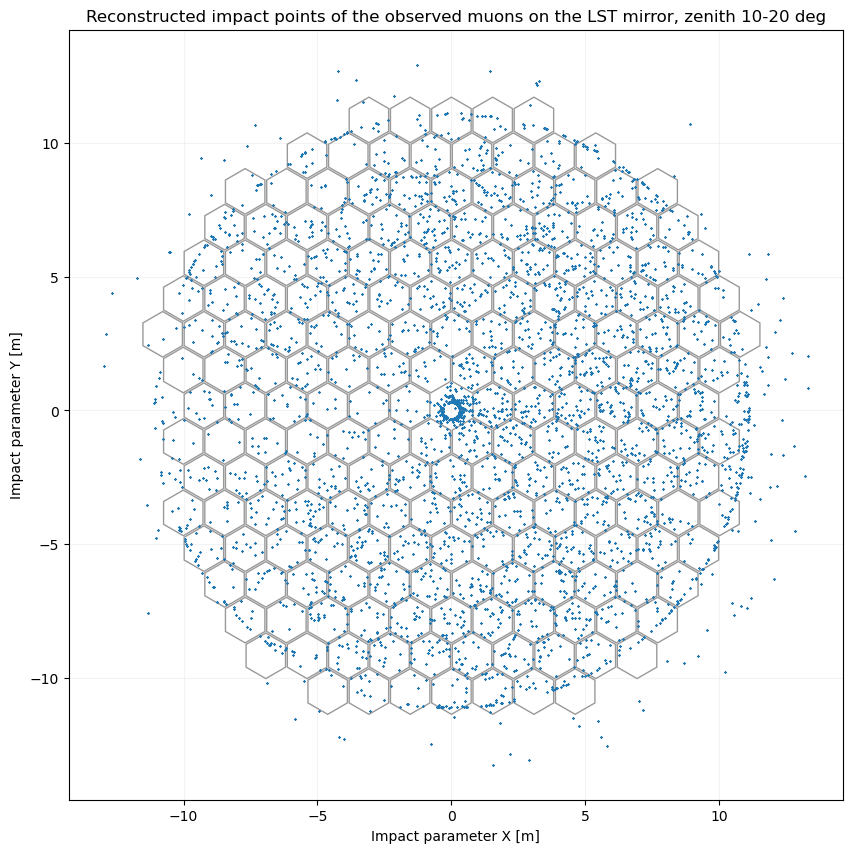

In [6]:
first_column = np.array(first_column)
second_column = np.array(second_column)
alpha_value = 1
fig, ax = plt.subplots(figsize=(10,10))


for center_x, center_y in zip(first_column, second_column):
    hex = RegularPolygon((center_y*0.01, center_x*0.01-0.269), numVertices=6, radius=0.85, alpha=0.4, edgecolor='k', fill=False)
    ax.add_patch(hex)
plt.autoscale(enable = True)

ax.set_aspect('equal')

ax.scatter(impact_x, impact_y, alpha = alpha_value, s = 1, marker = 'x')

ax.set_xlabel("Impact parameter X [m]") 
ax.set_ylabel("Impact parameter Y [m]")
ax.set_title("Reconstructed impact points of the observed muons on the LST mirror, zenith 10-20 deg")
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)
#plt.savefig(f'/Users/vdk/muons2024/images/ZenithImpactStudy/ImpactPoints_zenith20-30_2023year_2.png', dpi=200, format='png', bbox_inches='tight')
plt.grid(alpha=0.15)
plt.show()

In [ ]:
2+3